In [1]:
import hist
import dask
import awkward as ak
import hist.dask as hda
#import dask_awkward as dak
import numpy as np
from hist import Hist, axis, storage 



from coffea import processor
from coffea.nanoevents.methods import candidate
from coffea.nanoevents.methods import vector as vec
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)

from coffea.lumi_tools import LumiMask
from coffea.nanoevents import NanoAODSchema

GOLDEN_JSON = "Golden_data.json"

def as_plain_candidates(a):
    return ak.zip(
        {
            "pt": a.pt,
            "eta": a.eta,
            "phi": a.phi,
            "mass": a.mass,
            "charge": a.charge,
            "superclusterEta": a.superclusterEta,
        },
        depth_limit=1,  # no behavior
    )


class MyProcessor(processor.ProcessorABC):
    def __init__(self, golden_json=None, norm_weights=None):
        self._mask = LumiMask(golden_json) if golden_json else None
        self._norm_w = norm_weights or {}

    def process(self, events):
        dataset = events.metadata['dataset']
        is_data = (dataset == "data")
        all_e_pt = events.Electron_pt
        all_e_superclusterEta = events.Electron_superclusterEta

        # --- DATA-only lumi mask bookkeeping ---
        n0 = len(events.event)
        if is_data and (self._mask is not None):
            good = self._mask(events.run, events.luminosityBlock)
            n_keep = ak.count_nonzero(good)
            events = events[good]
        else:
            n_keep = ak.count_nonzero(ak.ones_like(events.event, dtype=bool))
        #print(events.fields)
        #event level cuts
        # apply trigger selection: `HLT_Ele115_CaloIdVT_GsfTrkIdT` OT `HLT_Photon200`
        # Electron.mvaNoIso_WP90 > 0 AND nElectron >= 2
        #event_check = events
        trigger_nelectron = (events.HLT_Ele115_CaloIdVT_GsfTrkIdT | events.HLT_Photon200) & (events.nElectron >= 2)
        events = events[trigger_nelectron]
        electrons = ak.zip(
            {
                "pt": events.Electron_pt,
                "eta": events.Electron_eta,
                "phi": events.Electron_phi,
                "mass": events.Electron_mass,
                "charge": events.Electron_charge,
                "dz": events.Electron_dz,
                "mvaNoIso_WP80": events.Electron_mvaNoIso_WP80,
                "mvaNoIso_WP90": events.Electron_mvaNoIso_WP90,
                "nElectron": events.nElectron,
                "superclusterEta": events.Electron_superclusterEta,
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )

        cut_mva = (electrons.mvaNoIso_WP90 > 0) 
        ele2 = electrons[cut_mva]
        #check---------------------------------------
        ele2_check = ele2
        ###############################################
        #ECAL transition region: 1.44 < |η| < 1.57 that should be vetoed
        abs_sc_eta = np.abs(ele2.superclusterEta)
        eta_trasition_cut = (abs_sc_eta > 1.44) & (abs_sc_eta < 1.57)
        ele2 = ele2[~eta_trasition_cut]
        #check------------------------
        ele2_after_eta_trasition_cut_check = ele2
        #---------------------------
        ##########################################################
        #tag
        # pt > 120 GeV AND ak.abs(eta) < 2.5  AND Electron.dz < 0.1 (0.2) cm for Barrel (endcap).
        # barrel ( |eta supercluster| <= 1.479)
        # endcap ( |eta supercluster| > 1.479)
        # Tight MVA ID: Electron.mvaNoIso_WP80 > 0

        is_barrel = (np.abs(ele2.superclusterEta) <= 1.479)
        is_endcap = (np.abs(ele2.superclusterEta) > 1.479) 
        pt_tag_cut  = (ele2.pt > 120)
        abs_superclusterEta_tag_cut= (np.abs(ele2.superclusterEta) < 2.5)
        
        dz_tag_cut  = ak.where(is_barrel, ele2.dz < 0.10, ele2.dz < 0.20)
        tight_mva_cut = (ele2.mvaNoIso_WP80 > 0)
        
        tag_cut = pt_tag_cut & abs_superclusterEta_tag_cut & dz_tag_cut & tight_mva_cut
        e_tag = ele2[tag_cut]
        not_tag_e_tagcut = ele2[~tag_cut] # e not passing tagging condition

        #clean up all lists: only events with at least one tag electron remain
        has_tag = ak.num(e_tag) > 0
        e_tag = e_tag[has_tag]
        ele2 = ele2[has_tag]
        not_tag_e_tagcut = not_tag_e_tagcut[has_tag]
        events = events[has_tag] 
        #update list, so that for the new events list, each of them have tag e (at least one)
        #check-----------------------------------
        e_tag_check = e_tag
        not_tag_e_tagcut_check = not_tag_e_tagcut
        #-----------------------------------------
        
        ##########################################################
        #match trigger obj
        
        trig_e = ak.zip(
            {
                "pt": events.TrigObj_pt,
                "eta": events.TrigObj_eta,
                "phi": events.TrigObj_phi,
                "mass": ak.zeros_like(events.TrigObj_pt),
                "id": events.TrigObj_id,
                "filterBits": events.TrigObj_filterBits,
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )

        #(events.TrigObj.id == 11) & ((events.TrigObj.filterBits & (1 << 12)) != 0 OR (events.TrigObj.filterBits & (1 << 14)) != 0)
        a = (trig_e.id == 11)
        b = (trig_e.filterBits & (1 << 12)) != 0
        c = (trig_e.filterBits & (1 << 14)) != 0
        trig_obj_cut= a & (b | c)
        trig_electrons = trig_e[trig_obj_cut]
        
        #check if the electron and trigger obj dR matches (if more than 1 tagged e find the one that matches with the trigger obj)
        # Build (electron info), (trigger obj) pairs for every event
        # next want to calculated the delta R between electron and trigger obj
        # when delta R is small, so they match, then this e should be the tag e

        pairs_e_trigObj = ak.cartesian(
            {"e_info": e_tag, "trig_obj": trig_electrons}, axis=1, nested=True
        )
        dR = pairs_e_trigObj.e_info.delta_r(pairs_e_trigObj.trig_obj)
        match_cut = ak.any(dR < 0.1, axis=2)
        e_tag_matched = e_tag[match_cut]
        not_tag_e_trigObj = e_tag[~match_cut] # e passes tagging condition but not trigObj
        
        keep_evt = ak.num(e_tag_matched) > 0
        events = events[keep_evt]
        e_tag_matched = e_tag_matched[keep_evt] 
        ele2 = ele2[keep_evt]
        e_tag = e_tag[keep_evt]
        #not_tag_e_tagcut = not_tag_e_tagcut[keep_evt]
        #not_tag_e_trigObj = not_tag_e_trigObj[keep_evt]
        #probe_cand = ak.concatenate([not_tag_e_tagcut, not_tag_e_trigObj], axis=1)
        probe_cand = not_tag_e_tagcut[keep_evt]

        # --- #tags per event (before Z mass window) ---
        ntags_per_event_before = ak.num(e_tag_matched, axis=1) 
        # ---------------------------------------------------------------
        
        #check----------------------------------
        e_tag_matched_check = e_tag_matched
        probe_cand_check = probe_cand
        #-----------------------------
        
        # update the event/electron list again, now only have events w/ tagged e
        # we have the tagged list and probe_cand list now
        ####################################################
        # now get probe e: pt > 10 GeV AND ak.abs(eta) < 2.5 
        probe_cut = (probe_cand.pt > 10) & (np.abs(probe_cand.superclusterEta) < 2.5)
        probe = probe_cand[probe_cut]
        #check----------------------------------
        probe_check = probe
        #-------------------------------
        ####################################################
        # build the tag-probe pair and test which is within the z mass window
        tp_pairs = ak.cartesian({"tag": e_tag_matched, "probe": probe}, axis=1, nested=True)
        p_mu_tot = tp_pairs.tag + tp_pairs.probe
        mass_constructed = p_mu_tot.mass
        z_win = (mass_constructed > 70.0) & (mass_constructed < 110.0)
        good_pairs = tp_pairs[z_win]
        ########################################################
        #the pairs are ready

        # check------- #tags per event (after Z mass window) ---
        n_probes_after  = ak.num(ak.flatten(good_pairs.tag, axis=2), axis=1)
        probes_per_tag_after = ak.num(good_pairs.tag, axis=2)
        n_tags_after = ak.sum(probes_per_tag_after > 0, axis=1)
        #---------------------------
                              
        #get different situations of charge
        q_tag   = good_pairs.tag.charge
        q_probe = good_pairs.probe.charge
        
        both_pos = (q_tag > 0) & (q_probe > 0)    
        both_neg = (q_tag < 0) & (q_probe < 0)    
        mixed    = ((q_tag > 0) & (q_probe < 0)) | ((q_tag < 0) & (q_probe > 0))  
        
        n_pp = ak.sum(both_pos)
        n_mm = ak.sum(both_neg)
        n_pm = ak.sum(mixed)
        
        tag=good_pairs.tag
        probe=good_pairs.probe

        
        #----------make histogram-----------------------
        tag_pt   = ak.to_numpy(ak.flatten(tag.pt,   axis=None))
        probe_pt = ak.to_numpy(ak.flatten(probe.pt, axis=None))
        
        tag_eta   = ak.to_numpy(ak.flatten(tag.superclusterEta,   axis=None))
        probe_eta = ak.to_numpy(ak.flatten(probe.superclusterEta, axis=None))
        
        q_tag   = ak.to_numpy(ak.flatten(tag.charge,   axis=None))
        q_probe = ak.to_numpy(ak.flatten(probe.charge, axis=None))

        
        w_norm = 1.0 if is_data else float(self._norm_w.get(dataset, 1.0))
        w_tag   = np.full_like(tag_pt,   w_norm, dtype=float)
        w_probe = np.full_like(probe_pt, w_norm, dtype=float)


        

        #pT and eta of tag and probe
        h_tag_pt    = Hist(axis.Regular(100, 0, 2000, name="pt"),  storage=storage.Weight())
        h_probe_pt  = Hist(axis.Regular(100, 0, 2000, name="pt"),  storage=storage.Weight())
        h_tag_eta   = Hist(axis.Regular(100, -3, 3,   name="eta"), storage=storage.Weight())
        h_probe_eta = Hist(axis.Regular(100, -3, 3,   name="eta"), storage=storage.Weight())

        h_tag_pt.fill(pt=tag_pt,       weight=w_tag)
        h_probe_pt.fill(pt=probe_pt,   weight=w_probe)
        h_tag_eta.fill(eta=tag_eta,    weight=w_tag)
        h_probe_eta.fill(eta=probe_eta, weight=w_probe)


        # fraction vs. pT/eta for probe

        m_pp = (q_tag > 0) & (q_probe > 0)
        m_mm = (q_tag < 0) & (q_probe < 0)
        m_pm = (q_tag * q_probe) < 0
        m_same = m_mm | m_pp

        h_pp_pt = Hist(axis.Regular(100, 0, 2000, name="pt"), storage=storage.Weight())
        h_same_pt = Hist(axis.Regular(100, 0, 2000, name="pt"), storage=storage.Weight())
        h_pm_pt = Hist(axis.Regular(100, 0, 2000, name="pt"), storage=storage.Weight())
        h_pp_eta = Hist(axis.Regular(100, -3, 3,   name="eta"), storage=storage.Weight())
        h_same_eta = Hist(axis.Regular(100, -3, 3,   name="eta"), storage=storage.Weight())
        h_pm_eta = Hist(axis.Regular(100, -3, 3,   name="eta"), storage=storage.Weight())
        


        h_same_pt.fill(pt=probe_pt[m_same], weight=w_probe[m_same])
        h_pm_pt.fill(pt=probe_pt[m_pm],   weight=w_probe[m_pm])
        h_pp_pt.fill(pt=probe_pt[m_pp],   weight=w_probe[m_pp])
        
        h_same_eta.fill(eta=probe_eta[m_same], weight=w_probe[m_same])
        h_pm_eta.fill(eta=probe_eta[m_pm],   weight=w_probe[m_pm])
        h_pp_eta.fill(eta=probe_eta[m_pp],   weight=w_probe[m_pp])

        barrel = (np.abs(probe_eta) <= 1.479)
        endcap = (np.abs(probe_eta) > 1.479)

        h_same_pt_barrel = Hist(axis.Regular(100, 0, 2000, name="pt"),  storage=storage.Weight())
        h_tot_pt_barrel  = Hist(axis.Regular(100, 0, 2000, name="pt"),  storage=storage.Weight())
        h_same_pt_endcap = Hist(axis.Regular(100, 0, 2000, name="pt"),  storage=storage.Weight())
        h_tot_pt_endcap  = Hist(axis.Regular(100, 0, 2000, name="pt"),  storage=storage.Weight())
        h_pp_pt_barrel  = Hist(axis.Regular(100, 0, 2000, name="pt"),  storage=storage.Weight())
        h_pp_pt_endcap  = Hist(axis.Regular(100, 0, 2000, name="pt"),  storage=storage.Weight())
        
        mask_same_barrel = m_same & barrel
        mask_tot_barrel  = (m_same | m_pm) & barrel
        mask_same_endcap = m_same & endcap
        mask_tot_endcap  = (m_same | m_pm) & endcap
        mask_pp_barrel = m_pp & barrel
        mask_pp_endcap = m_pp & endcap

        h_same_pt_barrel.fill(pt=probe_pt[mask_same_barrel], weight=w_probe[mask_same_barrel])
        h_tot_pt_barrel .fill(pt=probe_pt[mask_tot_barrel],  weight=w_probe[mask_tot_barrel])
        h_same_pt_endcap.fill(pt=probe_pt[mask_same_endcap], weight=w_probe[mask_same_endcap])
        h_tot_pt_endcap .fill(pt=probe_pt[mask_tot_endcap],  weight=w_probe[mask_tot_endcap])        
        h_pp_pt_barrel.fill(pt=probe_pt[mask_pp_barrel],   weight=w_probe[mask_pp_barrel])
        h_pp_pt_endcap.fill(pt=probe_pt[mask_pp_endcap],   weight=w_probe[mask_pp_endcap])



        # for check hist
        def flat(a):
            return ak.to_numpy(ak.flatten(a, axis=None))
        ax_pt  = axis.Regular(100, 0, 2000, name="pt")
        ax_eta = axis.Regular(100, -3, 3,   name="eta")
        
        def make_pt_eta_hists():
            return (
                Hist(ax_pt,  storage=storage.Weight()),
                Hist(ax_eta, storage=storage.Weight())
            )

        def fill_pt_eta(h_pt: Hist, h_eta: Hist, pts, etas, w_val):
            pts_flat  = flat(pts)
            etas_flat = flat(etas)
            w_arr_pt  = np.full_like(pts_flat,  w_val, dtype=float)
            h_pt.fill(pt=pts_flat, weight=w_arr_pt)
            w_arr_eta = np.full_like(etas_flat, w_val, dtype=float)
            h_eta.fill(eta=etas_flat, weight=w_arr_eta)


        h_event_check_pt, h_event_check_eta = make_pt_eta_hists()
        fill_pt_eta(h_event_check_pt, h_event_check_eta, all_e_pt, all_e_superclusterEta, w_norm)

        h_ele2_check_pt, h_ele2_check_eta = make_pt_eta_hists()
        fill_pt_eta(h_ele2_check_pt, h_ele2_check_eta, ele2_check.pt, ele2_check.superclusterEta, w_norm)

        h_e_tag_check_pt, h_e_tag_check_eta = make_pt_eta_hists()
        fill_pt_eta(h_e_tag_check_pt, h_e_tag_check_eta, e_tag_check.pt, e_tag_check.superclusterEta, w_norm)

        h_not_tag_e_tagcut_check_pt, h_not_tag_e_tagcut_check_eta = make_pt_eta_hists()
        fill_pt_eta(h_not_tag_e_tagcut_check_pt, h_not_tag_e_tagcut_check_eta, not_tag_e_tagcut_check.pt, not_tag_e_tagcut_check.superclusterEta, w_norm)

        h_e_tag_matched_check_pt, h_e_tag_matched_check_eta = make_pt_eta_hists()
        fill_pt_eta(h_e_tag_matched_check_pt, h_e_tag_matched_check_eta, e_tag_matched_check.pt, e_tag_matched_check.superclusterEta, w_norm)

        h_probe_cand_check_pt, h_probe_cand_check_eta = make_pt_eta_hists()
        fill_pt_eta(h_probe_cand_check_pt, h_probe_cand_check_eta, probe_cand_check.pt, probe_cand_check.superclusterEta, w_norm)

        h_probe_check_pt, h_probe_check_eta = make_pt_eta_hists()
        fill_pt_eta(h_probe_check_pt, h_probe_check_eta, probe_check.pt, probe_check.superclusterEta, w_norm)

        h_ele2_after_eta_trasition_cut_check_pt, h_ele2_after_eta_trasition_cut_check_eta = make_pt_eta_hists()
        fill_pt_eta(h_ele2_after_eta_trasition_cut_check_pt, h_ele2_after_eta_trasition_cut_check_eta, ele2_after_eta_trasition_cut_check.pt, ele2_after_eta_trasition_cut_check.superclusterEta, w_norm)







        return {
            dataset: {
                "num_pp": [n_pp],  
                "num_mm": [n_mm],  
                "num_pm": [n_pm],
                "h_event_check_pt": [h_event_check_pt], 
                "h_event_check_eta": [h_event_check_eta],
                "h_ele2_check_pt": [h_ele2_check_pt], 
                "h_ele2_check_eta": [h_ele2_check_eta],
                "h_e_tag_check_pt": [h_e_tag_check_pt], 
                "h_e_tag_check_eta": [h_e_tag_check_eta],
                "h_not_tag_e_tagcut_check_pt": [h_not_tag_e_tagcut_check_pt], 
                "h_not_tag_e_tagcut_check_eta": [h_not_tag_e_tagcut_check_eta],
                "h_e_tag_matched_check_pt": [h_e_tag_matched_check_pt], 
                "h_e_tag_matched_check_eta": [h_e_tag_matched_check_eta],
                "h_probe_cand_check_pt": [h_probe_cand_check_pt], 
                "h_probe_cand_check_eta": [h_probe_cand_check_eta],
                "h_probe_check_pt": [h_probe_check_pt], 
                "h_probe_check_eta": [h_probe_check_eta],
                "h_ele2_after_eta_trasition_cut_check_pt": [h_ele2_after_eta_trasition_cut_check_pt], 
                "h_ele2_after_eta_trasition_cut_check_eta": [h_ele2_after_eta_trasition_cut_check_eta],
                "n0": [n0],             
                "n_keep": [n_keep],
                #------------tags/probes per event check
                #"ntags_per_event_before": [ntags_per_event_before],
                #"n_probes_after":  [n_probes_after],
                #"n_tags_after": [n_tags_after],
                
                "h_tag_pt" : [h_tag_pt],   
                "h_probe_pt" : [h_probe_pt], 
                "h_tag_eta" : [h_tag_eta], 
                "h_probe_eta" : [h_probe_eta],
                "h_pp_pt" : [h_pp_pt], 
                "h_same_pt" : [h_same_pt],
                "h_pm_pt" : [h_pm_pt],  
                "h_pp_eta" : [h_pp_eta], 
                "h_same_eta" : [h_same_eta], 
                "h_pm_eta" : [h_pm_eta],
                "h_same_pt_barrel" : [h_same_pt_barrel], 
                "h_tot_pt_barrel" : [h_tot_pt_barrel], 
                "h_same_pt_endcap" : [h_same_pt_endcap],
                "h_tot_pt_endcap" : [h_tot_pt_endcap], 
                "h_pp_pt_barrel" : [h_pp_pt_barrel], 
                "h_pp_pt_endcap" : [h_pp_pt_endcap], 
            }
    }

    def postprocess(self, accumulator):
        def sum_int_list(lst):
            return int(np.sum(lst))
    
        def merge_hist_list(val):
            h = val[0].copy()
            for hi in val[1:]:
                h += hi
            return h

        scalar_keys = ["n0", "n_keep", "num_pp", "num_mm", "num_pm"]
        hist_keys = [
            "h_tag_pt", "h_probe_pt", "h_tag_eta", "h_probe_eta",
            "h_pp_pt", "h_same_pt", "h_pm_pt",
            "h_pp_eta", "h_same_eta", "h_pm_eta",
            "h_same_pt_barrel", "h_tot_pt_barrel",
            "h_same_pt_endcap", "h_tot_pt_endcap",
            "h_pp_pt_barrel", "h_pp_pt_endcap",
            
            "h_event_check_pt", "h_event_check_eta",
            "h_ele2_check_pt", "h_ele2_check_eta",
            "h_e_tag_check_pt", "h_e_tag_check_eta",
            "h_not_tag_e_tagcut_check_pt", "h_not_tag_e_tagcut_check_eta",
            "h_e_tag_matched_check_pt", "h_e_tag_matched_check_eta",
            "h_probe_cand_check_pt", "h_probe_cand_check_eta",
            "h_probe_check_pt", "h_probe_check_eta",
            "h_ele2_after_eta_trasition_cut_check_pt", "h_ele2_after_eta_trasition_cut_check_eta",

        ]
    
        out = {}
    
        for ds, d in accumulator.items():
            ds_out = {}
            for k in scalar_keys:
                if k in d:
                    ds_out[k] = sum_int_list(d[k])
    
            for k in hist_keys:
                if k in d:
                    merged = merge_hist_list(d[k])
                    if merged is not None:
                        ds_out[k] = merged
    
            out[ds] = ds_out

        return out


In [2]:
m40to100 = 475.3
m100to200 = 45.42
m200to400 = 3.382
m400to600 = 0.1162
m600 = 0.01392


import uproot, numpy as np

bins_to_files = {
    "40-100": [
        "root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-40to100_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v3/100000/18197ca8-14a7-4705-acc3-5fbea17f890d.root",
        "root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-40to100_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v3/100000/185ba806-afd7-4a8b-9235-6e197fd618fc.root",
        "root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-40to100_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v3/100000/18bc8d9e-aaf7-45db-918f-8a5f93af48c7.root",
    ],
    "100-200": [
        "root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-100to200_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v2/100000/29f004ec-99e8-41e6-b02e-39b07294ab06.root",
    ],
    "200-400": [
        "root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-200to400_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v2/100000/aaac973d-7645-471e-85de-72ebf34015f0.root",
    ],
    "400-600": [
        "root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-400to600_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v2/2810000/94f7ccff-b6b5-4036-a599-a8e1b2307afb.root",
        "root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-400to600_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v2/2810000/a1eb4ac9-17ea-4119-9a67-16c030de773c.root",
    ],
    "600": [
        "root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-600_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v2/100000/42992f08-f719-4c8f-8d98-7f9588942ca8.root",
        "root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-600_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v2/2520000/8e732505-eeea-45fa-b946-4147fdd1cc35.root",
    ],
}

def runs_count(files):
    total = 0
    for fp in files:
        with uproot.open(fp) as f:
            runs = f["Runs"]
            total += runs["genEventCount"].array(library="np").sum()
    return int(total)

Lumi = 109.08 * 1000.0

n_M40to100  = runs_count(bins_to_files["40-100"])
n_M100to200 = runs_count(bins_to_files["100-200"])
n_M200to400 = runs_count(bins_to_files["200-400"])
n_M400to600 = runs_count(bins_to_files["400-600"])
n_M600 = runs_count(bins_to_files["600"])

W_M40to100 = (m40to100 * Lumi) / n_M40to100
W_M100to200 = (m100to200 * Lumi) / n_M100to200
W_M200to400 = (m200to400 * Lumi) / n_M200to400
W_M400to600 = (m400to600 * Lumi) / n_M400to600
W_M600 = (m600 * Lumi) / n_M600

print(n_M40to100)
print(n_M100to200)
print(n_M200to400)
print(n_M400to600)
print(n_M600)
W = {
    "DY_40_100":  W_M40to100,
    "DY_100_200": W_M100to200,
    "DY_200_400": W_M200to400,
    "DY_400_600": W_M400to600,
    "DY_600":     W_M600,
}


768721
940431
808925
908938
843664


In [ ]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)

fileset = {
    "DY_40_100":  {"files": {fp: "Events" for fp in bins_to_files["40-100"]}},
    "DY_100_200": {"files": {fp: "Events" for fp in bins_to_files["100-200"]}},
    "DY_200_400": {"files": {fp: "Events" for fp in bins_to_files["200-400"]}},
    "DY_400_600": {"files": {fp: "Events" for fp in bins_to_files["400-600"]}},
    "DY_600":     {"files": {fp: "Events" for fp in bins_to_files["600"]}},
    "data": {
        "files": {
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/06e4dedc-d371-4722-931f-4db351182c90.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/0780d8e0-bacf-4b1e-b526-8615df6724c2.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/080653b4-ae37-49cf-b584-b68c87a59480.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/092d609e-2587-42ec-9e71-371641ebc675.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/093391b2-876d-4427-8656-91d17d7b49b0.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/0aa73fe7-905d-4d84-b8c2-0e0424614eca.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/0afbfbc2-4a1a-46be-8813-2eecd4d156b5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/0bd2a565-56ad-44a0-9921-424b4a73b56f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/0c841f50-b809-482b-a6a7-7afc2ebebfc3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/0caa730b-c7d5-4411-8514-774b22985004.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/0d12975c-d9b2-49c4-83e5-1089a1f402ca.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/0f9bdbc1-1f5d-4d32-93e2-4780da13869b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/1044c4ce-e2b0-4efe-858b-f69966a759e9.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/10d75f0f-e12b-4cc9-a44f-f7a7bf475652.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/121d449d-311d-4541-b8cf-fb521dccbc4d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/12aaddb0-7a22-474d-9f11-ea6779466d5b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/12ef48d6-fe31-4cec-8f4a-99cfb91f366c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/13c03d49-ca47-488a-844f-d3d8871f33bf.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/15269362-92b1-49a2-9542-f7fc96701562.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/1544c4ea-ec5b-4eb0-8bbb-7923f719937e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/1603e0d0-8575-493d-a3af-208695990bfa.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/182209bf-9642-402b-8e4c-ead67f28db45.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/18c6b0d4-161a-45af-9c6b-8f4345e757d2.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/1b3389a3-15b9-4a24-b6b6-042fe3e386af.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/1c760320-dd5c-4368-ba9b-ecae065593e2.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/1cb57f0b-095f-43e1-9222-f32622ee6e85.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/1ce5bc83-e98b-477f-9c15-68cbe69f5afc.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/1fe48859-d641-4dd2-8872-6bfc85b5efec.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/203577e1-f344-49fc-97ad-0314bcf80537.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/21b6ff2b-bb5f-4d2f-a144-bb76959b04b8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/228a7993-373c-4760-861e-bf8d173e02cd.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/22f43e5e-6b42-4813-a995-b262a766d8b0.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/23f8a6c6-ce29-417d-b0e3-81d5d2a7fe1e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/25f9d1a7-5a79-4072-916e-5e0408f4e530.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/28822db6-4540-45ff-b43a-b4acc4519364.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/2886b636-3381-4a0a-b0a3-03c540cf0b84.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/297cb488-0075-4f52-ae95-dc48f974b5c5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/2c35c165-bf54-4574-a771-43a9d2d65e51.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/2cd075af-dc68-41ba-a477-5e19fec785c5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/2deb6b2d-5e84-468b-a5a7-4ab310e7730b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/2e352a86-9612-4c0a-94f3-eaa26b49ae8c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/2f76b711-14f1-4be1-b3b9-0de29d72d9f5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/3178ac12-6467-4a67-8e68-a8acb713e42c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/342fb678-85cc-4f43-9057-2301607fd1a5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/35913a6f-41fe-4eac-88d4-4df6276580a7.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/368ce43a-9f7a-4206-816a-ebacde55a5ed.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/370df299-070a-4f9f-b168-7b663e4f85b0.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/38929312-dcef-49dc-b183-9320e0602f10.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/38c542f4-c7b5-4281-b44a-102104c11abf.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/3ae80903-13a0-4bd5-9013-6debce05bebc.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/3af8ec45-fa45-4a38-9cb6-3a3ef184a387.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/3b541d72-871e-41e3-906f-b09e4582c419.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/3ba827c1-27d1-4674-a9ae-03ae04a72aad.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/3dc8e00c-3ba3-448f-988f-68a547f6907d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/3fe084aa-0015-449e-8f48-3b1116305cbc.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/404bdb2a-8dab-41fe-b2d3-9fe043996c67.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/404fa3d5-3317-4f8e-9dd4-e3e1b84ddfa4.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/411e9624-9b7b-4c32-a880-45b50b99f4cc.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/4416fab5-9a48-468d-b8cc-78acec5e0e78.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/44a45617-0d24-4a18-8570-17559815bbe6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/44dea689-91da-4b44-845c-d6a7d6ce4f00.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/45c45d2a-f989-432e-84e4-4c09d70557bd.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/468d6d83-d818-44ba-b33d-e9b3a531fdf8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/46f73534-c411-4176-b191-f6579eab8f06.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/4812eb48-2f6c-4244-84ef-e8db8327e678.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/492de701-3334-4244-98fa-84510bd45f9c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/498a40ee-2a68-490a-b57d-06a2c5c9c6b3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/4ad8e12a-07b6-4dae-a42c-f22e40bb177f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/4ad9fdcf-bc34-4f3e-b289-ae4d0517c02e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/4be46655-44ea-4d27-9e0c-6b3cf0d5a10c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/4cfb1947-f477-4505-8fb3-3c488ca3cbf4.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/4e69c6ac-0326-4b4f-b456-44b2ac4bf4c6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/50a2ef80-4591-4188-b887-d57016612a43.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/50ea90d1-2762-4dc8-8986-7cd7476de894.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/512726e0-99ef-4576-acfc-b297b93f887b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/5182cc9c-3e45-46a1-9f06-4cad2f590fa2.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/51ed070c-3217-4bfc-9d91-901efe81d572.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/534f7dae-62eb-4878-9289-0b0d7bf81ce4.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/54201eba-6508-4979-86d2-c960942e7c22.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/55f83d3b-9894-432c-ac4f-31310bac625f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/56873bad-a5c4-46b3-aa64-6fe970b37954.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/56cbf3a9-5733-408c-8fa2-db4bafcddf57.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/585e92ae-01b5-4460-becb-37633a42ed18.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/588a7d00-6983-4aee-812c-4ba4553e733b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/5900b507-2fe6-4619-b77c-ca470877f936.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/59495d5d-b0a3-44e5-b15a-b2deb50834ea.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/5b7ee7cc-c5fb-46d1-8b14-a0a608b97df7.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/5b8ff43a-70cd-4d77-9754-f5ab5ebd1285.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/5cdf17b4-14d6-4efd-b943-d623402da404.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/5cfe9513-af24-44f2-8d62-90618c21a5f5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/5dc00633-2e12-4d10-85c4-7577525d5731.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/5ed2521a-1078-4803-bb82-df376033d238.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/60a32302-f115-4a7a-ac6d-ffde476363e9.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/613baa65-a0c7-49e2-aa76-44f72de7095f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/6258d02d-d1c9-41f1-9625-7746b7ab897c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/6270aaa9-e49b-4708-b9fc-2d290ca3726f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/6364b947-51e7-413a-a042-ae7fecf81668.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/639f438f-d229-4ca3-8575-439e4bed4276.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/63a1cea6-fa0f-4041-ae95-629615f3aaea.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/649ca5c5-c775-4f26-a5e9-f992c087a46e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/65139780-f71e-44c3-a151-2045b97236f0.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/65902f93-f6b7-493f-abc1-34a83bf5bc4d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/65d155ea-15fb-4deb-be0b-e828cf152644.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/65ffaeda-c14c-4e0d-acfd-20e30038efb4.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/661bfe12-bd86-4090-9c88-be252f97660d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/66223770-f08f-4b24-b387-21746f3fb238.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/68badd0d-e009-4ac1-aff8-6721d4fc1765.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/69ef6c29-41f2-42d8-96cf-6686cf788c44.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/6a20bcbf-3282-4701-a7f8-9ba17aa10217.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/6c04b6ba-ffc8-4b07-a57a-9c8a8f6ea7f6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/6c42d6c3-4ef6-4890-8ff6-51727a6f7142.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/6c811d88-920a-4e4f-ac7e-9a6e143c657f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/6d966b1a-6687-4000-8b5e-d436353ec635.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/703c65c4-9b14-4f16-a91b-5f475cf07957.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/7049eca0-1dc2-4b45-a3f0-eced90af925f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/706f4fde-b029-4ec1-afe8-6e6957648625.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/70fe9eb3-39bf-4822-bcbb-56e0c5d651c9.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/71255ffb-f54e-48ae-b709-4f8d8d0eaf3d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/71ae5435-01c6-4859-a88f-bc58dbef1d42.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/71fd1a5b-ee21-4831-884e-d145df28fc06.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/721b1bd8-ee78-4086-bf1a-468061a60ddd.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/722113cf-244d-4479-ab07-7cf2cd2657bc.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/728c8709-b1c2-4315-88d6-931b0ed858ff.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/7569e715-0f27-45e0-8a19-09734d960ca2.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/772cd828-acf0-4f4d-9476-e30048080b17.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/77e8c10b-0744-4e18-a3e0-540abf479da5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/78e87aa4-0922-4420-a882-83dc6970e097.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/7927ae93-c2c9-4004-84c2-88a9ad200dd3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/79968c67-975c-436c-b215-e0efcb936bc8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/7a4016ff-a6db-4d77-9ca5-2c63ef727623.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/7ae76dde-df95-4df8-a08b-34afe2aa7485.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/7b03458f-d790-4435-9bae-71480c541bba.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/7bb13b64-214e-4a38-87c0-d31b78bd1703.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/7bbd2065-51d4-452b-8fb9-c679612861a3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/7d3443f9-88bb-426e-817e-50d9ce5f382b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/7dabd2cc-ac3e-4b2c-a7d0-1a543f4f646d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/7e1f377c-29a9-4d35-84ff-563b0414eae0.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/7ec9445e-997b-44f6-b906-4cf2b2f07e2c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/7ef0ff0d-ef9a-49c4-b7eb-aaad38c4b005.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/7f5d4a39-9fe6-4cd3-a634-48685c8c3231.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/7f869b68-a440-4e46-a6de-214b0669c49c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/7fa71c9b-a4c5-4e3d-b37a-ff2b3ba32dc6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/7fac8b82-299c-444f-acb8-befada5329f7.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/7fec832e-922c-4c28-a5e7-5dba7b5c4526.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/8008e018-4115-4092-83fc-2942c568f23c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/803427dd-df07-48d5-97ef-3d0176d8a923.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/80d16aba-ac61-42cf-9060-48359f91072c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/81c36a86-46fa-4429-9cd5-a253c1238260.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/81c9d235-5762-4292-b028-3136754b7508.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/82f64478-5908-4991-8d55-750cb5c8a61f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/838c575f-802a-43b1-aed0-0f3ead0d13b0.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/839e6c90-8a67-489c-b571-92f4572587e6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/8430aed1-c72c-405c-a8ed-82712e3c9a16.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/846128db-d59f-434b-bd40-3e0254fcabc8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/84dcf28c-4e67-43dc-8adb-0de3b9ba99f5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/85b545a7-d938-46f7-a61b-7c32e7995b32.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/877e0fd4-3c3f-4334-90a5-8bca30e2df77.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/87bfa53d-b117-47a0-b0be-3f8816664b39.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/88a4fff8-6e38-4fcb-9996-51c682e1672b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/88e7c256-0525-4721-a60d-4d026aa651c8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/89842217-8b35-4ab7-ada7-39f1a724627b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/89898bf6-1b13-4501-9faf-aef5c0f8af56.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/89bfd407-097c-474a-9c60-f1010edbf4aa.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/8aae2804-75c1-47c1-ad40-3aa797cf3ce5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/8ab6d2d9-59fd-4d2a-ace3-352595e344e7.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/8d7f711b-3606-45a3-8628-60ed68c82608.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/8e054866-0d90-4899-b0cf-a628bed2aa1e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/8e3cc555-ad76-4dd6-8147-e5492c7e7403.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/8f08b58e-84e0-4a2c-bbd1-52042e4cb547.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/912f6418-4176-44eb-a7d3-cdec5646f306.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/92e45b13-34f7-4c49-920c-5d745847dca1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/935855d0-b2c7-4e9f-9af2-c763936f925c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/93b4f73b-5596-4f0e-beab-3b13e5dc9edd.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/94f11ce6-888d-4901-a074-b84b1dd2f8a1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/9697b625-8a69-4bc1-bfe4-a5be32232ade.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/9773005b-1370-4941-b012-e7b6f7ad64bf.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/99aa27eb-bd5b-4f76-86d9-2d46550004bf.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/99cf2f56-6255-47f1-8d1f-b659e5094e41.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/9af0a408-e065-4161-b6dd-6cf266735635.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/9afd0f20-65b4-40b5-b3d8-72f909973b4c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/9b2ec1ed-35de-438a-afed-b2344ba42b8e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/9c7b89db-348a-4b58-a475-751f49b99240.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/9d1a7ba8-6a19-4e3d-8add-2f36c1be8225.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/9d550088-e9af-45eb-aceb-0750e06bde54.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/9da5452f-c698-4578-8791-8365ae40795f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/9e853d5f-a778-42db-8806-43e1fcfc2236.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/9e8d955e-e7da-4d29-aeba-5bfec102cbd5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a096cbb3-2703-40e4-8892-a324bd137735.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a0a3c014-b827-4363-8756-c47f03247078.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a12dd26b-273c-4b07-a4c1-6a10213f236a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a206947f-80a3-4318-8e5f-1f17a762c7cc.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a33b1a13-30ad-4d0e-aefb-38b79a978632.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a5c7ad8a-5fec-4719-b7b0-15d23ddf1446.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a5eef332-f18e-415c-a646-dff5fe9965f3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a63f762c-38ec-4ddd-93cb-17624ecd3ba5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a66d3d62-f3e9-49e3-86c4-b21a9a2f26de.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a66faed1-f0cb-49ef-8953-8add9bf9770e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a6e125a3-d9a5-4f3a-b9c9-ef8d41c6daa7.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a6fa07de-0f85-4462-b73b-336da890e0db.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a7714dc4-082f-4a85-98c4-ff872cd87962.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a8f557e1-24c6-4ed0-8e4f-d09f4fd32c5a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a9b5e5a6-db77-42ab-8906-89025b95526d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/abf5ce3e-8e86-43c8-abf1-f247f7aff001.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/ad35fda1-9e38-4611-99db-b4bdde2f2df4.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/ae51e3ae-1ed4-4ddc-a5cd-d085f0a5b2f8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/aebb574f-1c86-461b-8ac1-653051d860b1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/af30374d-c869-472d-80f4-17ed60e59f1f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/b04ec17c-51c4-4ec7-bb87-aeef5cb79e4f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/b0718050-f800-485c-ae95-7d1c1190f52f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/b0b72807-25a8-4ac0-a4cc-7f06cc29c015.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/b5eadc3c-83bc-48e9-9001-738f3f30502f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/b67bb00d-606c-44ce-afb6-aeaf8914bc43.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/b8fb5eb1-8d82-4226-b751-75774f18cd2a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/b9069be2-0223-4256-8538-eea65bb49afd.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/b95c489f-7a64-40bd-b800-c228eb9d0f93.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/b979f90d-8284-48d2-a66c-a226523144b6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/bab25a6a-68cf-4097-ad9b-dfcea3da43d6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/bbf9a88c-9af3-4d61-9506-b5f4598985be.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/bc498d1c-d472-402c-9e8e-64360958fefe.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/bd0eede6-5f26-4fdf-aa06-5918cf458eef.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/bf6d9fd2-9d09-414a-9aa8-564534f2a6c6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/bff73e3f-b203-4d15-b8df-d6b8938421f5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c1d486e8-7f0e-4ce8-993d-a4af1cc6385b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c1f43070-ea2e-4a9a-8fd4-8f80ac49d953.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c2419767-ea18-44a9-98f1-cdc4bba26373.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c25d0cb9-61f3-487b-a00a-463115c0f3f5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c274260c-da53-4890-b7cd-6b3afc44292e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c3133f49-e0dc-484e-8e56-2c933b9fe4c7.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c3ed94dc-5235-443a-9354-6edef1f36a87.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c67bd6f6-afb7-467e-b9bd-73c0ea914876.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c71f6f6c-0066-4537-a3d2-06cf63933319.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c88e6d98-5b11-4f86-8dfc-ebcc9a88809d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c9da2aaa-7750-4fd0-8d73-02127f366dd6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/ca300543-d41d-4a44-92c5-7b1a4f249c0f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/cd082968-fdde-4813-a48f-a7371017adb9.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/cdae85ca-a91a-4c67-a61a-18251a471902.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/cefc4060-a5c3-4c28-b514-0a8c69a95863.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/cf2aecda-f8e3-4b70-a420-328339ed2a7c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/cff39a24-3d46-4137-91d6-2d1b4360326b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/d0b52fb4-3ccd-4a07-9a74-f16000232c54.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/d246ead2-3152-45ba-bca6-ae73db361f9c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/d2bde696-1e78-4095-9771-3f859fe6350f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/d40a8a3c-86c8-4f63-a406-d20f8ddae16a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/d5542820-ac01-4f8a-bd5c-4f4a230bfc6c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/d56d5fce-821b-4b14-a85e-5aa9c325ec02.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/d5e08c17-b7e5-4130-8f29-8572b64147e2.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/d66cfa2e-0eec-4c74-a262-de152fa66781.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/d7b4b95b-3aea-4190-87ef-51febd5e8c2f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/d8c55d94-1003-4c32-84c6-21116477af50.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/da7f75e0-d9a4-479d-8434-70d3d83eb69f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/dbedc939-7a77-4207-a874-10eb54428183.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/dbf1d2fb-2493-4991-bb5a-84e466dd1745.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/dd7999a7-d5ac-4041-bc3b-726393b3a3ea.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/ddb6eada-d1dc-439e-b592-5de9ce19c1c3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/df49913c-7a20-4920-991c-c957aeab6acf.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/e22e7dad-7b30-41c3-8431-13988c6460f2.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/e26bd466-8252-4f0a-be2d-fdba5d91bcbd.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/e5094745-03e3-4d5c-ab0c-07cf0c87a32c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/e663324e-8fd5-4934-b2da-3dd8aac26478.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/e6824b03-b357-4634-9856-a5a09beb41b8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/e8b99f9e-14d9-4ad8-aa29-a3257d3d0537.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/e92d2be0-06e4-47bf-b2c1-b7923d3b0b72.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/e9a55c66-8560-4795-9188-7ee510ef265d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/ea5c0493-6f9e-4e2d-9c21-12454871b55c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/ea8e1bc3-43dc-46ee-b41c-068ecdac3d62.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/eaa2d905-edb5-4e41-8fc1-09763350ca11.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/ec210c4a-81c3-4821-8e7c-dd5a41464d7d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/ed209fff-130d-4f57-af63-c6b3d70e74b7.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/ee6cab65-6b5d-4681-9893-5b621bdc69fa.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/eee72896-ec65-4ae0-b633-164a1a03eadb.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/ef9907f4-236a-4340-bf99-e639a59cb25a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/f118a075-bd2e-4c2f-866b-a623e290bf76.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/f11e2ec3-dfba-4343-906f-7b0f87d3b86f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/f348df8e-12f1-441d-bc35-c8e7ed5f6e3d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/f518eb58-5f80-4640-bd81-7dbba7bd7e9b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/f59a1960-1b38-46b0-a147-8bd206d4673e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/f5e8079a-13be-4f8e-89d6-f9ca32c0c754.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/f62f2b6f-b37c-460b-abb8-87c0198b04f7.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/f687022d-0c67-445f-8c4d-12969606a341.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/f8affe3b-8542-49b6-8ac8-789faa73c079.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/fb41fd1f-d354-4822-977f-4da7abd57592.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/fb9d374e-cd99-462b-8756-aaabbbd35964.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/fc89a380-125d-4db7-9301-da984082b175.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/fd05bc39-fdf2-4ff7-8eb0-3a3c857aff41.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/fdd4c2db-633c-4860-b2d6-b3c8dde04961.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/ff3811ce-bd9e-4bba-8422-5750f811ba3e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/ffa5ab08-9238-427b-8fa2-242c8cb3fff2.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/ffb63728-ed0e-49c2-9142-595f28ecd87d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/001722d6-89a9-4bef-bb66-7492f0ea27e0.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/02ee2970-dbb9-4a09-9e14-317bf8465385.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/038f26fc-2c2b-41be-a8cc-460f82747ef5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/047192a5-b22a-4b5b-bddd-859b5ba161b5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/063ea1be-0839-4b32-a318-e9551ab67852.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/06d1465f-47b2-4e31-81e8-556fa1110d05.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/07d65264-fa22-4c9d-892f-3e7cbd337005.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/0917562c-c185-4fbb-9437-860d8193b35a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/0bb99d9d-f4f5-44a1-8ad6-e9683954a98f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/0d4c7cda-cec6-4b40-82c4-5df123ad3571.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/0e1e23c2-6c5a-4714-a0f2-bb20088e7844.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/0e959ef4-b290-44a7-af42-627bdd8b859e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/0fa3d4e7-b7ad-4bcc-a11e-2744b17451f4.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/100ee3c4-1f7d-401b-9eff-d625354149aa.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/113ce4a2-7b0e-4a11-86db-e844c06197ff.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/11b3f3f7-5cb0-4fc3-9657-4535c9c1b349.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/12281eff-488c-442d-abd3-cb4578c74333.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/1248e4c4-3a60-4725-8337-5a6bea787561.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/12b08b74-df0d-4cc3-a37c-94d9ead5c135.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/12d9b9bd-b348-4361-bb79-b8d1cb15a4ea.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/12dbeeb9-1374-488e-9aa3-a148ea044ac5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/13f45487-c1fa-492c-a886-be125233dbef.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/14172e87-51d9-4b9a-b488-1cd770693d01.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/18abbc07-ea0a-4f2b-b6c6-89139ca1a8cf.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/18d10bdb-42dd-4999-8c0c-3601c5639861.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/1984b32e-acc6-4656-b383-8badbac0f9d4.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/1a71d9d9-4ad8-416e-99e4-d1ae1c46ea3d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/1b4b83e6-06ba-4b4a-89ab-f1669567afa7.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/1ccf75a8-939d-4383-9b64-469efb5d890d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/1d197168-045d-4940-88c4-f3024a04544d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/1df1f434-bc28-44b1-bdda-d92149dea58e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/1e96a287-d6a6-4efd-80b2-1e17d4936aeb.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/1fe866b1-ba51-4f8f-94dc-693e3a47f76f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/2087724c-7fe4-46f2-bcfe-7c68fd738e56.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/22045590-7736-4782-9a06-de6519d83b4e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/23368dad-2b5a-4e69-8226-bdcc258a280b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/246b74e8-2c60-4a59-b153-829b9a789ff8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/24dd5de1-f72d-444b-ae27-b6dcd64266ea.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/27dad0f0-e7d1-4134-a154-2f972d10cb6a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/28e6282c-6e95-40aa-8582-f6243a661638.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/29d62fef-224b-4a94-9c35-3afe1b6beda8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/2abfd040-7d44-468a-bccc-ff44586619c3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/2b214985-bb55-4119-b5d3-e4115e2a74bf.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/2c91941b-735c-409b-a4dd-db24440a7cd2.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/2cf7805e-7dbf-401e-bb7c-af39f03ef3d3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/2d117ff8-960d-467e-998b-4b70bff300a3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/2d8072fb-473b-42c2-9257-dfb78723ff8e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/2fe27381-0327-483c-937d-06b59fac2c93.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/2fec2527-d1ac-4793-aabe-6d8dfce8aaa1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/32395463-11ba-423d-9166-ff73c94b2eda.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/32d1073c-f321-46a6-ab76-c8b24b89abea.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/3306bd3d-d5be-4e19-a992-308e1f18ccdc.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/338d1e25-103e-466a-98f7-5bf955adf8a5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/3454664a-5b1d-401e-af2a-3d5c251bca4b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/3546eb04-4ede-4cb2-b85b-3a5ca950bca2.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/358ee598-038e-489d-a6e6-a012244b0e47.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/3600eb17-48f4-477c-85e4-54454ac0076e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/360a9228-48b1-4619-adee-15b39ae0d0b0.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/364e3734-3887-432d-b52e-422e03f68e18.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/3775c6f9-adf4-4d32-a276-1eb159cbbf0c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/38638a82-ddd0-4ea6-b9db-50e3d052e09d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/3925e779-4234-4b44-9871-f19ea044326e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/39fb3f83-8564-4bd6-b334-aff3fe17b79c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/3a17fcbf-9718-4b1e-8c27-c8e0c75e7cf7.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/3a1f20f7-d9d3-4cec-8df4-528dc626a06f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/3b478980-bfbc-431a-ad11-90c75add09aa.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/3d3c6cd0-49a1-48da-83a1-b39aa7ea31cd.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/3e37663f-1eec-446c-a1c5-99ca1440875e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/3e6c134f-ccaa-43e1-bfdc-19344fca4f5b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/3eeef80a-da8f-4e97-b846-e6a6593245f0.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/3f5c70b0-39e5-4dc1-8c44-624de65da79d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/4012b3fc-dac4-47bb-88d6-9d111d088c56.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/40e5cd29-f7be-4b03-ba74-c6d761cd3890.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/429db3d7-e1b3-40e1-872f-7babc839cfe3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/4303cd14-4b8c-4058-a986-f01e6623ad53.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/438cfca0-5d6f-4560-89b7-320852f608cd.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/43c92cc1-596e-4ea5-9e44-32ec39b828a8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/44ea104b-ec9a-410a-b143-703ed140fed5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/4592111d-b33b-4c7d-9496-94b4ea74e5cc.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/47c022f7-f96f-49f8-b8dd-e1b821965834.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/48406e67-318b-4f70-8455-cf691f0d1e6f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/486de892-8bb0-4df9-90e7-a6a029318552.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/4a800339-3577-42f5-a388-65f711bff072.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/4aa76627-e869-41a4-a9e3-977b24642f35.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/4ad4693d-322b-4849-9c15-b0a2a4f5b8e5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/4b138188-9269-4021-acc7-e5a1892a2b8d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/4bd754e1-eb71-48a2-904c-6ae9761c9a37.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/4d71b507-d415-428a-af97-44809060613e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/4d999226-6250-49e4-9e99-8bf314bdf37a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/4de2ff19-44e7-4b57-9c30-157cc765d482.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/4ebc4c84-d571-46e2-8e2f-a2587953ee76.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/4f3a9c6d-0f05-4933-b801-6d5d948b8d3f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/5092847e-6caf-4171-87b2-13955e04f7a5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/50e45552-ec4a-4ac7-901f-f90c4945b8b9.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/5122f240-f435-4413-b648-3e9fc3960dde.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/52d1e59e-c0b4-440b-a88f-b7e8dd3f148e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/53765978-53d6-43c8-99f4-d9d84dfdbed7.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/53e384a1-d31a-4911-9238-69b0aec3ec4d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/546c22b3-23a6-400d-b35c-a0befc72d621.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/54fce1c8-78b9-4b41-8de6-bb195c6c302e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/563bff55-cb15-4718-9103-153fc861e0a4.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/5665e679-6d71-4c20-bd54-abd5c2e6fb0e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/57a2960b-81f4-4a7d-ba0f-46e2c6e887e8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/5964e8d7-973e-45d2-b519-236c56465ad4.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/59fccfa1-5a87-4956-a693-7b935f25f417.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/5aad69bc-6790-423c-a70b-699af23b6b5c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/5b5241bc-1003-4881-884e-0930bbcc94a2.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/5c0f62bb-8b0e-4a8c-83e1-d54723b5b8d5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/5f1b0992-7d3a-4a2f-8b28-04a896e47434.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/5ffa0294-6f3b-4cde-8551-900ad63fc1cb.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/6174fea5-4b96-464b-afc5-1c0dbffedbd1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/61b359d3-293a-429b-8a43-8976a14c11ef.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/627b07da-21b0-4094-be1b-34414382e7f3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/62e4cbf6-6177-418d-a356-1d4aeb5462d3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/63072904-51f5-4f25-b362-74a558a1cc02.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/640ae522-d51d-482c-9ace-0a7ad27e7154.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/64369513-b18d-46f5-8825-b170f47c6541.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/6459dbd8-fa76-42ca-8ce8-1537c65401f6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/684f76c9-0636-4322-a995-208ea6ad2b57.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/68fec116-30a7-48f7-bcc5-a98886609d4f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/6caaf5a1-85f8-4445-babf-c2a9d2ccca31.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/6df715a8-6a58-4a96-a2a9-8344495fda08.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/6e16f7cc-afc4-4930-a734-06564b344896.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/6e568490-ac48-4d13-9973-0a28ee74815c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/6fc3ddcc-271f-4e6e-9c91-c73bacb188a3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/70281d2e-1a9b-43b4-a692-3e0a8205c0ec.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/70a6e63f-a52f-4bd2-b8b6-76484b673fe7.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/70d8a1b6-aa40-4900-9e10-0e7dac7fd165.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/7171db07-8487-4963-a95e-708549dc98af.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/72005ad3-10c9-412b-9ef4-0cdb234554f5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/72783fd2-b68b-4adc-9114-b66905a7d501.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/73229f3f-85f2-4b4e-b5a8-4346ce0aba49.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/73431576-7581-42b7-8d12-4b510757c053.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/738052e6-004d-40fd-83d2-e53cd8b246b7.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/742f9664-0715-463d-8f8d-31fc92063c0c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/75f92332-900e-46f9-ad61-85b6bae1208d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/760b4a92-fcc3-4cf8-95cc-e8c666fedd7f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/764e7455-cce7-481a-93ac-b9f873b8668c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/76c66e8e-0609-4c2e-b806-98f2da5329b1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/76f50ffb-e3a8-40be-98cd-b9218d4a7c38.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/77ddc7de-e1d6-4d53-94c0-e3e2a70ef921.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/77e53f38-6856-4b69-bcb3-fb0728915633.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/79f9b4ef-f8c1-479d-be3e-16d4f339b60a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/7a450cf9-baa6-4a85-a1d9-ddbd4b237504.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/7a525e2b-775a-4be6-a67f-b9882270fc82.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/7b003ff1-58fb-456e-8b38-b0ec6df15483.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/7c8a79ab-e820-4f59-99bb-298d4188a76d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/7cd0f1b5-d67e-4924-b878-eece3b5d7a62.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/7d6031f5-f620-4150-8233-54fdba8d9cf1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/7e146d75-abb7-4498-a090-28c1bb763937.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/7e1fbe55-5a4a-4603-beeb-375e194dd7f8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/7e5ab951-4523-4ce5-82a0-ba5de8bf84f2.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/7f808a75-846f-47df-a099-cd9134a5e3c0.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/803aa3fd-4388-4914-ac64-87d98a5ea163.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/8044e211-aca1-4909-9880-f64b6136da7d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/8108dfd2-a925-4ecc-8adc-a09b66d84e76.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/813ce4da-f03f-4559-bea4-1472bacfc746.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/81a5dad2-daa6-441a-bc28-c5ebbd1adf3f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/82b254e5-aedf-4248-a1c8-80d7f7e62f1a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/848d11c3-d5ab-414f-b1d8-cff5d41f1af8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/84dc73e0-162f-4008-8f98-6694e6bc6078.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/86421665-4886-40ea-a423-d0fa0cf32339.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/87072dd2-b711-4096-bdb6-1b85db94b4c4.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/88d77b2d-fd1a-4d1a-b178-88a024e71d8f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/8a62a2e7-0ae5-4e1d-be5c-00407e33ea1b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/8abda64b-1c0c-4d09-a617-f632d3589551.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/8b2f5183-0759-477f-879b-d3bd855345a0.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/8b53c29e-4b0e-49b0-a7d6-f6b4bb018a5e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/8b66846c-33f3-45ac-86ef-ec2484aa51dc.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/8b76efec-fd1a-4b7e-9a91-4f8649e81489.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/8c2aa407-72e3-4d76-b634-1c1d3b4e42a3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/8c55ef5c-4bbd-4831-9e1e-18d74f383037.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/8d279845-59d2-495d-a416-6861fecb7ee6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/8d95f884-d8fb-4a03-a26d-a477c99fc635.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/8e0f3fd7-3c51-443f-92ae-5b0743bb6fda.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/8e10b9cb-93fc-4459-993a-a45d8899682a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/8f13e318-dbb4-487c-b31d-ce04a5eb503e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/90af4026-cc80-4e7a-84d6-13b7a48a49ec.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/94b27291-0c46-414c-abbb-e5d54a664451.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/9575e909-98e7-4d0e-8a3c-29a5193adb43.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/95df05c4-3192-4529-a2bc-21a9cc613dc6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/978b6b47-7b94-46a6-9029-a4b2e6cc928c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/97ca6887-a54d-4dda-9dd0-e367e95326a2.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/98dce39a-7a77-4818-b03d-04e2f7273a69.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/99acdc2c-a989-4ad3-aa21-beccd88803e6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/9a239641-d3a2-4218-9eca-99f8916fd75e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/9b21ae6f-74bd-4358-b78f-5443709235c1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/9bcc2ff2-e13a-4db8-8475-3dfdbf23203c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/9c115dd6-a369-4217-8a3b-33d229a01558.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/9e5a5ce1-7f4a-4bb4-ba72-aa434d363bba.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/a02239c9-c476-409d-9449-57aa2663e789.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/a18a2bc9-7648-44b7-a62e-5ce625fe52f9.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/a1f50e03-a416-48fb-8ed9-4391aca4469d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/a438e60b-f81e-46d8-bd97-2db9ce8b0061.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/a44991ed-590e-484b-a340-b34b8ca1cc5c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/a5189bbf-a61b-4f39-8acc-e6faab4aa871.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/a5982353-8f07-40fc-ab3d-b75949c7471e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/a6a6123c-5b6d-4cd5-9ebf-5b114bd82a40.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/a735f11c-c5ca-4d74-8440-1bf39777daf5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/a87bd395-bba7-4151-8da4-7baa57b25ab4.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/a8b3a2a7-0aba-4c03-b1f6-30a2999d27dd.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/a91ca835-f144-47dc-a5c7-f87625eca3dc.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/a9fb8ac2-21c5-4a32-b088-e7cd23475fac.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/ab3de844-6eef-4b2c-a42c-739ff1b1a351.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/ad40d64e-52b2-46e3-b3ae-4a3dc407cecd.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/ad607552-63db-4959-8477-eefc62605d39.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/add1788d-2240-45cb-8011-330f2a86c6d3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/af72b0da-aa72-4a83-b4d9-843a566aaa5d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/b07a6b4a-d7f9-42cd-90b1-9a17afffbbc1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/b0f3d14c-b23e-4bf6-9aa5-5243c96742bb.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/b1738cab-a83f-40b0-93f8-a08af8bf2e73.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/b1b29e9f-4fbe-402f-8d2d-6cbc951b9715.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/b21a7ee1-b515-4f00-bb01-27508563fc69.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/b259194f-3c67-4d81-8b84-e797d686111e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/b2bd1944-f61c-49dd-b497-ddb6c5fb78f8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/b3180f72-c781-45a3-9b36-f409b16de020.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/b3b2fa19-3481-45fb-b329-d45f8e633ee2.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/b5edd0e6-803e-4379-9998-166478d14549.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/b607e794-c58b-457b-a0ed-319d70c9714a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/b679071b-92f7-4510-a820-a0898fb6a62d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/b6c4ef9a-5bfc-4be9-bad5-91cfd66675a8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/b7134f70-330e-446d-8417-4ac424aed797.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/b76884fb-dca7-4a48-8c47-81eb002f931f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/b8f7b158-e7c0-408e-a3e6-68b30f004a7e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/b93fc73d-8e6f-434a-85eb-f2ecc66ba002.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/b96ac1c5-be23-4511-8c84-276124caef96.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/b9944fbc-6b73-4243-8bb1-4c05bfad6cc4.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/ba1b6080-e170-4e63-b26c-d352bcbf4d63.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/bc25ffe3-ba79-42ab-8093-66966b70abbd.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/be3c217d-f03b-4ba9-8e06-ce7adcfc3f78.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/beb1b90e-c004-4880-89e5-b77304aa6dc5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/bf31f56e-6844-4447-8bc3-2ce7c21cfab3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/c045235c-35b2-46bb-b9c9-78ac13d96364.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/c0f27353-4a60-42b4-b761-1d99d883a40d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/c11c370b-6b3c-444f-b896-bc70bdfb7bf5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/c1271afa-2f41-40b1-82f5-ac682d5bb930.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/c27308a2-efbf-40d1-9bf1-a329f6b5795b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/c317c991-b06e-4308-b7f6-db7ead272f1b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/c49b315f-5b18-4d0d-a7b4-5a3f759c07f5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/c50fcfc9-8f33-4830-bb2f-11461c85aef5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/c5a20704-2249-459f-8a4a-3c9574725c74.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/c7fd49a6-99a4-4250-9384-66c196256743.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/ca5cd1c1-7d9f-42b8-91f2-165a19f49d2d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/cc70245a-9c40-4953-9c9f-401a86940c5b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/ccbd76d8-b5bf-4395-87d2-17b9c3ee307d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/ccccd429-20e6-4d63-a6b2-7ad050735c1d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/cebb5c67-4e7e-45e3-bf06-71fbe2d2324f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/cfa9e311-1256-44ae-bc54-14a8ff24a856.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/cfe47bc3-895b-43e0-94aa-9c8f3344cd0d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/d0ea48ee-85e2-48f3-b289-b25d1d04d381.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/d1c1da0f-4afc-4408-a5e5-06f12e1f5019.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/d2566c0b-4dfb-44ab-a404-ce5958c795ce.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/d3489694-9238-4c27-9856-29a8891463f1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/d44520af-2441-4c98-a6fb-cd21145b9d27.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/d496d5ed-865f-44ae-9a85-0367f8e70f61.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/d4d83a3f-47fe-4e54-8d29-400722f624c8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/d71b4cd8-cc90-4714-b629-a17433065d53.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/d7bd08c0-2880-4220-8bfc-936f2c546b5d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/d92e9d99-c99e-4cad-ad7c-0b59ec9ea3b6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/d9e7cec4-545e-44c4-b8fe-1fe73e38bacc.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/dcf126a3-20a8-4eb0-b1ad-5dde5e0a29fd.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/de3aaebd-0fa1-4aa0-b20c-8d5cb0ffc4ea.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/de95670f-efdb-4ce6-aa7b-e8a764ccd9ab.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/df629dd5-e2b3-4e43-85ca-e6cd8f9e3552.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/df649165-ca3a-4bac-9e12-815a3a97d13c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/dfbd7bab-061f-4308-a3d3-c6df8b728639.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/dfceafd4-db34-423f-938e-5586dc71600f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/dfdf0fb4-22c0-4d1a-8e62-d95cfee61571.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/e2c0fea8-b579-4f23-93ca-a42ada644a3d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/e2c2dd76-a595-4185-9a3d-9e1a93da3e15.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/e2cd3a22-2a10-47a2-8312-b86069e4a07d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/e334ea1a-6fa0-4b50-a700-e28ec5b9590c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/e3aea62d-bdae-4fa2-9f52-fda196251e9a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/e3b91554-524c-4289-87c9-cbc81e41d5f8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/e5c111f1-ea2b-40c2-9b9d-4757085227c5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/e60263a2-5829-46a1-90ec-bdec01dd7342.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/e76d8aef-97d5-4ea6-9592-95dc196c994c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/e7ca20e1-ff19-4087-979b-c74c1834761a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/e8226f49-abee-48ab-bcd4-1395915de191.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/e824b928-b677-44ab-ad92-2b258f3bd665.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/e8827f22-a881-4fd6-9d63-5efdf2b20e4e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/e976d581-e46a-4546-a68d-80cd512c68db.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/eae0203f-f03c-4e9e-9526-7c6fb60839a2.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/eb6d3bed-cfdc-45db-b83b-d590803bf4a2.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/ebf7f012-76ea-457c-879b-f72bb028326b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/ed6be43a-4f57-4d2d-9d20-152a9481712f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/edb5498e-f129-4468-860e-bb143dd95109.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/ef198027-64a1-421e-8a23-5ed4302a3bb6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f0b105ab-7588-4ab2-a796-5e1dee169788.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f12fb24f-3f90-49dc-b1c4-f53ce9e7571f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f1c0e824-51a7-49ef-a154-069f3b97e929.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f22fc9e9-ee74-4cf9-87f3-9624671fddfe.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f24a422b-2277-4ad5-b31b-b382bf337383.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f311badb-4f16-4672-8ac0-cdeab4d33a23.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f4bb2371-40c9-45d7-95e1-f2cda371329c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f4c2a7b4-30bd-443b-8625-27186faf20c4.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f4c6aa75-94bf-486c-87ef-e0fe93152863.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f7c53c01-4c16-4a77-b9d1-dcf8336899b6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f9bedc98-2193-4c10-8804-e06d670c6790.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f9f40c30-daca-4494-8032-801920ff39e5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/faa95d99-9c40-4992-89b4-08ba2525ddf5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/fb4ed7fd-1824-458a-b49c-f45c38502ee6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/fb53f47c-6ed1-424d-9607-51b2d28d38f8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/fd41de61-c5de-4c8a-826c-d84830041561.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/fdbc2067-0056-41b3-bc02-0c52e3f6573e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/fdccdbc9-5820-443e-a293-06b6c9dfaf09.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/ff1714ab-598a-4f37-ae35-4489013ecf1b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2520000/078b3848-0699-4cc8-a00d-8b8b8d168afd.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2520000/16b9dbb8-56cb-4d95-953f-ec42fa115931.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2520000/319ebda7-a618-40b5-a787-1469ce4350c8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2520000/395588f6-207b-45f2-844c-3e5824dcb344.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2520000/4f144020-be48-481f-9b89-959c0dee3f1c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2520000/552d51f2-1f16-45b7-adbd-11b91d9ee307.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2520000/68ae6e80-14a7-4442-99ae-b84b86b2b826.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2520000/82341808-307a-414d-b2d7-d631598622c1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2520000/8cbd3f2c-f1bb-4c4d-beba-1442a0a2b6f5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2520000/a425fd99-ae5d-4957-a966-d58cb0cd4597.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2520000/b32b5320-c9b6-4139-b6d7-68f9238e872f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2520000/d31cdc62-e323-4a31-b707-eb9fb408487e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2520000/f9ca710f-addb-4f21-a1da-00fd44a65588.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/0337a82b-86bf-41e8-af1b-dac29da26f65.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/09d42f39-a00c-4a92-9aa2-5dc8841d604a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/0a19c2b0-9101-4c33-bcbc-641d19a31784.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/2293eb70-1ef6-486d-80f7-f045ea909514.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/2b76d607-cb5b-495d-8c58-f3b74917d8a6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/39d0a2bd-2396-4d8c-89a7-deb8f2ebdb9d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/462413f6-2124-4426-bb3a-1a238840622d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/4ecc5b64-5dcc-446e-8584-23b58bc74627.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/518ba427-a23b-4244-94bb-2563bd1b9612.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/5afa755f-6378-47fd-8138-daac8dc7f5b3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/7356c9a5-5c6e-4bb8-8953-a597adc418e6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/7a715481-8117-4942-82d6-d212c470be98.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/7b2de018-15c1-486a-a613-72af51a65e13.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/84c78a38-937c-4f48-ba6b-50602a9ff894.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/8b70b518-3b80-4274-9fa2-d459302925e4.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/98c11be1-e0af-4841-96e1-ddeaff5a33c1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/9ae97d6e-b432-496b-8053-260d2aa989e4.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/a2c5cab4-16ee-4aef-84d8-a69428b38656.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/a755af20-7661-4c40-a20c-9953a898e610.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/ac41b21c-2926-4a91-9d0e-fc7753ff8219.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/dbd23048-2d1d-4d53-8326-fc8c5707db9d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/e524feee-6dff-4b94-be3d-7206b4c2b148.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/e7d5cb6c-e360-4d64-9646-db2b40e8ab1a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/f718ce4a-46f9-45ac-adf5-c04e00edac5f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/026b542a-2645-4401-9cef-b929df8e108d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/08166ea4-fcba-4b55-aae9-65fba0cc10ff.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/0cfe2dcc-6548-4385-addc-b29961cfcb3f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/1065ae5c-5ac3-4d48-a010-d24ee476e5bd.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/11024437-2b72-4e6f-80fc-5457f3b00c20.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/16c131e5-ebf1-4676-9b7f-aa387f11b176.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/1d1c3b8b-18a5-4764-9548-52b8398aa415.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/1d371b2a-bf1f-48c9-8d89-575b1173d23a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/1ec37e4a-6bb1-4150-ad3b-41afb4c007d0.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/20756248-2c45-44d1-a09c-764dcc7ff2a1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/244335b5-ad4f-4a47-8382-88cf07768207.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/28dbd0ef-0d43-4008-9746-aa11bbc1879c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/2913b1c6-7cc5-44d9-9528-2aeea27012ca.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/2b92ad78-ec53-4d86-8590-d65ebeb190b6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/2ce78fc9-95a1-4fcd-95c1-749dd51ac189.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/2d58b48f-442c-4aa5-8647-bfebb4437638.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/2f8e1f02-03cf-4c14-a849-1df337028fee.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/310fc91f-5452-406f-a419-b732cafe066c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/331b6510-f1c1-49fa-a042-bb3833082695.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/3732484c-a00f-446f-8e4f-5ea0c16ac661.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/393b7115-99d7-487c-935c-708ddf131c18.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/3a0075bb-952a-4773-b3df-da6686b91ef4.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/3aca00e0-5088-4c84-a84e-b3c51538f9df.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/43ac5287-1ef5-4b56-8b65-b239f8888217.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/4600747d-d01a-48a5-91a6-98575a43ebc7.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/475d6734-1247-40ab-88b0-9e9b1ee6e3ed.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/587c0e1c-61d9-49ef-9a39-59b2c0734043.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/59c69efb-d1b2-4966-abe2-95253253f8b9.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/5bf635f2-f41d-4adc-a43a-d828445b668c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/5e48f1a0-bd5c-4fb1-8e6a-31d80abf087f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/5f8ea6f5-8eb7-41e4-908c-a43346aa38e9.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/617edd01-6553-49c0-b34a-ee1e57b50814.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/6289b5ac-68ee-4d64-8ba4-2994e54f070d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/67c88db3-3e32-4bf5-b426-c9bcc2f1dfe6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/6a14872e-dbfe-42ce-873b-3006b0af4498.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/6a76d5c1-f2b1-4338-8c05-546bce88a161.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/70376535-1fd7-4ce2-8dad-0f75785f4564.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/708d941f-59df-47ff-b103-6aae2dfdb138.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/72b1c594-2184-4bbc-b938-7e7af72caf71.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/7a42b91e-65f9-4368-85c6-2887af53ef2d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/7b56c828-4708-40d4-90ee-e4f36edb6f33.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/7b5aaffb-e4b5-41b9-9d09-d99db065cbae.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/7bbeec42-f773-4803-b0f4-23c64c098f61.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/7c1788e5-0295-4af9-a41c-6b80311269f4.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/7c1ffa56-2464-4e62-8834-ca3cf7bc18b3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/7cfbe986-23ba-4070-9765-435cc3d9623d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/7d99367b-df02-4a22-8b91-a02974cbda17.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/8222a40b-6583-40ac-9f69-b05bc3fbeb2e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/8467d249-34b8-4338-8d4d-36df5dc65912.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/88558559-05d5-4ac5-ba5d-848a8b66dc83.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/8bd9905e-254d-4c40-a172-42ff2270e718.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/8e090cb6-2c34-4631-ae32-2ea41fd13cff.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/910b08f6-9a8c-4bb7-aff2-6295d6442998.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/94cc89de-418a-4374-b6dd-852770dc6bd6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/95432aa4-5179-43b5-94ef-1d2e62b5f327.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/99d281d8-b401-41fa-8dd0-9c0dee45761e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/a39522f7-57f4-4273-a01b-3c17940e18fd.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/a8e4c4ef-5323-42db-b172-bdf5be7c9753.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/af2d14a5-d7d5-4a4b-9361-52c97e4feed6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/b0143f24-6b17-4568-8dbc-0566433d546a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/b088144c-c471-4be7-a541-80b527d1f3e5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/b212cf9a-78ff-485f-8ed9-e298700bba7d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/b3f125f3-fb16-4da7-88da-ca53ed7d851d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/b6a221bc-b34b-4885-94f0-d7d13d6d925d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/c1dfe225-d25d-48a1-b945-b01c799803ff.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/c3613617-2e65-47c8-ac34-a3461b28e685.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/cca1c526-d6e4-4543-8142-c92720d97d08.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/d03f3f75-e8f2-4e68-97f2-dc723375f6b1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/d044f7fb-ea66-48c3-84b7-26de5a5d1720.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/d07ef83d-3ae7-4eda-8d88-8a4b7c0bd52d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/d4e499a2-6a03-4679-a6fd-0ee76def34fa.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/d56aa1fe-15f8-49e7-8a5d-9a79c3339bdb.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/db719521-642e-4d41-9f42-d8453b3b9062.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/dfd9f88b-4bc3-4c4a-88f3-c84e07b73ddb.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/e05b51f8-3ea9-4091-9183-36129016fe2f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/e1346954-e68f-43fc-a0d9-2355a90d7ab4.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/e46e0465-fc05-40b3-afb2-872cfe2156e9.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/ec404d0b-ffa1-4566-848d-ff9d9af12138.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/ee78a2fd-0f42-4fe8-9642-a745d676ee4f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/f292f720-2c1e-42b8-9fa3-b59b0d780c35.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/f69ad881-e4d8-4436-9309-2b86bdc7d910.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/f7aca9af-5d64-4ea7-afe7-af7edfebc15e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/f7ceba3c-add2-429f-a32d-ee58b32c7531.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/f9af6af5-e2fb-496c-9577-95da28b7e35c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/fad91e07-1edb-4791-89be-0bfc0c105a6b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/fbd15a3d-3176-4089-b1f3-bdd6b75c2f31.root": "Events",

            
        }

    }

}
from dask.distributed import Client
client = Client("tls://192.168.202.19:8786")

runner = processor.Runner(
    executor=processor.DaskExecutor(client=client, compression=None),
    schema=BaseSchema,
)

proc = MyProcessor(golden_json=GOLDEN_JSON, norm_weights=W)

proc_out1 = runner(fileset, processor_instance=proc)

from coffea.util import save, load
save(proc_out1, "out_1.coffea")

In [ ]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)

fileset = {
    "data": {
        "files": {
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/120000/1d081c70-00ee-4429-bfd6-dc6e8d4dc0f0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/120000/563f1d6b-8957-4d90-8841-8a2e575fe296.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/120000/61b26eca-cba2-4a67-a0b0-27f4ff51de6b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/120000/8d9eb2bd-dee8-481b-be9c-13b7cbd33219.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/120000/cf9ae64c-83a0-4aa4-b6dd-c4e349d38ebc.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/120000/e15d0f7f-a264-47e6-8748-c1478a5cdba5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/004fd07b-2b0f-431f-9e9e-fcedb837b226.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/006feb43-a851-41f7-96ff-f866f76d13a6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/00c57cee-1756-42c7-bf28-b5538f69cd5e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/014943db-1f64-4ac2-8705-3aa3ffc7d1c0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/01e85462-36f9-4745-8b49-f1e30e409b9b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/0313a6d7-a369-4a9f-bae6-25d539751e72.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/037ba351-6910-4223-9e81-18ff2a6e4095.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/051fcc74-30db-4157-a574-2a223b124c41.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/05204f6a-8900-4319-874b-ab9e4dd21069.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/05a216bd-4ba3-4c14-af38-c381e1180e00.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/05e4d199-140e-4b71-8c94-60cef8d360d2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/05faaa64-f892-4ab0-a155-2615ca18c158.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/065863c1-74b8-4e10-af34-1f91d60ef74e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/083a305a-fb08-4c80-b6f6-accbfcbadc04.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/084fa266-6057-4231-9026-deeb55f1a920.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/08c06f33-b892-4c84-becb-e611cb4d1ef4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/0937d5af-61b7-4edc-829e-ca59bad9b33d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/0957906a-de66-4de7-b8da-0219b10aa9cb.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/099b6b90-87f5-4378-a6f0-302353b93246.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/09f9839d-ee9d-48dc-ae16-e5f4c6db5c36.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/0a4269b0-fdc5-491f-99a2-05dc7217e991.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/0a96c07d-9a52-49dc-8333-1d2e3613f92c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/0c96eb49-9262-4d86-b82a-8c86f2578a84.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/0cfcc947-c33d-4254-8795-1f16b49ccba3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/0d08fc96-fd6a-4fff-b9cf-3ff4b9faaf02.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/0e2f1d02-d345-403f-9da3-46e960e6515e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/0faeed59-2c1e-434d-854f-f4b8f021c999.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/104eb241-23d1-4e4c-9354-0fa7f8090121.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/10b5ff6e-bcc5-4eb7-a535-3059883ccd21.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/10cd0906-1b56-463f-918c-8cdb3b81d12d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/117084fc-ffcf-44ef-9ce8-9b37c997d29c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/12c55056-026c-47d4-ab2c-3fd8573655ab.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/12d96eb1-5d42-42aa-beed-2b1f8d0197a7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/1333c2f6-99e6-44d9-9ca8-e800f29f850d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/136f9ede-0bc3-4776-a643-dcb22451161a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/139428b5-188d-41c5-8ba0-fc1c74d90068.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/146ff758-75c4-4ec9-9d42-7aece696873e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/15f70a7e-322b-4776-bcb0-0360b0599d64.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/1670cb1f-04f8-4ef1-881c-ec1cba6d1f7c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/17dd41ea-6e52-4e19-9916-bf8ec2dfa900.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/184824c9-fc58-4308-9d57-95f86409be5a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/189979f9-e96c-42bd-b54d-2f562a76f928.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/18e78798-3c65-4573-8b04-88ad6a023871.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/1984d4be-6634-4bbf-9d2b-2eb9d1b30d54.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/19ef5356-226f-4296-8517-5d8d8392fb3c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/1a0e1907-9d8b-4f1d-a8d9-94193f785173.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/1a5c935d-5813-468d-bbb4-c389d1af80f4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/1a7eac57-9bd7-42b7-923c-08d8a803c840.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/1aeccc4a-333a-46c8-ae54-8ef2e8a54361.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/1b4a9fef-f2da-4daf-90ab-ab7033f5a603.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/1bc13166-5117-4df0-9a01-301d078e0207.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/1c8d2c96-4924-46c7-ae77-5afe5a998622.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/1c92ee41-fc01-4caa-8685-c9b707a40d95.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/1cc5af21-e1fa-41da-8c0c-c73b98a05397.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/1cdf2042-e37b-4246-a45f-8550325f5ed5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/1d9190c8-5c47-40da-ba08-31427a098c69.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/1dac884f-6422-4f1e-8675-c4442645168f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/1def45db-d18b-4d50-b577-edbbb6c6ca6f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/1e03d048-e3c4-45a2-a143-aa4c4f749a8b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/1e1c94ce-3b69-46ce-80c6-9595420bd823.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/2041201b-a7d8-4494-9735-d8b2c393a6e4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/20dae03d-f75c-4822-b450-135c8d3214dd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/21150b52-1663-446b-ac63-e065859ff4be.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/2175a9ad-901d-4172-9759-c5bea2c332cd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/22dc7980-4e8d-46d9-9e36-a2ac835fdb29.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/22f28ba8-17f9-4600-963c-c3b97312d485.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/22f6c8e7-1793-4836-bbe0-fc0db67a80ce.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/23b26b34-9b89-4f85-9e9c-81b5f2547cd6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/24d40867-b1f5-4729-b90c-6779332bcf24.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/2535038d-6d54-4efd-bdfc-a485372569e9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/2625aad9-1d9e-4c9c-9e51-8c60e730c1a2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/26b1dbfc-32e0-4849-b814-c615128b1ad7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/27213153-4874-4873-8db7-00025a0a1c65.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/28464a1d-26ed-4b56-a6db-f4e988821b2b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/28b49624-4203-40db-a684-7099c9f6a32a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/28cebbcc-fc29-4ee4-b8be-e3634b9ccc91.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/28e308b3-37ae-4cf9-bf5d-92f18e8fc819.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/2920904b-77c8-4031-b571-6c4d6af35988.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/2940b065-2bf7-4f6a-ba90-33c34e341cc5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/29825126-1d62-437c-abf3-df0b3e04b371.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/29f0813d-2cfe-439e-8ee0-32dbe170d80d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/2aa1e157-b758-4430-a772-4982a2021e80.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/2afd3843-86ae-4a5a-83f6-a4fc6b9d7f06.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/2b4b46fc-37ca-4212-bdfd-a58eeb0bb0ee.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/2b6e61bb-125c-4288-8b28-3fc57af685ea.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/2caeaa95-ef34-474b-9d6c-7224f20039e3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/2cee7db7-bb72-4386-9237-868b7ddad177.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/2d298089-ffec-4ace-85cc-355780992b66.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/2d777213-3ca0-4d2c-9394-6a811f4e0a5f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/2d8c3ec8-9f65-4498-b1f4-4e7c6c6e9674.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/2e7bde50-3200-4727-a027-0ee5a1a36b86.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/2eb68dab-523c-4af0-a467-800179395182.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/2ecc0d2f-ff10-499f-a9bf-ac2aa83511a7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/2ef3205d-0536-459b-a09a-10ad04107e02.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/2fa81d5c-f255-4d6e-af1e-5c71cc767340.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/2fc705f5-8193-4ea9-b159-3f6da49162e5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/3090f20b-a27e-4416-af38-f1397651efc9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/3103f395-9ad3-4b9f-8210-3105a399877f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/315037db-3c8b-4ca5-a089-5bddc633f159.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/32697d95-776c-40c0-9ef2-cc8023b592a1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/32e0abcc-1d3a-43ba-ad95-952822b1d78d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/3389275f-0005-42ce-8808-d4e0691800fa.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/340cf9f3-35f5-43a2-963f-df079c39ef15.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/3413c330-2f22-4c74-9a6b-473c921b4414.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/3447b09b-dbc3-4bd0-a1a3-c58db2e0244c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/347dbfb7-c262-4a2b-ad4a-f39d8e64db0b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/34f0fa36-8346-413c-8cd8-263b0414d404.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/3538a851-c1cd-46f4-af7d-b88784cda046.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/35ebc2bc-2ff7-4e3c-8368-b9b20faff5e5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/3625c77b-029a-4c93-ae38-fba06cbc46fe.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/371a1cdf-2755-4596-9529-db531d1105d1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/37cbe44a-f82b-46c4-a471-f47241a7c850.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/38879a4a-26d6-4d38-8239-bcb105bbc618.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/38954475-698f-429e-b979-12c293bbd06f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/38a1579f-e230-4bd6-a63f-e5a7b3b46759.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/38b6ea74-1af8-4691-8a07-687f4e571dca.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/38d5b9fb-6651-432a-9d65-8f6458efcbd2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/3a02a4e7-e973-4831-871d-2099cd9e57bb.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/3ac25a32-645f-44d5-b1a4-57f2b818bfb4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/3b2e2b23-5dea-4d6a-a7aa-474c51290792.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/3c85ba32-7b99-493a-958c-f192997d0eea.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/3ceeb42e-079f-4536-a655-86181c4035d9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/3d51dcc2-06af-4c1f-a30e-5ac66594c24f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/3d56efc7-5b82-4af9-9f4e-2db06a7e5398.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/3de46ba9-813f-4edb-bb2c-60a2714ea3bf.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/3ea7bc30-6fd8-4232-9018-83368dc7d140.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/3fe8a358-1d39-4f2d-93b6-1f6fd1e75a5e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/4067e3a0-465f-4448-a6eb-025cdc93a81d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/407e783b-b4ee-4a45-bc21-03ab535b8ab6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/4236be0e-8ab5-4903-b81d-42c4c448a480.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/429bc228-c51e-4d2a-aaf2-5f6750783f4e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/436e1eec-2cd9-4f7c-b5eb-6f2c1c710a6e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/43c228e2-c524-4476-86bb-afede68bc2a4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/43c3e3b5-0e02-44a0-a87e-0ea367d7d7ce.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/448b5eb4-aa52-4697-a6e5-23ed63c212d7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/457908a4-a1fc-4212-82fe-08b522ad364f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/46bab146-938b-4413-909a-7afcdc914c15.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/46d567ff-bdc2-4a60-b45d-e29918b055c6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/47467cce-5c9a-43fd-97e3-907336748b04.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/4774418a-b27f-42c3-8b33-5da68dd20172.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/4aad4ea8-ec61-4a3b-9bb2-bc8905b8d2f2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/4ad2741f-87df-41cb-96e3-801ed487a225.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/4b4c3422-9630-4db5-ac09-cc0df346fbb8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/4b583270-9ef9-4337-b818-fae22ff04601.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/4c06c143-45aa-469f-9ff5-719d93b17085.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/4c0aa961-1ea7-467e-82a5-db252d2d3135.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/4c5528a8-d3ad-460b-af76-0979530471df.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/4ce7f2b4-b105-4da4-bd5d-a3e10374098c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/4e04a6e9-2085-4686-8445-7cb3850e5443.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/4ff2c0e1-26b2-48d6-a366-7e6828e30bab.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/5033ec68-97de-4fe2-9ccc-f0e8a52bd456.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/5082ad58-877d-4cca-88a3-630bc9f77634.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/50ba9aca-69e2-496e-8b72-9d2b86c07f15.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/50cb4a5e-fb63-45df-977a-6209dc1d0a8f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/50d79196-345d-467e-a846-3cafc684f7b5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/513afb34-39f5-4dd7-a242-19cfc3b0d333.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/52b069cb-e250-461f-935c-87f53e7b053e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/52bd74ef-122e-46f6-915c-edd6d80f5748.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/5355d265-7263-4da9-8c62-ff2480d2cec4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/53b4dc15-6d02-4575-a88b-be0c34960f96.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/53c86de9-2a46-4862-ab10-2dbe1a8ff065.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/5457dc1b-593a-4b68-9a24-e81f932b03ea.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/54c747aa-18d6-4043-a96e-2fc9fbf08961.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/56131fe2-d293-4ad6-9d9c-940b2f2891ae.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/56bf2f27-771d-45c4-b88b-3a43784544bc.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/56c4bc58-a593-4254-b30c-aa19d17b38da.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/57429890-20d2-48fa-965e-0cb0c1ca4c5a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/58062407-cdc7-489c-a51a-891a17f5d440.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/5971b3e1-0ef9-45eb-baed-a70bdc6b2023.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/5a4dd8a6-0e06-498e-82d8-4947a5e9d570.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/5bd405af-83e3-4071-b621-7cf70588c830.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/5bd865a2-c718-4ba8-a848-c7f2226038cb.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/5c521967-03cd-4003-998a-b7623da2dc1a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/5c651abc-b655-43e9-90f7-878fde72f1ff.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/5d65e578-0f7a-47e9-8886-8523cc889b00.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/5d8e4e02-1aea-457d-bde0-b3689b9adb6f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/5dd4a669-0310-4645-877d-0fe17f316c2a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/5dd5112c-0c08-4942-8d78-4d17543744ba.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/5e041917-94bf-4e6b-9bd7-08c29252c842.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/5e204939-2959-45d5-8e55-1d7212b6cdaa.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/5e42bbf6-1b62-4b6e-b4e9-abbfb0e6ad57.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/6034adff-1e30-4d16-86e5-06318d0570dd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/603da020-6bcd-47ab-bf88-3ed94ab1de02.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/60b6578e-7c94-4959-ac7d-892fcd82528e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/6113f469-ead9-4b46-ba6f-f22325dd3636.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/62261618-a8a2-47e4-a6ba-cc0225b882c7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/643fab51-38fc-4e23-96a2-a8a01e04ceb2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/653e36d3-608c-42f2-9629-7ea51f8f138d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/6548d8aa-eca6-442e-bfa3-d6e729b653c4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/656d11a2-6300-4f3a-b672-e30af085b97d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/65d764ee-1536-4919-9774-8ceac868aa54.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/663c437f-14f5-4bca-abc3-43baa814cbe3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/6647fbfd-ef42-40ca-98d1-3c974b164ea9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/671844eb-df70-45fb-822b-a976673aac7f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/6742e4b3-e2a6-4980-baa5-a7b4717609ec.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/6810b309-c026-4311-a0ac-00c6c2e19685.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/68b6432e-73cf-4459-9de7-97f848d51ea3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/68ee768a-c45d-4eab-9243-0ac0dc3d8f2e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/69afec1e-993f-4f71-b159-2db3e61d7af0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/6a252d08-2709-4799-b254-bbc21310999f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/6b97fe01-7673-4815-acb1-e07d4efe7103.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/6bab2524-9af8-4b0f-966d-7084fe85ea41.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/6bfc14d6-849c-446b-bbea-bb0275c255d9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/6c917d2b-0c0c-4f9f-bf18-198c98de22f9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/6cfa023a-723b-486a-a787-625852e7d76b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/6d5fc4b9-3ce7-402c-9b93-4fd7f8829d9a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/6d9605d6-205d-4f7d-a287-068deb19e641.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/6e74dc3a-3994-4ea3-a1bb-e3164ac3fd89.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/6ec37f1a-3f62-4154-a921-2183d12b1618.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/6f280e15-838a-4acc-9b27-bdcdd1392713.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/6f7084af-5283-4110-bf54-d442f1980db9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/70644bdd-1c2a-4ae9-b33e-c2251f564543.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/718923e3-bb48-429b-be45-62d6dc69868e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/72bc03fd-adbd-4d7a-b9ff-8ccc224d8f17.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/739dd035-3b6d-4f51-a6ea-67654805c47a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/73f4171d-0e7a-4d8d-8b0f-009ce76fb7d7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/744135a1-2d48-45fd-891c-00e91c9f2190.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/76ac4986-6f2e-4f34-bcea-197791125d60.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/797bcdd9-a93f-41c1-8d3a-81a1cf583c3b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/799d2965-1676-4dd9-ae24-2c1617db0513.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/79a76b8f-bd8b-4a32-82d3-c03f12b8104f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/7a2b3bdf-1d0a-41e3-90a2-562cb0824a77.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/7ab4abb8-2b42-4d53-aa7c-52ed0284161e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/7c118661-d5eb-461c-b7a0-6c316b3b89d5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/7cbbf70d-cbcd-4fa7-8802-c1ac8706e7ee.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/7dbee2e8-dfa6-4dba-ae62-a204484fd2b6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/7eb740a6-54bb-45f0-a533-4fcaaeabac42.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/7f05e524-dd2d-44ee-9000-e62007b05617.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/7f82a5c0-50d5-4589-876c-f24494c41e16.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/8045c888-25dc-4d6b-acb7-eb91c973d9d3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/80b1624e-af64-4017-aa78-d56370972079.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/80e7a6b5-f949-4954-98b0-2a53d5497c1c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/811c7a30-2b13-4b99-94a6-4cf2688c8c22.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/81202e60-b111-48e0-90e1-430f10e7257b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/821738a5-669d-437f-b38e-ca1971f04fab.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/8241ab41-9458-4bc0-bba1-f93de7dcd2bf.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/837c83be-9ae3-4b62-8fc4-e9f3073582e2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/842d7a94-f9fd-4a4c-a57d-86fa9fb3c711.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/845b8e34-79ee-4dd0-a2e9-8ca10820ce3f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/850697f1-4606-4145-b155-6953ce3b1c43.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/8508a90a-cbec-4bcd-85e5-1f49d94eeb8e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/8535ba62-c440-4e34-ac71-fdd95c2d29af.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/860da15b-d0d5-45fa-bdc7-03535f536b08.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/861d06bb-3a97-4869-b5db-6205277aa9c8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/861f2bc6-ea0c-48fa-b7ab-69107553575d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/863a2d1f-5fe2-46c3-894f-a84edbf9e595.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/864ae94e-5ee6-4b18-948b-bc68da7debc1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/868e9496-db51-4a16-ba14-62eb3a0d30a6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/876a3e8f-ad84-4aee-b791-a7fe4aa33730.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/878ccf05-85ce-427d-99ad-25d97d78a0d0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/87bda798-5c0f-4857-b2ac-c3e5fb826f3d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/87cedf01-0835-491b-9335-99122192edfd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/8889f65e-dfcd-4667-900e-4fdfda89e0a3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/8a18353f-032b-45de-b7de-b5f645e2ba00.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/8a75212e-d5eb-4668-a94c-429a074e47fe.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/8a7ea6bf-6f2a-46c7-bc1a-bbc59d9685d2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/8c052368-806e-4859-810f-a23c5523a8b6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/8c615e86-f626-4e62-904e-9a455c6b184b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/8d1c9a01-7afe-4205-9033-5676822eed9c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/8d205651-85cb-4d89-8c95-d17ca380d82c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/8d74f596-669c-4a2b-aa1a-556bc8fd4fd9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/8e0366c0-fec4-4e52-bab6-b10394befe2b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/8ecf1536-b30c-4a10-917b-73e447a3aa01.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/8f382464-45cb-4ea7-8837-6d34e5210c83.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/8f391b41-4749-4c46-a3da-c298fc4c651b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/90e64928-68bf-4bae-bc89-569d7692ab51.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/9250be67-98df-47c1-911d-92f33e5f2298.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/94b0f40c-8a67-404b-b5e8-5e28f484ec43.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/957b81b0-62dd-4895-90c1-57cbf51904bc.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/95968ed1-2637-4358-b266-965a0a09a42f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/95ada2a4-2a09-4a9a-8b81-742d95cbc36c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/964c6d89-f85a-4463-99ac-4dfd13a26c23.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/96e58acc-3c6e-4562-b037-2843da070bd6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/96fa6b54-6325-4ae6-bba7-ada8a4c57b7f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/97722c33-7723-432a-b383-497978e26cbd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/98125516-2063-4616-a6db-d78e0dc17c89.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/98279c63-9e09-4c8a-a7aa-b98538eea2a1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/986d5b24-05f9-496d-b65c-4cdf78131afd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/9897c084-42a1-4748-8114-35cacc80ca1d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/98e6f281-06ff-48aa-969e-a8fa7cd12e55.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/9908bd49-c703-4c1d-924f-e212cd700a3d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/995d6f7a-e8f1-43ce-bca8-6fc18da6df09.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/99c5bfb2-2a22-4411-93a9-2b48ee52d397.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/9a5416d7-ed1c-4583-9b1b-a1670afb7d73.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/9a7d08a1-1cdc-4df3-ae19-f80c870cd09a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/9a8883bd-7d63-4d04-9760-329e88d9465d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/9c2b5b86-7c7d-448d-9241-a32aae412c18.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/9c54eb7f-d55d-44f0-a556-c9b4904aba60.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/9dd4c5b8-8244-4191-aacf-ef6ccdd08199.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/9eceec47-3292-4fa6-a25a-dec57692ca8d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/9ee2da31-55cf-4edf-bcc4-af7dad817837.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/a12d719f-9963-4e64-a081-bda1e538eea0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/a2d085cb-3626-4d8d-a75f-97d3d5b2e4c5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/a3ce99ad-e210-4c8a-b2a2-b7a9be951044.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/a3d58371-717d-4dca-8d5e-df2188f15f82.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/a45f09c2-d5fa-4604-8e3c-8eccdb09257b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/a4a31755-31f1-4e2c-ae79-38f32af11b9a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/a4cd6709-a9fa-46d5-b1b1-75428f67dafc.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/a5029989-06bd-4983-a9e5-4a3868f62f79.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/a5a4ff68-f4fd-4155-a64f-623eb8f85688.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/a64f4f16-accc-4c44-bd61-7053940948e9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/a6d1b8ae-8642-46be-8e82-cb4c4eaf3d8d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/a756ce16-3645-4c58-94c2-8eb125fb2698.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/a75e61c6-ce4b-4604-9c28-3232e8ac6572.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/a775d7db-0e65-4366-ba8d-c36d2a298ecf.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/a79e3e7d-f0a8-47b2-bf12-80d06d416850.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/a8b50803-c514-4e91-9694-223314f4c474.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/a92db310-f2e3-4c70-adf7-e4a6820bbe1f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/a99a6f35-6a89-4e43-87a3-f301ebcb1280.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/a9b10053-85f3-479a-8e5a-62867fb89dd3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/aa543913-3563-49df-96ef-61fc0fe3f6da.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/aa5d8733-6f52-4498-9124-d5b8c30493e5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/aa7f5ed4-6bba-44fb-877e-da32b2ef6d8b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/aaf1fce3-778b-4b77-9609-7a1d2c01fff3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/ab561953-1960-4b93-9e6c-79431b1683a7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/ab80b8a1-a858-469d-915b-1f39e8e33e3b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/abb652db-f1f8-42d9-b043-6829eef1ab84.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/ac38a63e-b643-490a-9a7b-cfec9d8a7894.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/ac42640c-3d35-48b0-9874-7921f5b97e2d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/acf5f65d-eda6-4905-bbe2-6758ca7e628a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/ade892c4-fbdc-48ae-9acb-cc2c0715e2c3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/ae32689e-5a3f-4bc7-8bc5-97fd42d47090.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/aea5a687-7d67-48ec-90e1-8dd2dcc6ab4b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/aeba3e55-33d0-4b15-bfb8-f0c2f5e7f3a2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/aed2ba80-4a1a-4fc3-a2ae-1c6a20394586.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/af4de136-7e52-4a56-ac0b-f100d726d2d2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/afaf6727-6027-40f1-845b-5aeceb490b6b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/b12d596b-5000-4490-a1cf-b580ecde5904.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/b1d57537-98ca-4997-bf7d-477f2989262b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/b2168b87-5743-4777-b73c-c9c4f00286c1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/b2430e8a-fa08-4eca-ada8-5eeb88d3feff.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/b30303ff-a7f5-4d1f-863e-7b103f889b11.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/b3626bf9-fd18-433e-9bcc-5d1c7b31aa77.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/b43c6108-02d5-46e5-b84b-11676bfe7b7d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/b46059f1-0e44-468d-bbc4-26ec57578e99.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/b467537a-92ec-4249-8ad0-f85b1deb858e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/b57bb9f2-92f2-4b69-b1ca-2d0befef662b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/b61d299e-007f-4ac2-af08-b0a04f578ae1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/b62a26e5-3d26-4ac2-8f41-9a23620c3495.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/b65ed386-4df8-455a-bb95-9459d70c249d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/b663cb54-2f84-48ba-9625-352fdd17627f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/b6eddac8-a1eb-444c-ab5f-65b019670e4c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/b7ead84a-7ca4-48cc-bd53-7e2a315ba6e5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/b85df0d2-4ecc-42a6-a005-7534cb51beae.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/b868c34a-abe0-4e26-9f4a-2a802216eb38.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/b8992361-0a35-42a1-abfe-8440b343cdb6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/b8f6102d-ed3a-41a9-abac-3a49c38e4336.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/b97def5b-9683-419d-9c27-1a2b003689c5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/b9a1ddee-57e2-4a03-8d0a-92f547a467a1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/b9ad7288-90af-47a8-84dd-0570197fa62a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/ba2f2292-432f-4937-9e12-f0bfdad5a1a3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/ba8e2cf0-bd78-4a39-a303-2ee4ecb3086a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/ba91caad-ab23-4006-b83c-4fe8d9638d42.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/bb442a2c-0b17-453f-8ef9-8e23887bb0c3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/bba9e8a4-6113-488a-be22-b25e9847c462.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/bc22e15d-4a04-4da1-a222-2090d5f5000a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/bc4fac90-34d4-41ef-8dcb-833721355b0a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/bc6d154e-8f75-4ee1-a30f-6fbe42e0f063.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/bd131c3a-06e3-4d0e-a4d1-8909f0af4209.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/bdf78fd1-8111-41f4-8bdf-663f5da22c94.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/bf2844fd-fac4-465f-b619-7ff96a84ac42.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/bf291594-21fe-4aa3-942b-1f3a9b6c1303.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/bfe9dd81-9da6-45af-9f2f-9749a0db99e7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/c173e084-e6bc-4ad5-8581-f5dc009b55d8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/c2050272-0bc8-4ee8-ab6d-732540bf8210.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/c2f2b5b9-c991-4ac2-a0ae-0a2c1b28f8a3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/c475435b-fc77-40a2-ab73-3663cf5ceb45.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/c6c79fe6-f00e-46af-a749-063644ddc0e9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/c6ed145e-0ec0-49da-85a7-ff64e08462dc.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/c8895bc5-bb30-4d83-b215-6fc39d073e5e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/ca818244-2e06-4a8b-91bb-3a5ac7c044dc.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/cb7ed25e-f68a-41bd-b22b-9496590453a2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/ccf49750-bcdb-4786-bb53-caa959e269ea.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/cda49b31-614c-4395-994a-a7687d1dfe3e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/cda8af36-7295-4a6e-bc41-1fc683a8d936.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/cdaf42be-2d13-4879-9fa8-b3568642e5c7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/cdf1c085-8a1c-4a5a-9e72-15592369bd84.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/cdfa8c28-558c-4af9-a078-7d93487bd2f6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/ce310d1c-244f-4ae0-9196-386307adbf11.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/cebc52cc-69b9-4e75-964b-b148516a81ed.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/ced24f2a-5be6-47eb-854b-63d96d20d4e1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/cf6253c7-ecfa-4bfc-80bb-381c2e82fea0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/cfbcc06d-818c-4d6f-ba00-7d7aa989f0a8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/d11f6840-3628-44b1-9832-1bece3053294.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/d1c787ad-30a0-469f-bf25-ddd6b536ffd5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/d1d237de-13f9-4d37-b0e6-4c2077bade56.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/d3559ba5-5da5-4aa0-92d9-80c47199b506.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/d3db8a83-b9fd-42eb-9e79-8faace9bcdfe.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/d43bee01-20fb-432a-acb9-8cf8152a89d4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/d457b36c-58d4-4366-b532-33daa17c8343.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/d4f29624-8f18-4443-b0d5-fc74eb411271.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/d5aad7c2-36e9-4506-97a0-0272c58dc4ed.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/d69a81d9-07a9-4cd2-a23e-7dcd4703339f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/d6eb90d7-05b7-46dc-b325-2a8fe57d9e29.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/d7acc4e7-57f4-4525-b506-4e0be4afe432.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/d835a8a8-7884-45cc-af7a-126950d5c623.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/d9101f8a-9b00-4e43-9883-d0c263744dec.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/d94946a0-73c9-461a-8ae8-df0a8eeb2e92.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/d99ad880-a468-4df4-ac1a-b3379c9fcda3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/d9f295a2-cbd3-45de-8594-5bba2d048cac.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/da524350-f46a-40f9-a943-b171865b46bf.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/da95a1c1-5b67-43d0-8f48-7aa974e263f1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/da96697a-5dca-489d-b820-8d8fd32583af.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/dad6834a-a862-4bcc-9de4-7312b8f626c5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/daef32ae-3c2e-41e3-8084-0ba9cfdc6a5d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/dba02036-5b4d-4e81-9597-b38c2f10f330.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/dc713eba-f2b1-4aa7-a6db-01f6934e3d6e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/dc9ced5a-4ca0-498c-b2e8-90b7ae99172c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/decd37e3-7fae-4e0f-bf54-0fb3e578222b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/dedc909b-124c-40f1-8c06-d1d81ff64656.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/dee0d5cb-2d2c-4f2c-a9e8-ff924ebadf11.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/dfabaffa-0e0c-4df7-bc00-75de30343508.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/dfb23ccf-c8d0-4453-9f5b-2d084c602721.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/e0037686-1b14-4cb7-9833-9354292fed5a.root": "Events",

        }

    }

}
from dask.distributed import Client
client = Client("tls://192.168.202.19:8786")

runner = processor.Runner(
    executor=processor.DaskExecutor(client=client, compression=None),
    schema=BaseSchema,
)

proc = MyProcessor(golden_json=GOLDEN_JSON, norm_weights=W)

proc_out2 = runner(fileset, processor_instance=proc)

from coffea.util import save, load
save(proc_out2, "out_2.coffea")

In [ ]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)

fileset = {
    "data": {
        "files": {
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/e04477af-396e-489d-ae53-95221d40a817.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/e05bcbe4-85e8-4f3b-8e26-f030c7f3fb0a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/e1dc1461-6c96-4e99-81b7-6437def7ab11.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/e23741a5-cb64-4ec0-81ee-b3943b099217.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/e2708764-8540-4f34-9c53-4de4cafb5af3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/e289a5dd-ae6f-4e50-9431-1c62dce19c2d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/e3715a47-47b2-402c-904d-850e263b5955.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/e37f33f7-5b16-4077-bba9-ae17d900675b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/e4422428-34db-4455-8977-3b4fb235d05d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/e4fb4354-f45d-4b03-aa00-5def40c0e321.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/e50b6672-2f42-4b8d-be39-8a6b48a2d85e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/e51a31db-bc96-4e87-b72d-1306c16dd2b7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/e6f9f7f4-d761-4532-9139-de1eae2077f6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/e72e9076-f8ee-48c4-aba1-68ecf54f2f24.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/e7c2da64-9f9c-4255-9c99-ccb6039c5623.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/e84392d4-b060-4c16-bc37-b1dee1a7be4f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/e947d841-a401-4211-920f-02b5f558831b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/e9eefc53-bf31-49da-b2e5-4a1697e3f5df.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/eab47dfd-1453-471a-8dd8-7f4884f87b1f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/eb256c1f-84dc-4b00-ae3a-35e9cd5a1fa4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/eb53d9a1-9c8e-49a9-a870-9d9ac4efb9f9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/eb674555-c1e9-4376-b0d7-b64dd1727fe0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/ebd2d24b-3fc9-45aa-98f8-3795d765cf9f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/ebe0a223-a5fe-4bb0-890e-f6ac60c426f4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/ec8ecdc3-c6af-4f51-a835-ba9b55f70658.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/eccb8ae6-e5c3-430c-b880-bceb8f547bc9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/ecf93a6e-f3de-464b-a856-eaa5ff332ae2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/ecfeb2c2-3416-4e83-b9ad-98a4a6a6f872.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/ed14b7d8-dfd7-4b16-816c-3000531f53a1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/ed379063-0a6f-4f91-b3a2-5e5fbaa751a3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/ed44dc39-e067-4df3-beaa-75e9f08a1d9d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/ed69a036-8115-4da1-8ea4-49127939b540.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/ed8b7bf2-b334-439e-a6df-23b27832d036.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/ee245773-4916-4dc5-bfb2-659a8264e63d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/ee5040a6-1f24-46d4-80b3-a9a49c6bb300.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/ef327055-1e49-421c-994f-86a6bac78064.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/efa68151-7336-4a55-bf13-e1c06ab20abc.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/f0ae8eaa-a5f8-497a-84f5-15e4ba118746.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/f0b170c2-1c48-42f4-aea0-327fc4f158b1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/f1a92b5b-dba8-4bae-8037-b306b8b95bdc.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/f1e8a7b4-4e0a-482d-aaa0-fddfa8913597.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/f1f3cd91-48eb-4fd4-bc93-9d267df0884c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/f33c7537-006f-4841-8a48-630a9dc13cd3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/f3804536-5b26-4a98-b24d-9cfb3f33dc58.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/f3834fc0-12f0-42f9-8aa6-eecd4129ca47.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/f45965ea-16c3-45a1-b1f7-e6448fe4ec6e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/f49e6651-7698-4d71-a0c8-136693ce1a3b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/f4c4fec3-176e-4c14-9b06-f9e733c55e9d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/f4fb82f8-ae38-4235-8a5e-9d01f9cb4c5b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/f655a969-aba5-443f-a33c-17d5552cfb9f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/f68796f1-c140-4cd7-9f7b-9a13d224a888.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/f69b0407-1d52-4487-9184-ed5f60441ebb.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/f6d0432b-788e-4297-85bd-f05832cf4cbd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/f8316091-173e-4461-a187-31fe266830f3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/f83bdf1d-4ef5-4737-9f2b-8b986510c782.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/f8570919-97d3-43fe-bd15-f303fb94a782.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/f8faab3f-a851-4c36-9b9d-bd2cb2e10c8b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/f9042443-9631-4766-afa4-a3ea2e2b7c29.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/f991ae46-71e3-4ae0-af87-ae81eb3d86fa.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/f9aa1ca1-221d-40e9-b9c6-5cec959875e3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/fb12a9bf-1661-44d6-a96b-8dd121a34ead.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/fb8e380e-0d4d-4c7c-81b5-addcc7e5d489.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/fbecf3ec-63e2-42c5-8d11-7c363483dc7f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/fc96a0e6-6d82-49bd-a2f9-ef0082a6ad0b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/fcd97545-f0e5-4d4c-b40f-f6e13e6d0e02.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/fd65c52d-39f8-43a7-810c-960e2ff1c7da.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/fe996e11-7132-440a-bff0-53be84ac97e5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/ff8cfb38-9c8d-460d-b15a-66e8e6a40457.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/fff74bed-2d5c-4c9d-985c-5a91ccaa7d5c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2530000/341c4b75-9e63-4267-8328-85d1c8c40cf3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2530000/3470185d-ac39-4edd-805e-d4f3c04c64e5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2530000/633015d2-19dd-4ebf-a4b1-e6b86bc0253b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2530000/694b936a-3b8a-47de-aef6-12438780bf45.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2530000/744829db-732b-4873-b4f7-9d40cf3dc3f6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2530000/81fcae3b-eab4-4ad8-b1d4-52914770f141.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2530000/ed87126a-33ee-4e84-b37b-8f425e8badfd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/0177407a-682a-4172-962e-61cbf2374692.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/01ad575c-3df5-4a2c-889a-7f3a7b754edc.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/02c39e66-e9da-42d0-bb54-489b5632b117.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/02d845a7-5e25-4a45-bdb6-61961b4dc1ca.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/0383a1b3-a309-41d5-b12a-46147ffeb0d8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/03afd33c-f964-4699-a07d-eafd49853081.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/0403b910-e5a1-4e77-ab70-a55bc2baee62.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/041a5620-cb75-41b0-8efb-8dede4ae1a01.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/048e75f1-565c-4f3f-87cb-4f400c612bbd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/061bc9ac-a954-45dd-9f2d-cc49e3ed56d9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/069db0fc-99a5-47c8-993f-67613b635e27.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/071f4795-b8db-42d2-ba84-779945581e52.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/08600af2-8be6-4218-b99f-8225616ce979.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/08b1a8e7-39c1-4bf6-88ad-f8e53f75880b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/0914c06d-e849-47c4-89af-561ca87769ab.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/093450db-fd80-418d-93ef-741b1667dec6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/0987f94a-8e4c-4c1d-8ee0-b7bd2212c176.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/0b0f30f1-d5e7-4c7b-93f3-c071605c4e5a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/0cfebf83-05df-4580-9afb-bfb7f22531ec.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/0d11b8b7-c31b-4978-9fd3-fac1553daeb6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/0d475a1c-f711-4d27-8dd5-748897d97527.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/0e14aa8c-bb9f-467e-b82f-d77781c8c4e1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/0ef6fedb-eba5-43ba-b58e-4c974205efd9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/0f5507b7-7a4e-4519-9715-b03bce45b4c0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/0fc81952-7ebc-47d9-b338-9368469f7ce9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/0fe2270c-966f-4167-a2e0-d087b499dece.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/102f9fb5-d655-4210-ad17-0a337fff1a18.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/105f2a46-62f5-4c09-98e8-f7d484c78e53.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/11439d88-b594-474e-bd22-1108d9435bad.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/11510c04-2145-4bd9-a6c7-939616f7fdbd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/1239b083-eeed-44c0-acd9-d4434f788555.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/159635cf-0f11-48b1-a48f-ad3b54be44af.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/15b458f9-a433-448a-9194-58765db90416.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/16243b17-84cd-46b4-887d-0637bd4a592d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/1629877e-a9e3-44be-93c8-87c93289dfb8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/16fbb945-503a-409f-89df-cd4d0547a1e5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/17186fae-9cc8-4173-af0e-378d2e70e530.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/17590931-984f-4cb5-8249-66f780e47fdb.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/17d03666-8cb4-45a7-9479-31e8ab9f6fc8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/183b2299-0643-4d0b-84f2-8e880daf6f7f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/191dcfe6-b7ba-42f9-88fd-3b4be5dfaf4b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/1a4d93f5-1ecb-4be8-accc-85ae791121fa.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/1b4bd68c-d39e-4577-b88e-b019f581fa4a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/1c596dfb-0e8c-4524-95a7-1a5f16a61437.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/1cbf1103-6e46-4958-b9dd-5e1e364bffe8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/1debc84d-7d6e-4130-9ac8-a911e490ea5f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/1e1adac7-0d78-499b-8e63-eba5db185fc7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/1e798ef3-be99-4951-b107-e47c29491f35.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/1ed781a6-fce2-45f7-9975-f50636da569a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/1f1e5279-e029-4f81-a3ff-797f822da9ea.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/1f840dab-7fc7-4579-8b30-38e2e44bc2ad.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/21d31d2c-dd29-4376-b50e-de763b0d9543.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/2283d1d3-a0d5-459f-bc1b-ee405466bac5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/230c3c75-a262-473a-a663-cd26f1f92ab4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/256455f5-8ed6-45ed-b286-5e8e47a863f5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/2591c662-a527-402e-8cbd-a8d52947aaf7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/2665ccda-e342-4691-83ff-fde113d98f46.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/272e3e1a-560a-49dc-a5a9-4d180ad0dba8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/277ec7cc-a133-409c-a895-85254e4619a6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/282cb0d6-b146-4450-80ca-b5e0ae844dad.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/28d938fb-d811-444d-a5af-0aca07e7e777.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/2a28dd1f-5ca3-483b-a316-ae55213b2798.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/2a2d9d19-d879-4711-b8f9-150c0a481c3d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/2a5bf69d-9203-4408-8175-285ef27e3083.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/2a98ea40-2a5e-493f-aee1-eb16fc40a07c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/2b4cca66-fe73-43de-84ce-32705d5439e5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/2b9958be-1fff-4d1e-9288-f3fdfeb9887f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/2c951b20-3463-4e90-a934-26d5ffabbd34.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/2cad140c-9569-486e-bf96-46c8b76a5adf.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/2da4a3de-ed54-4953-bec5-a03d251117c6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/2effb7df-6b5f-4deb-9338-a5b68d731d5d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/2f1de641-3141-4c1c-a53d-462a3b62ecac.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/30fbe46c-3a68-4eb7-abb9-f224479cec58.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/310e5a60-e342-4ced-bbd5-b0c90aaa6455.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/31882b17-a80a-4579-a035-3871076d8978.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/32ad8c78-f6c7-49eb-83fb-ed2a1eee526e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/3460c407-3739-40db-83cc-3bff5ea8a490.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/3481d0e2-9327-43ea-b4f3-0cb1735c156d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/34d7a259-ae09-4cd0-bf23-0fce6ba0ea4d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/3541e00a-74bc-4daa-8d2e-90b90bff1e3c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/3598bda4-5329-4d28-a21a-6b46951ae325.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/379a737d-3b5f-49ac-b160-247423066007.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/3961c966-0098-4fdf-a127-0e085ad6ab15.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/3aa1dd6c-aff7-40d6-981f-4791d5c431ee.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/3acd1a6e-cb6d-4e2d-a32f-2ebb211ae4a0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/3b3f0c83-8de5-44be-b542-d69933652fef.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/3bdef0c4-9e0d-403f-9b21-3e545bb50dbf.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/3d4b05cb-70b5-42e9-9a34-a89f177f4c28.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/3f7df5f7-2c12-4e26-880b-5cc240abbed2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/4169eb22-33ae-41f6-8452-233b491fe3e4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/42b52399-f360-4846-a31b-34b2b7086339.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/42ce4717-0a50-4e92-832c-16275d9c6391.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/44497034-c941-44b2-95c3-698c77c1646e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/4529e962-622d-44d3-a35a-eb43c1b232d8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/4569e742-44a5-48fb-9a55-509a1664cbe2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/48361c35-82b7-418e-8b3e-777cc3aa1f99.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/4999f5b4-91cb-46ab-9b17-06468f61acc7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/49f3a9bb-3a48-4ec9-b191-1c30fb39ea6a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/4a4bb5c0-7da4-4913-9341-2d5eb87f2962.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/4a87cf02-1137-4c3e-b96a-18868240577e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/4aeec388-ebb2-4bf8-a8cf-3830945c4c8c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/4ccaace4-dbd1-4026-8556-43c65afc0ffd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/4e1e40ee-e80b-48d0-9e9d-ead453bd56a1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/4e514356-a3ba-46c6-8dae-ef4f3d826c06.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/4e5d383a-ef34-4321-821b-729ce0283cab.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/4e9f7e58-35b0-4f4b-bc91-51827bb45231.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/4ecacb3f-8b91-4fea-b8bf-1ce0dbd49ecf.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/50275894-dd32-4604-b2f3-4f64badfed5b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/50f6ae06-81a2-4feb-a4f4-5e39285e384c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/513a3d56-fbb0-47de-ba7d-eb1985ee2e5a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/52abbd27-1695-41b6-9e94-2eb85c3942c7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/52af4565-454b-40d8-981f-0f14ac33731f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/53026d21-7e82-48ea-afba-9e5af9dfe1ee.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/53f05896-7375-4d0e-9309-05cc10e9384c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/53fdaa88-75a8-4994-9bbf-e785cc26cce4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/572007cb-bc92-4172-86eb-b7522efdd5ed.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/57b1a9ba-a2b6-4c55-af37-bc0a04e36436.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/57cdcf48-2f83-4553-9f2c-7f9f567dc037.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/5876f4d8-e1c4-4920-873b-bdb5a7a4f81d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/58c09f1a-d8b9-4f55-bb26-2e1993d681af.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/5a8e07ad-ef9c-439d-87d4-2f618f4c26e2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/5bb0c417-bb16-48bf-91db-977e30f4e140.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/5bb25b06-a9a9-4f28-84dd-4dad651d8967.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/5bd24b8a-24bc-4a33-9ad8-61ea02779402.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/5db00eb9-f2d7-4b29-8b4d-f171726ea44b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/5e3b6377-6417-439f-bc52-0068abf385a9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/5e6a0e83-468f-408a-9549-0538df7d7c3a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/5e965c7e-044d-423b-9704-69df2d9f20a1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/5eb14ed3-0dab-4dd2-affd-a99444c45926.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/5ed539dd-88fe-4c9a-91fd-9337705c653f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/5edb4614-dfca-4196-891e-da96ba4186af.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/60311599-ba9a-410b-879a-947179eb37f1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/6073bf7c-124d-4f0f-ac9b-24c90bd577b0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/60cfbe1d-0dfc-4a5e-b5e9-fec77dde1302.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/6162eec0-13c7-4142-9f6e-eee54ad13a34.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/621e850a-89ae-4dfe-b9a4-7d0a4a2347ee.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/63d4384e-ed11-4735-9382-b7a77c196619.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/65fa4617-68e6-4d60-909a-9d2cbe11481f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/66e641b7-6d17-46cb-a4e8-17a08deef98e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/670dbc11-1c84-4fce-89c5-bf49c8756337.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/672fccfd-cebc-4d5a-9c73-71fe24bf3eaf.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/67ae1467-5fb2-4cc8-9ffb-3d2be210cbe3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/6894c340-dac7-471d-a180-3707d6e06c73.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/69b71048-3777-41e1-8f93-ee6b51f50c7d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/6a126f57-d505-4b10-b4b9-4d4a2af0773d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/6aab1f16-2567-4cd9-8046-0741d335ef26.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/6d09c089-ba0c-4fba-86f6-781832299461.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/6e2b9e65-3597-471d-8f95-43622d1abab5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/6e43b746-613b-4ba7-9715-ba315f612d10.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/7080a630-5a72-4107-8a7a-a4b3af9c9e90.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/70a401a9-82d2-4cff-8dc9-015f09530472.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/70de3429-4d1f-4b36-a1b9-8913c0994af4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/7164e732-063c-4486-bffd-bbf5a5b71fed.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/71aa5c10-8abc-4085-b25a-8f22e8ee0add.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/731dd442-a68a-4ada-87a1-935ce380c8c4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/738fe08c-d861-4cea-a06b-15d807f12405.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/76058cad-bf5d-4d39-93fe-3ba7f38c4017.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/774b369b-7c29-4520-9232-1177afa5871e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/77ba504f-2ddb-41e3-9bc3-c258e0f3789b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/77e4388f-33db-4678-926f-7e6b13968f92.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/7a1f4366-34bb-4890-b382-e654f733b9c9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/7c4e9b92-20b9-44c8-849f-abde10476673.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/7cabca44-864f-44bb-9f49-0d3597e912b7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/7d80cc4e-d44c-4c67-907e-b9141901c72d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/7e609fd9-6061-489e-abfb-3a13d42c0f27.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/7e7c2c59-bec5-4dd2-bf38-2095518ae167.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/7f074ab3-964f-4a90-9f07-6d320c58e65e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/7f8a1891-effd-438b-8879-c20a4fc0e8f3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/7fc02b85-3f6d-486a-96b1-21ea2b41c35c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/80f2a935-e3d2-4dc2-8f10-c89fb280e90a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/8204d761-3283-4afa-bdf2-96802f5980cf.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/822c0744-21bb-47ae-9284-1a56c9ad8f1e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/82b5064c-0910-4c7f-bf7c-b7ee7f01fa6f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/8363d02a-0179-44a3-9283-842e1935eda3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/83643932-73ed-4826-8b4d-11f5a53eb98b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/837019c3-0f59-484d-a108-f4e6c1191861.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/8452ef5c-4ae1-4371-b86b-18250391b811.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/85439f7f-567a-4bf1-8005-caa23391b810.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/8574b79a-6d2a-49f0-a238-ca26ccb8e19d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/864b9832-62c7-415c-bec9-d3d933e0eeff.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/868afcb6-7fcf-47bd-966d-001d26646e82.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/86e2e65e-348c-4ebb-bfe5-b294ae824f97.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/870d8237-3baa-41ba-bac7-8ff809645087.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/8770bfb6-b719-41ef-9f63-7a1d15d85c5e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/88c6a81e-62c5-418a-90f2-b5d1b98a2def.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/8b2c64a3-3b1f-4e7c-b2a2-e04417a60120.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/8b7feeac-fe17-4ab1-926b-9cfb3eb30536.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/8b9a0f23-d974-4fac-8137-f05d38cf7f0c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/8bccb6ac-063f-4417-9e71-a817f7091e69.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/8bf1d02e-f8a8-4f7d-9ef3-bb5685f6feaf.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/8c7b0380-05e8-4ee2-93a1-e42fb41ea716.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/8c857ce1-3200-47d3-a469-be0bb189e38d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/8d7f7523-abe6-4c19-8470-0cbfa1f81adf.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/8da1c457-6d8c-4752-86b5-943a0714298e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/8e3d3a10-779d-425e-94b2-6b98b6a7ad3e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/8f637380-efe5-4e4c-bdfb-4d4e704a35b6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/8f7ef7d7-c76c-41ea-9456-2f1ac9d4c1bc.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/8ff6d170-5146-42ce-86e1-5f132335425a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/90fb0daa-9408-409f-8b56-8ea6157eb3f5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/92e45ef4-8616-4079-a3e8-b6a80b794726.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/92f19b2d-8196-48e4-aff2-088befc66b4e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/933b3e4a-f96a-4938-90eb-0928b8d69f7d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/93e5fac7-9f9b-4630-b664-820b776e11fd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/9424dd54-40e8-42d9-8f69-0e887d6bbbcc.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/9600fd98-5889-4ba5-99d6-3d576dfef27c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/96325cef-7a63-4f0e-a4ad-8c145a95af83.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/96439f1b-4fa2-4fad-af13-b515187de4b6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/96bd1b4d-7042-4e76-bc20-426efab0ed9b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/970835fd-30c5-4f66-8e40-e815fdb2bd68.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/97d5acc7-68bc-4316-988e-7ad06e0119f3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/981f1c81-2c12-492e-a99b-1086ca5ea760.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/98751d58-7666-463a-9a04-e2a244d21e45.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/9a7e235d-f4e3-479e-ba32-5fd7dcce9f57.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/9c68cf35-aa6f-4255-afe4-397f72294968.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/9c9a5dc9-0097-4bf5-b71c-ad35c9ecd712.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/9db33816-f839-4147-a2be-90e4084cabf8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/9e25dd88-0049-4e72-88db-8564f7e44d84.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/9e344cb1-1426-4bf2-aaae-ed6b7166924d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/9ed85eb7-16cb-4370-aa9b-18306ed07936.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/a39de029-e8fa-4f71-8286-35bcd7e43994.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/a517afd4-19ad-4dd8-ac07-daf22b5fba3d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/a5d8f6e4-fd9d-4d0c-a6f8-43701d8708e2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/a64ad2c3-1d56-4fff-a6e7-b97b4df6b268.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/a703d153-bed8-47ae-b5fe-5185fd5eebe6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/aab49b8f-b629-4f61-8b10-90db8b8f8bc6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/ab8fd8b2-1f80-4d36-b087-76052d67a23e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/abd62aa2-1ec8-4f2e-81ce-7c8444e6c8ce.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/abdf4007-8eed-4db8-9be6-5a4a3a8a3cf0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/afbcc4ce-c8f3-4ea9-a840-0de24c538e95.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/b18fd36d-b27f-4b61-9d15-75bd58dc81bc.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/b1a32b32-25a0-4554-b86a-596eb0896f03.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/b1e606e1-9818-41b5-ae4d-1e1de17d313d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/b3e5c7f0-9194-4062-99bb-a7853aa11295.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/b72c7074-91bc-4acf-bc49-677252a3a0d3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/b7dd90a8-9222-4620-9df6-9ddaa34e13b6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/b7f2e84b-e0ea-4b06-9a17-d4a1330f3bb3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/b83e9ef7-92a1-48b7-8be4-c5a7888e7bdf.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/b90ee02b-2c67-4363-9f1a-969cce6da9e4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/b99270ef-923f-4254-98c5-cb0d2339f0d2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/ba76df5e-9237-4982-a26f-48d677cb6b79.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/ba89d1cc-3916-488b-bd0f-14efe56cf69d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/bae462ec-5924-42d5-9227-a50a01182407.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/bae92dda-3313-454e-a6d5-179d011cea99.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/bb6a4a13-35a9-45ed-b3ea-20886d7e0d3a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/bbab7246-bc99-41c7-8f75-fded12fc873b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/be30bbc7-8071-4b86-ba20-758cdedebc65.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/be9f0cfa-0dee-40c0-8773-3cb32223cf05.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/bec67a0e-6fd9-49e1-865f-e48941e98644.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/bf43862f-0c48-4683-b8f3-4e609c355973.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/bf473cf3-9c7d-4255-917c-1786628936de.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/bfae8678-3160-454e-98c1-5c636dadd6dc.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/c123eca9-195a-4a7a-b31f-ea9eb8050914.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/c2b924be-0fde-4362-b9d0-fb780fee6798.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/c4223803-4861-48ef-b7bf-e8e53a4725ba.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/c455fafb-af84-4c53-90f7-beba935d48ca.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/c4e1828a-b2d0-44d0-aa4e-93a00925663f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/c50d445a-e073-4cd2-8368-0e93773330bf.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/c5471ee5-e23f-4969-b079-8f582ec292e0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/c55eadbb-f768-4f0f-ad08-bec4f0bf4089.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/c57ac44d-ca06-4f7c-85a6-d64411d5af02.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/c598b0e0-94c3-42db-bd80-8cab1dd8b65c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/c5eb54af-4a9c-4de4-bee3-a686897677ee.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/c6757b23-57a9-4af7-9ba8-924153d935c3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/c7a2a91f-c001-433f-8f30-7976411fe122.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/c95fc82a-2270-48a9-9172-9110a68e9da3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/cb6c9550-d1ed-40b9-9901-7e0c0bc3925b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/cb822b4b-132b-4755-a86d-ef7efab4ef1d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/cc646ea0-72ac-4f35-a269-b35cabfae727.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/cca64a79-6556-4bfb-a30f-7bcf4e10993e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/cca6f795-88fd-4e8f-8ec1-6aa5e76b0642.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/cde975eb-f3e0-4f16-b807-0e34c828f11d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/ce2fb37d-e842-4522-8e55-6e467ed4d809.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/ce9b4368-8763-44d2-bfdb-b978f3110fdd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/ceb93845-2b82-4559-804c-fe4dd1715630.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/d01dfe28-ac5d-4bc3-9b8f-f71ec505d4dd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/d129fed8-8022-4fac-89e3-9a0a93879ab3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/d2f6d25e-ce85-4734-874d-550cb5ed4157.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/d34604af-a833-4433-bf16-34bfda5830b9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/d35223ae-c15d-4afe-a92e-e2b7758f3993.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/d365d0be-5338-4ee5-b146-1e0c97ddecf6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/d3fd8cb8-d63d-40e1-aaa7-ff2823fafd66.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/d51ee012-37d9-4b52-9ec5-7521f8863396.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/d59fcc16-3cf0-4bbc-9cac-31b2216bc39a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/d70e872a-2921-4778-b311-9866e10048b0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/d875f503-9106-4b4b-ac9b-ecfa65734f0b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/d931d8f5-6cbb-4abf-af50-c81dcfb535e7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/d94e47b2-4bfe-4465-a7fb-e8ed4053a3d3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/d95a1b3f-407b-494e-9aea-5523385407b4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/d9db9984-86de-4ccc-b430-ced356ee893f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/da3bcb95-06f9-4369-9698-39877087e88d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/da7d258a-af17-49cf-a3be-0743fe8c2fc9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/db3ac762-6351-4f94-8efb-f1565cadf94f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/dbeeb702-3349-4544-b3d0-5616c08fec3d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/dcfefc55-cc63-45ff-8f2a-45f7fc7b6345.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/dd290547-edd9-4d2a-870c-c1d0c1f80bec.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/de49f185-a793-476d-8396-86ff9d9682cd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/df0fc7b1-9b3d-462b-a14f-e883c0dba740.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/dfe43cb6-175b-4cb9-937a-96fd5168ad06.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/e1680341-aece-4db7-a2dd-3a02520d7e08.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/e1ba250b-5032-4e11-8544-ce1a63b5e5cc.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/e28216c8-dc7c-45ef-b78a-affc0a2093e8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/e53b0ed7-fcbb-4125-bd3a-d6b25d9b78e4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/e67ceb1c-c83d-495b-b047-063eae1f019c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/e6870ed9-f88d-4f3c-8f1e-889c79f81815.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/e6f5aaba-da94-44b7-b623-ae39b6df4358.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/e713f836-0b28-488d-8911-1e44c5d516d8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/e7ac8dd2-fa6c-475a-bd46-f9cd1b2d1a1c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/e9946784-6078-4afa-96d8-9a1f9ca57eec.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/e9dddb3e-8655-41fa-bb43-4ab70171a973.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/e9e38b4e-62c8-49bf-87cb-b0fd6bb5b5ce.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/ea4ff87e-bddd-40da-b708-e8204890a917.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/eaba22a0-c9a1-4949-8739-eadfc931d354.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/eada218b-07e0-482b-bbe1-f108d43a648b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/eae81821-c8f6-48c5-b0c8-07cb76dfd9b6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/eb75e7e9-28a9-4aca-9249-1077feb5e25c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/ebd5d1da-2e83-4dae-9a48-c9467a7bdec5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/ec7ee3a5-2ff8-4063-801a-3eed17d75c14.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/ec896346-ae3a-4922-b699-9fe8c4df79b6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/ed81b14a-2eb5-4c3f-ae48-7cb25796cb75.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/ee35f808-1c33-4507-b71d-f92f55aaaf11.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/ee4f751d-dc19-4bbd-9367-f6d649039eb8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/ee602d74-ff64-4a49-9ddc-31d92383916e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/eecab111-5c9f-4bb4-9e12-78149be9dedf.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/ef3fdc5b-5372-4cd2-86a9-692fc9fcc58e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/ef8c1d73-8843-4f72-b53f-75cc1cf60645.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/efb193de-0e4e-4183-84f4-05aa65995f5d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/effe31b1-2a74-406f-b4ea-c1962a6a2418.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/f043c591-e049-4cee-8ecf-15641f7472b1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/f06e0081-b7b3-4c7d-ae92-850c4eaf2ad8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/f0c15321-c636-4ba0-9863-5bdecbc573cd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/f1d4af80-52aa-4eca-97c3-2c68845d1e9f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/f24131f9-0610-4454-a43a-538fc2f344c9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/f26019ca-a188-4cd2-b619-5059eec840e4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/f2e00418-2b20-4282-b93b-bef6f2ed1643.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/f2e68759-04aa-44e1-9a13-e8fa1d390126.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/f35750f9-94f2-470c-8e56-952b9cf0751a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/f3a5c07d-4925-4d92-923f-b6019fa2c42a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/f3d43650-fe71-45e4-b667-50d820ecdd70.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/f49e5b7a-81e1-4fa8-9a57-f439508f387f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/f53ed887-3aca-4c30-8161-d9f465385e32.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/f595cd25-5398-426f-9622-9d18877a1c9b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/f5a3dc29-6dd5-447c-996f-972bda70e810.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/f7f8ac14-7d1f-4683-be70-a1b4f039c9e1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/f843f367-a4e5-4c56-84ea-041052fe668b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/f888fc0b-e877-4736-82e2-8a009afeadb3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/fa8ee89a-dc92-4461-b144-450a186866fa.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/fb4ef633-da50-4ee3-bdee-6605e9190911.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/fb6e4531-d755-4426-9429-b5074910f793.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/fc11b7f7-3165-4012-9ca5-e5f44244d32f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/fd56765c-6f57-4f67-81c9-bf114693e29f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/fdb76885-3a8e-447e-934f-248ae3879189.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/fef13009-7192-4a92-9ce5-39842fa05d0a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/fffe4378-8572-4999-9947-d67f02352ac2.root": "Events",
        }

    }

}
from dask.distributed import Client
client = Client("tls://192.168.202.19:8786")

runner = processor.Runner(
    executor=processor.DaskExecutor(client=client, compression=None),
    schema=BaseSchema,
)

proc = MyProcessor(golden_json=GOLDEN_JSON, norm_weights=W)

proc_out3 = runner(fileset, processor_instance=proc)

from coffea.util import save, load
save(proc_out3, "out_3.coffea")

In [ ]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)

fileset = {
    "data": {
        "files": {
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/028d1b77-dfa6-4a32-91ed-3abd8d98f8c6.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/0378efe5-70c6-42af-af38-08cc7c8634ac.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/06a60c3c-52db-4596-afd8-234ab2dab1f4.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/0bb2b7e2-2fb3-491c-8c1a-709822bb0b80.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/0d7c0a58-ef58-4f5c-8881-7b7d29781148.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/0f0ba52d-674c-47c5-8977-fbb49d219d2f.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/103788fd-c1ab-4362-9406-a061f5d358bd.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/151935f4-ac6f-46b5-a3df-b9ceb4cb426e.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/28965c91-8706-4749-9381-656b657a96d4.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/2c10bf97-4492-48fb-886b-91ed397b21da.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/3257e194-a1ea-4ae2-a10b-14f9240b1b1f.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/352583d5-e738-412e-9381-9280bb43bf44.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/3588c9cf-e7d2-456f-ac3d-8b26a38343c6.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/36aea0ee-03d6-40f8-bea8-9e12b8139732.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/37c92219-bef4-47db-bc24-f114b2334494.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/37cd04a5-d324-4c7f-9dd6-b3be79ef0567.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/3a279d1b-92d8-4f38-9291-c93d6afa2782.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/3c3787f6-26ff-4ee2-929c-907e2938c56c.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/3f8ed9ff-1873-44c6-a980-a6adce599440.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/4506fa25-758a-42ab-babb-ea76d2258efc.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/4c083986-557b-41f2-b704-e6a2b10d31f1.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/4e0a528d-7b3f-4e89-a2ab-b3108681232e.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/58824fa5-974b-43cb-ad7e-871a03ceb774.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/5ff890a8-31a3-4c7d-a344-abd99cfe1aa1.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/61336f6a-0db5-45e2-b88a-7f349e9a92e3.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/64d03e44-c28e-4752-b283-3e858ebf828c.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/664aa224-8661-4a04-95ee-ca2e89516f4d.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/671213aa-39df-48ae-93e0-0dbe48608964.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/6f9ed8ef-4b7c-4ff2-9ba5-cfa68c978ef8.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/784c8cec-216a-4fca-be5e-ba9f25b0c687.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/794b478a-2301-4b9d-8209-6d9bae23391f.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/79539184-7b8a-42ac-97a1-4facf96d370b.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/7dfdd535-1fb8-477b-ad4b-57a3a3a99c1b.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/8090c4c6-0645-47ba-88ea-c181fbcc4eff.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/8358f1d6-30b9-46d7-bc5a-cb3f1982334b.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/90ad4979-f0c3-4f76-8490-e0550cf6a929.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/9d34e626-a5d2-4c86-a971-5104cfb367e7.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/a4e1cf8f-6b1c-4c3c-a03b-2bab24e9522c.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/a9c52ac0-c7af-474f-b4cc-20c9a4b26a5c.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/ac21f811-0829-4e71-b40d-5bd02abe5c5c.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/bc5021ad-2d52-485c-94a0-3696323bdd19.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/c00ec276-cfb5-4641-ae73-fc4fbdf27ed2.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/ca2cdbe6-cd1b-4a15-bf34-2b73bbe294c3.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/d505185f-a52e-4ac5-b930-a81a6c8f6464.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/d98afb04-47c2-4c5c-88e3-7fddc3a7f709.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/dda1c421-ebae-45d0-9d18-4f8f142d3a77.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/e59be40e-95db-4eee-826a-b1cf3190eea6.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/e8986871-7f95-43ed-8619-835eb5794eec.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/e9904ca1-9354-4a5a-8628-d77698553d8b.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/eea9abc9-5b64-4841-8ed4-4d3c48d9a8fe.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/f1203873-8229-4753-a617-361571ede97d.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/f74e0e8e-3c0f-4c4f-957a-a680439ceea3.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/fee10c38-a59e-4b5f-80a8-720352e1f376.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/ffed0c97-f1a7-4282-a382-fcb6e8140769.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2520000/fff70845-5727-4e98-ac41-28adea82b45b.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/02e10ae3-7186-4ac8-a0f7-749d139d6669.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/0483acaf-6472-4916-bd8c-84d91874a6b6.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/0533f867-ae44-4b82-9607-19ebf39599e6.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/055a3063-d840-41a1-8202-fdd6c6208c37.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/05eb102e-ba18-4b3a-8f1d-5f90f1cf98c6.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/07bc44d3-87fd-4a85-b089-8ad882ffb2db.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/0914f322-feff-4460-848c-1b58d8a053d9.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/0a58c2e3-2d23-406a-95e5-8ac90bd27f01.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/0e7f818c-ee97-4e89-bad1-aea66d3261e6.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/101715b1-5ac5-4198-b8fa-49f833c9e48c.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/1163bef9-3911-4b67-be0f-25aa2e143bc6.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/13b13103-48fc-465a-b2e4-e0a68a59ab13.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/14bf190d-9bc7-408e-9aee-43239ea45c70.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/14ea0261-0873-47eb-a842-a5523fb86baa.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/159e2f47-9afb-4486-b467-ede4b9495aeb.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/16716938-e4e8-448e-9f42-ad8099a3847f.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/175cf16b-f7f5-42f8-b9da-60060b139aa8.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/188bea6c-d4fa-4b88-8819-3fddbdd0c174.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/1923eef3-1397-4a07-96d0-9a49c30433ff.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/1c8e8aa5-2493-4e9b-bb18-14201efa154a.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/1dd3788e-aecc-469a-96f2-0da8e7045671.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/1df83c9b-f250-4b5a-af6a-373bc040e6d9.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/2002a877-41d8-4145-b4df-b6c113af6dcb.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/2016204f-3e8b-4dbe-95f4-a4d053257e78.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/21dded7a-85c3-4458-8c03-99e6ff59b7f8.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/23f400d1-ca84-4727-924f-c96f9b8e6038.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/2521abf5-57ae-477c-8fed-36cbdb01fc28.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/27eedd3b-5c28-4824-b179-8db8f91816cf.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/2b513a2d-cfe8-454b-8b09-da172e723c40.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/2f21ff93-4b58-41f5-b045-7d9b374bc1c6.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/30bfb466-4037-44a4-a2e3-e485d9a5a5d1.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/314c2482-dacf-45fa-ad67-98837afd439d.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/31966f8f-6724-408f-8f96-244248a40e38.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/324343dc-8486-4c6c-bb7f-dcfec4142cdd.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/3463656b-2af4-416a-a2c0-a96cbdb46b0c.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/346e13be-67d4-410d-bb95-f8ee70356a7a.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/34d973a1-0772-40df-ad8c-edee4a0f47ed.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/359efc1f-45b9-4a6c-b05a-0fea6aded67b.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/38e486fb-c3b5-4d15-9148-bb71e9dac7d5.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/39118f7c-af44-4422-8580-b2c12083edfa.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/3b282e76-c10c-42d8-ab72-17d2825b2780.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/3c1da4e6-0121-4d96-814e-b46c4d45dfb5.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/3d00c855-7ca4-455c-886f-7515644de538.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/3eeb63bd-6f4a-4352-9455-01e3c21ffc66.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/3f3114c4-2c59-4ab6-a63c-4e5d46a58259.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/4058829d-2d67-4e01-9c51-333bd2a109a5.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/40c0c76b-4cd6-4241-90c5-87b5ac342cd7.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/43349869-1dd2-4fc6-9c94-1b4f07cc5f40.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/4351c324-ed74-48e3-a8dd-02e19b019977.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/44a7abf3-a552-479f-93e9-ddee8de54e7b.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/45587d13-35df-47fd-a0bb-35ca08b2bfd6.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/4591357d-639a-421a-8a62-b2e798d08aca.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/45eac10b-7703-4d59-a189-e8babc49ace4.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/461fc888-f011-4a54-af0b-5d7a57f6eff2.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/47551ef7-fd13-4471-b9e7-b170950ad82d.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/47de6c61-4135-4d7d-a745-161e488dc6a0.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/4a6f9efa-255a-477a-a9e5-1d8cfa05da1e.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/4d83534f-3653-4de2-affa-e367a127eab0.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/4d842b0c-28fa-488b-9787-57d36c04cf2e.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/507f0528-77c4-42fe-8c0a-fa8cf1d837b1.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/523095e3-3f53-4d96-a112-707fb7edc14a.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/5240acd5-f49a-4d8f-8096-e806d43b4479.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/5438726d-e2be-4368-9a30-4774678b4dbf.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/55cf1478-d7f5-4cd7-92dc-630a51374edb.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/57d9615a-8e5a-4779-a7a1-c8a320bba1fe.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/59a923a0-8ba3-4100-9a4c-79fd4d17a4b5.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/6025a644-55f0-47d6-b895-270e14cf0291.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/606d6a73-1916-4191-9581-a7a9b7ad803c.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/64261d2d-e373-4215-9841-519e1d8f7e79.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/65a2cdac-64c9-4061-b5d8-27ec98de2665.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/67fb2096-6d35-4d87-84ec-72c599a05937.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/6813f9bf-4ec5-4461-9bfa-bf018f5d7a16.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/6d1bb2d2-5773-40e9-a228-050349dc35f8.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/6d60ae4c-db38-42c1-945f-1ffb021e9081.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/6efaa4a8-a3c4-4c55-89a8-5e0c342c401d.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/6f7de7c7-b28d-4346-b136-42de0b4c2fb1.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/70a8a636-5b0d-4b1f-9adc-3faa7f972409.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/73fbb35f-17c2-4c39-812b-3865512fcda8.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/74948797-1045-43f5-a89b-e9052f3bb2db.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/75b82dca-c97d-470e-91d3-9418b110c019.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/760e19a7-767f-4667-93ae-2a421aa997d4.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/768c3ef1-620b-4f91-9f0f-4760b567de18.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/7720ef8a-9771-458b-bcea-b2c345819fea.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/78055d96-2090-47fc-b48f-03b3cc3e27f0.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/787f9bbb-ae16-4357-9f0a-737194e307a0.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/78e277a0-1c37-4cec-a744-819f211790c9.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/79f0668f-ac27-4254-ad1c-fe75c45c54d6.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/7ac02552-3313-40c8-8f73-5984a4170245.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/7bd5d1cb-5589-4059-89ce-7b421b29b5f7.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/7c53ec63-dd2b-4efa-8ccb-83868e4869de.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/7e9b4527-68b6-4a85-a7c3-772ff850d945.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/7f3daee7-6cda-44ed-a8f3-1b61f4c379d9.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/7fd8fc96-1364-4bd0-ae3b-258fefe2aebb.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/82c67a0e-6842-4c23-be04-d143188cbbf7.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/8420148c-4f5c-49bf-9785-37de485dc670.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/85c029bd-b94e-4ae7-867a-2f484e6df8eb.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/8651efdd-9a0d-4bcf-8a5b-14ed522331f2.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/86662430-b986-4386-8dbd-4a09507ac527.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/8c72b796-62d6-4fed-a9e4-b57d7dc14c8b.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/8de8e774-8d9d-4c73-b8e6-2bbb7d0173a3.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/8df63734-6eb2-45ce-9ae1-472929be7acc.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/8ee5ad57-a831-4f7b-9c90-dd5fa813ff48.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/91330c69-d91c-4d50-acbc-c83dccd1ef8e.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/926516c6-b636-44f8-858d-8f4972d34429.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/92c1f5ba-d161-41ce-8257-f0b0b9316705.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/93fc69dc-3388-46b5-97b8-f55c0f90a8f8.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/94a251e7-f5ec-47af-9671-81998b1756c5.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/97438e17-4230-42ea-86b7-0b67d7978ff8.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/98fd242f-7921-4ff6-80c2-635ea2311ca6.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/9a7a8828-4974-47bc-adbc-6c3bca54a351.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/9e1f417d-b6db-4026-9fdf-b1bf84af9d18.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/9f1163c2-e59d-4315-ac7f-799247712c84.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/9f33e2b0-ab7c-4b6c-8e68-ee7ed02fbcd0.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/9fecab6e-b153-4b7f-b975-2f598547bef8.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/a06e76ca-7ce5-40a7-81a4-b6328b7c1bdc.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/a1d1e9ad-25f2-4899-a86b-14e5d73e4173.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/a1dec8d6-5964-496c-94c3-e6416352d602.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/a20cdd5d-72e3-4d66-86ef-f15b77cfb0fe.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/a2484149-abbb-41b3-bbbf-996098cfd39e.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/a2ef2bc1-6f83-4fab-bf0e-b257ce520955.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/a38fa072-1f09-49bc-b6a8-0f055b77823c.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/a40a335c-7e18-415c-be06-9e83e178d966.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/a73b6c45-0741-4a69-8793-219e5933ed35.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/ac6f3a42-c5b0-4f1f-a78b-1f9dd849f935.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/ad17d56c-c84d-4764-b565-f1e4fada3e88.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/adcac916-ca93-47b5-b89b-33ee6dfef468.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/af5b1679-8f6a-4820-ae68-92750942d6b5.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/b1125719-f633-466b-85f2-d5c71a19ccd1.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/b156980c-8410-4367-be46-de944047701a.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/b19672af-aa10-4571-a08b-c4dfff68d1fb.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/b24e198e-e294-482c-89d5-f0d2f407c854.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/b34cb6f4-8f61-4b28-a6dd-0d817798b956.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/b371aa8e-008b-46d1-970b-2392ee57913f.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/b39eac7d-00fc-4652-8020-fa45ebce6c5d.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/b57c1731-d843-4af4-b166-8732801117ed.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/b6838e09-040e-4980-b44f-5dc4d5f468a8.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/b7c8aa71-43e0-4665-9cee-fdaea37c64c2.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/b9a913fc-67a7-4b19-aae0-c652313de2d0.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/baece0a6-263d-4ce7-a9a4-466599a48388.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/bc404b22-72b8-4fa6-846d-c0e15faa0d61.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/bd8771f1-24c5-4c71-95fe-2ad76dca9a02.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/be4a9531-f5cd-459f-ae2c-ecdcb74c46ee.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/bf0b9c8f-813d-4cd0-a918-e79817a9eb08.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/c35c7891-2a6c-4191-882f-3f638534c78b.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/c3c9567a-8c73-400d-a9df-dbfe7d9965a7.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/c4317ade-e596-4c0d-9954-6d71c4a8758a.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/c467fbec-c100-41cb-8e0c-f2dfb987cb83.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/c88a9492-a963-43e4-a422-3963f75f44b9.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/ca2298ba-a067-4094-a40a-b148b23c175e.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/ca62ed95-129d-4d97-b51a-b0ee3732d3b4.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/ca990dff-8259-46e4-bc31-213aa28d3d3e.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/caf23bdb-891c-4907-b29c-b1cd2c98d32f.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/cc5dd04b-4ed1-4861-9fa5-ac8da8a63bd8.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/cc7cb79a-485b-410e-a695-201d5bd3c0dc.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/ce5eed5a-2e5e-49c6-91b8-ae5140d7bad6.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/d13ef53c-44ca-43b2-beaa-6107a4267a76.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/d1f235d2-bd9d-45b5-821e-4a0db43b4609.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/d31a391b-ff31-4cd3-b80a-c63b13387dd7.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/d365cefa-f7b4-4abb-a589-5f81639c0bbb.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/d45119cb-0afe-463a-af74-b9f4386a0afa.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/d565510d-b2d1-4e48-b15f-bf5d63efa51b.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/dbc51b96-b593-4920-8b0a-7d15a801fc1a.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/dbc7f6a4-74fc-40e2-81ff-0e70d2eabe63.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/dc0c8116-2265-4af5-9357-898757396b29.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/dc31b7ab-5c01-4549-bc68-b73768ffffa6.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/dce97887-bf53-4d69-a86d-f69744f181f9.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/deb864a5-c644-43d5-b985-93e5e4ac1430.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/dedf4e32-e7e7-442e-8268-d1fca6d71304.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/e098788a-93cb-4cb1-abf5-b8158e435b36.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/e09ce117-be6b-47a1-a6ba-ac4867040ac1.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/e1d06cb0-82ae-4a71-8df9-fd2d7b6808ae.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/e3d2ec90-f339-4456-8d6e-35e7acd1810c.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/e5b0478b-c928-4967-a06c-05b445e0acb4.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/e61c3253-b998-4206-97d9-c88294143406.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/e6abf6ad-06f9-47c0-9fe5-eccb0fc9edbc.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/e84cd462-a42b-4016-8866-e135c1a14ba7.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/ebee9064-2009-447b-a618-f19f4db78e17.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/ed520736-0f12-4a83-af31-4f8bc9cc5cd5.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/edc2ccf1-7044-456e-8be1-3d85c53fca2a.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/f0d027c2-6587-47ee-8d31-8671fe147a39.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/f2aab563-77f1-453e-9375-8721a44ac87a.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/f48c5fd6-9aac-42a4-9aa1-1af43bbe13b4.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/f5ed2f34-7156-48ba-b67f-7be25bc692f9.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/f6ed925b-2bc5-4bc8-949a-4dba11b12971.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/f74b343a-a774-42d8-b9f1-5a05b32e4cd4.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/f75d08bf-ff74-4389-ab63-8e986ea7e2ea.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/f94b31f7-4251-4427-8f0d-06ebe9a0787f.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/f9b81c54-2979-4bfa-a8da-97f7856b1e44.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/fbaaa67f-e7af-4ba1-94ce-222abd7e1b5b.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/fbca760f-38f5-4123-bbd2-91f69d601fb5.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma1/NANOAOD/MINIv6NANOv15-v1/2810000/fd13f0de-4580-467c-9147-b7ccf02f8808.root": "Events",

            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/0ca486bd-f125-49b1-9885-ed74fb390fc1.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/0e67f7fe-854e-43d0-b7f8-33b97e326420.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/10a8ca71-ec07-4449-b289-456a2c5eb6c8.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/12313950-cd61-4bed-9438-4db3a38530c8.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/1650a281-6e56-40af-b477-d2e4aa82443c.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/1774bd97-e562-48a6-b90f-5438bb262277.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/1ec438cb-ebc5-4174-836f-5fd0720497e9.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/1f4cab38-e91c-4796-984d-7e253d62f8b3.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/21c10f96-eb08-4156-9729-646583192f2b.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/26419f66-7859-4f05-9d2d-ab4f8cfe8082.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/353e12ad-2aa4-46a6-b022-be845cca5b30.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/39fb7489-e87c-49cb-a27c-6d7be0ecc691.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/436977a7-f0d8-4101-b448-192bc479c0b7.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/46ecc907-b1da-43b7-b603-2d10290a5736.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/48145193-dd94-4e2f-aba8-b7b1546d34c1.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/48aaf106-9fe8-4fd4-b295-708f873a9a62.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/4fe68368-0aab-4165-a782-b595ea3f44eb.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/583d1032-3ddf-467d-922e-c5959362a673.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/5a34966d-8750-46c4-a0f8-cea7c604668b.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/5b59a183-57ba-45e2-9498-de38e3371d24.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/5d8ff031-68f4-4cc2-b1f7-7796c4c2f887.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/64e39288-3f37-4ba3-8903-203f784903e1.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/6de2ef69-06c3-4184-8ddd-cd265eb76aaa.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/70401ba3-f3c3-420b-80fd-bfc9922a4d55.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/72f992be-a37b-4d91-9146-26f7bfa27ee1.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/741d2293-adf5-4700-87e1-bf0b73ab7c9a.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/7a81a4b0-40a1-4fcc-8d1e-f3f8a4b0e7b3.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/7f339456-aa1a-4bd3-9989-827e46461d50.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/84dad324-987c-4ea7-8b30-0ccafdecb519.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/84fe0a3d-67c5-49dd-af4f-5b7ded74cb94.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/85ca1e5b-cae8-44fe-acd4-9e3db45a0269.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/8739b80e-f070-47c4-a4ee-8612d4d17b5e.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/8a80fe8d-419d-4972-bfd2-38f96b9b823f.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/91e241b1-a9ad-4568-aa70-1715e1ace1bf.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/9909273c-e8d0-4f8f-b9dc-19e1465932e2.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/992999ed-c167-417c-9b0e-168b5d05dae2.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/9adc6e06-a7c6-4bba-84ae-3700e9a5cb13.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/9bb88422-5d5a-4bb1-8da0-6ed9d4bbf3f8.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/9c0b5bb2-cb80-4116-9d4d-c9f7f54e3292.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/9ff25a13-a63c-4946-b479-3ee47e67fa33.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/a829d6a2-b473-4329-84c7-761e802c6f95.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/a8712e08-c208-4f0c-b085-52d37649c33d.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/a9a7b0c2-1652-4a27-8bf8-70eaa8ba3648.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/af6ef56d-0dcf-4a49-8d70-841bd8dbba23.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/b028e311-3424-42c6-ac48-fa63a06d160f.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/c20dbafb-0ffb-4c38-9811-de543cc290c9.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/c2a2d854-d7bd-4e2d-978f-1a3b38cdf4b0.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/c91becbc-0211-4a24-8852-caf2b747dbf6.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/ccc9a1e0-9cb2-42b3-92fb-74b37a732f29.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/db3b9a38-6306-4141-8813-65e5c0e210a4.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/db9a3baa-3de1-4f94-9669-cff9527258b9.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/e9656dc5-1ae1-404c-8d12-6f1acb0135ed.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/eae5f339-79ec-49ed-b344-9ababed5f251.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/f586645a-73e2-4892-aeea-35371a00049d.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/f9e90121-6b16-466d-a4b2-f7ed7e630d0b.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/fbdc4b28-25c8-48e9-8a9f-bb0bab3c6e21.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/fe0855cd-dfe8-4da5-96d6-c539c259559d.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/005c2067-9800-4c3d-9403-09bee84671df.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/009110c4-7c15-49eb-8344-0e5c38aa99d4.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/02dc5c30-12b5-4b12-a697-4bfe7cd0d9c9.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/03a29608-712f-40c4-b091-6c3683cf2b18.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/060d178f-dde3-4260-bd32-5d4b411ff712.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/06f5d596-1200-434e-86a7-77dc0df18a8a.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/09ae3bd1-4565-4bb7-8e9d-4416dc5b29aa.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/0a497cb8-4ad6-4aa1-af08-bf1ddb032ce1.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/0b223abf-263a-4c4d-9795-f80aaaa0702a.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/0ebed41c-a2de-4728-831d-7f78fc736020.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/110c9d53-8ec7-4c05-a202-d50401b4987f.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/13e76c5c-0264-4740-bfea-8d21a398bb23.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/15d3fff7-1f8d-40e4-afc6-06994349dd08.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/162162ac-3760-428a-adcb-10774a2a54c7.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/190ca154-7761-4d77-90e8-2091e2641d7d.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/1aae5f2e-3a81-4c0b-992a-9a5296a504ef.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/1d826c7b-a954-43a0-830e-e2a4dba0f948.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/202755ea-4189-4cd3-b370-94060cc8e370.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/213851fc-b214-4ea3-9a7d-7b804ef43c15.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/21557333-f7e2-4b2a-b42b-41a158f5fac4.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/22a9d134-b407-4569-a240-d433812b8f6c.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/2457caad-1479-40c5-9aaa-a8d037216452.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/2475fcc3-3fa8-4c99-b218-13c10c019c55.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/24c78016-9be2-44f6-b812-7d33df5d3f48.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/27a55023-ef02-4056-90a2-47a5879e1c23.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/28f0e0d5-5824-4032-a1d5-62e080d804df.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/2c35b117-99cc-4b8f-99b0-cb573e1dfdc4.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/2f94f9d5-bafb-48e7-9522-13a81ad9559d.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/30517863-8b0b-427c-afca-61a82f998cae.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/31511fe6-f431-4599-9d1b-d1679f256abd.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/32a44ece-7dca-4bfb-bdd6-8a590a3a1370.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/3476b0c2-27d4-4d91-ad11-eb99f18b658f.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/35bd29fd-5022-4f07-bebc-6be082ce49d8.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/3717cc79-38dc-48f5-8374-5d9fdd62f2ed.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/375a3576-3ab5-40f4-b5ae-4f5cc9cef329.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/3ddacf13-83bb-41c0-95d9-410cdc723cd0.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/3dfb0bd0-4dcf-48b5-9cb2-e06c3b837ff4.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/3ef82540-f71b-4382-863c-600ab2d80c5c.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/3f8c2b0d-fe47-45cc-bff6-8c657b5e3aff.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/40018fa3-d830-49d6-a945-34d32b16779a.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/409dee45-bd72-4d6b-8231-943a0767fb35.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/4119b5f3-0894-44f7-ba8d-aa0f26661d85.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/427eeb40-c93f-4578-8994-6ff428ea86a7.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/4604ac03-a445-4266-9fc0-ed895f99692b.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/4ac3d052-c829-4faa-9168-352fc5b79762.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/4bdcc9ed-298c-45b0-914b-7b781150a328.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/4c51e15c-4793-4230-8810-6eca482f8788.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/4eb96d45-d1d3-4fe9-bb76-899238ad7854.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/51699c31-45b7-4543-b20d-6b89396b6f43.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/531f5095-ac37-45c0-be63-66a64757e643.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/53611059-c2bf-4eca-bdcf-ac95fb6e1d13.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/543b076d-fa8f-41d0-aa03-3d7af6104ed1.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/5926ff82-8270-478c-a433-9bfb381727b5.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/5a5823d7-58e7-4fcf-a998-d5ac276e3793.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/5b533dbc-3d52-4b91-b835-ccde1b90e1cd.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/5cb713cc-be24-41a8-b912-fef9cb6b89a1.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/5cc6762a-d7bc-42d2-88d0-19c8bd771894.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/5f3265a2-40dd-44da-b716-483f3e5de04d.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/62b065be-5a52-471b-abca-bb400f1baf93.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/62ee11a9-8d1c-4f08-a7d2-40b132362f1d.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/64bc8c01-0a55-4821-bbcd-658a96a3eaa2.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/65cd9c93-5121-42d9-9b6b-c39a2d941ece.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/661cccab-7951-4e87-83f5-2b1540487508.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/67f192aa-b0b0-42bc-b36a-0ab106ce96a1.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/6b3fed93-fa76-4a70-af4d-c5cd8807b6a5.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/6daf47ff-ab46-4ea6-898d-17e4e141be4e.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/70105ace-1ee5-4bac-94de-b596a19aadfc.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/76aee68f-9880-4a64-b0e6-309c2a74186c.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/78b9258d-21dc-4bea-9390-5891be017c3a.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/78ec0ffe-70fe-4c9a-933b-efcc4d219d3e.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/7987d161-a76a-436a-9b0a-4aebd22333a8.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/7ea6f64c-ea24-4c5c-84d1-5a03e4656d4e.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/7ef039f1-f474-426a-8ebb-48136e218aba.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/7f9bb50b-2410-494a-acb3-39dbd55cc4e6.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/8027fd01-b5f5-41aa-83c5-1883797a93d9.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/804dd853-e79c-4263-ae3a-68d85a0b3557.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/85b5bd7f-5dcf-469f-ba29-44828dff3828.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/861bb028-c169-45ae-8002-4a7c26ef7f56.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/8638e4f3-dbb6-4e66-afa2-6d038da7ac19.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/87dcd433-54e8-4938-86c2-d0bc3a84d0d7.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/88fce445-4192-437b-be52-6d4525e32db7.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/89193762-9742-423a-9d28-a14033996b1c.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/8a5af30b-7ab6-470a-acbd-b65e40793da5.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/8b3a4d44-7c8f-4821-8ac2-a9df6cc2c7f0.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/8fd1934a-e062-4815-89aa-dd655bc7fdac.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/90098212-c5a2-4f84-874c-4156ac64e690.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/9045a586-5a34-417a-8530-ac24c015ca52.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/90e41ff9-7487-44bc-b8eb-325179d2df0a.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/91c70e21-1d80-4eb9-9948-f91d6de93073.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/9306edb2-281a-45f7-99f4-7180e51330f3.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/9452ebcd-0f33-4660-9fa7-4aebf177e0c7.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/94d4426e-f4fb-484f-bff9-d1d745a97e78.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/962d6f4b-c0c7-4ec2-8b75-e243f8ceb2d1.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/96a2cf44-c6b3-458a-bd77-0668560d9ff4.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/97f3ebe9-304a-40f9-9d79-23d164c4069a.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/9896d3f6-9bca-4e87-869b-051e3e4273bc.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/9919612b-089f-4cc7-80b8-2af22b8ec71c.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/9a684c04-1026-4240-add1-20faa540c0a7.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/9adb8a1c-d050-4e5e-afdb-ec0bf4acadf4.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/a2d3f763-85c3-4f9d-961f-9101f6438851.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/a517a3ba-40e0-4127-9c77-68705ee2d52a.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/a6d6a5e3-c21c-448d-aed7-c976c8f3710f.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/a8efa747-e88a-423a-914c-f00839a38bb4.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/a971a46f-d68a-4ae5-b6eb-f6ab4febc7ba.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/a9a11974-27c2-4a12-b03b-ec7afbe26105.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/aa42ef88-9c2f-4e25-a9b3-0a095dacbd7d.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/aafa0304-a18a-4652-b4b7-a42f09dad834.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/ac9db2b6-c2ab-4b1c-b973-efc88ad3e6a9.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/ae97127d-2572-4149-b957-ef0bb8eccff5.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/b13c0729-6dd7-445d-ac0b-e9ffaf8b0538.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/b1edc84b-fd73-416a-b22a-ab78a0d57e82.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/b2b6eaed-6e55-4d56-bc95-07bd3eb00a9f.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/b3d1d9e5-5d3d-45e5-a7c9-243d7e6e2442.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/b5a39c60-1feb-49ed-bc9e-63eb427998fa.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/b5d6dc92-6c1d-47a3-9e1f-d7c5dc6b582b.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/b77d271a-d02c-4fe7-a56f-28c1610daa27.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/b82e84a1-d91a-435b-8b39-f88d87b87243.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/b88aaaf6-0895-438e-a5aa-021960b5d9f4.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/b8bfa9b4-bc97-483d-a16c-0edc38ccf635.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/bc960459-d1e0-48b7-bda9-f5f7f7663157.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/be745b39-d660-4c9b-b67f-28a838ae8b82.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/bf3d662c-a181-4c5e-9db8-4d586a8efe31.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/bfafd547-4115-44cc-a69a-d5e09820a3b6.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/c0070910-f7a6-48c0-892b-13bc5e5bc8b2.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/c0d05ebf-36cb-4041-97a1-4c2e1dfd6180.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/c13579cf-a1bd-4f78-83bc-8e3edec4d347.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/c315b12c-2457-471c-939d-9bdaf01356ad.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/c3ba0187-727f-43cb-abc5-48afccc9c427.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/c6142602-647a-4635-97bd-e31725a87fbd.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/c9768fde-8c69-4d17-a64f-f11531f1d97f.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/cdfdda40-9d06-492f-afc9-6484f644e946.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/cf13dd63-3ae6-476d-8050-18986672dddc.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/d0582f61-79de-4447-b3e3-901b9485fd52.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/d1fa2b5f-9a4e-4dc8-a5ad-f120b980262b.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/d3be94bd-569e-491e-86b9-3662ca567e67.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/d3d6b038-c2d5-40c0-a058-e95665d508a6.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/d461ceca-e7e8-42e9-8f8b-09348bdc9128.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/d70bd308-e81c-4c6f-9845-c0929bf60119.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/d7a1c4ad-968a-4d40-8893-4746c1ed6b67.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/d85522b3-a90d-4516-8fd4-bf31360b9d0f.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/d8743552-8e41-483d-9333-ef15b5fc245d.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/da7ae98e-5a5e-416e-9b9f-2305169edfc2.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/dc540f9e-f599-4da5-b6b1-3ea20646e17c.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/e1cf3a69-48cd-4317-9ad7-387c74cf2653.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/e3cc9bf2-4d28-4029-b25e-3d812c6321db.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/e3d932ab-96b5-411b-81ea-96e04ae67051.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/e4fddfd6-42f8-4ad7-b088-d13d42bf6b42.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/e5d6cbfa-8454-4725-9bd4-074916d4f7d7.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/e68c8cb0-dbe4-4c12-b3bb-93ffc21ca6fd.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/e771ff4c-0e83-4dd2-a383-bc0d2570379b.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/ebea7116-ae81-4254-8478-149b366b1985.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/ec213a2f-d948-4b67-a9e1-b813066c9761.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/ee179b77-7c97-4cc5-b42b-6e9c94fd25b3.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/ee9f9200-afbf-4bc2-9bb5-cb51d3160f6c.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/f032e1b8-9ad5-413d-b339-b558e8287736.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/f0f75bd3-b624-4491-b033-51a27b6ba8bd.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/f24ddba3-7df5-46c3-9708-3efa40e3563e.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/f301a82d-7f75-452b-9976-ff92c9431389.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/f57e9d7a-79ec-4b70-ae0b-c60a0c9ead23.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/f64bc256-0c97-4002-9e26-01e056a231a9.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/f7890d53-49b1-426f-aedf-dc2d07aba515.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/f9d2962c-adaa-4481-a709-9d54253989f3.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/fa0a5ac4-2eb2-49ed-9d47-c985bf4deb46.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/fad10e21-c2d9-4a69-8306-930887d9ccc7.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/fbbefc7e-5f37-4b96-af6f-28111f195831.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/fc7b026a-c541-4739-898d-edea7e479816.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/fe076a97-4c5d-4e70-8d1a-b95ec6c13b0f.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/ff442402-23c5-4195-a48f-ebf045286618.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/ffca6a3d-ff40-412b-9556-c815d6bb4ba8.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/051b05d1-6632-4806-870c-cfedc86be73d.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/07f906f9-6c0f-46f1-b6a6-99cd5b7633b4.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/096b583c-74ea-44ef-845c-e7144ffcbc5a.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/0e38315f-f546-4719-8ed0-d753f90684ed.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/11386cd3-6ab4-4ef7-953c-aca26843ced5.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/28c94c08-c711-4e33-8030-5efe3da57f67.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/2ac47f00-e019-4604-9752-b47be5d344af.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/2ac8bedd-28a2-49e8-a3f9-01bddeb98aa7.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/3a1f4980-8255-4f79-bb70-5d6c068f4ed9.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/3ac52f71-b8ea-4f1e-a42c-adff3a31c610.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/3eac1cc6-b856-4dac-825f-5db85af15793.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/3f4d99d1-bf3a-4fea-9727-4d037d1084e6.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/4113ffe3-fd0c-4822-81c4-058539a8a9d0.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/41a0a33e-82fa-44a7-9af3-b2c9ce6c2d65.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/4567bb4b-4755-4ca7-af5f-c67320f8884d.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/496add7b-a88e-467b-8ada-ce75787f3560.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/59a3d425-656f-4270-a0a1-12d595093ff9.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/5b05b249-aaab-4629-8f34-733f02b0bfd7.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/5bbb40be-e0cf-4553-9881-195bea451758.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/60835126-fa66-416c-a830-e3a50d3916cc.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/62ec6476-b514-433a-bd46-940ac52d4b83.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/6b898694-aa18-45f5-8427-c14887a0465b.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/6c3bbc22-838b-42a0-9dbc-8123df6281d7.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/7c778536-6054-4105-b540-400daf9e9b19.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/7dc0ab9b-0007-49bd-8711-e4b4ec877da0.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/8103a3c8-105b-4079-bcc9-6ebb1ddf0ee5.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/87d61634-7040-4dd8-bd56-658e8dea683c.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/8d028139-19cd-4808-9bc2-fe2eb21c447e.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/9c485139-2fdb-48bf-8b6e-469e932cbe4d.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/a5cab4f3-dcdb-4dd5-bc4f-cd811b44c21a.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/a6941ebd-7460-40a9-8d99-299b1603c8ed.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/a8e74853-f4c1-4bb9-8ba8-520e2fa99a42.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/a93ea4f6-eda5-48ee-9b18-4463415aeace.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/acf5a083-8e25-40f5-bace-cbce66a00488.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/ad72db8e-6f90-4eaf-b484-48cfd7088cb7.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/af5ac929-1b88-452f-a979-f9442b946e24.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/b1b15e9e-bf3c-412d-a565-396f7de50963.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/bae813f7-34fd-4919-8680-8e8ed8470278.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/c30ec89a-a315-4d15-a422-1ba56e1ff158.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/c75ec161-2fbf-4f53-a856-16bd89c9db21.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/d18b83fd-fb6c-4e93-8b33-b7822aff16ec.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/da8e0642-85ce-46a6-b690-2f858b7a66c0.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/dd6e7b19-183d-4ee0-8830-15f14e17e0ff.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/de907e27-5f4b-4d09-a65a-9f08effcfa35.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/e956bf56-2475-4e75-b1f2-ff3a4a305c52.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/e97773ce-8b48-4c47-8613-1c761e961340.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/f1aa7608-4fa0-4f30-99f4-600d0444b8d2.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/f33ba70e-7491-4bce-ac84-582698cca691.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/f893368d-73f2-4eed-afe0-04dd8c727a95.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/ff024f19-a40b-4c47-a842-c474d9d385f2.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/ff54b3d8-33a4-4db7-9dc7-f13ba2c156a9.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/ffa41e88-51ee-471c-bc08-b623eddd70ed.root": "Events",
            
        }

    }

}

from dask.distributed import Client
client = Client("tls://192.168.202.19:8786")

runner = processor.Runner(
    executor=processor.DaskExecutor(client=client, compression=None),
    schema=BaseSchema,
)

proc = MyProcessor(golden_json=GOLDEN_JSON, norm_weights=W)

proc_out4 = runner(fileset, processor_instance=proc)

from coffea.util import save, load
save(proc_out4, "out_4.coffea")

In [ ]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)

fileset = {
    "data": {
        "files": {
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/01166878-60a0-401c-8776-83646b77d370.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/03d70204-2dc5-44b2-84d7-444d9cca61d8.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/04e64482-959b-4760-aa15-18d7c1cb52bd.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/055c8400-6bd6-4e78-852e-2396431e172b.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/05bc6700-38bd-41a4-a2a1-216cc32f3170.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/062df626-9d46-48c3-a9a0-a011d93998db.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/07263918-9bde-47da-bce3-5eafec322b40.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/09dac3bd-455f-41e8-983f-365d6751c301.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/0d28cf6d-fdda-4ac2-8e4a-63b2313b7046.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/0d69d987-b81d-4461-b50b-350f83e980b2.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/0e51f250-6908-4c04-aace-c97a6a87a2b6.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/0f3329b8-ce25-407e-8b5a-d845993e88fc.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/10e68688-27e0-4d36-af18-e5bb167a45f2.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/12533e37-8dfe-4482-9fd1-01a4e9c3010d.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/127c730f-aeff-40c7-96df-85c15310133d.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/12827a08-4556-4843-a541-0f2fe97cbca5.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/14d1c1b0-6bdb-46cf-8175-93a2fd1e9e71.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/15c27d0b-24c3-44f1-b646-cad1615d752f.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/15f4ca34-c9be-4191-a74f-895ddd23135e.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/16133e80-db92-427a-a13f-fe9d4f879e34.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/17b70a2f-136b-4455-888d-15df87a4fb07.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/1894935e-5ba2-4e8c-9147-d5fa54ac4c4b.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/18b881cf-2354-4f58-9b56-f5ae047b6b3e.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/18c2f8da-498b-4af9-a40e-fc869ea36761.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/1a8149fe-b237-4560-a618-4ad4ec3c5b39.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/1cf69f0f-2a07-46d4-a8e4-38d2cd1ac391.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/1d386f27-309d-4a93-ae05-668df92a4020.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/1d5c13b9-b583-4d60-9f25-fd037a6d197b.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/1d8c219f-8dc7-4738-9778-1ebb47dba271.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/1e04f461-e73f-4ff6-9797-30eeb1742d2b.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/1e5a2b11-f544-40ca-90bb-77c8800085db.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/1ea004d6-738e-4e9b-a962-c9d9fa87ab39.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/1eb6ab01-b5a5-48a4-9432-7fa852b92beb.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/1f03556d-0ee5-4352-9825-d4c9de875d78.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/1f59a33e-31f0-4349-a9b9-e24a008c61ab.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/20b05971-4fe1-49e2-aee9-ff857aa2843b.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/227d08e3-5ab4-4d33-848c-34d558b6baf8.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/25e237fa-2e69-49b2-b781-b052f10ce03d.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/2785a3bd-6b26-46cc-a108-4cd364020812.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/29318720-d25c-482f-af75-e2850b2a4af4.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/2bd3dfd2-e952-4c6c-bf72-0a5b2023454d.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/2c52c196-7cf7-450f-b043-13b05b7ce6a6.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/2c5fb4eb-f9bc-4f72-b769-76354c5ebfe9.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/2daf24ca-5bec-4332-a139-707dd4c34a99.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/2ec79ce4-5dc3-401c-a974-66bbea50cb21.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/2f7b7bfb-e025-4463-b184-0c96aea1c8c3.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/2f8336d0-82f5-433d-a12a-41a894cf254e.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/2fcec753-b95d-4ba0-aa27-187793e1c824.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/331077f8-28ee-412d-ab23-8840d7262e4f.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/3352e628-2f16-4d53-9f4b-5f1ae8eb78c5.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/3616b96b-e168-482e-adcd-08fb27e55317.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/36774abb-fa81-4ad5-876a-dfcaac680448.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/38152588-dbbf-482f-adbd-dae3a9fa4e13.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/3c17fbd4-141c-41e1-bdfb-2b47796377a4.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/3cbb0fea-c6e3-41e5-8fa4-6e4706db119c.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/407c3510-bfa0-4545-bf9e-37cfdd7cb1e3.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/41ac8f2f-a1f1-4e37-b22f-826fe4a70a4c.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/4286e427-f495-4670-bf9b-2b19e814ed75.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/44801e2a-868c-4179-8752-dcf448fc948d.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/449f3b92-1efd-4f34-a46f-95765f137def.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/4665cfb8-7eeb-4a8b-b717-1e2357c722e7.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/4679f852-6c82-4770-b33b-dc8f318c75fe.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/475d807b-6308-49ae-8bd0-579b5c39f2a2.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/499de097-bd24-40ef-b003-3acf1a79b550.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/4b0cbee1-5bea-418e-8f45-222245e760f3.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/4d1accfd-6e90-4008-94e1-b99b3486b298.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/4d53cf98-3c70-4c72-aca4-660ecb7d6b18.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/50ace91e-13e0-4908-b2be-88e99e63e3ac.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/5167aacf-3ab9-4525-bdaa-4de485a2a76b.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/527ef9e3-b0ea-47e1-8d90-cd2cdcfd3c65.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/5383b44c-9d60-4fb0-91ab-290a83476b43.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/571078eb-9781-4003-9586-ff6a7b58aa6c.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/5a774a1d-7469-4c44-888b-88594ea38577.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/5b35a6be-a895-496c-b833-eedfeeb86668.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/5e95a64e-46a4-48f1-803f-23ed139404c5.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/5fdd2381-7a0c-47c2-96b3-2c98644b3a05.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/60563d15-a62a-4b61-87bb-4c000a877c8e.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/608c76f9-e33a-4bac-bf37-1b4349776389.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/60f578c4-ca75-4807-ac17-3d836588bea0.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/63462b23-48cd-4054-a0d2-99912c689c9b.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/6626a793-e439-4c72-8f41-6d810ad472e4.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/66ce48ab-3da8-401e-bbac-3266efaa01a3.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/6864511c-cc59-4a84-bf88-0b29974be185.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/6872ef67-f0f9-44b6-b3fa-653bae644d1b.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/6aa5f6b8-1d1e-410b-9032-f6378ed7ddb3.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/6dc5f5df-e290-47b4-8e8c-991eba974f9d.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/6ecbf802-16c3-4b69-9b29-3ee94d9dadf6.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/6ef82ac3-a052-42ba-9f89-f37ef19b03be.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/6fee27bf-1d27-4a7d-a4c8-b3be559f828d.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/70e255bd-7774-4780-9904-0f1501e0e8ed.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/714dfc04-28b2-491f-be52-f0117cffb7c0.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/73c27989-6f1b-40d7-9807-917c1175fe5c.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/7516881d-5ddc-4453-9ec5-4422297116a7.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/77c16460-6640-4bfc-9e50-675fcea5cd02.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/7bb71c6a-a807-424d-83af-a933e0a6fb7b.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/7cd78924-2753-46f9-a32b-15a482d57f1a.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/7d9ff18b-c5df-404d-8df2-3e22cfbe87a0.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/7da48555-8f6a-4383-ac26-94f418a9a4ea.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/7f62f89e-9a17-4f52-99d4-a4f1fe9fab5c.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/83b31a9f-7a09-41d4-8b96-5ee97b4ded38.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/84a63247-84ea-4c40-895a-315965e536b3.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/85021903-cf7e-48ad-b6f9-102538a72247.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/85fc0fa9-effe-4dbb-a669-8f89034dbdb5.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/865be8ec-a867-460a-be7a-7e17b1a8e79b.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/897d1158-9198-41a5-b72d-f0363c8bb763.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/8c248114-77c0-4915-a988-91e28aad31e4.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/8d35bb7d-14e6-4b65-a52f-fe73ed20227d.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/8d69788c-d609-4688-b93e-3053c9736e8e.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/8e93176e-cfe2-46af-949f-19edd1e1f6cf.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/91f7e003-0b37-4fde-8807-173c0ba93810.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/92ebef39-8417-4ea2-81d7-a651ed18305a.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/931e4d14-4d6b-4ff1-ae49-b3a626f012a7.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/94918ec7-c199-4468-a41d-642402902c7b.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/972923b9-38b3-40cb-9497-ce0550c364ce.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/977e0032-26d3-4f2c-849f-e095d973e633.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/9a102c61-5541-4fc3-8c94-a963f814adf3.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/9a5fbc9b-a818-4a12-a7c3-9d30a7986964.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/9b195c48-bd05-4cbf-94a1-fe3fb7771822.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/9b7f89b7-22af-44ae-b976-e4531ba43164.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/a0254c84-3f16-4a03-b809-36d51e7b2f5c.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/a031fdd6-4254-4c11-9970-e6c64d4f8d88.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/a067c2cf-8615-4117-80b2-869797831ad7.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/aa9e80cd-4aa5-49b8-9079-7817db4d7410.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/ab815781-56e6-492d-a7fa-fb8429811c93.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/abbe8131-4804-429a-8ba2-715fbd19677c.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/abf2f5c8-e618-4ae7-919a-a760f78f3708.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/ad4ac12c-2f2f-4204-9989-d650d8d3f3f1.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/ad87a58b-cf0f-4974-9262-501b78c99955.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/b01dbf7e-5d42-4588-a1d3-f0c8517e5d4f.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/b353bf9e-3adf-4175-bc3c-4d8cb454a67f.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/b6bed5e3-a4c0-4359-b383-08fc1a133ceb.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/b99c67e1-2a34-42a4-a6cb-baa9d062a1b3.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/bb0566f1-0e80-402d-9834-02749e2e36f9.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/bb207719-e2de-473a-bc1e-802f55ed76f9.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/bcaef031-6eb0-49a1-a74f-934e0f3252e9.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/bd3e0b36-68e1-47a6-9632-7953666c6490.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/bf18258f-c9d1-4395-a60b-5ed26ea455a4.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/c11235cb-8b38-48ad-8c33-38dcea0449aa.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/c1d863ec-9885-4d64-b04c-67f96fb90484.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/c385a666-5da7-48dc-b9ed-dba24d01dd40.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/c3fefb29-7cbf-468a-b954-0d6f76d325c9.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/c4ce6cc1-b29f-4815-a800-f84d19315122.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/c7d4c9de-1845-4e7d-964d-fb7dfc84d5df.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/c872233a-1f1f-44b8-a10d-b0ea1d4565e7.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/c87573be-d32b-4de6-92ca-d7cf3217c6b3.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/c8ae29c7-d086-4d59-84d6-964f1350bef8.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/c999cdbb-3423-49eb-a0d6-412bdef377f3.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/cc359b7c-a2fc-4e5b-81b0-d31b362acdc5.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/cc509906-83d8-4535-8ec4-1b16656d2992.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/cc85e28a-52f7-4ad1-98b5-1fea6d4eefa2.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/ce9afb8e-3626-4ef7-aa05-5a0c9cca6f4c.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/d09ae5b9-b851-431e-896f-ecbebce2e0d8.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/d1c27294-4e20-4beb-9e65-ac0f848f6df1.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/d2f22267-d412-471a-bc69-40ea921d5a2b.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/d3244dd3-343c-44bc-8ef1-6baada91e6d9.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/d4270535-979f-437c-a005-ed46c1526f52.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/d46cad64-25d5-4942-95f6-696c40399487.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/d4c88dd0-aac0-4cc8-b98d-f0df9992e93e.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/d84b40f5-61e8-4e6d-951b-71112969ac39.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/d9815b53-6f17-4fab-84c7-068f4787b672.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/da50ee46-2c05-4f7a-935a-7d51b2fff2f2.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/daf7381b-1a52-4b10-9515-248e1abc82a4.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/ddf15cdb-0699-4c32-88d2-f505104a7d46.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/e040b28c-8003-47be-a945-30bd00fb1b20.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/e15e7900-aa84-47b0-add4-33cb70eacb0b.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/e42396a8-1924-4f0d-88cd-7eaa98388610.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/e6a73191-605d-4476-97df-7b810a078f24.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/e8170d50-5a21-4844-abe1-27c4eee2b489.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/e8e686ed-ecbe-4e81-ba05-1a5d87269e94.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/e8f31409-482d-473f-a47f-214d08501fdd.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/e91c08bc-0bb3-4f58-8b56-c507d3c46234.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/ea8403e8-37cc-4829-8665-aa2577591979.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/eca03ed5-5465-4dad-b8c8-d0b7c1a894e8.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/ed112af3-1c79-40e3-abc0-817c6aba23e1.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/efb29349-4865-452b-8705-e788caeaba00.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/f2500cab-40ec-4217-9506-ee3760fe893b.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/f3a7c7b9-fe14-477c-bced-1fd9a3205387.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/f6093b25-2314-4ed0-8005-37d13417c9f1.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/fcdab17e-63e8-477c-a618-ae38a2c2b7ad.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/fe7041d0-3da6-4123-9dd1-8934f2569984.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/016d2905-9562-4a5b-ae45-31df15fe2265.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/0203a83d-d025-4c8d-a384-4c6634903798.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/02fc7896-c682-4eed-85bc-4446a0a8013f.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/03d425b6-49f2-498a-9619-4fce138dc940.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/05203825-6e76-4fec-9764-efbe093039c8.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/05ebaa3d-c874-4737-a68c-1292d96dfd7c.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/05f38912-a15e-49da-bc08-8e0dbf611494.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/07cbbc8b-72cf-4857-afc9-1dd7e4d24d03.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/0a796382-2a75-4a01-9d84-64e662d618b4.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/0b68f537-ff86-49e7-8f9a-03fd0ccc9c3e.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/0b74581f-5e1e-4317-bda7-4468c6737a25.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/0d1f4d0d-4fd2-42b7-9789-48ccbbd07f1f.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/0dbf2d42-8175-4a36-9ab6-c73f152710b8.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/10b1f12a-ab16-41ea-b505-2bc60823026d.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/121b638a-9e1d-419c-805d-04905370cb84.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/12c5df2e-c72d-437b-aa60-15c285077fca.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/158557a8-890f-42d0-a9b3-4bdd80773cba.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/1cc9837f-3cfc-4c98-99c5-285af767475a.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/1d448b68-c282-4625-94fd-6dfd54cf0ee5.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/1e532b51-f3bf-4608-9aa3-d82ff91c8f2c.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/1e5e2c66-7786-47df-8f43-1b4138ad4587.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/207e5dd2-daf7-4d65-ad84-d4e823b838f6.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/2250ddfa-ebdc-44a9-9d7d-7f35eece0457.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/23b21a83-8461-41a1-9bdc-21cdc2e94b25.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/2636b31a-ccdb-476d-8988-d558d0d433d1.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/2759e69b-99d6-4bbc-ab0a-a2eb142f7054.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/2a70498c-e46c-4fcc-8d43-acbc44a952b7.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/2b920e63-698e-4c7d-b281-445ec1171d1c.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/2c8617b5-87fa-49c0-aa21-7b3273a6da05.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/2e01f49d-673a-4872-8120-a2ec7b0ac83a.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/2e3a75bc-be63-4b2b-9eb1-a6ca4dda6c40.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/311ea8ec-9e5c-4869-9a8b-45364c864c4b.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/33531c81-a85e-4978-b8f3-3bcfe4e046fc.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/3394f6ac-a5a7-4857-8bc1-a29a31ad8e4d.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/33f404a1-31e0-483f-be47-2d79ad3cd50e.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/34a16396-c90a-4dc6-b291-6fe975a7781a.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/3604c568-552f-43f0-8a45-1b8aa39fd756.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/375d5857-2aa6-4bd9-8cd0-a4472e13c57b.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/377ace2b-eb47-4860-b9dd-a1e17ad2380e.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/3862f276-7951-4ca4-a4a8-db2d8c9160e7.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/386d25e1-ca70-4e79-b129-797ffd13d740.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/3cf86a78-36fe-4ff1-aa69-3820402ddb0c.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/3d9b8123-77cc-4af9-8aeb-c79237826d27.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/3debac84-99b4-4a2e-bb66-4e5b7e7f181b.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/3ef5e340-4352-4e10-81e6-c0e8f1a6bc13.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/3fbd0017-e8c6-46a2-86af-96bae452b42c.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/419bd602-ff11-4bc6-a26b-97881cb866ca.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/4489c160-6b4f-45b9-8901-3cda9a54b846.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/4511cee1-5518-4eac-959e-0cede5f21744.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/474e570b-afac-48b6-9ce6-3b5bcc8f6d2f.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/490f66fc-d91d-4fae-8248-ceccb6733570.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/49146677-ec16-429e-beaf-255312daca55.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/4ce0e1fc-e8de-4d0f-a114-9646dcab99d0.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/4f48226c-e084-488d-9530-1593f53d878e.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/4f9c2c4a-5e51-4dea-8756-dc2160723017.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/5030ef98-6fa0-45fa-9860-0cc80572d7b3.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/5151cb58-6f85-4245-80c2-8a8be78b5103.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/539e4605-84b9-4b2e-9a90-2f80e5a80cd4.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/54e4bc30-0f54-4bb6-9288-69bf16058d3c.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/54f865e2-d9aa-407c-b364-473830fd45b0.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/57e59161-ff96-432d-b6c3-408827af7777.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/5b3e575c-394c-43c8-81da-fd01c91f357f.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/5b450de8-63c6-4814-a641-a8995629f0d8.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/5b50471a-4081-415b-a755-77a4403daf02.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/5f0cc368-1bfb-4af5-927d-1be88857dd12.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/615ae6eb-5fe2-4eb1-aa85-4218fc71ea61.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/62bbdbbb-ed07-4fa9-ba03-ec49e0d07ae7.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/64705b50-2211-433d-8b8a-2775abe97f51.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/6706bfac-ebab-4d5b-bdc9-a7f348bc75fc.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/68f1004c-9edc-4cbc-8699-b98d0f3ba3a5.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/6d7129f4-9d27-404b-b4ef-3bc82a37dc9d.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/6fa47c36-168b-4ea0-a1a9-ae1c5cde4fb6.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/6fbb4bed-d8a4-4a64-9292-d2120a28eab4.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/6fce52b2-d61d-4920-87b5-f2d30f259c65.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/70a2197e-e6f5-4af4-a718-633708554678.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/7107dbd2-991c-4750-93e8-c796bbbbdbf1.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/736eaf61-2261-447f-be7b-fa46860cd36d.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/744ee705-08b6-4025-a2ce-aaa360335d86.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/746a833d-f62c-4478-a03b-68ac73b472be.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/786f91a8-d7a3-46e6-8fc3-87233478f7da.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/7b091e48-7b6d-4a14-9e1e-b0582b1e6e0f.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/7ca291a0-5d48-46e3-ab58-9dc5177a32d4.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/7d6f2060-f526-49cf-b736-185f66832198.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/7e02d6d0-a4d3-410b-b9d8-6b5e7700d3f4.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/7e86a0ed-3869-4139-8036-08abc0768564.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/805e7757-2ff3-4d57-8424-135edd43a0f8.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/816002d0-2d90-49be-a126-afb48f385a60.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/824582ed-2462-40b5-b9af-fb8dd5319ce7.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/831ce14d-89c0-417b-8796-8f001a914fde.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/863ec87b-7a41-448f-998b-86359655fcec.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/86e37551-709e-46f8-a3e2-a9f2e2e2adf5.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/89fb7db3-9696-4496-afff-290410f3d165.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/8a85c3bf-a5c0-427a-a450-72e72d76f100.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/8c18532e-4f69-4a45-9486-8b39ce95eee9.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/8c6209ed-a4d5-49b3-92a2-b8c65bee6b94.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/8d1e3a2a-d5e9-4419-bcc1-1ee10ab468d7.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/90206077-149e-4acc-9671-643721477927.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/909e9fbb-e6b2-469b-8917-8e43eba22ae2.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/93b24a8a-c79d-4f6a-a6aa-48d130bb0718.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/946dad53-c77a-48d0-b97e-730f8c1cfe2d.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/94ab6a0e-37b4-42c0-ac58-32efad98e422.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/96c1ee34-eff8-4f93-a677-0f190c88478e.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/9b14086d-43b8-4297-b1fd-d883c485cf52.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/9e42c682-ac10-463a-bbdd-8c38a37ce82b.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/9f57dd94-1482-438e-ba5f-c27c9c0cf60e.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/a01c6fd1-82ef-4cf3-86d8-59b1b43e5b30.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/a202c748-d570-4545-abbf-75493dab0194.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/a3ceebfb-3699-4029-8929-8c68e092cd35.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/a431cb8b-6a8c-4277-b7b0-afa4d8fababa.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/ae32d398-e681-42e4-a6ae-b2b9dd51ba5d.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/affd5201-0854-49b1-a078-3c021b17d43c.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/b084a7e3-45ed-475e-9b71-dad978b460d0.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/b10812c8-55a7-424e-896e-92fde056a48f.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/b38e5250-572f-40e0-9d67-8e0a1dec7452.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/b53817fb-152b-46bc-a628-c58a361b915e.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/b6e638ea-cc45-41f3-9804-a3f1b935e57a.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/ba3f5d52-73bd-43f2-81ef-23863d5f8293.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/bdfdac34-1fec-40d0-a9f8-234d176bcd99.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/c3d4a94e-166d-4bd4-8999-50b4caa49833.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/c3f6ec9f-eb20-41d0-b5f3-c6c33dc92dce.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/c6bc466a-4b0f-485a-bf06-bf020850ada5.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/c8598886-fd66-4b9a-8e9f-bbc4c0947770.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/cb0e2e8a-be87-4c10-abf1-dc01858d722e.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/cff41af9-1754-474a-a46e-03bf0e4868ec.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/d13e347d-e32f-43cb-8757-ef21b6339633.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/d2b29ce5-9b38-4524-9ad9-04ad2224e69b.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/d500b188-fe78-444b-9557-a052c925c961.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/d866f875-12a0-4ff1-ac82-e84f7213f267.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/d9dc2c01-5df2-46f0-a316-9ae9fa735efc.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/d9e2fb2c-1bfa-4e5e-a2ab-e3e2c1c258c7.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/da64732e-c9a7-41b9-a726-f7e5f1934e52.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/de644d29-5c59-4319-ac2e-a3070fdbdd36.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/df6915a4-672f-4ef8-a07a-c80dec86de6f.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/e0c720a6-57cc-42ab-80da-b3f9adb7d62e.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/e3858dc6-bc98-4ce8-acf2-9c351bc68142.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/e6289732-2d90-41f5-8a03-a7e892a70bc5.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/e67a0ceb-692b-4ca6-b9c0-f54d9a8711c5.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/e700183d-c674-4a98-944e-5f64b21df02e.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/e7523ad3-03e3-4545-b9e1-9990ffeef6ea.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/e7edb605-0b2b-44ae-b699-87aa9c7d0a2f.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/e8d30b59-0789-4699-b422-db3f8bef3d86.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/e9608ac0-6a77-4fc3-8675-6c80776d7a33.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/ea8a3904-671e-4877-b0dc-40d087d393c1.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/ed418e2d-1d94-4745-afbf-23b8025d9565.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/ef448401-f598-4d84-b59e-5bfce0835ee6.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/f1200dae-a97b-47c1-b0c2-21cedcce5a57.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/f3d5373f-f111-42eb-b5da-75c15b936164.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/f42663c2-a712-499c-9e99-8155994205a6.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/f4732bb1-5292-4538-bb3e-dc3b6b1cf438.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/f4a4d538-d736-42ba-9da8-9db05a7ee2d7.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/f75462a6-b774-45a1-8545-c9178ca93495.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/fcc417c1-4760-43af-9644-f7413980c5ca.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/fe8d1f64-901a-4b57-8efc-5d101c7dc73f.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/fec40181-a865-4a98-aaf4-854aa89d18b7.root": "Events",

            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/1285d1b8-65de-4c9c-b2ef-1e38ef3e28d2.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/12dd69b3-82c6-42b5-aaad-37c7118c671f.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/13084265-2a81-4a4d-8c77-7e98b8e71bd6.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/138f0148-773b-427e-b757-09aeffbd6dd7.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/1bef0d05-b360-494f-9fba-dfe1633e8049.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/1f683154-3e93-4b35-b6f9-40e60b6a61e2.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/2458d92a-a135-4413-a68b-efdc9cdaf966.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/2b236629-4e15-47c0-9343-466b48733850.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/2ddab136-946a-4d05-9574-d1da7ec84cb5.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/2f23db28-5152-44df-837f-2d6e8869efbb.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/2ff8b360-491c-4f4f-ad5f-4eb5320da2e2.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/374a6159-8821-46a9-a0e3-9b8fee2ff102.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/39f74266-b3b0-436f-9475-bd2d05dad606.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/3a226ab7-adeb-44cb-b14e-7da426bba753.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/3af91680-5be6-4e88-bcfd-9e105cd62aac.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/53d08c33-2a2f-4ae8-b203-4d097cfb996f.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/54d710dc-b18f-4779-86d9-ae436924c285.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/56ac364d-a2e3-4d9a-9827-863742fd67ee.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/5a55c850-22ea-4668-bb94-4e0977d0d9be.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/5aa053be-d8a7-4d96-a823-431078132fa6.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/6304f8e4-ac82-4ad6-81ff-b191e83d9b4d.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/66596b98-6686-40f2-b061-d44e57c6994c.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/671721bd-68bb-4f3c-9818-93da30869b0e.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/787203c2-5521-49ec-adab-e28b11f3d0ec.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/83b908d5-1f58-4246-8abd-66c5f1b7baf4.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/883bb15a-6d15-4936-8a60-c26ee70ed0c4.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/8fd7d11a-2f01-4e2e-bf55-10be748a0848.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/90a5f598-c148-418e-95b0-23b8d0991642.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/90b86ae7-6a6f-4255-969c-be9b61f2ced6.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/92a7ca28-ee98-4652-9fa1-b25baad50792.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/949c0c7f-49b6-4d4d-9fa9-056f65baa722.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/9acb5394-d3f5-4641-be8b-eda5668d2a1b.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/9e79dc51-a9a6-4fb3-8ef4-ceedf69abc87.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/aebe6dc1-4595-4ea8-8ca5-30f925f67da8.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/b36078d7-8d50-418d-8fc7-791cd1ab9bef.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/b6d8164a-fc98-41c4-a7d2-639fd31b3902.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/bc60a933-6eee-4cd7-855e-9814a7f965c4.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/c8d76d22-a667-4a6f-9e6a-621af3e84e47.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/c910c748-da8f-4d82-9c58-1e2611118481.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/c982e4f5-917c-4562-9e0c-aac243649a5c.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/cd16453d-92a2-4573-915a-aa271e53c1ba.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/cfd449df-9646-443d-98f9-1b514116a968.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/d3c062a0-5cdb-4227-9185-a92c03ac8c83.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/d3fc5438-aedc-496e-9b2d-39be85b9387f.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/e65a571e-3b00-4283-a153-f67dd191e034.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/ed6d0f7d-566b-47e9-8b22-6f7c41c0aea6.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/edc2d6f3-ac60-4547-a161-be9409ad2698.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/efc48896-55d1-49be-bca0-b9e16688d779.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/fdd87778-cc48-4b48-9d9d-a6f17af65d99.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/110000/fef2cb97-b2d7-46eb-9839-9e5ee0f4112f.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/037260cb-46b7-4e21-98e9-ed5625656627.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/058869b2-36ee-4bb6-88ca-d5caae130c58.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/07b4802b-d421-4833-905a-364dc429d6d7.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/08d09d79-695e-4c84-9b6c-a6e51ead06ba.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/09e643e5-c49d-4427-86ff-f154d9e8b13d.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/0b07898b-f6ed-47ff-aaa9-9bca6f0a9d33.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/0ee06b2f-3aac-4f19-ba4b-538a8c8d7e19.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/118f362f-b469-48d3-8712-c1ff24a2a559.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/159fe5d8-41c8-4f58-bfd6-8c3efa289960.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/1791db1b-4636-4b4c-b15e-15653320a690.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/1ac47046-ec54-4cf5-9b6b-dd9cd920e1a8.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/1af915ed-5fa5-4f5e-8dc5-238594a9daff.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/1b0132af-befa-4d59-8ebd-942f6b2149d4.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/1bde2c80-8399-49b5-87b7-1461d0ac788b.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/1db2bc52-9041-4102-b699-41f483f7abce.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/1f6cb0bb-ecc2-4e62-be5b-aebf0e656646.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/1fa237fd-7b62-4231-ab28-a997d74fe88d.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/2155a4cc-1c38-4422-85d9-743071424296.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/21c27528-e580-4581-8a41-775f55e54199.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/21d60c77-c3ca-4298-bbed-5f02f31c1d44.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/221134e3-3cdb-431e-ac94-fb8a457d4452.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/22841383-beb0-47cd-af6a-5d3bf74c4a1c.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/22a401cf-60ed-4699-83b9-597d96426446.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/23f8be16-f8df-4f4f-acbe-776e63bfcfe8.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/242a5c3a-85bd-4c38-8906-40969cc1e815.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/25f2313b-7bf0-4334-b953-1c7f507a2dec.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/25f2e78f-b624-4367-952a-ac143326a6e9.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/27539c95-3a07-4984-a61e-c144e2c61ffa.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/2b3cf352-97be-4fc5-a289-3a0c0558dd49.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/2bf980ee-f7b2-4291-91b5-d20b7de1c0ce.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/2cb45d29-321d-46de-b242-9deb1275c3e8.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/2d156c4b-d38b-4c89-9b95-ba82c659c490.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/355cdc57-7775-450f-b1a4-1d5c0ae94d5b.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/382e5482-cf65-4f00-aad5-9e8942336dd0.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/3cab44a9-cf7d-4010-a4cf-d3ec4da0514c.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/3cb80b80-e23e-459f-b896-bd94f4f7544d.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/400f3e09-bbc2-4aed-b313-225a140c4de4.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/41cb5dc7-0060-4ae2-a091-c4b7da28f947.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/43429931-31f6-421f-9bfe-10945b9c6ee5.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/47981565-9646-45ee-880c-6cc011ad15ae.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/48a358e8-e79b-4d33-a980-e3476030c567.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/48efaa3d-0635-49cc-af9f-6a581afb638d.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/49f229b9-bc03-4b56-b6a7-03678e772675.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/4a8cadf5-3d8b-4912-bd2e-eebddc3a0ed0.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/4b83a372-0068-4951-aab1-52e3e8e9c9b8.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/4cdf00e6-711d-4c0d-9292-68b3b9b740a0.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/4fb5c863-1a4c-4601-8d57-b9c71206e118.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/50a32af2-e0a9-4745-861e-91215a648d4a.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/527913a1-4878-464a-a8b1-d8df59d54c35.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/52f325bf-a3e9-41d1-ade8-85ccf7d43cb4.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/54092568-1b71-411c-83ae-ca06beb2a209.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/54fa9e87-45a6-45ed-bae5-ed1186f46e44.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/58215978-3a1e-4784-bd71-c109477efa2c.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/594adc23-e09e-4699-acb3-45624f7f2e29.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/5cb2ec16-6ae9-4c7b-9f31-242f73a16b4b.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/5cbe1282-c61b-46e6-98a8-87b8c2baa95d.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/5e5bfc18-ab4b-45bf-bfe6-f28d1bc3de88.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/5e9d28b7-07d1-44c0-9497-f523c24f9942.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/5f068a36-9997-451c-95f8-8425d362a219.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/60f60f81-798a-4111-8a53-6cf44ed740fd.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/641a4b5f-c90b-4f38-8fa0-be79ee60452b.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/683fd2fe-e12f-430e-b967-0f543a58235b.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/68a5fdb6-fa57-4549-99be-bb37f0f0c240.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/6ba80ba7-db3f-4b64-b5e9-497e61146d69.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/6bccc14d-35fe-486c-82b8-b6bff6b4b9b6.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/6c6073d2-c298-4631-8a29-6c9f3da486d0.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/6c7fbdc1-857a-422e-a8f7-953568f8b1eb.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/6daa5c25-e634-4814-a5de-64404a11f36a.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/6de4e514-d391-4852-bb4b-d5dbb2ce9ab4.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/6f6e3a14-d211-40d7-af04-b62ba8f4a702.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/6ff26de0-5498-4624-a955-bd6df39cc3e7.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/711b018a-8e8e-4d63-9588-50ca6298c2dc.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/748ce41e-53a6-4019-90f1-1c215230cfed.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/74a1009d-8bca-44e2-bfe8-5a5bcd3fdbe4.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/7b01a898-5004-4ead-a026-614c994c34ab.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/7e5c149e-9ead-4980-929a-ff664633dc4e.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/7f04792c-ad59-4418-be33-bf689ebf708a.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/80936b5f-c175-4fce-838f-d2e94ee7e706.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/827e080d-6caf-4846-8348-942208ea27ce.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/85e6c982-6b63-4d91-b20d-90b4c022ffcf.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/85fdf0e4-1777-45df-b81e-9d2792693f83.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/879e051c-57f4-48d1-98a9-ff6e765f566b.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/89149f19-a6e4-463c-9b6e-05511fb1e7d6.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/8ec04d4e-9c80-4514-adc1-9dd0050baa85.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/8edf3e8d-e096-479c-a1fb-65e07432616b.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/8f6dc25d-358f-49b5-bd2a-775277d4f3d9.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/8f8e486d-e2a7-4d65-8fa1-6feb1e4dc207.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/8ff501fc-9f4a-4c95-b537-caccff8c4e30.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/9c9fe413-d28f-4527-8dc8-bf8566c89d50.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/9d3ff318-158d-4f43-9268-7eab88fcdff8.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/a101ef9b-4ec0-46a6-93b9-e090b9138df9.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/a2132912-b4a4-4f80-ba74-f49dcc9ff9f5.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/a22526f0-70a6-4451-9ed4-901d4dee472c.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/a3a09ccc-70a4-4836-a395-46c798f0354c.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/a3b38485-7dbe-47f0-a744-c5e5d937c3c7.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/a4effc35-3e13-4bd7-a5d5-c85422e245f7.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/aee7240c-6f52-442d-89b1-136d44000829.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/af5c419f-5fb9-4412-b269-7fe19109acde.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/b250b7c1-38c0-4d69-8807-b8fa323f72d0.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/b39fee05-b540-4eee-be45-fd9025ef3dea.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/b4c28337-01ad-4912-bb37-bbc43fd87165.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/b861cfbc-8aab-483c-9a62-edab7f92ca74.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/ba04b15b-29b4-4214-b453-292e34ad4c46.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/bb34759f-8b18-4d3b-8cc6-3d809649e22e.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/bdcca6f9-5dd7-4821-ae3d-38dd0487eef8.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/c033a67f-4cf8-406f-8ccb-4975ef9d5574.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/c1a55324-68e8-4066-85ee-32ec0518e985.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/c41988fc-fb71-4f50-91c7-d86ed0ed625f.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/c5e5c57d-69ec-4372-bc6a-22b3caa6b286.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/c9705843-0b54-40e6-ae47-968c58a289a3.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/cb6eb811-c9d5-4860-af49-1aa4e24e3c19.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/cbd316b6-58b6-47d0-9a9f-306cf9ed29ec.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/cd02bd59-96f4-4ac0-86e2-c36636df2fbc.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/cdbfa3ee-aa4b-4edb-8124-46a54ea5d6ea.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/cf4f86a4-355d-4d36-b0d7-3d5ec77fb18e.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/cfea829f-de87-41cc-b41a-20e7c31d6ff8.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/d117ee2c-0423-4236-b18f-f67647c25b02.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/d261bcf8-c817-4255-88ab-696c05b8866f.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/d35d50f5-a4d5-43aa-84a1-a3bf42168297.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/d3b8bf27-6bfd-4438-a93e-72f7ed5c3b11.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/d41ffac6-8ed5-494e-9611-6ec50f986dbf.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/d6961aa3-e8b7-4938-b430-db18ad008fa8.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/d6d6446a-eb3f-43e0-a143-4e31ed857246.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/d87394d9-c494-40dc-8334-2bff91d7e231.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/d877151e-3626-42ec-bba3-7eff12d33307.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/d90a925b-9f10-47e0-9de4-2361b0ca7300.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/dbf9b8c1-f0b6-4aef-9190-6465fcae577f.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/dcc29750-4d0d-4129-ac8e-9becc5cc1003.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/dd147453-3193-42d7-b589-1ec3ae6abb35.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/de5154c0-5647-42f8-827d-1972863091a8.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/ded9e2a8-cff5-4bfb-a164-c779e3a0ceac.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/e014cfaf-f229-4066-b5b1-4afecd57aa0f.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/e038a651-0a16-4186-8a0d-c95c29dcdd3b.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/e428655c-b37d-4f0a-b875-fed71e315487.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/e608c5f3-5bfa-41ea-b9bb-a0fac0466e76.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/e80c2c9c-d980-4072-898f-7b6df9153450.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/ea360158-8bd0-4e35-9a91-6c78b6e54741.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/ebcccce1-37d4-4834-a09b-46151ee900a0.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/ed783474-7713-4829-9543-037733c9d181.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/ee5a4f6b-6eff-479c-8cee-8a42d69ba1ec.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/f465db3d-46a3-421c-b85b-2b44c1f50dd8.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/f626680a-98a9-46b0-8406-b0c7ec08b191.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/f8618a8a-b060-4b21-9c82-f154c6dbed74.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/f9eda0b3-6fe5-4ffd-9202-cfb17ec80710.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/fcc86b6c-8b41-4e7b-b9c9-445d8af977f7.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/fe4ba559-d7fb-46f1-8dbb-7b7dfa66551f.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15_v2-v1/2540000/ff2f644d-7596-41fc-8827-255e9c550a17.root": "Events",
        }

    }

}

from dask.distributed import Client
client = Client("tls://192.168.202.19:8786")

runner = processor.Runner(
    executor=processor.DaskExecutor(client=client, compression=None),
    schema=BaseSchema,
)

proc = MyProcessor(golden_json=GOLDEN_JSON, norm_weights=W)

proc_out5 = runner(fileset, processor_instance=proc)

from coffea.util import save, load
save(proc_out5, "out_5.coffea")

In [ ]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)

fileset = {
    "data": {
        "files": {            
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/4b51749b-25da-4f61-a00a-d511e8b00f89.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/5a364833-6b78-45fd-9291-d3062a2d05cd.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/60e48e44-7ce7-4e1a-8b3c-6e0adb12e656.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/6cca5fc4-0229-4585-982b-3016e69eab3a.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/7f28320d-dafb-4317-9357-7f408199dbf4.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/8be056cb-fc1b-4bfd-84d5-34c49e14fee5.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/8eb092e3-7955-4579-a17d-b6a8f5dc5e42.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/a14dced0-2af7-4476-888e-6e1797438413.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/ab6a46b0-413f-43e8-b71f-40f70c6bb8de.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/000fc71b-862c-4dbc-855a-5a98bfc9f7dc.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/003e771a-c589-4cc9-989d-e90c0a853406.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/00707cac-8ddd-4583-8213-df900b6659cb.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/00e7db68-a8ae-460d-9196-df2778ec2616.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/02101649-95f2-472c-9f7b-f21366856c8d.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/04566fff-ec97-4546-95e3-fe0fcb1424eb.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/056077f1-0c16-4256-9b4f-2081d6898887.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/062e82f4-e8c2-4b77-afb2-f8d39c32c6f9.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/06906b85-8c70-46b3-8196-9be67d8299e0.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/06c46356-be23-41aa-9411-85142507ba12.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/0743d56a-9d35-44b4-a6e3-a0b361cdccc8.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/0780e89c-b132-4ac3-b198-6904c6221ef4.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/07df45e1-d7a2-4dc4-b4db-e0ea381a3e3b.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/0956ba8b-aecb-462f-98bd-315fea89024c.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/09fd022d-ece0-4216-852c-2b7a90bf0247.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/0a5d1536-5e3d-43aa-8e1a-7adabf39fec7.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/111f91c6-f147-40e0-9a4c-77e734874b96.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/131e1a49-b167-4bf2-a7fb-a9dd1c40a4a1.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/1367db74-27bd-43d3-bfd5-dacf80272a5b.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/15188209-6d7b-4d98-81ed-af5cf25ceab1.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/16291261-cbad-4ade-8c07-d2ebb77504ce.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/172ea0db-3cb8-49a7-a0de-d9cab2d267fc.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/176c5676-cf4f-498a-9cec-4ddb30f5ab84.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/1776c9f9-5b4d-475b-bdf6-9bb3a65cbee7.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/19c2164e-b913-4f57-90f4-929e375c3022.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/1bb09767-e11d-44e1-afc7-1e2c35a0e617.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/1c053959-ec45-4247-8012-58dff600d694.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/1effaaae-f93b-4c85-80f8-c6179928fb94.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/2561eb5a-b9f6-4e43-8ee0-a60c37aff1e6.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/26e51439-eb28-43a2-898c-48b83a14d988.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/2761aeb8-2561-441d-be28-171f667ccd6f.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/281f6213-43f1-4433-b443-f92daa832392.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/28a883fd-e9ac-40f4-968c-9a7796aa90d0.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/293b86fb-d56e-49d3-a2cd-0da9464a10ea.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/2ae178fb-a39c-4303-98d7-dcdac51b4bed.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/2b6867d7-bcc9-42e5-9e31-156f21a50d94.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/2d26dcb0-93ac-4d97-ae43-f77083c8a6dc.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/2e88a81e-bcd8-47b7-809f-0dfef92a7173.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/2ec5ad80-4c39-4ec9-9fd8-612a421439ba.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/31562ea1-61f0-4f49-b468-0b4ba0b9bd13.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/32125cab-8c15-4c70-a7dc-2f8e428f564e.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/34265377-d1a6-44ec-9869-99e49d95d7aa.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/383a6f99-daf9-4bf9-9766-fe7bc048791c.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/38a2b534-cbb6-47e9-99ca-f4433f597fb3.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/39927be1-c997-4170-bdbd-2d04d03156d4.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/3afaef68-94d0-4249-b0a3-adef7a877eec.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/3e0fe088-8337-41d0-93de-3f5ae9e5d04a.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/4117b223-eea9-4725-bb29-d2e0fa6b527e.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/420ee0e6-6a1e-4f3b-899d-4a3da35c656e.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/43667e21-d799-43a6-aa13-71e6833bd213.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/43898118-cbec-421a-a71c-e5be3cd59232.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/45af63e7-71e4-425d-8f5f-c56c90993fcc.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/46229c84-b66a-4f43-9282-88b9bd6fbc1e.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/4707df2c-9632-4580-a35a-67c2db65608f.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/49a9c90d-c8d0-4651-ac07-9e442b06990d.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/4a7ea4ce-5ade-4728-8c76-223f2de50b99.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/4b1817c2-86b0-4236-9363-4bb295e527de.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/4c1f27d5-8a8e-4471-aa87-8878a2195c32.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/4d48c128-44c8-41d4-9e7b-54560daa8f07.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/4e605a89-c2f4-4067-86b6-7fa7a5342ee5.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/4f5af9af-704f-4569-8a23-58e578f06767.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/4fb1f895-496d-4b44-87a2-ebbac9b86c1e.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/51af3afa-abba-468d-a6d8-bfa37963b658.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/5269d1ae-9e9a-4654-bd84-65803c6fefeb.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/52907904-4de9-4d91-8e34-2ba39e6718ba.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/54951748-b833-4e27-81bf-f0aaef851195.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/569527c2-9a73-4fce-bc5a-ae43e2651a5a.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/56cd4e6f-80d3-4a1a-b8d0-54727ca0f300.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/5a2ca8cf-61c3-43f4-ab80-87729a2931d3.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/5a739550-6c2a-4f83-af12-c345ed4a2dc3.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/5d1c5c0d-eb4e-402b-a68b-ba5fdbc1e006.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/5d435def-c3f3-456b-aa84-5b5559d6e830.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/5f236204-e387-4d25-b86e-91adf4380971.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/5f2538e9-8f5b-43cb-9084-7cce047813ab.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/5fccb423-fae9-4eeb-b4bf-689abf910ec3.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/60a84e32-68e0-4ca5-9f98-f49640e3fc8f.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/62e4d824-d48d-4e22-8e28-98badbfff665.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/6454b9ab-ca4a-4dee-9f1a-91b29a9cd0f6.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/65495e5d-75ab-4a5b-b50a-6d04b0be148f.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/69f3740a-18c5-4c7e-b9bf-14098a8c7d17.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/6bc6a420-3bac-4b41-988c-a3d846e09263.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/6c5adf8d-5e2a-4394-8c6f-438ab42d94aa.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/6c79c074-3563-4fa2-b1f4-3d038345a8de.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/6cc0053b-14be-4921-a374-a875353fd91c.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/734bd236-e93d-495d-af88-0c79cebf2dcf.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/7396ff8c-b1c7-43b1-9ff4-28fd710a5e35.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/75d6aba5-7a0e-4186-83c4-b7bfe1c6336c.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/7602a03c-cfc0-456a-8d10-2c3b986ec9fc.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/76d3cb60-25da-4141-99d0-dcdbccb22101.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/76e71781-ba38-406d-9a9d-e7063c2fbfcf.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/78040310-f5f2-4f84-bda5-df0ac0ce38a8.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/7c5271b9-5a45-4f22-9e47-3c459990fda4.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/7c856975-826a-4152-a825-b9aceb4658dd.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/7cb060a9-de25-470d-b39e-c77abf4cbc53.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/7de44337-348f-442b-a22a-4a8d85acd472.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/7e618037-8445-42a5-bfd5-906fcc18f36c.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/80602745-8df3-4246-a488-66fe81477b12.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/857758cd-278d-4640-b618-d46c19713ce4.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/8742285e-5ed8-44c7-adde-44fd754d6b5f.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/88b93e4a-d949-4d7c-9d59-4ffbb3541e46.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/89a91176-78f8-45ab-a871-5bc2c5516e44.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/8a8722f1-2bad-4a83-9be3-8b1e8cf16ebb.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/8cc17f97-0bf0-493c-bdbd-45019f8c0046.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/8d781e70-5fea-4406-a11a-a26cb3a8833a.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/8d7e739a-6b36-4c60-8681-8c52206fb325.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/8dc4534a-5472-4a68-acb1-bc39df5ce720.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/8dc61a4f-138a-4f18-8379-f1c19174943f.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/8fa2b4bc-ec99-42e6-965a-d7e0b39e531e.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/9023a164-1ab1-437c-b05e-de0621f5308f.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/91a3ade2-7de9-43b8-b733-16e2f31facda.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/920566af-588c-4417-aa52-b2cea8c941b4.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/948460c5-e4f6-47bb-9d47-de8c51fd6260.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/954c2e80-de9d-453c-ab38-c6be86a5efe8.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/954ed7c5-7639-49a2-b149-3ab58f4fb1b6.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/97967e72-504f-44ad-b003-d7bfd0b13214.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/9bf0c1b1-73ae-40dd-9733-6e931846e5e1.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/9f20aaa8-f21e-47fe-9f07-671a23e3964c.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/a0f9cedb-f1ab-4f4c-918f-2b2cd2f07e35.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/a1adcf8d-ebc2-45b6-a946-9c3a34021693.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/a1e92fc3-6c03-49c4-b326-bcf087e756d9.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/a2195aab-6f2c-4cf8-9398-1e3e6be80b94.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/a2c219dd-342f-4600-b47b-a082710f93ae.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/a59d4b52-9999-4225-bd41-0b18a3aed8ca.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/a6376f9b-0238-407b-b7d4-92b85c8893ec.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/a96e1695-9737-45dd-99aa-4d8971ed365f.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/aa53a396-38dc-4604-af0e-064199da6fb5.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/aac15332-b9b2-4ea2-bcdc-a8c606c41fa9.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/ab2c1702-5229-4b6d-bbc8-a6a6671ff3c4.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/acf43ca4-8cb9-4dba-aa88-3bda3bc5a92b.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/ad8baa04-f1af-4239-8911-745530462865.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/ae8e99d7-a40c-489a-bad9-c09c0d5bd62b.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/af54061d-42a5-4ccd-92dc-607b76d28ffd.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/afa6c03a-c283-41ae-8845-92153f6462a9.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/afb59393-7e1d-4407-96e6-70e7f562f7a5.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/afb7851f-3fea-4a1a-bf19-0ec6d8b3548f.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/b0319e9a-2998-4196-8515-70042e9eccf6.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/b2c5eb11-4964-4f3a-8ce1-5661d69cef1a.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/b3d0cbce-a38e-4f3e-9f62-d483846d741f.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/b424d011-f88d-4c10-b02f-83d695dc73fb.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/b4d357fa-3ad8-43be-a3fa-1dfb61d746e1.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/b6032f8b-ca2e-4f9d-9996-26f9ce61ac77.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/b6245800-2589-425c-b22a-4c4a27ebdda8.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/b6e30d81-c558-43da-b89a-e39b447fb4fb.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/b710007f-99e4-4aef-9fb1-ffada190dffb.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/b7a18969-0acd-4cf4-abfa-27cab863c638.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/b92cf8de-c6d0-4bc0-9442-e172b2c59c78.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/ba67ff5f-e99f-4910-ac2c-3dc8171088fa.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/c0808f14-1729-47b6-91f8-062daa045b53.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/c230820d-8ff4-43c4-b967-8f30bb638fbd.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/c40a6f20-9f19-49f1-ac67-724016f4425b.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/c511930d-e5cf-4250-bbbb-a3edbe811f1a.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/c57eecbb-feaf-4d5c-89ac-9398f2ce25be.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/c664555c-de7b-46a5-83d6-0517bbda1ca7.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/c823c5fe-e59f-479f-8015-016b3fb60b29.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/c849f0d1-9887-41f4-9628-53429ca41667.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/c8fb3086-3d8d-4159-b32c-878815b54451.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/c9346e3d-0b17-4309-b8ae-cfec7953e9d8.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/c9641925-8adc-4351-9b2d-06ec45a9db4d.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/c96ec22a-2791-4e13-8007-80d388e1b2b0.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/ca9165eb-5f07-408e-895c-5d86152b3fa9.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/caecfe6b-0d7a-4877-9c3a-bdde22a83333.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/cb22186e-4354-4c25-8ad8-f4b181483233.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/cb3d44ff-6f44-4143-8611-f6dd7ed22a01.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/cb9150d5-871b-400a-a08b-ecf7a2ac881a.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/cc6e2402-2759-47cf-9a0e-3a93c9899f11.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/cdc12a04-1d66-4e9e-955a-d1e4d07ab1e7.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/d19cb973-bf68-4a9c-9878-cb2f96a832f5.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/d7c709d4-c7df-44fe-8fe4-0504f47321d7.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/d83153b5-dfe6-4761-b0eb-73c522e49d10.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/d8efb429-16a6-4e04-b702-9d10855f072b.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/dada5642-85b0-43d5-816e-33be50161fe7.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/db857f05-8173-47a6-9cf1-d15e260f31cb.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/dbf93dd3-9b4b-4149-b554-12d0452612cb.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/dd0e520c-2847-47fe-b054-392e401ee1bf.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/dd481b05-8e80-41e2-9bb9-a83c40ab7222.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/ddb37fa9-bddc-4c05-8eb7-1b24677924b9.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/de9239fc-177a-489f-a035-76c999bb7ee3.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/deb8220f-39b5-4843-98e5-6508f8578783.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/df158826-a2f3-481d-9cd2-7c8b9453e54d.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/e151344e-e856-4971-9445-9d7f53d0025e.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/e1be52ba-44f0-4b97-9065-473cf1930041.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/eba84dc8-cb49-4905-b61d-4341cac01649.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/ed121d21-aa52-4b19-adc2-5155215478d0.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/edbe5cc9-5a0e-47eb-be8f-5cb8a95d3f8e.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/ee6eafaf-5cae-4bcd-b779-05f0b3ce7725.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/eef90502-5fc0-49e1-8d42-ea67b96fe6e8.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/ef1d9c7f-1485-412b-8256-60517be9c908.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/ef81fe1a-8190-4ee7-8741-4db98efc7346.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/f10ae246-63cb-489d-a495-25cb6a8acec4.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/f36f5b37-162c-4f69-942c-e7c4b4402b44.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/f622bed6-ae2b-4b9a-b1e8-2fa822f864bb.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/f72de708-f186-480a-a95b-1c561152e5d8.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/f8f4a7af-72b5-497a-9d86-158ace1cb661.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/fb5cff04-45f5-4938-a475-01a19c93c2b2.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/fbdaf1dd-448e-4a03-b67f-66ea538fdaec.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/fbde669c-86a9-4a0f-8470-1c1322480697.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/fc343981-95f1-41f3-b313-1b624a3b4c96.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/fc44af34-da0d-49c8-9d03-e25d5afe7bf7.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/fe0a6564-7c3c-4631-8146-2ff2aa6388b9.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/fe304990-cd9f-4360-81c3-33221c326843.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma0/NANOAOD/MINIv6NANOv15-v1/90000/fec1ef9d-0187-4729-b0c0-b36c14c415e2.root": "Events",
            
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/0b64aac2-9385-4aaa-b3e9-3f8c9b1acc43.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/0ca42fb6-adda-49a2-b523-ae3d1e61cc0f.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/1133cc41-1c7c-46d5-8f01-8bd996ef9703.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/23c0184e-05f2-4330-9a7f-23efd9812d6f.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/25f24903-a147-4ef1-8ebc-b2e1551deaaf.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/29259ece-e922-4f8d-826b-7bfd4e6f3b99.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/2aec02ef-5e26-432d-9093-6104c1a7f13b.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/2eed29bb-a6cb-4a93-999b-2d30255b0773.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/2f459c24-f7ae-48c6-9f7d-348af48747dc.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/319f9270-4a73-4638-8ead-f8dc3495ff73.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/391afdfe-3e59-4965-8d35-9af31d9faebe.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/3f307472-185e-42e7-ac61-fc3a796334c9.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/40e3d414-9261-4eb3-85f1-45f6049cfef7.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/4c59f09f-825c-4309-929e-2c0401ade6cf.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/56417e9b-58e5-4b86-82a7-2f17c59b24f5.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/57f5a266-0e1c-4a4f-ae16-d2cac85b2d2c.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/5907510d-b1b8-4531-aee9-0420c2304684.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/5cac158a-4466-4ccd-8a35-d894676786ef.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/6929d1b7-4ad9-4269-9514-66695ed8c808.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/728c61e0-0cd3-449d-b4b5-8701c3004930.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/74fc724d-d5e2-4b85-8bcc-31d4d28f84a6.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/7fc8f607-3aff-478e-bff1-68389eb462a6.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/94a88703-09c2-4f9c-a07b-0d0234906e98.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/9fe282e3-d578-4abb-be91-2d4ebf306cd6.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/a0c83781-2a81-4b7b-abe6-b8e1081226b6.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/a8e2d1f7-ff73-40a2-a0f0-577687d56409.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/afa24e63-596f-4c52-aec4-8d6590f9307f.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/c3936cec-55b8-4e78-981e-a464def95dcc.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/c628176f-75fc-4406-8931-ff0aa39a4b02.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/cd149e99-5df0-4195-ae15-8ec6d6f1e816.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/ce5a66ef-b436-4685-8e27-7c963d598134.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/d63a959e-97ff-4aa3-8ec9-624e32e4ee57.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/da37c18a-b9b2-4655-b797-2f3f970ef4c8.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/edc133c3-01b9-48ed-987b-b60efdeef352.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/f0ee9fc8-2e62-4a00-ae4f-2ee409917c49.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/100000/faeea584-5a83-407d-91de-7e17c9902957.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/01b81236-da50-4a68-849b-ccc8db3d5e98.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/080dc595-c3f5-4e98-aaf0-31050f1d4daa.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/0ee1af91-c243-48ac-92f5-52f3d9968ae3.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/1279675f-acef-4f16-a33e-9bbd09edfbfa.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/15deaaa5-2c74-41fc-962f-9e11148ea4f2.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/1706605f-4895-446a-9475-83ad1cf6e6ba.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/18605b67-aa9b-4446-bc90-81990e215838.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/196262f2-bf3e-4bcd-a23b-a9c0dfe481c5.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/1f9c1ef0-c849-4de0-824a-11399c355dc9.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/208c11ac-4a2a-469f-810f-bf9dd1b11cdd.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/2d663188-2f28-42fe-937f-96a46de63e98.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/2fac9896-cdb4-4f38-8c6d-ea4480a603c7.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/36e2d8b9-66a6-465c-907c-827574008578.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/37cf667c-24db-481f-8420-cdff0882ce4c.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/3f10c273-02e9-449e-b105-2faebd2913ed.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/4e4356b6-9e61-40b2-800d-22619d8f6cfe.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/4f01e37b-3849-4e1a-a3b8-7ba21208c6d5.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/5010f0ba-104b-4d03-ad63-142f3f425043.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/55911546-d9f1-49fa-bdb7-b4032cc7ef40.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/5ceae6d5-39c5-48d0-a1e8-adab7ef821a9.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/5da7148b-4e4c-4c1b-9c40-a1346cb854c9.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/61b161f2-40db-499e-8ca2-d6ee4d2d5c0e.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/6512247e-4099-46b3-a7b6-49fb4d6b2f5b.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/668e6cfe-c169-4f5b-ad68-525441e06dfe.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/694c728a-6df6-4071-8cbf-dfdb9883d62f.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/6f532a65-8de2-4fc8-a6fc-952750b8ca66.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/6ff3f2ff-ba52-4047-a2b0-4a645864e15d.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/71a08318-844f-46cd-8e0f-ec5f7fb3be87.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/71ac2aff-9721-44fc-8ca8-779b63b84e88.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/7ee99440-4b3b-4ed4-b939-fb2a95b9878b.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/7fbbc59d-cb99-4256-b4f9-9ac5977b3648.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/8093e9ee-2234-4b24-8658-2db775d3ec03.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/871b7100-6bf0-493d-b05e-c1d150430dad.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/88114d1a-9a41-45b5-ba76-54407491e4c5.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/8a21eb95-7186-4b50-8be5-c2d78af630f3.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/938e7bd0-328e-42cb-b624-11be76d49bcc.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/9499a34f-d0e9-4db7-b9c9-553768b7a51b.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/951ddf58-2e23-4e9b-adb0-5bdc498a9c86.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/98988cc1-4321-4523-8917-7de0c169c4eb.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/9cc87278-0925-47dd-ab17-84c31165e809.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/9cd07cc2-75b2-474a-94d8-15e896692728.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/a3cc2988-0cf4-488c-b74b-e4eae44ca057.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/b2590a5c-87c2-4d9e-8c26-d3b3c7339a95.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/b97b4ea1-e856-403d-a7ac-de4c90bbd20c.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/bbc6e37d-458f-437d-962a-4ef3abf9c3c7.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/beb6d494-9ed1-4213-b0d8-25c88c0c63b9.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/bf8ed7f1-3cc7-48b1-a948-7ed85da35595.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/cb02d420-b83d-4af7-90cf-d3a6d58b5fd4.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/d7791883-aff0-491e-a4ac-0fae6868eb45.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/ddb1e62f-7451-435f-b82e-8b29bc3f28cd.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/e6e000b5-3ca1-4f8b-89e3-07f9c6467d2f.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/eb73b7a4-f30b-4e58-83a4-23da210a98c3.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/edf0ab53-641d-4ef7-b3e4-3cd72cdd08ed.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2520000/f5e49278-44d1-4c15-9aa2-68d45edace1b.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2530000/0654da9b-873c-4aee-9273-e34968d572a7.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2530000/955b01df-656b-4b4a-a3b5-e9024f8787ec.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/0e2e1848-314c-458b-94f2-46f1710c71b7.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/11d6a17e-2627-4290-8606-b1570e1a4241.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/153fb539-43e0-4a2c-b59b-6d1d48110332.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/1e106f4c-e98e-4177-9e9c-888244b907c3.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/2226cbba-5264-439c-972f-7835c9a50e67.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/29f5e448-df2c-4bf9-a8d9-f608171862fd.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/2b538ac5-e041-4a52-bc36-5b93f81d96e8.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/2f6c7f6f-9f5e-4172-bb76-35c08b3f2fe0.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/354bfa8a-1e4a-4f7d-a50f-78c34c262c4d.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/38458884-e35a-47d4-8f4e-23fa37377621.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/38cdac11-fbcd-4f30-b121-88a1f9852d83.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/41ef6960-7609-42a4-8dc0-ceeeb060c72b.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/422854c7-c887-4df5-9ee8-c405d619dbd0.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/4b4c59cb-f5b0-4da1-b09d-fd361bbabb59.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/4e1699ad-b4c6-4f74-b118-bdf78d8a1663.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/4efc308c-6325-4a15-826b-0a9919a2e5af.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/51785f89-c260-44cf-b496-00819e25bb28.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/5a85100d-caed-45c0-9d01-8e05d6b2f8ec.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/65855941-7a5f-426a-a938-e6d4726cd77a.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/6e5af536-22e8-4b88-9304-e93612c7d96f.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/6fe3f599-e460-4c59-957f-2dfffcfa66e6.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/7190ff97-eadb-40c2-8f8f-00ba00da11c7.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/73039c09-71c2-4a16-ae76-09e9fcde5087.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/8948ac4b-74f5-4b47-b41b-e8c207b32484.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/895fa9ac-1302-4a41-9f38-c899d6da97e1.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/98ee8172-de3e-496d-8d81-81978f020712.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/9b710366-1208-4102-b3b0-a36c890f5f9f.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/9c36cb03-f21b-4d74-aa78-a4d3b873fb74.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/9d4cb2ce-f4c6-4360-914a-b9fd9f43f55a.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/a111b3b4-9e46-4558-8814-4317d1ba8414.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/a3d884eb-c46d-4c62-89ac-949144192c17.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/ad71fd6b-98bc-4b72-8877-c172e6e5ae45.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/ad8a18e3-989f-4e0f-96e9-f97dc71b05e2.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/af949ea6-4eee-4c1e-90f4-03dda0466a4e.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/c3dd766b-06c5-4c7e-9cd3-22cdfe959c65.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/c63131b4-a39e-4964-a2ed-f83e01c0d127.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/c853d516-e869-4757-ab31-5657606728fe.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/ce8a3d15-944b-47f3-8a1a-95b7e0f50c76.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/d03deba8-9f03-474a-b234-6fb3b9954ec0.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/d7991404-b581-4c2f-98cc-a7ee70c19291.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/e095a9ce-e560-42b4-a29e-81cb10b9387c.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/f0483459-dfb9-4f73-9570-c8c7641aa6bf.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/f2f95a26-499b-412d-b244-df0891d9b135.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/f7e2c294-8c4f-483d-b892-bf634e8dccb8.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma0/NANOAOD/MINIv6NANOv15-v2/2810000/ff181008-78ef-4784-8254-7aab6c2482a2.root": "Events",

            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/012eaa90-41ee-446b-a0f3-0f13b1e279d4.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/018cd773-9dae-4681-9331-939ae0360e0c.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/04353d0c-ad0d-441d-8db6-a38420dd3a71.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/047ea789-51e9-46a4-843e-7aae58cb51c9.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/06eaf7c4-f21e-45b8-8bd5-c8cb7bf05eae.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/08a87732-2813-4617-b305-d15aa89313dc.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/08b833a5-3764-4da6-8320-e9e5d81ad2ba.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/0b93e42b-a62e-4093-bc74-522a97b2b235.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/0d27061e-f2c4-4c4d-b9ca-08034bca0490.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/0d92b2f1-9031-4591-86ae-45e95138d436.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/0ea9d137-856c-48f2-934f-c102c4f79eb5.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/11688c17-2633-4494-862b-76d734b2ea9c.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/127ffb5f-164f-46e1-af64-79e1efeceb7c.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/12f2bee4-7f6a-4a81-8e64-fa2248aa7d4d.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/135b3982-03ea-4877-92dd-56261fa80dd3.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/1385920e-f9ad-43e2-8461-620462ff17aa.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/13a2e694-04f4-4ca6-a6fb-19c4db76a86a.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/140d75b1-8ab2-42b8-be8d-0db69df861b4.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/1704606a-c3a8-4d93-8124-4e668a8f7ed7.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/1824baeb-2871-41ad-9c4b-6823b08fcd6c.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/195fe329-ff08-40e9-bc72-2b70fff0cb3a.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/1f446edc-38b5-4f89-a75e-0ca2a5d0763a.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/224fcc72-93ba-4ae9-8358-24426d313fc6.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/24120c75-df67-4036-8918-5f1aad75cf57.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/241251d6-ff75-4962-aafb-2f25d2eb4c6b.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/242f63a7-28df-4ab4-84ce-c05ef3542e59.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/254727db-0ff3-47be-9a29-21804141c93d.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/2564db69-592e-4ed4-95bd-8b9f0142b40d.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/2646e247-440a-44ba-979b-06678602257f.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/2708dd38-6df0-4ac5-ba66-649a49293ee1.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/2720c480-25c9-4ec4-b3a2-05ceb7398ebc.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/29529760-5440-4770-b168-52f815eefb58.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/2b2e0907-1329-454f-bd79-fb7c2df14ff8.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/2ba7577e-f26a-4031-8a40-f5808187206d.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/2be738a7-47de-470a-8fb4-8d0323ee9206.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/2c02a8f3-0836-4fb9-88b5-e8f60f664982.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/2d1f8dd7-db1c-41ed-b37a-cda9103691a3.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/2dc6a801-6be2-45ac-b9b1-d63d2d08302b.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/3151ab41-a5bd-48f1-be40-449b760a60e6.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/32861731-7f87-4ea0-9fc9-60f4ff08a42f.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/330d800b-b0ee-4122-a7d7-2bea1672ff25.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/33663d29-a0c3-45b6-bed4-a6966c232d11.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/38450ca7-123e-4210-8219-d4b44da88703.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/3b7dbae1-733c-4b51-9677-491f25da7da4.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/3c74a70a-0a8f-4de9-8448-0ae8a277da15.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/3d830fc0-269f-44b2-b2bb-740b0bb16c41.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/3da7c2f8-1b7c-409d-944b-37b0d011cdba.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/3db1b285-a2ec-4d58-9a30-fcf9dc409ba2.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/4051b1d8-2b39-4ee7-a199-df4aa87c6a1d.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/41631b0a-f974-4046-b6a9-5f45bcfc0e28.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/42930ef7-b2f9-4aa0-99e4-f0e8194793ad.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/42a644f5-0862-4d3c-a770-e746991330d6.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/435e0151-8750-4e00-ad0b-dc096605c98b.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/467ccbbf-d5c0-400b-91e1-d9285fd1286a.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/49c97f85-236b-40d9-a3b9-fdf1fed7ecf0.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/4b52b55e-f3d8-41e9-8e5c-1478d0f61864.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/4f1772c1-f2ce-4ac9-ba78-56030aeabb87.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/4fde340d-2f08-4efe-95de-a8b3ca1fec6e.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/5026b672-07ee-4a55-9913-1639c26bf5c3.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/518bfc2d-07a7-4e92-a3ea-3ae6490ee8c8.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/51dd4995-76d9-488c-a925-fb9b4b20e848.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/530cce6d-98da-4cdb-8573-2d8fac180333.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/548880f8-c4a6-44aa-a779-9948fb61cf9c.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/56413f5c-851e-4cb4-aa42-2c0e3243a89e.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/56c7f487-3b13-4d74-8aff-a1ff1188cdf9.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/58edabe4-259d-4fda-b710-cce1c1a47633.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/5a59125a-83c3-485c-a505-8b02f9e20d01.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/5bad854a-1e58-4f2b-a261-7667b149b452.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/5c533ff4-74be-4cd3-8f0d-c046b1fd8a79.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/5d2a4f50-0911-40b8-961f-af84d102bf33.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/5d341af3-2799-46e8-aaf7-cb71c4f46226.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/66c6df2d-8d19-4cc7-a7fb-fbc8b0222aa7.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/67640105-8776-4446-9b71-b081063ef3f0.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/67f44537-cb29-4eb0-8649-02547a97e99e.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/6923030f-b53f-4085-b391-e679547f66f5.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/6931c7e9-e428-4def-b4fb-223fe6b79e20.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/69595878-c2af-4918-8ea1-305d02f2e80c.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/6cdac8f1-a654-403f-8e8b-249d3d164574.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/6f744a2b-6709-448e-8135-274cad2c505b.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/6fc3fe22-ae67-4f11-aa35-93e59a784688.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/702ced89-6d9b-443e-8649-093f35ee372e.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/70c267c0-36a7-432f-b247-5d877f243ad3.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/717379de-fd4b-4254-af48-037afa88e76e.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/75f38941-6b61-48f5-8bc1-65a6bf337900.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/787fcd02-7fc4-4595-8ea4-af047c891e15.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/791e30c4-da4d-4c9c-9065-03ffa3ec9bcc.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/795fee7f-16ee-4797-a01b-a259e132550e.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/79dd420d-8a5a-4f32-a6e2-d5eee9a2a775.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/7f2c50bf-160e-41e1-9640-1820ef4fb1bd.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/7f82ab0a-25a1-4d43-98d1-8857baedb75a.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/7fe333ea-f030-4f68-b30f-5788884981a9.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/80d9ece0-da71-460b-9a8e-76de2202d590.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/847ca1af-faf3-4ece-b887-8fe9d1dd776c.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/876e9d6c-f7ec-4fac-8bfd-2eec5483a4ef.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/877cae8c-bfd9-4db9-b25a-59a6673485b8.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/8837e9b2-8f07-49d6-8b44-b4397d0996df.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/8a6da675-4d5b-4250-a500-ae8900cc1f6e.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/8a796b92-bba1-4a27-8932-4a9409e2356f.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/8b68e46e-0951-43d4-bb4d-fcf82eb2b6fe.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/8ce5ef89-f47a-49be-8e4c-03eb76ff4749.root": "Events",


        }

    }

}

from dask.distributed import Client
client = Client("tls://192.168.202.19:8786")

runner = processor.Runner(
    executor=processor.DaskExecutor(client=client, compression=None),
    schema=BaseSchema,
)

proc = MyProcessor(golden_json=GOLDEN_JSON, norm_weights=W)

proc_out6 = runner(fileset, processor_instance=proc)

from coffea.util import save, load
save(proc_out6, "out_6.coffea")

In [ ]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)

fileset = {
    "data": {
        "files": { 
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/8d107786-e70d-46a2-a40a-0bdfcfddd61e.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/95574212-a2fd-422b-b237-f903044a2476.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/956bb401-6917-40fb-b0bf-232f510a3585.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/96511aed-7922-460d-83b9-e5b2130a16ac.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/99daa5e7-f210-4d01-8eb5-8a0bf28ff294.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/9b16c2c7-da62-414e-aa21-bdcb3e3e5469.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/9bc51674-021e-46d7-bec7-2aa2f06f9fdc.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/9daad7a4-8474-4890-aed4-d9999eff0977.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/a0818ce0-b2cd-4ab2-ae95-801fd58c4fd7.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/a0e59a00-71ab-4626-8a79-d2e364c700d8.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/a632989c-3c13-4747-9110-7391bfe1c7ca.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/a6c10849-0210-47dd-ab64-de9346eff5a2.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/a801edea-355e-4c71-8323-4c867134d106.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/a90972cf-4f01-426b-8cc0-d1166f97709b.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/aa104c10-a84b-4378-a55a-9ad4239c3509.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/ab464528-2ca8-4a1c-980c-5c3129f50619.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/acf264de-aef7-41d4-ae35-947d40a2128c.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/afeeba3f-1839-48b3-b243-dea69b5e0a40.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/b06c7a2d-2a0a-4ab8-bebc-8c06e6ef99de.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/b145be16-8121-479f-b7b4-9ccae03f2d34.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/b4d63568-79bf-4efb-82c8-8d0bfbc72935.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/b61ecfdb-03e0-46fa-ad97-6e37661533f4.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/b6703128-dd81-475f-aa1e-d6ec3bc68f9d.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/bbb4bcb9-498e-4cfd-992b-ad4704d8c0f3.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/bf0923df-2d5a-499b-86a1-f491fdcca0c3.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/bf59e66c-e03d-4053-a825-b766a4d81b07.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/c01e79f4-166d-48f3-b7d2-6052eb8884cc.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/c4731a5d-732e-45bf-939b-49809b4c90c2.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/c66fd4ae-c206-4acb-ae8b-60835e4e7e9b.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/c687660f-4e0d-4d73-8b8f-1d40b16148b0.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/c7793d8a-4bd5-4ebd-9a27-40c58c16d7bf.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/cb180f09-40b5-4f4c-b48f-0bf849d63126.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/cd032af7-b8f3-4780-a552-d508f4822a16.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/cd763246-5800-4cf6-a2a6-7c9e3ba7a8ca.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/ce2d5a9e-1d9f-4f23-9101-a8744a98f39e.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/ce8fb22b-cbd4-4819-a7c4-03e41f1de441.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/cfafd278-00ad-4f0c-b6f0-1fa4ccb94c8a.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/d0c383f8-da89-45d9-ad95-eef8f04ff2f5.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/d34e6e41-d975-4788-ade5-3eda6fb35de7.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/d4108d71-7714-4994-b668-40b6eb00b7ab.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/d499dd2f-1da3-42e1-87b9-bdd7c9f8955e.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/d8d37a00-151a-44e1-b957-24b6d3bd0b02.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/dbc5ec39-1c8e-4797-b090-ddc7d5ef0eeb.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/dbf7cd4e-5076-42c3-9526-df0c17f25c98.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/dd1745a2-996d-46ef-8842-727e9645ae4e.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/dfc6e6e8-19fb-4e80-86cc-71753e26d4f5.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/dfff95aa-2155-4d3a-b273-729701c13da7.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/e18b2533-bc9d-455e-aa3d-95aaf63f7408.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/e1f710c0-a437-4a0b-8d4d-14fb858b9bfb.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/e2553bd2-a58a-40a3-8dab-51c0712b087c.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/e2a02841-8e10-4483-adca-a1c09330b33c.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/e57a9e1e-72e3-4599-8137-dcf2be4eb909.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/e710851f-36d7-4d79-a527-ebb07b9b6b36.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/e72b8e61-5593-4536-99ac-acfc109bb806.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/ea08eea7-d295-41aa-8645-22d89f7384f0.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/eb3c2802-782e-4db5-98ce-e9a9c7eb03a6.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/ed1f381a-e8a7-438d-9c46-e080fd3afcc3.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/ee2601b6-9100-4673-8791-5b2919418c9a.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/ef2b5569-16a1-4d7b-ba57-dcb20d45a3cd.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/f30bb1c1-1b0c-4e1a-b276-8d4debb0e72b.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/f7c3238b-a310-4045-8afa-8c1962f2f7ec.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/f7e9f70e-d1fd-4cc4-8cf0-52a3f2d893c8.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/f86e9f3e-76ba-4fe6-814a-d4c52fd577cd.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/f9f840ba-7dff-4531-a6e5-49d8e65a15a4.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/fb572163-f7d3-473c-b958-040efee63849.root": "Events",
            "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/fe89c8a5-437c-4e5e-a885-b1ff15077363.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/00e767fc-46eb-4ed4-9d8f-0d026e2339f8.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/02eed90a-3b26-478c-8374-75e6b503750f.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/04afc808-e994-4a7f-afa5-79e30fb2485f.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/07c26df5-93ed-4c30-af21-81d2a07512bd.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/07ce10ec-e87a-448d-81a6-078d2747fcd3.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/0aea5ec2-7858-4a0e-a8f2-9355064d7f88.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/0c2488c6-8079-4cd1-8c17-34debec6e146.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/0d3a709c-bd79-4889-a571-7e65cc5880b2.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/0ed67a9a-d0aa-4149-8f14-48cc39c42910.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/0f27c28a-82b1-4e96-b928-f93fd5876ab6.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/105dc6e8-8bc3-4e7a-aae5-7f90569b8c0c.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/10a92204-a744-4d8d-8947-431848fc376d.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/10ba2f12-8ce2-48bf-8255-c811234c7aa0.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/1141de70-ad38-4436-987a-759bb50a34e2.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/121e81f6-b8f7-494c-b9f6-6d613399cbe7.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/1302d37c-dd19-4a02-8b67-b588f3ab777e.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/17ddce97-e87e-4094-966d-54eb6a8e8f0d.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/1ab2143f-bd01-41e5-affc-2dc297a6c5e2.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/1c387ba5-4a89-436c-ad42-4baa21f23dcd.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/1dd6ff3c-2aa2-4f2a-8e92-b3882f6dd3d7.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/219e0306-afc7-4517-8363-61a40ae4a3a8.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/21ad0c9e-a8d2-4a5a-bcfa-074d812af703.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/235af39c-1ee5-44e5-84fa-a40eff6bb40a.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/276588b2-ac8b-498c-9fcd-56e1dc810c6e.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/2ac62774-e7c2-4a79-b51d-54ff75e0d251.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/2ca77074-e29c-48ac-8451-b2a7d9e9ae2b.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/2d8770d8-9bdd-47be-b0ba-a101e4d3c93f.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/2e1e1a84-1897-4b7d-835f-8b7e9b318d92.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/2f2b8038-a5e4-4a29-ad0d-5709fbf17746.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/3062b3a9-16f6-463b-b892-e5b0a1a1c503.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/3185b7d9-101e-4a05-9d22-8667c090366d.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/322eaadc-0952-463f-9b2f-85ecd26a2220.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/32f179cc-80bd-4b4b-ae9e-9acf8e2ab74e.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/34fc45ad-2225-4391-ae28-b0da224c7020.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/36327cbd-536b-453e-9089-a60e38cde9ed.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/37291b52-4868-4579-8c63-ba851b12ba3a.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/3abf83ac-38bb-436a-9c7a-9e1998bcc9c7.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/3c03f49e-5251-4dae-b309-895e252adccf.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/3ce1ea31-b831-429c-8e6d-d2b5467035fd.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/3ed136de-98ad-4606-8ff7-4f191d844b8d.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/409a2268-bcbf-4efe-ab4a-aa17b6a64741.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/452fbee0-3e9f-4c9d-aa5e-f34d86d75c41.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/467a90a5-2729-4ca8-bfc6-255d0da40205.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/4a68c1fb-cf40-449b-b95d-eb37e0f42c5e.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/4c768baf-109b-4ef0-b71b-b9a7d4ecd317.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/4efb6c0a-f9dd-4bf4-a6e3-0df6bc144c29.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/4fd5cc07-2ea0-4c48-b1fc-a9f41653f2d5.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/50943b43-939d-4753-953b-b697631bb037.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/54c1c6b8-205f-4614-8ba7-f56ffca9e778.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/552a88ac-5c7a-4f8b-897c-2c150929c8e0.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/56d52aea-af61-4fbd-a742-53693d25adef.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/5819fdd4-9b9a-4e0f-96e1-c453be2264ac.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/5abbfef0-6e3e-49e4-9406-56c89d3c0b65.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/5adfc563-1610-4fff-aa87-2dac841e5563.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/5cccb71d-279f-44d1-8aae-400aea4c917c.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/5db4ce94-bbb9-4bea-981b-85178eff3d59.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/5f0835bc-1f17-4890-ac82-46a59c59c2e7.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/5f5cc627-93b3-47c1-8b45-28e717d476ba.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/5f90c830-d580-4b3a-bd16-ec20fc866072.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/619c5ccd-fc59-49f0-9785-62f02545b692.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/646dea3d-a3ce-4bd9-804f-dcbdea663469.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/672e4346-e01b-4254-8106-55b2bf259a7f.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/6ab5d154-38b7-43f6-add1-a27ec1756887.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/6b38b162-ead7-4cdf-99fc-6670fb342c57.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/6c097143-8abc-427c-9383-f68d18039cc4.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/6cb29fd5-d774-4291-b87b-50a38c75ba50.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/6e753ded-df33-4894-baa2-5686f6f9d5d2.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/6eb22769-3cba-4926-b959-7171263d6b54.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/70995da5-c903-42cd-9cfe-7e8eeaa8c942.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/70da9382-b23d-401a-a051-63fd0eba3ac1.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/71911883-6608-4261-87f6-045437192d12.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/725d49ca-a46a-4aca-aa21-143bcbcc3d9d.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/72629c5f-5479-4a7d-93a7-1c89faf1c2c5.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/74c5ba05-afc0-4080-a504-95f2d331312e.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/75777e7f-1e17-4c9b-a3ea-dce1c12a0ce8.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/7607b0aa-1a48-483e-85e7-ef8abcd63c09.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/761fe849-46a6-47d6-9819-32536b5a223d.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/77648e6e-9e5d-405d-ac7c-9ce2e7f09c28.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/77fc58f9-ee71-4b69-9575-db168bd7bc02.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/78a7d461-495f-4d4c-9532-008e4a94bd9d.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/7a51b168-1ff3-4ec6-9e69-893ee1ae6797.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/7b8c93ac-1382-4aca-9b8e-db1033d80902.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/7bf87a19-281b-4ea1-9c7d-1df626a27cf7.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/7c0cb1c8-c87d-4484-94aa-07ce36059908.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/7f6c9b21-3633-42f0-9fac-39d472dab4f2.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/80ca4a09-6ecf-473e-9898-64711c0f4f59.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/83808c03-17bf-4d5d-8c20-8f56add66c0d.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/86e9909b-4461-4190-a16b-2b6f2c6e5200.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/874d7ee9-87e4-4536-aa12-49ec315a8224.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/8a58eb06-d804-4748-8c66-395235042e58.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/8cca1398-c150-4778-8098-5abae4a2cc34.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/8db52e0a-8520-4f7f-a938-a2cff1eb64d4.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/8f048c6e-dda9-4fdf-9078-ef9c7ea07216.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/91279202-2d38-4a12-8d31-01c5109c4baf.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/973eaa64-3581-4bd8-af96-548bf92c82a3.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/98e96ef4-cb6c-4024-8108-b1d65345e02c.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/9d4e97c7-f23a-4cff-ac72-58488e544076.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/9d50411f-e876-4eed-9c36-4369dec546db.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/9f298a99-1aa2-46d1-9c8f-067e3af9e475.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/9f3b3aea-53a4-48cd-ab5f-44aae44e3bcf.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a24da425-17a3-45af-a952-2d949fa5ac07.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a48fc81b-f493-4d01-9768-fdc960c34c36.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a51def25-1a55-4ad1-b386-dcdd71068cc5.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a731e5bd-4d23-4446-b1e8-ca83dc4e1f3d.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a8ffd28a-4e82-4618-99ca-8cc9e6e3c361.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a974706f-198e-41a5-aaf8-4e0f023dfd3f.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a9e80689-a1d5-4da8-8d8c-bfda4dcdace0.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a9fc291e-b3aa-43ef-992e-7d6795218c4e.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/ab087a1e-9bf7-4070-aab5-e38bbba4e3c4.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/ab21cf17-9017-468a-b359-eb9d47e7c8da.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/ae3758b7-0236-4846-8b3b-ec818ad7647e.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/b1bf33d1-15a9-4a9e-a8b5-f0c2d16ba73a.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/b1c241d9-7e37-43e5-a564-6805da26bf66.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/b5e36e45-2683-441b-9804-1cd5f69d31b6.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/b65a0bb0-8c8a-4f4b-bcd9-9bbdacbe0527.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/b75d10c2-192b-4095-a1ce-04b5be1c1235.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/b7bce0d5-27f3-48e2-820b-edc5df869cc7.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/b806ee4a-8fd5-4ec1-98db-6c8e3d15e109.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/b938f292-1097-4aa0-b2f8-1650cf637b5b.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/b969aa83-1919-4ab7-aa8f-b6df505dc9b8.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/b9808c5b-ef25-47ff-8384-2d71a8575629.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/baeacc43-d0cc-4a73-b2e1-49cfd9aff790.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/bdef4c04-fda3-4601-af97-09fbf10263bb.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c1985144-57a6-47aa-85c2-506a6a369d3c.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c1adf567-db18-4bfa-832c-898cc5d95ef5.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c1d69156-b838-4e42-8d28-94399d119c89.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c3235b73-21dd-4996-850b-9083a212eb9d.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c60e434a-5876-405f-8f8f-b670e4dee73d.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c68269f9-f3c1-444c-83a4-3ff72cda4d0d.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c701bf37-6a69-4002-be61-24ada3251906.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c7522f2d-2bc8-44d3-b999-5e7274a45502.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c785a7ce-d63d-4f47-9b49-4f0e664ce47f.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c887c048-2bcc-4f9e-bd80-2046fbcb3ef4.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/cb31c05f-82b5-475c-9fed-8144e98984c4.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/cb9549d6-01e4-4fc6-a5c8-71fad9f1653e.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/cc7147a3-a062-44c9-b218-b0b37905cbd2.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/cd21cf8c-a70f-4b1e-9483-fa54ec6455a9.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/cdd6b2db-051c-4b66-91a6-b6434df1ed9b.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/ce502ff8-768d-4d1d-95d7-b7f10d4d1651.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/cea6523d-b9d4-4a82-a479-1d14df9d44a3.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/cf8c050d-b223-4507-90c5-a8b2460b9955.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/cf8f5b97-6347-4210-93a0-e5bf14a93b10.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/cfc7d009-2fd2-4e71-b54a-28699f8934df.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/cfdfd2e5-37a7-4b8a-aba3-95a2b56d9923.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/d193ebc2-6f89-40a5-8a65-6e86bb5026ad.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/d2649481-d4b0-46cf-aade-1339926bc8c3.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/d30cb053-73c6-4b3f-b3c3-eb6b3ea57d98.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/d601a6ab-bfe7-4c36-9e23-e1664506df79.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/d9f97116-c25e-4b2e-a141-32c7cc9c63bd.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/dcf6f664-3121-46e0-8215-2a4f83473d92.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/dfe397d5-2dce-4587-88ea-57cb70c4b465.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/e0504a01-067a-4cab-8f78-92120cab494c.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/e31d238d-62ea-43c6-a9ff-22a52dc900f9.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/e325ebff-bca8-4fc6-8e78-12e2213726c2.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/e32a58d5-5125-4bd5-8df8-f0be54e84456.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/ee80dc1e-5b39-4e20-9117-6639c5222bb2.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/ef4380e9-c32d-4146-9683-6c957f84c425.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/efab065a-5e79-40ea-8b9c-c6a06388e5bc.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/f0fbc4e0-71ff-4eb9-9c6c-cc263036055f.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/f535d868-2a27-4357-a140-669d0ddc7280.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/f76546ac-ea6e-4e7a-9a48-e5dde4f19f4e.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/f93e6fcc-acd6-4a7d-933f-591902c2aa0a.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/f94a8181-536f-4606-8d22-99f0a23360f9.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/f9acd322-363d-4328-a1ec-833d9ec6039c.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/fa8af595-ef36-42c3-a6aa-6358bbc12de4.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/fc5f6ab4-4e4a-4c0c-bc4b-67b1d0b00a86.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/fcf9195e-4022-4a7e-84f6-3c27d806744b.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/fd1c945e-c613-41ad-a988-585d86aea39a.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/ff73b0ac-7d21-4d94-8c0d-02e4f83a1405.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/9992789f-aca9-4bb8-9f32-e6c93cf5d52d.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/9c332ffd-0fb0-4803-8d58-31f6181d0277.root": "Events",
            "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/e6234ccf-d8dd-4551-8b6e-3295701e7b14.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/0d75742c-43d5-4dec-b188-dcf79d8275bd.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/0f3ef31a-d2cc-40f9-83e5-0c461b503f87.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/1b5dc750-fe3c-49c0-b7e7-3d10d2e18ad6.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/204579bd-be64-4e13-9dd7-fdcf5c97f76b.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/298d5b92-ae4c-4d6d-9e33-158b219ddd17.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/2f34d47e-df44-4e2b-b986-2b3895e70454.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/303f95fe-ab38-4ae4-a948-2d570e1d9a4e.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/33d44235-c59f-441b-a802-80cef1748e79.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/361a8800-5f6c-425e-a3f5-f918f2587717.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/3e234401-0963-4a46-8371-577fa830fc5c.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/40dffcef-7caf-47f9-bba2-42c0ba72802c.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/42a86896-55b6-4a30-92b9-c8aa77bbcaf6.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/499c844d-0fae-4ccf-b9cb-148fa404599b.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/538d285c-5209-44d2-acea-ea781dd6ac48.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/5ebd8503-1892-4ac4-ac3a-136502727030.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/5eca7092-3deb-44db-bed9-6f9fbc40ae73.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/60d249af-5ee8-4641-a23f-7d79ce0155c4.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/61d14b9c-029f-4be0-9f3c-79636eac3de9.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/6f987a7f-696f-4b9d-a929-8a9c40f82c71.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/7a755d3f-d27e-4c3b-bac4-e04199ec5de2.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/80176d53-eae8-41ee-82ee-978f85000965.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/8108b44a-5f0a-4cad-aac8-9fae3624e4c1.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/85109c3f-0613-4aa5-9dd0-b93546420904.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/853d89fb-e474-4e48-931f-f1fafbc218db.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/86a77637-6d93-4100-88b8-9cae4619cc72.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/87f7314a-371f-4d04-8baa-de66ea9cb886.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/8e324b25-93a2-42b0-8309-1d1170c1b05d.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/94d87159-cfdd-45a2-9e11-63f1fd6cae18.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/95c0c447-6c63-4a25-b8b1-1061431ca87a.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/97a2f785-1617-4d73-8ea9-605dd88401d5.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/9873061e-834c-4a53-b221-d9cbc6093457.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/9e3fa8a7-c3e6-440f-a21c-9ce3bdc3f509.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/9e908d30-e568-4ad3-b156-842a7934cddc.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a543ed70-ba80-4339-a8f1-abce1cc81091.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a89ee3d8-ea63-4ffb-9909-d1706e8024e7.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/b2a9cae0-a032-423c-8140-19d77722a681.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/bb7be7a3-d8db-45c7-949f-d06b1d39f7df.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/bc876bfb-47e6-4b7b-bff9-18cd04a4b1b0.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c2678261-fcad-48c3-9c60-74e0c35318ae.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c61f2d48-a485-45f1-8329-acf57469f813.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/d1fd4cf7-b5dd-45b9-b5f1-1dc40b94f907.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/d713e739-d2cd-4215-b328-0dfc2b76207b.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/dff3968c-85b3-4781-85f7-01a5dbf2130f.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/e124c549-f187-4ce5-b75a-a9faef033039.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/eb3ec963-1637-4d5c-b5e6-154ea4d8767c.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/ed933e37-3388-48bf-9cc9-4106df049b69.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/f2e92b9f-4677-4f1c-8be8-360cc6fef0be.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/f2f4e250-ac07-46c5-bbfa-ab470947501d.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/f850d485-e211-42d0-9ea9-a87c323195f5.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/fe78e626-5a8a-4c26-bd18-0d92e6bc7b7e.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/00baf0f5-13bc-4588-8205-c19d7c448d00.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/01d6675d-30b4-4162-9f08-c5baa6644cb0.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/03b6e6cf-055d-45a6-bc70-8493ef3e8dcb.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/040b4324-0ca9-4ff0-a35a-c31d3b168849.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/05a84a3a-f23c-4eb6-ab47-35928dc5d639.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/07de4a50-e3d9-4a48-a54e-4d2a49459f72.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/08f28722-e9ac-414c-a08d-221e24a7d93c.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/091ad25d-7a2d-4600-b5f1-6c8572a5f383.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/09a4278f-668a-4712-b5aa-2482f307109f.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/0a31177c-7c91-485a-bcbe-415500a6a57e.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/0a5e0ca0-d06b-4c44-b94f-2b93b5b47140.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/0afc2fc4-c746-498b-9b10-63315da37f86.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/0cc611f3-1e1d-4d2d-a047-6aedc67ffca5.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/0e2b9ca0-3f43-4bc7-9836-9b598fb3c1ee.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/102ff671-4b21-4aa4-af22-c5b1aa365852.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/10f2f46e-7265-4124-a9b5-00a565d18e06.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/111e456e-fe82-44e8-87eb-e659469a6651.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/127fdc26-297e-4fa4-9bb8-eaadb3bed7a1.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/129d6b63-01c2-46e3-9bf3-8ea23893bac2.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/140e4279-4820-4913-9916-d4c2cdb49858.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/1494197b-8492-4a87-8bd9-6dae923b3e0d.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/1584f726-0853-4da3-9610-5f7dfc1c5fa4.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/16994ab8-7918-469a-aedf-f69455fc8752.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/17950b16-965a-46bb-b656-b76512176536.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/17e0d935-53cc-452d-a648-24fe392599a7.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/19720360-ab0c-45ea-84ab-843f4964dfbd.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/19f11514-4ffd-4364-8762-6c7cc26b9a15.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/1ae490df-abce-46a1-b7b0-56d5553f5819.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/1b23d505-c9a2-46ef-a7aa-616468b7dabd.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/1bbb36d6-359d-4836-ba37-41f5fbd81c96.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/1ca1a8e0-c674-41c5-b3cb-0231790fba50.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/1e7ab86c-f7f0-4916-9a97-c9c07b22a1c5.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/213bbb71-9537-49cc-9aa5-2d0b3b149c4a.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/2306b023-4808-40c1-ac6b-aa1b78d6d9ca.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/234c1389-221b-4f8a-9b1e-e1f94e721438.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/252410d7-2418-4b7a-b58a-4af7a50e9ff5.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/25792fe2-acff-4f7d-9958-f740fbc7093e.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/259dd1e7-2040-4430-8e39-6ea9d67e1205.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/25e6bef6-13dc-4edf-9b76-af7d091caba9.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/263d6059-df6f-4d46-b97c-dd0602d80452.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/26a836de-547d-4eda-a733-fe6776271244.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/26bc52c6-3307-4521-8540-829d1996cf5c.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/281b8eb2-1e8c-4230-a3a2-ddb28cc40757.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/29c6faab-1f1a-41f2-8255-194983e082dc.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/2a998390-96c5-40f0-a55b-6e5101806422.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/2abd3384-3cc1-4600-b500-098d1dcf8880.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/2bb7cf96-64d9-4635-83f3-0159388bf4f9.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/2bd8eabd-786a-40e1-a59c-daa2f09e5d7c.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/2e9065ec-aa82-458e-9f91-731db2711916.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/2e9bb2fd-6083-4901-a32f-76a8d2a3c301.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/2f287225-b86d-430a-b2e6-cfa685015a89.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/316eae81-3f9e-478c-b007-ff368b7ed5cb.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/3328c827-85bd-46ea-8749-13b12627b39e.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/36bc7beb-61fc-44f0-a80c-4aa59f58e1d0.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/38830c71-0b3c-4568-88fa-987b57f1085c.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/38c06291-9536-4ce1-8a48-b8919ada44fd.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/3978b642-7570-4f83-83ea-fb5ea26123ee.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/3a125cfe-8de6-4935-b659-267f52c86dc6.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/3b2ec613-6a6f-4e3d-89a2-9a86c1c5c4d3.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/3f306275-8a9a-4c21-9b52-df7a499a7b98.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/40579739-9771-4c98-8e0e-a426ab18ccfe.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/4060302a-4702-45da-bd64-07a0aefc516c.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/41a74d72-e758-4c89-b1e2-f1dacad2b0a5.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/4231e06a-ae0b-4672-991e-3948b455145f.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/4291a148-03c9-4ee3-80f5-8b6a9b0011f0.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/43f0f0bc-52d1-4cd0-acf5-003d4ac53507.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/43f185a1-743e-458f-a14c-7ce70d112a37.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/44e8842b-6c37-4b25-8cd0-b697475b783d.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/45094bde-ea46-4f8f-aca1-a561a798bd9f.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/45b498ee-e621-4def-b770-a074928dfbd9.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/45e25a78-031e-47f3-aead-a2c519588e92.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/46978876-c667-45e3-afd2-6c3d9586affa.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/46cd4cdc-06a4-40e6-b552-51c1b0621db4.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/4a01196a-9bb3-4f83-a6f3-452a5e71f330.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/4d8b612c-64d8-477c-a347-663e549c7a13.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/5152be25-cc9d-43ff-8d2a-9e220b3282fe.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/51698a35-9358-42fd-a2a4-0c4b7e7f578f.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/520da95f-51b6-4ad7-bad7-7952751c7a36.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/52f23fea-efbf-4db4-bc05-a125c90ea693.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/53200862-3fb9-46c6-abc3-0f13acd4f968.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/5487ee97-4f6e-40ab-82d2-1eb0a8108111.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/55f40975-546f-4eb1-a4a6-e704403e2972.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/56c64e50-e714-4df7-b659-b2ca9e1b18a4.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/572abc79-cd0d-4612-861d-c3d318a8c358.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/58966135-9005-4648-8b45-91180ec1dcb1.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/58a2ca58-6f50-4373-a3bd-b66feba37411.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/59535e91-ae92-4657-bc60-1074b0947b1a.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/5b9efc0e-5745-412d-957d-c8909b0c8a2c.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/5be8f53c-7936-4e90-ab80-e45611305b39.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/5c31c2ce-b444-4d7d-8162-cfcf20debc3e.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/5cb2577b-b413-420f-9345-708d4e350a33.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/5cdb60fc-cb59-403c-9b39-a2df6eb4da5b.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/5d89359e-968a-4ce7-9455-bec0d8339c8a.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/6056dbe4-54c1-48fd-8fff-9b309a2ef338.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/6124cc4c-f9e0-4182-8e7b-7f04020fbff3.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/617b3577-5f47-4248-985f-539e00f2ffce.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/62b240ea-89e2-4015-87b3-8732bba0068e.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/640845c4-3acb-46cb-9154-d578735ee02b.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/640e6015-70e6-4d33-a66d-1afe98ed171b.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/6648b3ef-221c-45d8-94bb-f08ed8d5a777.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/6660a352-f52d-4636-b25a-eff7370936e0.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/66d38f7a-b309-4b9d-8008-b4dcb0bfe642.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/672c6cf3-1498-4bf8-9b23-9c412567c58b.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/693e8f64-755a-414b-a62d-11d6482a4298.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/6a5d8337-02be-4980-b874-8f11b4bbc4af.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/6f33871c-2435-4373-a415-f6126ec4ecbf.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/6f911878-b4e0-44d6-ba6b-d33f829875fe.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/7070189d-7322-4997-8061-6066350febc8.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/7204ec99-ad26-4bbc-b32b-d490ea733370.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/736edee0-16dd-4500-9879-3b355dcd010c.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/7495caa4-4a01-49d3-b7ff-a2151a9d7862.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/76e2af0d-1bc9-445b-b696-d7384c526711.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/787df470-0d67-4dfe-8e7c-8d57855b1fb0.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/789a84f1-d0a6-4dc1-93d0-72440da17129.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/81326abb-ba9d-4200-8b5f-0986760bed12.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/81c7b850-0695-48e0-8984-3ffe65c01d26.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/8243c1a8-d44e-49ab-8ebb-308e3d788b52.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/836e689e-087c-4fc5-b5f5-15ec1d322789.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/83fde448-9ebb-47d8-bc90-fe35281fd788.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/845f589a-459b-4a01-9a3b-46d74e0a5c57.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/85305e0a-a752-4ed1-ac13-3d51d05b5acd.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/8714b4ad-dc05-4350-a431-1c5ffac89aeb.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/88ad7b21-6ac3-4993-87bc-47c4581349b3.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/892ef454-8e7c-489c-be9b-2ed61683d40b.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/8a4e297e-a8f7-40c7-9cfa-3fa218a56b88.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/8ac5f384-4fcb-4766-87d6-99c1fb413eb2.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/8e030e2a-1689-431d-9b2e-a245b592e22a.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/8f8a1870-74ed-48e9-bfbc-8faec13edaa6.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/921af155-44a3-4405-a0ae-e8c5fafd42ce.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/92cd7637-5fda-47ae-afb7-8afd02b046f5.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/948743c4-70af-40ab-9d7b-0954e7d98169.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/97afab80-84fd-4e49-a049-9423dc19a9a2.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/98d575ab-6135-4734-af45-63af5c385ab5.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/99266e9e-82f3-4e44-96ec-7ff9f30657d5.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/9d0ca4a1-98d2-49a6-9601-7beb99e7c23e.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/9fa0f08a-37d9-456e-a22e-ce9682a5be81.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/a31eab8a-ada6-4bc5-b209-be722067bab0.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/a4452c4d-3a0b-421a-81b6-4e12c48cc4a3.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/a758d4b6-c977-41c8-af3f-da0aee0fd1fe.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/a76791ef-86b3-4017-9f75-8ad96f24cf06.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/a782f08c-7842-4b66-9d6a-a16557cf975a.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/a8b12c4b-5d2e-4c8e-b241-10dd7cf7be30.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/aab3cf85-2cbf-46e7-baa4-3a6bc6f03a26.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/aae9bbbe-f882-47ab-93c0-75492bec47a9.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/af6c7e1c-b084-46dc-9545-e8682fda88f2.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/b01242fa-d364-4260-afb0-0399feb1a227.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/b187232e-b1ff-4b05-b78c-53a18e935a1a.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/b23d2e8f-b613-4c6f-be5c-1805ea1bfc30.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/b5c5afe0-165e-4940-99e6-a72432e890c5.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/b5d589d6-4f85-41c1-b432-db51ea936cea.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/b6bfb7e7-f5e8-4c24-a242-36ea7edcb4d6.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/b8ec0f84-8aca-4890-b14d-0c5b89043ea4.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/ba900a49-3bf5-4c71-8acc-e10510e38bbf.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/bb85815f-6058-4b87-9b5a-e17f3715f0cb.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/bbdd57d1-4fe5-4b89-9e36-b309aff30fc6.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/bce8d088-ebc0-4a03-aeec-ce4f6b0c4c18.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/bfa7d3bc-1cd1-4aee-9e3c-6f70d49c3b7e.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/c04e02ea-9e27-4415-9db7-8e4874f44e16.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/c2451779-e149-4e0b-9003-6b1f9c573816.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/c3389b1d-6506-4223-9f7a-6036087626ad.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/c36e81f4-a2af-4a15-98fe-b12e0bf3f6a1.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/c441911b-77cc-49e9-bdb9-1e0881a1a109.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/c4ec34a2-926c-4761-ae72-c4240c33f33a.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/c6adca44-57b9-4854-8271-694e8a6770d0.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/c892c229-459b-4beb-8b50-ed651fc7b155.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/cac5e5ef-9563-4efe-9eef-4583af403053.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/ce414069-b787-4243-aceb-0cbc03dfb156.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/cfc116c5-387f-458f-91d2-b73795a9bdf4.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/d171b5fd-ac08-4d38-914c-a1ff888c6d1c.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/d1c88457-8abf-4f4d-834b-28749c1615ad.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/d301c5ce-8ebf-4a0f-b806-4e60be38183c.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/d40c60b5-51c7-4158-b321-c25a11e6b829.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/d59cf1c2-d201-4f89-b5b6-86991bcd237d.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/d5e1b66e-27c1-4838-8de8-a038050796b4.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/d855a9b4-523e-4de9-a1d5-c1c2cfc67821.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/d991a06c-25ec-424a-a7c9-09f605f146f1.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/da658d9f-fc3b-4933-907b-18ac8e0f3ce4.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/dacb2962-f2d5-468d-8c43-81dbeca8814f.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/dbe92c84-4256-424a-8efc-5d592398f541.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/dbea6a21-c240-47f7-b428-ca415fa4f84a.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/dc579226-7ab8-4a05-95e3-81e9603fdfdb.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/dd585ec2-debe-4c9d-99f1-5283a0596a28.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/e05d1616-966b-4fe0-b648-f10b05953df8.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/e2804575-6100-4983-bbf4-fd1244223109.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/e36694b9-5307-4f3a-99c8-4b99fb619c8c.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/e3adc64f-f5f0-4cec-8922-22da3d0c8b2c.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/e3c33a06-4318-4bac-b27d-eb15e57d2176.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/e3e06c9c-eb9c-43e3-89cf-e38c6a7bb4f3.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/e53e9a37-76e4-4951-960b-35d30e894e05.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/e57553dd-8e29-41ec-acdd-566724ec6c1f.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/e6899429-d83c-43b3-9687-ebae722caa78.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/ea8ca152-c276-4b83-b4c3-39486d385a0e.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/ed0259e3-6a99-4539-ab8b-faa26b95cf90.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/edacb0db-05e9-4ead-bd07-011b5df61851.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/ee84dd1d-59f2-49c8-90ca-67d54adee72a.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/eebd8f92-70a3-4ffb-b3ed-879dfda77b6a.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/ef22b653-d8b4-4030-bcec-7988436a91e2.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/ef903c88-6e0f-4d70-9374-eca8ffe246ee.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/eff7bc7f-70e0-4aab-9151-eb4e452dedcc.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f05c9796-0402-4505-910f-81e1cdf680ae.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f16e4c20-e4d4-4f2e-9238-d8ae13c900c4.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f2b2496e-f95c-4434-8e0a-8f19195e606a.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f3c23576-9e29-404f-a3f0-70a8b71f4a39.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f4ab2b25-7c68-4e94-943d-3e811b1d3dfe.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f5654724-39fb-47b6-8125-ba3c37d02725.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f6394040-5f3b-4eee-b585-6e78769244f8.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f6415bca-4131-40e5-a31b-af7f0ba23568.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f6dcdbdb-2705-4e7a-8923-1fa2ddcccd70.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f6fbd67f-2f4a-4c61-ba94-5909e8f73b7e.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f7227f33-8ee4-4b5b-a17b-b6d4ed7996d3.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f792b14d-d930-4d1f-a696-8fe2077480b8.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f897828b-59ce-4413-930c-346e6c22af01.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/2520000/4209002b-d832-4263-9a94-028879139287.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/2520000/fb8b671b-3676-4d79-a614-6a54571aeaa8.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/4636f415-555d-46dc-80b2-e9e70985ba7e.root": "Events",
            "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/7d79760e-cb10-447d-8d63-b729dddf3ce6.root": "Events",
        }

    }

}

from dask.distributed import Client
client = Client("tls://192.168.202.19:8786")

runner = processor.Runner(
    executor=processor.DaskExecutor(client=client, compression=None),
    schema=BaseSchema,
)

proc = MyProcessor(golden_json=GOLDEN_JSON, norm_weights=W)

proc_out7 = runner(fileset, processor_instance=proc)

from coffea.util import save, load
save(proc_out7, "out_7.coffea")

In [ ]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)

fileset = {
    "data": {
        "files": {
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/03e44302-5dd7-4cbc-93cd-52493e49eaad.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/0612eb3d-6924-4448-99e4-6ba238aa44f8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/08037d12-3296-4843-bd43-abef407c511e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/08999877-108b-4c4b-886b-cbae66c262d8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/09398a8d-7e24-4abb-8cf2-cfb1dc42556d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/09d13336-a4f6-4328-aa03-cd5d1fc8f641.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/0a8833c5-b2ad-4e75-8b8c-962b3b072a3a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/0d0bd230-a9c0-41db-90a0-e77f3092e4b4.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/0dc87c66-43ed-4522-9a09-ec673beafb66.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/0fe174be-8180-4b2f-8a14-49593f7aeb9e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/10dad431-4c01-4f87-9800-25f71bec2cdb.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/12165357-515e-4cc7-bae0-d64dda682436.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/12941494-605c-4ce6-b570-ff3f8715a1ab.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/13b0d091-f4c2-46fb-aeb3-1e8e9af0867e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/14e45f6c-bbeb-4e55-b1c9-05be433f3faa.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/160de3ed-4af0-4575-af18-106007cc09c5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/1a2719c5-6d07-483d-be0c-99e830cfa9ba.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/1a36b463-afce-460b-8d1d-792781072b27.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/1e6d5388-3b59-404c-a42e-8dc55bc90e04.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/20f12b00-46f6-4fb6-9401-b686cbb5f529.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/21b45c65-48b3-41f4-98b4-b87e175e1f64.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/222d6ac9-f9d0-4cd4-9353-45d94bcb88da.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/224cdf28-76b6-4df2-8e3f-efef97b14cac.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/229a2239-0bdb-4bcc-813a-5e2fc14f926b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/2447402b-4bdc-42fa-8f7f-67f76c1293f5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/24612bf2-5ba9-4153-b590-16a7a9cdc2c7.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/29a4eaf8-87dd-4b34-82e5-fa5cade0a95e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/2a985e5c-46aa-409b-9b13-f4e7e387c562.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/2b2b6708-10a2-47ae-a379-b0d797c67423.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/32986a63-988a-44f9-a62d-3b4e931a71f2.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/3345eede-9278-416a-be3e-b3a890b8cf55.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/370306c3-b39e-4ed4-b51a-cab5f9d9d98e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/3baa9827-bf4e-4121-a0f4-e277bb9d8de2.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/3e832f47-bad9-47cb-a2c2-eef4095e7a09.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/3ebe6a14-c6a1-4164-946a-d385e71112d7.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/40b4328f-874a-4005-a895-2fbb6cac1fce.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/45512dd2-edd8-4ec4-b0d1-e2fd0e538d5a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/4be4c939-0d5d-4c32-801f-7fbcca9cebae.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/4c2d6857-bd8c-4ab4-8b2c-4f45426342db.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/4dbe37a2-93e3-4b5c-909a-e8ac2cc04f88.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/4e130023-d42e-4722-8790-91acd36b9edd.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/4ec58e53-2614-4162-b9c9-bebbfb0e670d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/4eddafe5-e089-4a82-964c-3008503cea3c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/4f46ff7d-563d-4f97-8fb0-0e261cbe045c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/4f6f101f-46f0-4627-ad4b-fc5ffe24280a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/50523058-98ab-42cd-bf16-8fc9688ffbad.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/50a986b2-437e-492f-81ff-8175113254e8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/53639435-0b53-454f-af51-f346688fc197.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/5399c7d1-820f-4de5-aca6-c9fca881f1a8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/574ba4d3-879d-470b-8c95-479f6e0de819.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/593ddfa1-d945-4deb-a5ec-a2a81c7f5261.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/5a430f3a-48ff-4874-96a7-633456650874.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/5bc2b3ad-5b8b-43d7-a303-aced9523e8d1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/5bc4bae2-858b-4501-9e57-b394befc3e2c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/5d97e4bb-7bc1-4ef8-8586-ded25a84569b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/5dadba25-89cb-4ec8-9d90-9c4ca1cb8f83.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/61a3f01b-acd4-4a5d-a2ac-91a1810e5f6c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/61deb919-3cfe-43ca-9cb3-e8bb0dcba711.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/62cdfb9d-f7df-490b-852c-498260d15339.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/6332f4bc-28e3-4cb4-adf3-2345eb3800fe.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/6353c006-807a-4034-a4bc-e4adf9b013ab.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/65040e43-7c24-44b3-81b7-369e91e421f5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/651fc9b1-5577-440a-a28a-1d8b3d335dfe.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/67180eba-cabf-4a2c-8d51-8ddcb967d914.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/6bde1765-5170-4a0c-ae10-e61a305963a1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/6bffc731-6767-47f7-b016-2bc9e8ffb1dc.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/6cba6c49-f832-4591-a42e-535f1592a14e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/6e8f5720-582b-4efd-8ec4-9d8770b739b4.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/6eecb039-b534-4a17-8780-07ebc4f69f3c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/6f024ae5-fab3-4c1b-9e5f-75bc565e6fcf.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/6f61cab1-132b-462f-bb47-e0c069d73d5f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/70565ac1-029e-4e81-8dbd-48bedd6a3295.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/71819d68-bc0c-4d15-b233-c788c56d6f6e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/723c96b3-1878-4ba5-873e-96f1dfc0452c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/74a15e87-945a-4d55-8a91-733f8e97a21c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/752ff14d-147a-4e4b-8c36-046d453139b2.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/778cf34b-8528-4d94-9dec-3545dde5b2b8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/77d24c9f-ca50-4787-8adc-419f853ee169.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/7dcbb08c-b16a-45ea-8f5a-1d4c354830de.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/7ef6ede9-cfa1-4d63-b08e-66ba2777d73f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/7f57cc87-138d-4cde-97f4-a7d16f8736f5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/81125d33-d6d8-4ecf-b228-c90ecf1f2f50.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/820d0ff8-7f85-4ced-a9ec-7861c71994bb.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/83292004-aed3-4bf2-b4e7-c461adb978e5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/854b5a3d-3223-4692-9144-a9fc6dfa24ce.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/8a27021d-51ad-4346-81f8-a418d394828a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/8b364c0e-5a97-4e84-ae62-41d23e862702.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/8f13f720-d2e9-487d-8e6b-0f61c9e93177.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/90bc40f9-7a2e-4a9c-a9fb-e4c78704e457.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/923989ea-996e-48a5-aa35-2400fefa5de7.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/926027b5-91d7-4eec-8b96-6fd12794450b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/93222c2c-d73c-4099-bff1-2b2f471a42b3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/934dd0b2-2b8f-4da3-bc93-049395496642.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/94e8ba99-6497-44aa-818e-2a0774fc35e5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/97f7458f-bf4a-4a7c-9bca-08a6e977caa5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/996fb5ca-4d67-4f7a-9549-093c170b5703.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/9d023968-e3a6-4447-a51b-d85c8ea24068.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/9f9205cb-b818-48ac-be0f-1a633ecc9471.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/a0f14d49-e19f-40dc-a43b-aea7712beac5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/a4888d5b-0e1d-49be-af9b-23b84f8432a2.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/a5e55050-71bf-461e-a55a-5d10f7100ce0.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/a6148999-6b37-447c-b2b1-eb07ac2a0811.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/a852cb03-b079-4180-911d-577f4d647c09.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/a8ade16e-ab28-4165-bfe4-b3f6fb93ab40.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/a9ad5c54-ffb6-4c1a-aaee-a68748069188.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/a9f293e3-a163-4f9f-bdcb-7c96800948e0.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/aa108eed-c41b-4ce7-aa2c-d9689acd54f5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/ab2afc01-c226-41e1-b048-670dd3a8c9eb.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/ac697fa2-d3a6-4349-97d1-cab4c73900c1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/ad618aa3-14e2-405f-a183-fe320ade6bc7.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/b1b154b0-d83a-4e10-856f-1abd767b4eca.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/b4967cb0-32de-46e9-a952-487201fe2605.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/b5cc165b-4be4-4521-9daf-742b85c52cef.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/b7a39e8e-fd2c-4fcb-b5a4-1370e6bfd2af.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/b833db1f-7756-431e-8439-7d8bdcb2e3b2.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/b983f9de-afda-49b8-acc3-90f64b7d090b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/bb4b808a-3280-4cd3-8d27-d7be810f1fe2.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/bc5b8cf2-353e-4eae-a0f7-5c650086ff7b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/bc88f338-a674-45fe-9a27-3ff001598cff.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/bd8c2e18-d07d-4365-90ec-9a577d42f5b4.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/bd930eda-5c78-4c69-b785-99177a86d6d6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/bdacbba1-b564-4bd6-81cb-9a9d22a24caa.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/bf88cb6d-7bda-491f-b182-0e9198e49994.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/c1ce3fb7-971d-408b-b41c-1f5edc21a871.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/c24ba9e5-008d-41de-a954-759522e4935d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/c2ec2cb2-f35e-410e-b959-20b6747c8fdc.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/c56f9fe5-5388-4322-8a64-95dd9dbf5bf8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/ca0a6531-6b48-4746-b28f-3d4dab6424c2.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/ce6cfa47-97ed-40d4-bee5-93768d90660f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/cebc04be-ee2b-4d33-8114-55693544ed86.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/cec9847d-83ca-445c-87aa-9d531f3aeb66.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/cf29f638-73a6-4855-97ba-ba3e6515164a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/cfdfc0a3-798d-4e56-bce6-659e16198f99.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/d0457608-6a74-4ff9-86f6-0eb2bb9d63b5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/d0ea1187-1234-4b11-bd67-498ff012203c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/d0f60f72-02d9-42f3-87ed-546b0dd970bf.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/d11b8731-735b-4db6-bcd8-12f7a604217b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/d29ba53e-63e7-436b-b9e9-da4b3e206b5d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/d2a29200-ba6d-45d2-802f-e421b7841052.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/d34d3f61-dcde-47fb-a37e-c1347ff0da74.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/d3848812-d0b6-4316-89fd-75d6e7d205a5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/d554c6f9-c7df-4908-a489-0ccde55d4904.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/d583fdde-1f97-476b-a245-93256c771388.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/d5dc5926-602c-451e-836b-8a3c5e8148bb.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/d6094493-3688-457f-9ec2-fb4b3e36242e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/d7218c15-943f-43c0-9f53-5dc4b94ed2f0.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/d7cfacd8-980d-4674-83c7-8918e4acbdf1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/da28a419-314b-472f-9dda-845a773a70e1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/de7ed699-71bf-42ff-bd4a-aadd674fbd39.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/deafe7ba-1eb1-4350-92a2-8ab3efb730a2.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/df3a31b9-a2f3-4732-b6b9-629f67874f87.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/df55755e-ba69-4ec5-898c-1da1383fb621.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/e1f852c1-1b82-422f-ac84-67f25c83280f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/e2e8777e-eaf2-479f-9560-f4b0bcb03e29.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/e44529e9-0403-41dd-96ef-9bd8ee5864bd.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/e6294fb6-f35f-47b7-b047-13763dcf50bc.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/e9642256-83e2-4e6c-a9c6-bc5836b0c082.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/ea8be0cc-6500-4fc7-b905-17f18ee0c8a7.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/ebfb9575-ef5d-4019-b8d6-d2cd8e997ca9.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/f16d1611-6e36-4b5b-9cdb-9cfea17aac4f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/f1731c94-5ce1-4a26-a4ee-c70a4486644d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/f1b4f91f-544e-47a6-bf38-2627eccfbfcf.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/f263fd85-4c71-43a2-82b4-c0dccf5652af.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/f61f2025-9424-401e-a409-71e4711ba925.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/f7e0ead9-a92f-4af4-b969-132bbb271e0e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/fb0699dc-469b-4396-8dc4-206d8c404cfe.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/fc9f4e01-7051-430b-8b86-0c936445e833.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/fd1eab8a-cb51-4186-a729-aad01913e293.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/ff29dae8-a98d-49ab-b4ed-90371336c90e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/01f3c33c-0d69-4e54-82d9-dce184768e4e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/01fdd528-91a3-4542-8963-4865c3adc792.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/02a683ab-015e-47dd-95fe-7bf04ac61b06.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/030ba77e-103f-4416-8993-54baf2e4b6e7.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/037f0872-47d9-4b73-8ee9-7a7b5d91e1be.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/0488d73f-5958-41c7-b945-984a1336123b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/05f57fd7-a3f0-4f45-af0d-352e4da442b3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/066952f1-b4a2-40f6-82c1-97774f766231.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/086c6880-de2a-43a4-aa88-3bc372ea632c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/09130ad3-2637-4a34-87a2-b67f87c4dd51.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/0c696529-8f16-41fc-b891-ff02bd374b0c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/0fc60b6f-6336-4458-b055-4779fb9f3c99.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/0fd7f16d-4ad1-444d-8bef-5eaa19ef7d82.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/101c3b81-8092-4c68-bbb7-895658bfd1a6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/10a96bdb-1704-4c24-9ea3-c2ce2fc2519b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/188d5884-bf90-4302-97cf-4acfad1d89ca.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/19dc68cb-9990-4fd5-9f80-2a92a353f679.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/1ebcb34e-ea91-4e22-959e-a4c6eafc29da.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/233de906-556f-481d-9370-6df5a9d11538.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/277f4252-c8f1-4c46-aca2-f2feae245f7b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/2a1ff3a8-4955-47bd-97d3-5057ab30b992.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/2bb8df08-e001-4025-be00-2405c6696e0a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/2f371f56-69d6-4396-b75d-7b91a2942af8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/300f0944-dc9a-49a7-94ca-068c27e365cf.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/320d6896-245d-49b4-a5cc-5b929b96ea43.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/32ac9c62-f38e-4376-80f3-b9938d1e10e2.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/3377052a-9803-4239-a090-32584afc4da6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/35abfe3e-b82d-4d9a-a8e6-cca987f8a016.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/3637646a-4028-40cb-b279-be72f6f67dc8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/3689f005-45f3-4185-a1f8-58800c8cd978.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/36e5cbd9-15a4-4a4c-9987-b6c294275bb2.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/38897060-cea7-49be-a9bb-1f46f1007a98.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/3946608d-56c4-4dfe-bef2-4f49cd4c7701.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/3a762bc2-41da-472b-b148-ee99358d7a67.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/3da947aa-6a98-46c7-b272-4212a7211f30.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/3e82f202-e514-471b-93e9-ec3f61001b76.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/3edfa5bc-7e49-404e-a011-6823e9147390.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/4148aace-1033-4b0e-b3c8-ffb5670ff3eb.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/445b2b04-97d8-42a9-ab5c-0ab376545f27.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/447ba7a7-a323-4327-bc83-7dba01d3846f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/45292a97-7afa-4933-9f83-dbceeee96fc6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/455387c3-5eb7-4e80-9470-d298cc016e8a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/49ee8cba-ab0c-4d23-9d93-e9c75ffaee3a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/4a4c50ed-b64d-4066-85cf-493caf744142.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/507ef537-70af-4662-8bc3-424453867f0b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/50acb881-d66a-4b3b-bf06-5368e2070d34.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/51ec5f49-f81d-437c-ad3b-d6438a5f4010.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/55e1a261-1870-48ad-be64-935b9604792e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/55eedda1-8876-43ab-936b-72a2ad5ae8d4.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/5896f0bc-ff97-4c8d-8483-d7059a5ab747.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/58d8e055-9ebb-42af-84ec-73dc8a6a956a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/59dc38f9-16e8-4d5f-9f5c-99fb3443ef1b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/59ed57ce-ad24-40ce-a907-baec1c3195ec.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/5e09da8e-75e5-45a8-b798-44d32011c3e1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/5fa9d531-95cf-4f59-a60a-722ba9987e03.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/6469124f-c60a-42b4-bbf0-089235500301.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/697082a4-ebc0-4daf-9dc1-e9c859e62d37.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/6ce41557-0bb9-44fd-9661-cb093189c708.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/6e88d7b4-6a4e-49fc-a2cd-db1e1474de50.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/71dad4d4-6a83-42fa-925a-cd4445f967ca.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/7472e2a6-3e42-4653-8d40-f9c751c02602.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/7a2f90ff-9f4f-4e55-96de-30ce7662ed56.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/80877d92-0a89-4724-af8f-a710b5ffcd23.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/831f349f-fd15-4b8c-b133-b2155aa6ffa9.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/835d0437-265e-40dc-b82c-65db0ef33fc4.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/85083072-d263-4a95-a546-7fca894b177c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/8531080b-d387-4f28-9996-ae4c90938db9.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/85d81851-7b5b-475a-82ae-668039b65ebe.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/86754c7c-9eb8-48a8-b882-c98576b09184.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/883c34bc-d9ee-4c3e-8157-aafb1be7a722.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/8b9bf818-752e-4a9e-ae64-8167c906565c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/8bd44447-06ba-4759-82f2-4f8f0683cd3d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/8d52582c-04cb-41f0-903f-a2d4f1660684.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/8ed321d7-9961-4317-8049-2cf62f88b3f1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/8fdf0985-5c28-4584-adb4-30d6397ab173.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/91460caa-8551-46e5-84c3-a9a2094c31c8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/917b06a6-4db0-43c4-9875-4184e770e68a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/92bf508e-e8b1-4f10-a706-595196a98bbb.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/941511a1-c24c-4b0d-bbb5-74041ed03528.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/9b2fbcd4-a738-4eeb-9a7b-80578eb220dc.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/9ed7358f-7dd4-400d-9ea6-3279d5d03ec8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/9f1d7d20-eb33-4123-8be9-f7ef50bee004.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/a0ff720e-5767-4f05-af6e-3da554c71b42.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/a23d8798-339d-428b-a4c1-965658957010.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/a5782d61-dbce-456d-aee9-9e4c7ab7717c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/aab30269-44ba-4c78-b245-b2cd03161275.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/ae41311a-e436-40cc-b388-7b2dcae71ced.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/aedad18b-d531-4bc8-9a62-bec71403158d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/b10d003e-4190-44c9-851f-f558c1759195.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/b17af222-4387-43bb-b7e3-dcab5f7c4ee8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/b40c252e-b0fa-47a7-ace2-dae65a8cabc9.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/b468aa86-60eb-4d4b-a8fa-1a609ce5ee68.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/b4c573a9-fcbd-4aa8-aa3e-c63ef042f4b9.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/b56895a1-5ac9-4607-a0c6-2fa732196ccd.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/b8b2962a-26a5-4614-9472-60c168c8b938.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/ba9b11d8-05cc-4c1b-9ce0-499f599c2d47.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/c5e17600-03be-48b3-9cd6-f50906935497.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/c675646b-3233-4c90-811e-b95f7653c108.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/c9ba3200-f0b9-40b0-9467-9ed6cf5a01af.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/cabf1568-73fd-4c2b-90e3-597068f79c1d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/cc5de3ad-088e-4566-a8ab-1a5881f821aa.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/d062d529-afa9-49d7-8c30-c9439a298a99.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/d2b32a27-2bb6-460c-8e0e-988056315deb.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/d5a6f67f-3596-4a08-9ed8-1c64a74bb356.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/d7d5031d-05eb-4f92-9742-caad4cfdb2dc.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/dc8f5b8b-b19c-41ae-a7b6-b48666b51ee4.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/dd24e8d8-958c-446a-8563-27735e77f912.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/e53feea6-f231-4320-8aa3-3e401a675e1c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/e846412a-94fd-45d4-94e2-32e785430efd.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/eada163b-5610-48bd-9b60-19fec14d54c5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/eb0d513b-23b1-414f-9e68-d2fbae48295a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/eec189a7-094e-44e5-84fd-18b750592ccf.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/f30aecef-aa34-4851-871d-dae2cb123881.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/f58b1388-6cd0-4b1c-abe7-e22615b98b73.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/f960ca0f-1cd1-49ac-ab14-597fc2da4170.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/fc3d4179-3024-4f80-95b2-7efeceed6aea.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/ff20a0a5-5cd0-46dc-bab6-de6d88daa6d0.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/00b3cd27-b594-4bdb-b910-097162f59dfe.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/010e3c0e-bd1f-4834-bad7-db0a90501f2b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/01154501-5c8e-4b17-82cb-e5ae6632875d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/01e797d3-2dd7-4c72-a505-a77ee02efef4.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/026d765a-a38b-4b1c-85e4-c2c799e629ac.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/02ad1275-a545-422d-b6f5-f02180302d00.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/04410b4c-aefe-4779-a0c9-83797777de96.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/045e45a6-08c5-4eb1-a72c-be515b9ed2a2.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/06400475-5cd1-4da4-a63e-e619d4ba87d9.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/0647c556-8ed8-49f0-a4c4-3b5abc360421.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/06812e77-571a-45d8-9287-87ccf38f5b09.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/0686ae4a-0449-4a4b-8628-823529d4393b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/070ad37a-ef67-40da-b2de-3a406848c6a1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/07271a57-517c-455d-994b-9538dc16b73c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/095a6d1d-e35d-4181-8671-13f774893884.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/09780afa-91e6-44f4-a859-3f423b2a08ad.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/0aa543c2-0fa5-4b85-8349-c63a63fad916.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/0bd264a5-9f0e-4ec0-a8c7-1d08352958cd.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/0d0c82d0-0751-41c1-9362-82cdd98bc836.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/0d6276a5-a5f4-48e7-a612-7606c0bf49c1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/0f99ce45-b39c-437c-8967-03228c21ab82.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/100b2260-a126-4f44-b5a5-737e923d69e1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/11372e10-bbe5-409d-a16e-123c4578f7cc.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/14af1579-b1c3-454a-94a8-242588ed5874.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/166efc35-93e5-43e5-9ed4-129eaa706fc1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/1710b0d8-385a-497a-b47a-4491ae2b44d7.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/175013cb-f8fb-4c61-a27b-08c4f6f8ba15.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/181032ee-014d-421b-b163-8b9c03fb0bf4.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/1832a969-4820-4e1b-9080-af72a58d055a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/194cd11e-b3b1-44c4-8705-be15f8d2871a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/198da8b0-20e3-4a0b-98cd-0a5d6eb0ba68.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/1a338178-bfda-45b8-b310-171450cd1d2f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/1c906ef9-b27e-4c2a-a737-ca23acfefd65.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/1d1ffc3f-b994-401b-8fb1-31b229fd36cf.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/1d464bad-c487-490b-9adf-0175da7bc8e0.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/1efa56ff-d9c7-497c-a983-0ef74aa8bbd1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/1f65f88d-1508-45af-a10b-5dd5508c480a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/1fa6e838-a243-4ad5-a61f-71ca98aaecaa.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/1ff4d24a-ebc9-4f2c-8406-60705aa58976.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/208d22e0-cdd3-4537-837f-a71429852590.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/21b6ae0f-fc3a-46e7-b2db-d51d5476f4b9.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/21bf3eeb-d935-4f66-94d1-f4bc6356b810.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/221a5889-bbde-48ee-8fcd-d096702597d6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/25dcce93-0c90-4b67-9e6b-cb7e6222eb2d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/26add2c8-441e-4f98-a607-3ef513733ada.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/2936ffb6-88bb-41b2-bf21-578c63dfe578.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/2c039df9-da49-4f24-aa34-0901b2402d59.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/2c2c1fe9-d774-49e4-8db7-7a0553a86aaa.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/2dd1b008-1f20-42e1-9466-dba53b6a1f58.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/308ba113-1348-48e8-920b-11cd640048f9.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/358b2f1d-b62f-4fd6-90f5-349b6a9e66d7.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/35a68cc1-19a8-4260-b027-4be421e60eb2.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/38fc3d1a-d37b-4f8e-908c-c4caa530c47b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/396c82e2-5311-4015-b496-98c37fb6e806.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/39cfc905-d835-4787-bf45-ba5b654b10f5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/39f3309f-78b4-4317-84e4-3beeff229784.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/3a84846c-067e-4dbd-b3bb-dba7f8bac143.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/3b79c551-2456-4ae7-b1b7-01f2a747903d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/3c276b1a-a1d9-4b51-b455-81cf481719aa.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/3c60d1a8-d854-4908-a312-6e38191b098d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/3f841df1-c921-42f1-abd1-8343091385f0.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/3faf8127-ffc4-44ff-aeff-f289e7172721.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/4019569c-512b-40f2-9f98-c0a9cb8b673a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/435311bc-576d-4698-8a44-0eb8f4978c21.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/437fd40b-55dc-48b0-a521-6d03f52122c8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/44313c7c-5de9-43f4-b69c-4966bd50afa7.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/453c94ff-f1ed-4f28-a685-0bf8f14a4534.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/45f98625-cf23-44ec-bcce-06b2473ed53e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/462d5470-a7cb-4924-92eb-0bae62794a3b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/4b02201a-c874-46bc-aae9-5d7c55f13093.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/4b709945-c64a-4349-b0d6-08424c7ba724.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/4bff04bd-d7ba-4570-8f3b-589dbb87b81a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/4e5a5eed-c1a3-46cb-998d-30055c607840.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/4f2bc157-a7a6-43b4-a733-d8be526c7248.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/50d3306f-4301-4142-84b2-36a85c526840.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/52eee499-31bd-45ef-9bda-5cb43365ca66.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/54338d75-16e4-4964-b08c-ac137f77e12b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/5764f161-f2ef-457f-8dba-991760881762.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/5852b284-c331-4e86-a42f-97c1c7d5a0ce.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/5894058f-5364-47e7-aeb1-3619b6b78139.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/59e2ea6a-82fd-4207-81f4-54c04aa2c43f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/5af71841-5fab-4f67-ad22-a0ce651cb629.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/5cab1671-7987-4550-a8eb-eb03565cd41d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/5e3ca1de-aa07-458c-b801-79c297673f1f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/60646506-a1b2-4807-8879-f62eb2f8cf48.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/630ec6fc-de1c-4116-ad9f-f8d5fe65d4de.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/6366c17d-23b6-412d-8a8c-b70ca8e1bb1c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/63ea5cf3-f7c3-4c35-a4e2-fb3802c5f6e0.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/650ed2ef-bf49-4812-ac09-1cedac12b4f3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/65eb05ee-4294-4377-b284-092e93777ea8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/682599ca-8c0d-4121-a1c8-70753f601ce1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/688c3319-4c3a-4fcd-8b26-eafef57860d1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/6ca74dd4-ce85-47a7-9ae1-746c4c9b261b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/6d468c8f-36ad-4c92-baa1-18606d9ed4eb.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/6d6a7b05-b134-4832-a063-cc4e4fe36743.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/6eb66e21-3ecd-4c7a-951b-c45b3e710538.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/6f34dc47-67e9-4404-8331-e5fdebb118d5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/70ef17eb-a9c8-43c6-88c5-a0986f6e6ff9.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/7156962d-ab12-42d2-a3fb-83991499bf96.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/71bd6c4f-149b-4d34-9d70-e843e5200d6d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/720c44c3-aade-491f-b702-a98245241f12.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/721d2995-aa8d-48d0-bad1-6a9e482dcb78.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/73e2ad71-b24c-4612-9c16-793d36ee299f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/74593952-5208-4d25-906c-9371ccf890bc.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/74b45327-cbde-4584-891f-e3f3f9b939b6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/75dc7d55-d6f3-43d0-a8dc-b7ef17454b9e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/78d1da47-edbb-47f2-bc32-a6de45ff56a8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/78ed6bd0-9677-45ae-86fe-a1d5ce199e7c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/7a03b4d3-05d1-41c1-abb4-6d9e2afcac63.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/7a58053f-b5eb-4835-b157-4aaf87c432fe.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/7b7bfadb-8218-4fde-b350-66e704ab7d36.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/7bdc1116-956a-4db6-be13-918f7c186883.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/7c1efae2-2c15-4d76-a895-66b415f6dc54.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/7d2600a6-5f3e-4ca7-879e-27dc47efe3e7.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/7e1340d6-4b68-4819-9fbb-27e2aecbf6a5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/7f0235c9-affe-40a6-acd7-af743ba037fc.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/7f91e2dc-f93f-4066-b0b4-a0a1bccd2203.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/80b01470-2e1d-41bf-9254-566300f7bb7d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/80e668b9-24da-4aea-a73c-792981528fb6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/82b07dc1-bc55-440b-bf50-4af15d70a298.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/83545765-5862-486b-b654-0ee5a493c36c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/837457fa-4359-477e-8d7d-689b6fed0d04.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/83880223-616f-4d6e-9c85-27cc2116428b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/847d86e2-ca16-4f41-b6ba-d6b61c73c7b2.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/86c5da20-3482-4396-a8c2-441f60787a81.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/88424597-55ca-47ef-9e56-fbf90b81235d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/8913c303-6ac2-4cbc-8949-a6fa26641dcd.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/8a0f3a48-b63c-4857-8d6d-fbe1bfd9215c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/8a3ad5e6-a5a1-499d-bada-369a613be4bb.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/8aa2c209-53af-423a-9939-c37520687680.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/8b06e4dc-8e19-489e-9eaf-17bede544459.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/8bff87ce-afe9-4272-bf7d-4c970576cdaf.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/8c6d8cd5-e784-4272-b065-c717d00e56d1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/8c9fadb1-11f5-469b-bc4e-5bb40c64d701.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/8e348485-03be-445d-940c-392cf1dbb83b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/8f1c698d-4bbc-4e40-8cbe-6145dc8c96c7.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/8f4a57f7-8022-44c7-bc65-822856efe8a1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/8f53668a-ec3d-4b80-9a3d-fe30bd9c9566.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/906f63db-5407-4a06-a74d-e59e0f7ee565.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/9175f55d-3325-48ad-b333-99edc32ae615.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/91d69d52-9f5a-4892-a4ae-5194fe50c53f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/9315b292-895d-47ab-b1bc-a9187c10c19d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/9640ed2c-d72c-4d0d-96cc-257f0deea1c8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/9669180f-b5ff-44e5-a459-ace48019bb83.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/968a3b1f-26a2-4e0d-b1ef-11d0231487f0.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/9714a504-5628-4ffe-9861-8f581448a791.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/977bdcc9-279e-4d9c-91d6-415565cb2671.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/97a87928-c175-4080-865d-4dcc99bc90c8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/9b76967c-157f-4fa4-80b1-beae9e846205.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/9c86b9f3-c96c-42a6-b0e2-3b6a81cdab3d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/9dfe13c1-dc0b-43bd-9670-d3659425ba31.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/9e3a3c64-92a2-4b38-930e-14014a39c304.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/9eb71fea-d64f-4d2d-ae2d-e6898c2566fe.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/a0662b34-7bf5-4c2d-bb52-ed1324bde4d5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/a06f11dc-126d-4828-9924-14592957d326.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/a08a0676-7018-4844-9ca1-85ad90679276.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/a1557f82-a220-40ec-8856-4980559759e3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/a1691c99-469b-4c10-b98c-51299dba5961.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/a182de59-c792-48a0-b991-ad02affc4815.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/a1e38488-87f4-4112-975e-4af7aee9db4e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/a227dadb-3012-4700-80d3-8514d82fe911.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/a30ce984-3f8d-4b2c-b059-9556ad81c861.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/a4f92b39-74ad-4d50-9873-ebcd7c27cdf5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/a574932b-c18a-4dd3-b404-79fa915bc787.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/a5a337ee-a102-4107-88d9-87622474679b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/a61ef431-3e1b-44ff-a210-abf4188ce413.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/a63179ae-5db8-4918-9343-7ae12b3644f4.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/a6c81ca3-374d-47cf-b039-df12841f217b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/a73ee7e5-2361-45bd-9b88-63c1a91e56df.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/a89bba67-ee88-4225-885c-941e57a42857.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/a910ef9f-b72f-4287-9eed-3eeac8d50772.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/abdf615f-8aed-4dab-99ae-0853de1977bc.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/adfc8cd2-c25d-459b-b85d-dd6029111bd8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/aed53de6-6f3d-47a3-a26b-6141d7ac752a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/b48e3e0f-be33-40b5-a0e5-0a753591fc49.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/b6e5fe56-6927-4de5-8153-82705b650379.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/b7b92d2d-d99c-4246-ba3c-c5a772043819.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/b85675a1-b800-4d87-82e5-ea918949ba07.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/b9e0b9aa-4854-4d64-ab09-d2215004de52.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/ba187c1a-a595-424e-868c-6948cc27cd21.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/bb88ab89-1602-498b-b4b8-02efe0e71664.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/bb8e1d15-f8b7-4124-ac6e-61112cadbd72.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/bc03820d-5883-491e-ae5c-4f0c448c7c0c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/bc65a4d4-c980-46c0-b0d5-4dc642a85cc5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/bccb03dd-67f0-42a8-b2cf-0b4d9cadad09.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/bfc0261e-bff9-466c-8319-b54cbf24d372.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/c1565843-175a-442c-8038-637115f4eac1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/c28ec523-c07a-4fa3-9faf-de5ce9fc4933.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/c2ed7e2a-92e8-4999-91d5-ec451728b2a8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/c2f29278-a153-48e4-a08c-ec325ff51383.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/c304819b-07e0-46aa-be15-5bd075f4fabd.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/c42a74a2-d214-46d2-b940-a7b5657177aa.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/c4b86b2e-cfa9-4dfb-8c83-9e73e65d31eb.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/c5acf90d-6d53-4c91-973f-88010ef7ab16.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/c71ff527-e018-4567-9e17-c2a70fb9c146.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/c8a95459-da9c-4fcf-b93d-434a7f16b305.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/c8a9867d-79ba-45a8-b718-c457f485cc85.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/c9248cdb-5643-4958-a5ca-ea68acd69e52.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/c9bdf796-54ec-45e7-ab44-768823c497f3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/cc4ce734-106d-4f24-baf1-2609a6a219d3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/cca3ed86-d3fc-44ae-9a8b-1565048e04f3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/d029569a-427f-483a-bc93-df53089c6493.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/d2f62d0d-b68c-4ca0-a7d6-fbb4ad5066ed.root": "Events",


          }

    }

}

from dask.distributed import Client
client = Client("tls://192.168.202.19:8786")

runner = processor.Runner(
    executor=processor.DaskExecutor(client=client, compression=None),
    schema=BaseSchema,
)

proc = MyProcessor(golden_json=GOLDEN_JSON, norm_weights=W)

proc_out8 = runner(fileset, processor_instance=proc)

from coffea.util import save, load
save(proc_out8, "out_8.coffea")


In [ ]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)

fileset = {
    "data": {
        "files": {
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/d31c7027-bd4c-4a12-9d5b-0d27c3b525ad.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/d3811a85-fe69-4467-bddd-0d925c34601f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/d3be7a1b-f43b-48d8-b3d1-73ea511adebb.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/d4327323-7be2-4920-9bf3-fa139b5ad116.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/d66df3f2-965b-4151-8ecc-8c2c801bb64f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/d69c07d8-1955-4ba3-b6ef-2720a61e9f12.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/d95e325a-affc-49bd-91ce-00f29a93ed3e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/dd93edd3-8b84-4f2e-98c4-a483331cc5be.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/df25394c-7a75-4ac7-a31f-143b53ad4dda.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/df6f04fe-6718-4ccf-a355-3753a72dcb26.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/e02147cc-dfbc-4fa7-8861-3b01f673e646.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/e06e75da-5225-4c21-b418-db538cd52da8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/e1937eb6-a3e8-4202-a270-c519c95a27af.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/e4da5f48-908d-4566-bcae-15d01bd50d91.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/e8091c9f-d448-4a4a-8b8a-8ee55747dad1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/e88f5aaf-b3fa-4149-9959-1ae611abead6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/e8f0407e-5c97-47c4-9847-177430173451.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/e9030a5f-40bf-4e94-9d59-bdeda3445fd1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/ebb2f778-148d-4e7b-8468-3b89775ffd94.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/ec81bc8e-a90d-41ad-8fc7-c0bebc56a350.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/ed1e262d-3125-403c-b889-1c8a0409d24e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/ee58d310-988e-4ca3-9657-c4c305b18bb6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/ef273499-8aea-45a4-b44b-0d98def3fd1c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/ef541b75-cd30-4c6c-84bf-338410c519cb.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/efbb45b3-58ff-47fd-8b7b-161d113bb2bf.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/f0ca9ea3-5e20-4201-8847-b52970c2fa8e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/f1cdc3df-6699-4dc8-9d60-ade0691cc611.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/f2497841-58a5-453c-ba56-5de51e307450.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/f2b48492-0aa9-47dd-9c1e-a7494b038fb5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/f533db2a-fd75-454a-8468-d61ce5a06634.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/f5d3f30f-45f8-41a2-b90a-cf7bde4b2d88.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/f73997bd-7d1f-4a3d-ae23-0dc6476ac0ac.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/f74babb4-0111-440b-8b4b-616f32898e32.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/f7577c1f-7afb-4b31-ba30-3badab28890c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/f7d7b8b8-4a82-47c3-9296-3167c1d1baa8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/f8004796-ba9c-4a30-8c94-de25d8318ca4.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/f960e7f3-588b-4d54-a04a-e7309d8b2b10.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/fbdb0b83-d650-4e55-bb9c-1e4ea988f0c0.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/fce803df-7210-468f-a717-ddfa9f205e30.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/fd387b38-8685-4f6c-a9f6-4ce846947d4d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/febf7e68-a893-450d-9768-638422192859.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/00d3e97a-7a9f-437c-b583-8e9830a1fad3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/0165ee70-d783-4ca4-97e3-8eb8ad7cc17c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/01b9cf76-4085-4d76-8d39-cbc51665d67f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/066bb740-9032-48bb-985e-2105bad54170.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/077c2432-dbc2-4450-a05c-54659b0ccd53.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/0798f211-80fb-421d-b465-627190f23aaf.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/09950ea6-9495-48be-b2ba-b619d9f3ea43.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/0a29b76c-8bce-4b9c-b7ef-117c44786b37.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/0c74bab0-45da-4be2-8092-a2c97be58f71.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/0e061b2b-eb3d-424b-9ae9-6cda8a9438af.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/0ebf6410-56cf-49ad-b563-889b0d72b837.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/107221c5-9b39-4eec-bcbd-ac2f29e8f763.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/121825d4-0d71-4b4c-930a-19dbc95c894b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/156cf5b7-ebda-4bc6-adec-160af1479649.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/1777d8be-b8ac-4401-bd18-0891631806e7.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/1a3e4330-5c97-48f2-9238-f909a3bf9db5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/1aa645c2-e2ec-48f5-9d5f-7de61105f97c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/1aefea8c-91e5-46a0-b25f-7da6c4d69edb.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/22be2e42-f4b0-4032-9496-2a15ad626c1d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/2673f59e-316f-4a0f-9716-b7a92a6f6111.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/2720471e-4f3c-4baf-adc3-0813140c2d90.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/29a1cf91-7b8c-4d4a-ade5-0a4b2f58b747.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/29fcbb7b-1b74-48ec-86ce-51d196244129.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/2a68c139-09f0-4d5e-a03e-ed9ecb730bd4.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/2cb51de4-49b6-4742-b5a3-b527590fdc83.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/3236231a-89dd-4e5a-9544-71db1ebeb107.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/32eb0b33-cccd-4af6-a88c-1cf463458603.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/33c6a9b8-0cdc-4cfa-8e6c-130eabcfa0fd.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/33e81bab-da24-4c56-b180-f4ea996da860.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/35df491b-24c1-4e2e-9a09-c8360b64c1a3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/390a5b12-68b9-497d-b929-a97c837649f6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/39df132d-0405-438a-871d-f9d352f8e751.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/3b08d0b7-61ee-4f5e-ae62-211b3fb1837e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/3b44e5f6-522f-4b61-bec4-f2d982192396.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/3e64c732-4ad4-46d5-8f4a-84a2a901bed7.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/3ee10e32-f1a3-4020-bc80-704a76faa527.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/402543f3-026a-4d32-a7be-2c44d131e8a6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/4404fefa-1c5e-4679-a30f-af26eab5b84e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/48255933-79ca-404a-a6fb-b6cf35782137.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/4960dd80-ab21-4d2d-8cdb-afd667b2ad9f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/4a02488e-1ff0-4faa-8589-fb909b915149.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/4d0fa2c8-81a3-4132-84ee-0bd4888afb24.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/4ebf94ea-6976-4c90-99e1-364692086ba3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/509f3a91-a480-4f04-9692-d3a4e2b18e6c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/50dc6031-787c-4921-a47b-e2e2889e7907.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/51732b92-4b48-491a-b0ed-c4ac7df12620.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/51e461e8-fd39-4093-b517-f19618f8bdf9.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/52750d31-5905-431a-8adf-3e03f881d8a4.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/5397241f-0711-4542-82a9-491107235bf1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/546da1f9-7622-4af9-9c9b-63216d833373.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/54d7a0a5-aa1e-422b-9c39-44d4e0019c38.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/5865be4b-f6e4-425e-b6e4-100b60f41992.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/5870c074-ee15-4348-aa80-ccdbe74c5211.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/58e62e27-09ac-4681-9da9-9e3e1fc8741d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/5a255feb-b17e-41be-9617-573410e1aebf.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/5b9f981d-a04b-4174-94e7-e4c93924846e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/5c21cac9-df27-4aad-bf0c-8672b0b3dc18.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/5dfdbc08-2007-423b-9bbb-2902f56d01f0.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/5f7c5110-c2f5-4855-bc50-892c93cdf06a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/624d5a73-a55f-4f6b-a701-3228e8d855a9.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/625e4e4e-6b8c-4c58-92d0-82e270cdded6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/633b7d06-c120-41a3-9ed4-edf35f73d2d9.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/63cc150b-6859-42c5-a44e-766731f47133.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/6489aed9-734d-4eeb-baff-de3c1aab32eb.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/64bfbedc-1897-407f-ac8a-32d2a45a4b56.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/64ee11fa-4752-41fd-98fd-d4c212ec5c01.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/6673ea49-6af3-4566-872e-b6f080edf5ae.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/668cb94e-d889-46ec-9cf5-ea870dfc8016.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/67352003-a91c-4b2c-9b15-6cc7b3934a83.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/69cc2fd2-3f50-4275-a1a6-33c5543bc9c0.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/6a18fee7-0604-4beb-b0f9-773894e9c3a0.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/6a902cd6-f9ed-459c-ad42-8c6014b9a64e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/6b8f2bb3-288a-42f6-bc17-fa3859d073f7.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/6d09ac65-2e8a-4595-b437-efede600a230.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/6d580be7-87d2-4d9f-9277-2274d71b291c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/6e58723f-34a5-49fb-8bbc-aabc9a0c27df.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/6f0246a6-8d8e-4b84-924e-41f2b6f10844.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/702c9751-282b-4e54-93ab-3135811aefd9.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/707f1863-2217-43aa-8ee0-0a13a836af49.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/708f85fb-d673-444f-a07c-2eefe0b4097b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/70962d07-fbbf-4e16-b39c-0c9c460030e4.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/71082a8c-854d-47b2-af6c-fe2e35360a7d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/71881207-5436-430a-8753-de10e0c76b9a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/71e4c66c-5c08-4320-9838-1c8f99aa1c90.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/726c4489-8489-425b-bf37-e4f5fefff3cd.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/7287b694-4e66-43c1-9ceb-e3aae013c2b3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/72dc26da-f2e0-4b14-a53e-3d9ba96d4e07.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/733da924-ebd6-439e-aeff-70e0cbc1b375.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/752e759d-f738-41fe-b113-488f41d14a3d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/756866b2-41e0-4592-b41d-52915a987020.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/758fd6a5-9ae5-40e2-b3fb-cf5783920593.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/761593ee-5390-4239-9a00-f8ce25e46aa7.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/765778cd-52fd-405e-961e-8aa11fad839b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/76d8d867-de76-4400-bff3-348ff902083a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/77593c29-dd44-4ba0-8180-7e9c044476ab.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/7a86bb33-745c-486c-98e8-2905f79837f6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/7cf2a279-a772-4c8c-ba3c-b173bbcbf838.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/7d15e380-e245-4878-91bb-4e7ab5fa5edb.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/7d6ac01f-c4c1-447f-b4ad-786364ac426e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/812d90d3-3c6e-47e1-9b11-6df547497e54.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/83ce9d4b-0e10-4159-88f9-ad71b2f50835.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/83d5ceb4-e666-496d-80b3-0c605a06e1da.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/84005180-1851-4c46-b3ac-2c5bb335fbba.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/85b569bd-822e-4e18-8dde-d12cb9c4ff09.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/88e7e300-ca00-48e7-84e5-7b3aba53fff7.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/8955e08e-8788-442f-ac81-cbbf33cd679c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/89cffb90-db92-454f-a99a-2812a8763598.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/8b142dd0-b42b-4169-90fb-26c23bfb5fee.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/8b1701c8-f0bb-40f4-a0fa-31acee34a6a1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/8b21a542-31c6-44c4-b6b7-bf53380501ff.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/8c35095a-4670-49d5-9c83-486ab3f76bcf.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/8d857b6f-61a3-4f64-a9f9-1686b2c52ff8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/8e327f15-bf3b-4250-b0de-705fae6fefe6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/900223a5-e2a9-427c-9c40-392f66f07102.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/903bd9e6-5a85-4e15-a49f-0abe05543321.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/91d03001-7215-4c21-87dd-a29cb0fbd25f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/92c88919-7993-4ff8-a65a-4b8b916c0fe6.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/92ebf9c8-7816-4274-a765-19d3dfe55105.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/937e0066-e5dd-47ed-bb5d-0c7cede41aec.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/943b925b-f9ab-4381-8f6f-35e2670b5a55.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/94537ccc-2d96-47ca-8b95-151826970b84.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/97d58968-0237-4d0c-8d14-2ee4787840c3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/986e111f-8c8d-46ba-81ae-504b8085dd43.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/9c5689a1-2d3d-4e58-9eb5-e3d3a94847ad.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/9cda700d-092a-4ed6-a51a-40a10dcae9fb.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/9ceca31f-1132-42ce-a4f0-b40e09a39202.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/9d182df2-07ff-4476-9df0-28c217b4dd7e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/a03135d4-58f9-4283-8d2b-23b68cea0871.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/a10c65e2-b3f2-4ae6-9eab-6948823e2fa2.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/a33a96d2-2cb7-411c-9177-59d932e69756.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/a3c5ddb5-5a26-4723-b100-6b22f84dc14c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/a405bf1e-60e5-477c-8dcb-acbc3548c37c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/a45a6bfb-e488-4198-9950-e1f2e51fe85c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/a5213787-23f1-4f74-aff1-81e93027a264.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/a5bbbae1-2f26-4079-b490-bef3fd159ccb.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/a7f839a3-bc6d-4b1a-9471-7d2d70e8680c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/a864fee6-af6d-4b6e-a8a8-91ed57b1c207.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/a92d5246-33ea-47ff-8f37-c8420baa6753.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/aa1d90d3-d0bd-468a-9a01-443155cc0896.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/aa9203f4-8321-4bb2-8dd1-5db846c1572a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/ab39fe76-a806-4d26-8d86-f76584599b7f.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/ab888ac4-456b-4c26-b1de-627b42dd7c7a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/ad4d5619-e3e8-4f5c-bf33-30844a2267d1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/af832baa-84d4-4ae2-b385-c8d6de4d3f6a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/aff7d94e-a782-40fa-bcea-14784eaa721a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/b174183c-8cf0-4790-964f-19f5656b5857.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/b2ad08c2-3b7c-455b-9a18-74ee777da79b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/b4ea6e96-639d-4f8a-9ad0-af73f0e8358c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/b5b4c7f0-5889-4407-9d98-f88cbb0e81a3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/b61fa438-a5e2-41ed-b073-9242cabb92db.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/b68957b5-a62d-4c92-b49a-ae0bec4d8bdc.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/b6a57858-2c8f-41d4-825e-68233888ba05.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/b6b74ee8-76b1-4f0d-9ffd-cd9249dbfc14.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/b86fb308-ea2e-473b-b36b-9f0937b928e0.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/b91bf919-8e08-4297-8579-d75745d22e20.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/ba041475-3476-4252-bf1b-67b59fd13693.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/ba5bf451-4f36-406c-9640-6b8c5f2ff47d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/bb75ac8f-03c6-4a10-bc0d-2c3e840a1747.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/bda4c0f9-aee3-4a5c-b290-625cbaaa7088.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/bf40280e-2f50-43a8-852c-27931563e808.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/c5318a17-125a-41fa-a4ab-f5986c5dd3e3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/c7759afe-2f88-4bd5-b03b-4400084e2ff2.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/c82b290e-77b1-46ea-ac6f-c5f751a23476.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/c9ad2095-de38-447a-b6b3-e3cbb99753ff.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/ca0c023b-1db2-44d1-8057-55d51f7285c4.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/cc70a349-0e7d-4d44-ae5a-89103bf63ce8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/cd101109-0f06-462d-b700-d091f4385608.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/cea5a058-4b45-4e43-96e5-f8137c3e3e90.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/cf1bb4fe-5fab-44d4-b18b-98e96c304cc7.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/d084980e-40d4-48b6-a7a5-1c2b785bc939.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/d09d989d-7aa9-43c0-bad2-0505e94e2c6c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/d0d5b499-d1ca-41e7-a699-96c3c2f225f3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/d11e28e5-9dc8-46e7-9f51-7207c2ff4dcd.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/d1ad32d8-ac95-4347-87cb-e1f51518237a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/d20076da-af02-4eca-a39f-708801307a83.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/d2cad99a-91a8-4138-ba36-371c1e2c2ad9.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/d2edb1f3-d3d4-4672-93ea-608e114ccb95.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/d4a83d86-3d71-4765-be4f-5ab6b3b5a691.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/d55815b7-74de-4387-8e37-67e607190bae.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/d6c06eb2-6f58-437f-a5a0-ff0ea69e32a4.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/da56d1fe-f10f-4f1f-be58-48cd1f38fcb5.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/dbd08973-cc50-445b-843d-d1972cf23aa1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/dce5c8fd-3853-4820-b460-7783cdb7a6a3.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/e090352a-2a1e-4ef4-befd-04e06aa6c826.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/e10f72e9-6775-4dc4-b39a-1c8ef04958f0.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/e31d049f-6f42-4982-a716-3fed4c37d65c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/e45938e5-4c9b-4a9d-8ee4-dc00ad359612.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/e54a24f1-6355-48ad-93e0-697df5a53041.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/e613678d-81ee-4734-96d6-50b637801f60.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/e6548ac1-57f3-44e0-8487-261e49d582ea.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/e70e6c0b-c294-4aa7-9ad0-d6e8a786b843.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/e97e5742-9c36-45e4-97c2-9651f19d0c25.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/eb6b0e8a-3f6c-47eb-bee7-97b052e13dea.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/ebc57f5f-0e9a-4d7e-98c9-1c9ffa23b29a.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/ed006ba6-ea08-49b5-a24c-0921855505e8.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/ed6855a6-d85b-4d28-90fe-f4d090e4e91d.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/ed8b9243-14e9-41c9-94e2-5f5ab3b1fa06.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/edce0a68-246e-4e79-9a92-1613edf82459.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/efa121c7-5f72-4fa4-be75-56d6663a8ac1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/efd17773-fadf-4bae-a695-58ace2f4ded2.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/f0a2d5d1-ed1d-405d-ba74-5dd414ff921c.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/f2588a74-9a7e-4d65-af7b-e15d11e00d11.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/f26e8e71-2555-4cc6-8028-951bd3d56bdd.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/f2990370-c508-4eb3-a3ba-29df5c961a4b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/f2fd7744-dc80-42a9-997e-0df8388b251b.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/f42363b5-0e27-4105-8565-f1e3e9459201.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/f49b4e49-dd42-41ee-86ea-2be91d631d4e.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/f5270b0d-95fc-4827-a717-78afe364f2b7.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/f6037a6f-a257-48ed-8ea9-d0867840b8f1.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/f7c34160-0eca-414e-b057-a93c7db124da.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/f8ec1993-0872-4433-93f9-e4e4e08c5795.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/fa62d3ea-d9e8-469d-a414-dbcd3c91f047.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/fd76cce8-e73f-4600-9377-99b62556eeae.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/fd9c782c-deb5-403f-b107-06f74af84d44.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/fddd20eb-e476-45e5-9ddf-d8e92bab84c7.root": "Events",
            "root://xcache//store/data/Run2024F/EGamma1/NANOAOD/MINIv6NANOv15-v1/2540000/fde8bd58-1c98-4f75-80e0-1e3b42f0c99e.root": "Events",

            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/07a03e63-8474-4c6f-a637-2c27cdeb8b8a.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/07fdfa6e-5961-45f7-8549-5c0fede129c9.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/0804939c-e20c-4fea-879e-a4bee3bb5ba5.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/0857bea3-82d4-4f80-a9c5-bbcb6e7ca6bb.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/09b6252a-4dab-460d-a9d1-f208ffb281d4.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/0c3ae397-331e-4efa-a430-4ab37c466332.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/0c8603ff-7dbc-4eae-bc7d-5e430f1fbe84.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/1725766f-d7f3-4f2b-a317-843a2e874e5a.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/183c9136-7b13-4250-95e3-e0fc37a8f677.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/1dbd75e7-cc21-4574-adf9-b59eebefaffb.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/20bf2be0-3323-4b5b-b884-41ef3fa6280c.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/21a61127-598f-4740-be2c-d44f064759ea.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/222e3bb4-fd8d-46f3-8166-69090c1f14d7.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/24013cf4-d1ac-4263-9248-4d3c67e70868.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/24c7dde8-704d-4a91-9b52-ea8273c01708.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/288501ae-de56-4307-b728-4871e4303f3f.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/2ff35d36-1caf-4171-af98-460e506de8a0.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/32578985-d170-4579-b82b-e515da68ef8a.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/3588289b-0dff-4f64-a51f-a7ba83ecfc1e.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/38711fc1-6425-46c3-ac86-030f62280a78.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/3a5d4f61-fb95-4da5-b71d-df58ef09b4be.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/45af2699-60fb-493b-b018-97fbd0c25619.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/45d823c4-b9da-4122-bb7d-e16317e4c9ac.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/47445f55-fdbc-4cf5-80b8-eb7fd2a19961.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/4761cecc-74ae-43de-b0c3-4f89bd829a9b.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/47df75cf-acd6-4c0f-8c3b-2143bae5e8fc.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/4c9fe3ce-bd73-4629-bcdc-dcd928531d59.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/4d9df733-835e-42b5-a04e-d6c494e9eed5.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/50b1053c-ca13-45b0-8ef8-d4f324bb8d82.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/527cf126-1bb6-4799-b6f1-217a37a0dd9f.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/53c01ebc-d366-4693-bbc1-7512e10d5412.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/53f6f508-626e-4a57-9cca-bca95d25f212.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/54cc3638-9f08-4a05-99c9-527d99df8ec1.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/58da3170-a238-40d0-b1dc-840da61014d2.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/5b3e61b3-b22c-4bd9-826a-766ea0ad7acf.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/5c283d5f-d0ea-468d-a80c-3843b47d1c2e.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/5cddc194-097f-4329-9600-c0530b1bcc95.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/65d9216b-7ac6-4613-b894-38deeb92b6a6.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/68a35fcf-542d-43b1-acd9-7b8eddf7e8fa.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/69714349-2086-4ce2-b830-4b5842fc937f.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/70efc705-e749-443f-8de4-4c8cd6bab4bb.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/73796a1e-862d-4351-aba6-186d7ccd217d.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/765b2e06-2df9-412e-932d-64aa20b05d32.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/7a112636-d139-4012-9418-1f18c1e630d1.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/7a951eaa-633e-4c9e-8c69-d2780c901cfc.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/7ad4754f-7a30-463f-9540-9861799121ef.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/7bd10373-f2fd-4e33-b8c7-f5a050b5f701.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/7d0c7e28-dfa0-48db-90da-fd3a650acc3e.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/86d48ccc-05f9-4216-b844-29a5e226f115.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/87c92dbe-ff6c-417a-83a2-d85f6fd08389.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/8a85523b-593b-485e-8afe-771e0eb82989.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/8fa9bb4c-5a3f-4d4f-976b-799462e77f5a.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/912acba5-02e3-4231-b67d-4501dc118ad0.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/91345964-380a-4e1c-8238-8e5d6f92896e.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/9173613f-6125-4d91-b097-3b050e318f9b.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/93fbd898-8eaa-42cd-bc23-c4cf7bc6d4ed.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/94b64296-4158-416e-a0bf-4fae5b6bbda5.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/96a5b8f6-97e5-44f2-9dcf-13757d8a29fe.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/9aed6678-ff0b-4464-8b48-3b86d40df6c0.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/a54bfddb-87f8-4d15-9803-d6f5f6077ece.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/a5638b17-8e96-45c7-80c2-b499ed30c526.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/a587c383-41e4-490c-9c67-3aae764a1996.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/a72959da-5af5-4351-aa03-b17dbe53adcb.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/ab85c68b-7844-42bd-a4d4-2d58af3dc19e.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/b0ab651a-c903-49ca-a98e-aeb35b7b0acd.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/b2b4ddda-16d5-4c10-a251-ca3abe21c504.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/b623e137-7329-4d22-90c6-a56e432ac95a.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/b6ddf309-af8f-49fa-9e5e-82d2c061c3b9.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/b85340e6-e922-42a4-9e34-df17c06b7e4e.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/ba8e9dc8-0f3d-4136-b1b0-de30c31c9fbe.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/c4c28f76-4ac1-41cf-a478-d2e6641aff3a.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/cab509dc-6ccd-40ed-9f14-0ad60e245bcd.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/cc3427a8-6563-4afd-aff4-24e7bf817c5a.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/cddae2d6-8262-4b11-bf93-906abd54a5dd.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/d26afc35-0c36-4e68-b2b1-461a89140542.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/d3deb31c-b9c4-41b4-92f8-efe0d99010b1.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/d86197ca-ef74-4147-bb3d-927e2106ce7c.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/d8729665-a226-4f00-9691-ce3e0b10991c.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/da572609-5e23-4d3d-96d7-7dbe9eba0ef0.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/da9ee57d-b7ac-4d1b-8229-a133a951428e.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/dabd65d0-eeac-404d-a292-9157ee34e897.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/dbdfc782-e285-45d3-8f37-3f5e702da04a.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/de411eb4-f769-41ea-9a13-bffe4d29102c.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/e391e301-91c8-4229-a66e-615d4eb6a9d7.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/e531547f-662b-460a-a2e5-22cd92ceca27.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/e65fbcc8-d7d3-421a-915d-af738c05fe4c.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/e92c53ed-910d-4c4f-b4d5-a518a9b06763.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/e930efe9-48a0-4742-a838-0dc45baa5dce.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/e97f7965-d777-4339-8cea-c7a6ed578bf3.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/ea626905-b7ec-4246-91f3-ed1671e52584.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/f02fcb7a-7df0-46e2-82dc-224d2cf2e7d3.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/f8017835-9baa-427e-b4a3-f56153cc0a80.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/fb359988-de70-465b-bd6f-642b7910799a.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/fc6e0551-ff21-4d59-86eb-36991fdb1daa.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/fda25de5-d23e-47e8-adfa-03687c3332aa.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/03a616f4-4b96-4f0e-977b-df3f41bc9a63.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/0943d6dd-c416-4fd9-88cf-9f578101cb72.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/0dc3fc04-2854-441f-baf8-aa67c084d67a.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/0fe3dcec-9323-4a17-b228-6d1422d33d19.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/20cdebb2-e570-42ab-9b71-d4a4ac33c0a9.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/2bd7feb6-23a3-4759-b0cc-c477ecda104c.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/48681f0c-11d3-4453-9c53-c8ed2673dfdc.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/4b73033c-8391-40bb-b85b-3d6f3bae40dd.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/4e6319b2-63e9-408f-9160-75146718df70.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/50966132-528a-4acb-b0fe-46a62c6638bb.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/54a02e9c-9f9b-4790-86cb-f84bb8b91f52.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/5858fe9d-1421-479f-88b8-3a1577a183c7.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/5c6eb7b0-6214-434a-81b9-288b4c9e871e.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/60d2230c-e615-422e-b6a2-bee54b1d61d5.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/6161f536-f23a-469e-a91e-5c78743fac6b.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/6d843d94-a00e-48d8-979c-dda7b629d171.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/6dd27f4f-3037-4642-9608-38e3052974ba.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/6df70993-153f-43a7-ad20-f929b6d3c713.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/72adcd37-9939-4416-929c-4cca0e634998.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/7482ebf1-a880-48aa-a386-ee121c0c8b23.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/7a9e56ba-3f60-48ba-bc68-4acc04e33ce8.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/8299ee0f-92b4-4e3f-af0d-56beff6f2faa.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/8fced153-6b1c-41e1-ab31-169984519adf.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/96895bea-6a72-4382-86cd-3832d8622b3e.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/99b6d16c-924b-460c-8403-f97eb2f35523.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/9c627982-e6fd-440b-b2b7-f751e12fbecc.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/a25c87a9-2979-4df9-a153-e01bb15a19f9.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/a470c9d0-1aca-492f-b882-82ef43110ce7.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/a48eb589-81d2-459f-9393-a8ba7718d6cd.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/a6e848bb-6f6f-402c-a855-c78b4efe182c.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/aacf50ab-08eb-49bf-b9b9-6f76fcea11cb.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/bb3382d5-07a7-4545-afc3-9989d887495f.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/bd82c7ac-7fdc-4970-b415-f3d979ec720d.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/cbe21979-7444-47a0-89bc-279dad81603a.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/cfaebe0a-50ce-4320-92a5-2f0d1570d2ee.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/de885110-fa42-4e10-b177-eced553f788a.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/e065c639-d15a-43bf-98fe-6ed59318331a.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/e42c1a72-39cb-43fc-949f-5827bc06e266.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/f41e00fc-d8eb-4109-91d3-7898452ba1d3.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/f46aa62f-66b3-40db-9ecc-796c87e7599e.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/120000/fa254066-f863-47c1-9573-42213d89e024.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/019c283b-a05c-495b-baa1-685f9c37cfd4.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/0b0a71b6-e3f0-4ea1-b96c-361b784a54f9.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/0c839210-fdc5-4ae9-99ae-6284f14ce304.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/1e3c64e3-88cf-4ba1-905a-45fa52064925.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/2b98d023-8a4d-405e-b0f1-7256785761d2.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/2c28c4d2-a913-4d83-a3cc-2e0ec170b226.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/2c5792ab-3dde-4e29-8907-34146770b3f3.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/2d0be6bf-863f-4fb5-859b-5b976d1517bb.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/2d78fcef-863e-4c89-a5eb-34a106354add.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/2d818168-ea31-4d43-9f67-9403daff9c37.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/2de83d14-548b-4756-82ec-abc7287919c7.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/32d94619-a4dd-4942-a904-6ca8c8a69ee7.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/4facbcff-1fdd-43aa-83f3-e72008b94330.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/5477d159-2c3a-43da-9dd2-32f968c0a592.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/57eb2c21-0bb0-4565-8c64-830a4b64f9a5.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/5bb6ce2a-1b13-47b7-aa73-27279033ed0f.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/64d61f5e-dea7-47e0-8485-ef8b8eb7feed.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/6542c61f-ee84-4d65-a574-cf740cd824c9.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/666e08d0-6ee9-4c85-a240-0cd789498875.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/66ba8254-233b-42ad-94b0-1f2dfc15e0a1.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/67d8c01b-b724-4c70-89c9-c5714f27bd3c.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/685325d1-f841-44b6-bc04-bd824e50d093.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/69f10872-2b25-4961-b36f-56b935a4035f.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/7406236c-d8a8-4094-a7f5-7189671ed3df.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/847c7e85-3144-4198-970c-f1f49acb57f9.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/8a4de1d4-f532-4ef9-ab50-d337b24bc02a.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/910df38e-e17b-43a5-ac72-458a88f91548.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/932416d3-d4f8-489b-a16d-a671ea67c53b.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/a3695434-3029-4455-b852-b08070f3606a.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/a56b2559-de88-4189-a834-59008ba8b318.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/a6bcf091-6194-461d-9b64-388ab7d97d8e.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/a896435a-4e5d-47d8-873d-506b0c67d83d.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/ab33a9d7-fd93-4f20-8f44-511e09e7319c.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/ac76d193-d49c-4699-b4c5-afe8a41c3ee7.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/aefba895-f069-482d-9a5f-88370d01e95e.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/aff0c462-3a09-4f8f-a957-1f7c7435cee8.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/b51699f4-5e10-4f7b-aa02-bb323dffc976.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/c77ceced-b1be-457f-a8f3-0d4e80d03eaa.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/c98c1c56-2825-4d75-8f52-6e042794904a.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/ca5da648-d75c-4188-ac55-7aaf7dbfed8b.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/cccf16f9-2adc-41d6-8cfe-ca34668b01c3.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/d98a3b61-fe2d-424b-a3bf-3572321650d0.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/dcae180d-7d51-4913-8e30-dcdaa5bd4220.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/de021674-8fb5-45b3-831b-3ca6e1ae3476.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/df4e0b89-1c1f-4323-97b3-af23f66172c6.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/e416cf8b-f061-4a80-9ea0-4d23fd4752d6.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/e473e3df-a627-4aa3-9e09-01c0939fbda3.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/ea090a5b-30a8-4162-a62c-165555e466fe.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/ea58d681-95d5-42ab-a857-a0bc90f46d7e.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/ec4da9a4-d631-4e07-8736-073a697376eb.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/f1343af0-29ae-439f-a07d-a23cb11325f6.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/f70b63f2-b4c0-40d8-b7b6-b00d6062883a.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/f852438b-5c75-4945-b819-9b6313b1e609.root": "Events",
            "root://xcache//store/data/Run2024H/EGamma1/NANOAOD/MINIv6NANOv15-v1/2530000/ffeb34e9-40d9-4ec9-893c-2f26f25fac5f.root": "Events",

            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/0131f851-b4ac-42a4-8ffb-21960e46459a.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/01acd988-764d-4615-88f3-f385408d25f1.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/028a5592-c939-4ed6-b6e6-3703b90ab15b.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/07475be0-f9b3-4026-9d79-e7d732751623.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/076749d7-0724-4ff4-87c7-c765499df5f6.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/0872c1dc-578d-4aef-95a4-a5e3547af298.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/0a7d12a6-00f4-4bd8-a6d2-fce96344bf86.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/0e0e1815-0670-49b5-9e46-d76c7b0b3825.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/0e116a5d-3ff6-43e9-b245-ebf5fec5722c.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/0e679881-5819-4bf4-9a4d-6468f7771e4a.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/102a7b77-8a18-4da7-8774-438e47f98932.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/1064bace-a328-43ce-8bdd-67c5e1ae36fd.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/10b9a3d6-ba70-4bc4-b206-0e3be907fbe6.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/11b54945-919a-4a5c-aab2-38ccb396eb8a.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/141ed57f-0ead-41e9-bbe3-0fa6e3a9208c.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/1726453a-6fe4-4057-aef8-20a55ddc89c3.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/1ad4200d-100b-4569-a9cf-1798ba4823fc.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/1ad5d31a-6480-4d3e-9017-27239f8e82fd.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/1b4443da-39a1-4214-a7e2-540ec2173155.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/1cda6ee5-cfb0-4e2d-a363-409638270dc1.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/1ce4f66e-237f-48d8-a11f-87620d6488b3.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/1f310736-f8d6-485f-a76f-f3ca0908f82f.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/201408f8-c804-419d-b13a-fe65a7a51c81.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/228e784e-e9d2-401d-bcc3-9ba28179503d.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/270450cc-eec0-4dd4-bd4a-d8a819194b55.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/27cf31f3-b201-4f68-bf91-4e8861f9ab46.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/2b07f36d-d018-4b4a-b1fc-845de09b1fd1.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/2f50c844-e361-478b-8f6b-4fc742c58c66.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/2f913478-5da8-4e45-b64e-a281bbbe3f20.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/31e70c92-94d7-4cbf-868b-ba91f4e3781e.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/323f5422-8973-4f0d-ba2c-0d99f20b3aba.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/3315ee45-771b-4393-82b9-47be0f98044b.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/341dfce4-8df5-40d7-83c8-00144777c0bc.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/3470a72b-0e43-4666-97bc-1f82e0489539.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/390620df-234d-4d9d-be93-f8be771b80c1.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/3a460cd9-5072-4410-9648-a5ad2f1ca8e8.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/3a823b2c-152d-4ba6-8944-cc4a83b70521.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/3b67841c-0be8-4eef-91ce-7d1968110f5b.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/3bb8bbfc-282c-4309-a619-f4271dc74055.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/3c1e15f7-95b2-4e3c-8889-fb6d706ada2a.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/3ce77232-5520-43f5-9f75-afbb420c4c59.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/3f20b02d-75c5-456c-af89-524c8953b23c.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/3f5924af-3560-4468-b3f5-602f04057068.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/3f8e7ed9-4b4e-4c17-891e-3cf000df64f2.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/4242c26e-239d-4122-a1f6-6e34127b9f8d.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/43767bb6-c8ab-424e-a3da-3bed9d360df4.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/45297d26-1e50-4650-9c8e-a4240a421916.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/45fb70dc-4f69-4d78-95d5-03e439b223a8.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/46d22cd3-1d42-4e28-a6a0-4170952f1383.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/46d2db1d-027f-47a4-8a44-81017e073fe0.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/471a4731-9ba0-47d6-b4ef-47aa8eabc15f.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/4a16480d-6900-471f-bb72-5951fab0ebae.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/4a216bb9-9201-4e47-b34d-2f1b4124efb7.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/4a643ce5-cf9b-499f-a705-cfff5f8241be.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/4c4699f9-d1f3-4338-aacb-65bcca57fc1e.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/4d1c6263-4571-458a-ada1-d4208bd95918.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/4db84874-6eaf-403e-a458-29cdc999aa9e.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/4e73fbcd-88eb-4175-b94f-5ada70f29ba3.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/4f692b34-45ae-4454-be48-004646621ff4.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/509de7f7-b837-4f59-9244-51bb1f57a80e.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/5182891f-b4c5-4e0a-af27-40e1dc58452a.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/51b580b5-1ce2-44d9-ba5c-b69b27d442d8.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/533f424b-2584-4eee-b0a5-3cafa457ff07.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/54bcbb42-e1f3-4685-8f73-183ed4a86f1a.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/5f492fab-0a42-4633-9460-7ab9efd4a532.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/61914f96-75cc-4d91-af52-4989cbbc361b.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/63018db1-c7c5-4c91-9540-0d0f4ebe877a.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/654329a4-e058-4b49-b297-6920d43b682f.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/6644bfdb-042d-45bc-8303-4880458fb163.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/66cb2c73-d4ea-4e97-bb51-0d7897e422d5.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/6a45984c-f315-47c8-847c-0a5610216bc2.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/6bc9bf68-b8ff-464f-a579-70d21ee2427f.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/6d73bc71-d439-4ae4-855a-e33980ce2663.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/6de05701-80cd-4b47-9f69-01e318515698.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/6dffae70-b4b3-4827-a69c-5719dac7ab0b.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/6e7b8680-b19f-410b-ab3a-d22ccd5b10cd.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/6ee80b9d-83aa-4b19-9062-b6139ad38bd8.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/7093aa29-ebba-40ef-9b30-72d94f188e9e.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/71f51e2b-01be-4ee1-b255-835c81aa047e.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/73137aeb-dfe3-41e0-9095-47cc1b7aa22e.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/734b0cc1-85ca-4a47-947b-50d2788ed988.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/7809f1d8-2089-4b36-b84a-6186a6fc19c6.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/7add0066-2571-48eb-a15e-528257b4a507.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/7e2efa02-7df3-40db-8ca7-a0b2d33d0d22.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/7ee61b65-91fd-4045-abb6-7d091c3e6568.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/7efc75b8-ba1a-47d3-a416-573b155ce7f7.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/8402be37-0cec-4f80-918e-8c024a9c066e.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/85558de5-fe34-4fa0-b150-d187cd831d6d.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/868f3bab-39cf-437b-af38-b9e218660f85.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/879f3cbb-b4b4-4902-a0a8-4458caeea49f.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/8a3a92ab-ad7c-41ac-b93d-ed20936ddb4b.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/8a4f43e8-5a77-4803-bb09-c69b081b4de6.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/8d4550b7-cbe3-44c2-9664-8c6291839d65.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/900ad5c4-ba78-4e37-ada1-be34c3ffd3f3.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/911c80d5-4e0d-4f1c-919f-f580b141ce58.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/922b0b86-8ab8-4d6f-899a-b8cae100fc07.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/942ec984-859d-43a5-8b12-c3f0d4ad5b60.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/94d200dd-b1fc-4a65-9657-0f28166f414b.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/997a955c-5b55-4f0d-b780-ca1e62b9f8b0.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/9b0011eb-86aa-4377-8ddf-11b492f70694.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/9b0f73f3-987f-4152-9a18-d046a2f77cdd.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/9b89a6b1-51a3-40ef-812f-f44ceb23041f.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/9d38f0fc-ea6b-4201-af7b-d87de63cc0db.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/9f17b05c-1d6e-490b-9ced-94234032882a.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/9f58de30-4043-405d-8f80-b920db2e87d9.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/a1305034-a2a6-4a33-9ad3-44534043bf4e.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/a13ea63f-181d-4004-9634-38de28396c73.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/a15c6828-a83d-4a24-bab6-accff4629b4f.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/a18ab424-163c-4f86-b3b9-31942c5fad7f.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/a1e798af-d2ca-419c-8a3a-1ec1de46cc1c.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/a4977915-d200-41d5-bea8-31753274e299.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/a8cbdf83-bae6-447d-81e3-896ebd85dd8f.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/a8d922aa-be73-4e52-8a13-4597a4164c20.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/ac0a669a-934a-4468-baf3-097a978adade.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/ad7c751b-7a73-4f90-8b58-f68ea10918fe.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/adb5fd41-7506-4cb4-8345-48384c5e00b1.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/afa63828-8731-4ead-951b-91552cbf783a.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/b01d8db9-4b2e-41d6-b718-4fa3264bdefd.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/b213e342-458d-408d-83fa-455bd1941d2d.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/b3ae2c4e-8521-4b6b-bacf-bba5cfc14220.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/b8faff2c-448d-4f77-b6dc-6258945ea641.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/bb4d0c86-ad7a-4e2c-a65a-e03aef2ca813.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/bd2434bc-2ea0-4a6c-9cef-971f36b75c18.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/bd361fb0-984e-46df-833f-57543236b7b1.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/c06388d2-c3ec-4abb-bf5b-9c72c7d733ef.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/c07c073f-b9a3-409c-a06f-769e864b92af.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/c0917497-f3c8-49da-94b0-4b1d1efa51ed.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/c2ada5cd-31ad-4b09-8c0a-5a040526808b.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/c2b732eb-7893-4041-9912-a38650d70ffe.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/c337b0a0-1251-43dc-9f62-aa52818310b1.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/c4848a98-a993-4891-b588-c39891f7c751.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/c74b8cfa-c22c-4dd5-b9c5-7393dc012228.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/c81d5d73-d06d-4dc4-bcba-112e6fb70798.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/ca28e9f7-89b4-4213-92d2-bc59989ed3b3.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/caaa60be-79c5-4dde-812b-55a00a146aad.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/cb48dc26-a5c8-4227-90f2-546ba731d427.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/cdb05508-b924-4bac-9383-7ce396833402.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/ce20bda4-d6e9-40c9-ad05-ea245dc0f981.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/d17f2c9c-3a6f-481f-90aa-4f9c99f22dce.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/d34c077e-a305-4085-aaf9-4a9c5f1dab45.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/d3639f1e-dbd2-4498-90ec-ffeff4d99e3c.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/d43fa6e6-afe6-40c4-9e03-ca975c73fec6.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/d4f723bb-7658-4ca8-8a0a-d26e03d617ef.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/d4fa890d-daf8-41cf-92a0-6520ca7a81c8.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/d6449325-4427-4402-9fe4-0957be329b56.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/d655715b-7292-44a4-9d5c-60b3d24f97bd.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/d6eabfe8-e0d0-405c-a820-bffa04ef2b17.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/dceebf74-bee7-4a3d-a932-e0df469ec8ac.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/dd82d917-0b3b-43e5-84d5-8aee3e4f4c28.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/dd846082-9446-4116-ba3c-6a471661e5ca.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/de800963-ed3f-4949-936e-a74170d44714.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/e35c2305-50e3-4a5b-9c7a-2247d8fa6341.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/e4f1dd3a-7a7b-4eca-ae59-5e0f64008fed.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/ea155e74-a94b-4120-ba2a-758f38497dfc.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/ebee22b5-452d-47ae-860c-e6e9c876798e.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/ec004d1e-2241-411e-9b26-408df4e99d3f.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/ec30cdc3-dc56-4454-a2b5-38562ec04fbf.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/eda956d2-ebe1-40bd-9a19-0febf0ea7085.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/edf050a8-c202-4615-9a17-bcd502e536dd.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/ee859bf4-b9ae-4ddf-9a96-fbf3fd6882f4.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/eea1f027-6ba3-4576-a1ef-5dc0eab629fe.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/efb423d4-1455-4323-ab70-14dbb7a698d6.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/efffbe61-ac1f-4488-a809-a760faae130f.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/f1acbd79-8f75-4c81-aaf0-c8974a3969e4.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/f30d0fb8-d04e-45f4-9a82-a87a65d89629.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/f44ce5c0-7509-4a90-997c-468975a9f3d8.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/f4f65b68-8abf-4d9d-b01d-fb4cadcccfe8.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/f5ad32e1-1ddd-48d1-a47a-ff4e5772c6ea.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/f5ffcc37-afc7-4858-a304-d5c007016d42.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/f6178fa4-c7cc-4b95-a0b8-82e7673d5917.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/f87b5233-de9e-4243-9e3f-cdbe6d7c8fbe.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/f91ae8c2-c89e-47dd-91e0-510413d247b1.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/f96fc3e4-468a-47e6-ad7e-0d6d05ba5cd4.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/fae19ec3-2072-47c9-8a4e-d1209aab4484.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/fb2e9678-3249-4c46-9a87-e76ebc2fe3c8.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/fc584bed-55c3-4c6c-aa11-7ddc1c22351e.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/fde53832-52b9-4f68-b870-2220d52e1523.root": "Events",
            "root://xcache//store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15_v2-v1/2540000/ff6d6525-895b-49fc-bd6d-b215c1e09dea.root": "Events",
          }

    }

}

from dask.distributed import Client
client = Client("tls://192.168.202.19:8786")

runner = processor.Runner(
    executor=processor.DaskExecutor(client=client, compression=None),
    schema=BaseSchema,
)

proc = MyProcessor(golden_json=GOLDEN_JSON, norm_weights=W)

proc_out9 = runner(fileset, processor_instance=proc)

from coffea.util import save, load
save(proc_out9, "out_9.coffea")

In [ ]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)

fileset = {
    "data": {
        "files": {
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/014a464f-6bc0-4800-8d12-9facbe0cdd4a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/0157d802-374a-4e6b-8b4d-06f8c67ee1dd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/0479bc3a-d73d-471d-91b0-d18f43ce5ca5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/04f74b39-11b1-4199-87a3-9af970cc5fc2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/0673f651-1717-4098-b838-73a4038ff7af.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/0819ea84-b24b-453f-a38e-6a4100615ab5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/08b2e7bc-7477-454f-9ec3-8a41ca741fa9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/09044770-f3d9-48c6-b40e-a117564e3b13.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/09996c6e-8efd-45c0-94bf-99dddf490136.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/0a2b53f0-a299-4859-a27c-3a910ca1d4f1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/0a3aa71b-455a-4495-bd89-7e5421459b5e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/0aa1cf40-268b-4601-a893-7e508eb5953d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/0c0a7e53-295a-4465-9d3b-f0b0dc7b1f7e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/0d406235-3c78-4bce-970c-49788848c618.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/0f44f727-310c-42f1-b3f8-96c176fd98cd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/0f8d8e00-094b-4f7b-8392-73f5b0d4a989.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/0fc4ab12-39a9-4cf8-b581-4b6adef94e95.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/115c59a0-4dd0-4c14-91ea-d69cac653e07.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/11cee83b-1d28-4519-9733-0b7fc30dd4da.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/122e218a-9f90-4d07-8a26-0ef93f435e6a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/13b259b2-7fdb-4b19-a76c-4917a5ab00c6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/13bc33c7-bcd6-4633-acc0-5515c5445c38.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/14b6691c-86cc-415e-bf4a-f0b3f72433b1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/14d5e13f-fc1a-4c18-89d5-4877b705e71a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/15b46987-1696-4344-8b0e-606b9fd3ccb6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/193a1a59-ae84-4e24-8b16-008695c9865f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/1a689cec-8876-4028-93f2-932fceb37870.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/1b0cf1c1-9439-4eb5-ae5a-94638903be1d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/1d85126c-56e5-474e-bf77-59ebe2de4ba5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/1df2420e-c30d-4786-b5d1-75414524261d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/1eb19774-6478-4749-8fdb-5182cad94686.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/20c980df-1207-4a73-86be-b744b8537bb0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/215cbd17-2ccb-4078-a12d-d4e4bd50b82a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/22e5526d-3a01-455f-8284-cde6cfc4ebd9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/23d94f66-aeec-4511-92e2-b4375c346434.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/248d71a5-c54c-4dc7-b6af-b2803a2c35e7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/26c6b0d9-cf10-43f6-a1e4-beb0b96a17e0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/26d0178b-4577-43cb-88b5-b25d7469cd15.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/272b3ca1-c195-4fdf-9cbe-ba664dcf745d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/2771ab41-4bd0-45a7-b76c-744e6936833e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/279b0e99-5f6d-459f-bac7-4053929b2468.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/2862e5f0-65fe-4b34-8a39-1697bb63d3ef.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/295a913b-ffc8-405d-80b3-86f1e577baa2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/29c1fcb8-7c92-4f17-a4c1-b9d34a6e3833.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/2a076a49-91db-46d7-acf6-eb6c1ac9f2e0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/2af43e09-8b5e-4c91-bac0-cbbd7c1dae0d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/2b4e9070-91e8-4129-bd81-a208c09dda1f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/2b8c22d5-2fdf-4b6a-a190-e141c7162ff2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/2df03d4d-e89e-4871-b856-631084c68efb.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/2e2b5e6c-a0ea-4d41-a375-2d498cc64ee1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/2e803475-d12c-4f15-8df9-7ab8f7e4d34a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/2f75bf61-12c8-4d44-9ea8-35b53b8122c4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/32225c6e-711d-47c6-b4f0-a833c4a67e79.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/32396000-8163-42b3-a1b4-454933a1acd0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/32e7f834-d1fc-4e91-90d6-080048de5ded.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/340b1e2e-2665-410b-af69-cb3494cd224c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/347ce925-17cc-48c0-bcd0-4ecdac5c4071.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/3533f2c2-8705-4d12-b23c-85904cf20569.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/35993404-b706-4893-b490-491288d80ecb.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/35aa9f96-aa22-483d-99e7-a18abad7022b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/373660f7-9dd0-4f83-b4e8-1e686e11bc10.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/3757b0ec-2e31-456d-8411-3ff9d60e03b6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/38bb9ff5-9fda-4b11-93af-d5597eefc593.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/39ac4f8d-fef1-4350-af50-9bf854940b3c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/3ab6294c-5674-4994-be0f-4d3d5707338f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/3d9f02eb-a308-4442-833c-5b4909eb4c28.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/3efc57e6-fc8b-43c1-b7ac-a690e3193f89.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/3fa1ed27-9143-4fe5-b293-f251c088b253.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/3ffe6d9e-1695-4d95-878f-b1c86236a695.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/40a1ffc6-6dda-472e-97ea-186455804bd9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/410e9e0a-c559-4edf-a758-ed857fb380bd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/4117d6fe-ce19-40a0-8d29-356fca856c9e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/412f09e9-35d9-4d1d-bbd4-3637da018650.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/4196baf7-c0e2-435e-89bd-ee9f4a24f8ac.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/435abb64-635d-4a3c-b21a-21f2cf8cea31.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/44eb9e98-9777-4e58-9ce0-0a25663eb05f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/450350ef-9668-4f08-a4f7-65ffb942a67a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/46a9bd8b-2ad4-43e2-bd9d-8641289d651a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/473cd075-ede3-4be0-b2c4-a589d80f5e84.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/4972d9fc-e6b4-43fd-8e75-e6bcd6d77de7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/49dd01c8-eae7-4de3-af42-3caffb6989e8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/4a1bb5e4-adc2-42ca-9c02-d0d82a397804.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/4a2d7ce8-ded9-44f1-8ab2-566cdbca2388.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/4a447526-c31e-45b8-a385-f9feb30da202.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/4a7a786a-a3b1-4816-88ad-f07b3345bdaa.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/4f87564b-433c-443a-97df-71dd1ce9b4fe.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/54de54f6-b584-4295-812a-5c5814cada2c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/551d3843-3179-4929-acd6-9596fcd898d6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/56d8693d-a0b5-47dc-9b54-7246a4316012.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/57c35e91-d7f5-410c-87be-cc48efb61c78.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/58955f17-2e4e-424b-9cdc-6fcdfb417f35.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/590b6189-6b91-4dbd-8d2f-672173eee3d0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/5a04bca8-d064-46fa-8011-e416a06f5634.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/5b372410-03a3-4169-a777-3fbbec33436b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/5b5b67ca-8f7f-49c5-9936-9b3a451c55d1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/5bdd38ae-b029-4698-8892-7ee880602de8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/5c79e4df-dc64-434e-8fa6-e6e91a53aa17.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/5e3254ab-e0af-47d5-83e9-79afdf8ab8f4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/5eb0037c-beda-42c2-aa33-9f09e24dfb86.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/5f075f32-5382-4191-bea0-d1921ab95f11.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/5f18bc2a-9fd0-401d-893d-f3c7a7fc6e69.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/5f5937ad-1748-48de-b92c-ca608379de36.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/5f700301-5191-464a-8aba-21d81735b675.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/60ace965-5bdd-4802-b6d6-39b08dec2d87.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/6119add8-d8b2-4a23-9f28-3342db632043.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/6135dcd4-4d90-4506-a792-c36d96fe55e1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/61ec774c-d81d-4d45-b53d-9fc39d5ad148.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/64d76202-3085-4559-baa4-c87e79a814af.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/66152538-a31c-4727-9f57-46e89556e1ce.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/6a344794-5249-47b9-960f-381757bc1483.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/6b18d133-d298-43ba-bcf0-740a2ed552a8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/6c05471a-c7c5-4ada-9b4b-4ccc23422777.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/6cebf072-a59c-4cd4-8eee-e40a9966706f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/6ecc8c88-66c5-407a-ab71-61ba35d1ebb7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/6ef0fbe4-05b1-40bf-93b4-c1a5593ca92c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/718fcbf3-fbf3-4a71-80e2-678988d84b5b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/71fb46b8-8c89-4efc-94d0-5bc7b5195690.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/746ec677-0e8e-42fa-9db3-6ee0fcc06161.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/7513cacb-b6f4-4cd0-969c-03db0c7064ab.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/756cd874-4409-4bd1-b31b-bddaf68add5f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/76b4cc42-ad73-4a05-b763-3f5ae6d392e4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/7a1c313e-396e-49d6-8b5a-431020e82152.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/7abd8a00-47ec-4658-8f11-1fb4bac94719.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/7b59f0e7-ee5e-45e5-9a8c-cc0576e98b30.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/7cb3cdd6-d6d3-450d-a1ca-9c247e303a2f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/7d44f14c-530a-4d55-932f-5661b2d039c5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/80681f8c-511d-43c5-bfa0-b0c04a295cac.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/80846891-917c-4f3b-a692-854808772079.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/826622c2-8ada-4fd1-86df-231fa05973ec.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/82ae555e-1fba-4a11-8c35-cec8679e3acd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/834d1a8f-9564-4fd7-b726-c3fc0e8c256d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/8467a289-8d3f-4e74-ab4e-94d5b84f99b3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/84dcf87b-f1dc-4676-8092-6756f6b99c48.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/854772f5-168b-4b1d-907b-70858d528075.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/86a96bd7-2d35-4c4c-b743-85a0a0995e0d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/87121f05-5776-4110-ac5b-72e3521dd905.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/89ce2ea0-f9d9-4ecc-9bf3-584d2c9c4065.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/8aff291e-95ec-460e-914b-c4d5686579e7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/8b02d4ba-0ffc-4001-b35d-cb788921bd3c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/8c685597-4bb9-4ad7-bae8-daaea17d50c6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/8e12a102-b506-42ec-9b21-2b62edffb55d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/8e5868f3-4a05-47c4-afc2-17dd841360f2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/9085374e-61be-4942-acb1-a948f63105aa.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/91e5024c-e67f-4f05-bc42-7bce12d75703.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/960acd0e-3b38-4abb-971e-d1dbddfdcaa0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/97884d7b-9ba7-451b-a4e7-f9485fcb1d8d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/9839d6e3-4c0e-4b15-b98f-c97ea9691e5f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/9867e8e4-817c-4d06-94fa-1aadd2b26183.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/99590fe4-ff31-4d93-9256-aaf9fbcd2848.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/9a2401d0-8fbf-44b6-a845-f3bcbad078c8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/9ae9d34f-6c4a-49f8-9259-ea6b8da35c99.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/9e605e54-bc3c-4022-a8d5-2a7679f14f3a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/9ea71697-238e-4da2-b3ce-3a9de619dd0f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/9ec4a48e-79c7-4a78-9575-13112ab74d7d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/9f9232af-14a2-4340-b146-49aed9a9e001.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/a06ce33b-26ba-49e9-b8af-dc740be40eb1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/a1ab2b70-000f-4d3c-befa-d431b526f7fc.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/a22e8ac9-90b3-4697-a6cb-04df58bec2cb.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/a237989c-d842-4a7e-ae23-9ef3630bd8c2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/a2e5dd74-d29f-4db6-9438-890ea189cc34.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/a3375d7a-6f2a-451d-89d6-b28f98364a43.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/a3b4e579-a432-465f-84bd-a998310ad151.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/a594ae21-5bff-4906-929f-edf0988e8b5e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/a89b69b6-d45c-4e22-94be-b51e43b41183.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/a9dfebf5-c32a-42f9-9582-3fbaed583b8c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/a9fbe124-38ab-484a-817c-14eabc22f728.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/ab3e0e24-5645-4a93-9b6c-a8935d67a12c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/ad9bf43d-cfdc-45b7-8678-4410f57b792b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/aec041b6-2da8-45bd-9587-8cc9add4837a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/af62a24e-855b-485f-a039-b84662e29dd4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/af88a420-45a1-4dca-8a2d-4ccedddec458.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/b03463a6-fda4-4118-bee3-89f13a37c270.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/b12c90c8-1abd-4a2a-b02b-30c45ac49a22.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/b3fed327-92bf-48a6-b1bf-2a3f923d28ce.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/b5bd64fe-f115-4058-8bcd-6a782aee0e4a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/b6334f8d-63b5-4f07-923a-85b2be1fa33b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/b64801b4-8c01-4d6d-ab29-4ccb329eb368.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/b73a3f0b-6848-4d66-ba36-17d7b4257058.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/b9189cef-1593-4738-8087-9a77bbf0791c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/ba5aa0ce-04e0-42f3-9e21-3c452a74732c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/bae21b1d-dad0-4d50-a739-98b943c24cfd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/bae99f33-7618-402a-a75d-1b7920b559d6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/bd16bee8-ed26-4806-9ebd-0d96c15b1594.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/bd577fb6-073c-4add-8300-94d3b301485d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/be19b02a-a2a4-41b6-8dff-fc926280cece.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/c04fba27-cfd6-4d8e-929e-d2fc800d5156.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/c0847082-1e63-4d88-9079-0d0687292cdc.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/c118a745-e36f-45b5-b52c-1320f4813f8c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/c205b6ed-f306-4cdb-a441-db6cdcb2910c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/c2a0e73f-ea6d-4fb8-a44c-4dbf8a84e84d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/c42eb8de-d18f-4f64-8d3f-ba4e44d84976.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/c65763fb-1a21-4545-9875-df020afac12e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/c6df0fb8-2d6b-46ed-a938-f8c61da022b0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/c71ee874-0ea1-4506-ad0a-5fd8215aab75.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/c8d12f7b-fba3-439e-958b-c3fde7192162.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/c994dbe9-c774-40f6-94c2-255c33baeada.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/cb570e71-51f7-4a0c-888a-4232e9596ae0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/cca8a8ad-d90a-441e-8c27-e44e443891d5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/cd07359d-2572-4820-9cec-791fa144bff2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/cd4fa3c4-d870-47a5-8022-a62c64b92eb4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/cd67969c-e3bf-4a31-86c4-bf6ae4c795d1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/cdebca6c-9f6b-4348-8606-22f22c5f27ac.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/cfe2f6a8-b08b-4a7d-8e25-d026ecf61d61.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/d0f4b673-dbbc-486e-b521-5aa865918564.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/d2f3335b-dbcf-45fe-9ecb-0ecdb40dcad2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/d346d737-eb73-4f9d-8bad-df281c39c50c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/d50a9070-8ec5-4180-b4a5-7d56fee243f8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/d5f2d382-dd74-4cb3-a0c2-380bcc4496bb.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/d692903e-18f3-458d-8b15-cd72d324c7fc.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/d8f9650e-8d96-46ed-80c2-43e2b992e75d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/da7268ef-f1b2-461e-a68e-7919d3666fcf.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/dc5edde1-3086-452d-86ed-23b23606cc3c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/dd4e8211-edab-4217-b688-3d46eb8c6dce.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/dd791593-f156-4a7b-9024-c681dd147507.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/dd7f86f1-22de-45f0-b5df-7518012dde1a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/de034e38-340b-4c22-aab7-9fd4828b5d83.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/de116457-3a9c-4bad-b45b-3d2294156802.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/dfde9eb0-8cca-4b82-8130-77643c28119e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/e091af7d-57bf-4b68-9f76-62ac7b1e04a0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/e1289758-7f01-440b-9215-40620af877f5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/e1880f61-3781-4a3c-abb0-111e5fe9c289.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/e24e31da-fc10-44ae-9bb0-6d5b275de0b0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/e3de4922-5c93-4e08-af72-30670ddef9b1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/e4656c2e-d3aa-4d9a-8637-8fcaa679bbfe.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/e4930f1d-1905-4e40-9d27-f8c75cecd549.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/e499c04c-face-4acd-ac95-e0475c83d4f5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/e4ca6197-2026-419e-8d1a-1db763dbc00e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/e4d830e1-8c09-4cd6-819f-df6c10253e4c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/e516f884-f851-4d2e-b1b9-d8679feb72bb.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/e642dd21-cc1f-4fc9-9152-24908726cbca.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/e693c53a-05d9-410f-8713-2ef455e9f3b2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/e77570e8-3fd1-427c-b0f5-1992fe97252e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/e946af9c-18a8-43de-bc15-c78b5f9050fd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/eac550a9-da1f-4bbe-8a53-4235312e4e50.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/ec618bd5-68a9-40d5-8b2c-0e271bc3b0af.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/ed7040ce-4546-4af3-a9a9-d1952ace3bf4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/ee117052-1ca8-4697-b0fc-d7b55b5d305c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/ee62f108-01fa-4b5d-ba68-d10ca05d4e2f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/efbbd027-3eb4-4dd8-a159-180bb3d2c949.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/efbc1015-2617-4108-9913-8fad8782418f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/eff1bd65-f107-4b39-baae-b46791db4156.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/f0ead328-2daa-4910-807f-87f0b6846ad1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/f1ed9c1b-83da-496b-ba3f-bbe8aa14f93b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/f38e74d5-6c6c-42c9-8a92-3fca16331360.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/f4963415-6d3d-4e08-9ba6-2c2b7f61a5be.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/f49c1e5e-0004-448b-b676-d6e689106da4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/f4a906a6-4419-41ab-bf8a-604a8e4e922f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/f52beeae-8099-41a7-a459-0812aa055963.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/f604cab6-1203-4d7b-bc9e-9711d9dc1976.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/f70cff46-4b8f-4d83-b994-5c830cb2fbae.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/f89662b8-4e59-4872-99b7-fcfbb9288dfc.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/f8a30e5a-0aec-4f72-94ae-304146609c98.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/f93a9f2b-d360-4d59-b8d4-f9257e78faab.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/f98b514b-2ef1-403e-8272-25209ce811b9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/fa40a8b6-7bb8-4040-b419-0a54618fc67a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/fca26028-4b7b-4e04-b1b3-7ceabce532dd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/fd0ea47a-8544-4f78-b8ec-8aba515b0e52.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/100000/fef8ec88-9919-47ed-ab62-ea5f379ad02c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/120000/0026efce-2b8f-4478-b095-11ab32976548.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/120000/01a478ee-d9d7-4d9f-a842-f3567cf35bb6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/120000/093ebc9a-3555-4719-9163-691528d2fcd9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/120000/35edd225-6bee-4031-b40b-8f000aa098e7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/120000/75312210-ea3e-4e0e-bf6a-57d325e3eede.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/120000/85a9e633-646a-4269-b0c9-587dbb8a554b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/120000/d2064bed-93cf-46b2-bd59-33433d00d9e8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/0130a863-11d3-4853-b1b7-4613b49238c6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/04537fa9-c9cb-4f13-a57e-3c2c9e6c8109.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/0749df3c-826b-4345-b6d2-0b496dfa57c4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/08dfe0a1-039f-4f5d-99e5-6e62624e4d07.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/090bc616-c3a9-425f-bf55-bf9f8afbeafb.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/09e555e8-c08d-4118-844c-9d335fa5e993.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/0aa6be8a-e056-4204-a5cb-2243784703aa.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/0aaf6c8f-9ddd-4871-b4e9-10a6c456416a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/0da78906-c634-4c93-88a0-aaa910310c2e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/0e2073a8-c2c5-417d-b1d7-d0c131e2d356.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/0e6257f9-64cd-4dfd-8c31-6932361b36aa.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/103f4556-b71c-47dc-92b9-36ef7d578729.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/157651c0-6e4b-4aaa-8c2f-c21a81d53531.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/16ba8565-995f-4b11-9411-b21b240cc1e4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/16fc10fa-4c01-44fc-a848-3325d3ff4d00.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/172b5896-6c90-4cbf-9f34-93061cc43472.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/18cd8451-5399-43a7-977a-b4fffe11ec50.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/1dc37496-b824-4d5b-8437-a70d748fed6e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/1fdc2183-074e-4cb0-9e9f-62321129ff6e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/2374038b-2e85-46e8-b962-1779904bb5e4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/24120cbe-e42e-4fc3-af42-a5682ab8b423.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/2450e7dd-7682-4727-b980-d23608ca914f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/271a029a-bd78-454a-bce6-9cfea6e7066c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/2735291f-378e-48b7-a238-7256aed239c6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/279832a3-7c30-4e21-a7ac-d318ed96589d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/27e7b2aa-c831-45c5-8dba-682dd5c01aee.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/281112f8-b11b-45e6-9bf7-0ed462134096.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/28ae6dc3-42f5-4b5e-9cc7-27140e8b7ea2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/28dad5be-cf2e-48a0-b00c-e3245a901424.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/294701ac-20ea-4330-b340-c2272a64d258.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/2a09bc7c-4120-4533-9515-1d460ded56a3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/2a2b9402-aac2-40de-aa30-3057e94bb62e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/2b7d0e63-eaa6-4c82-a263-1e5f0a1cfc8b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/2b9fe7d8-efcf-4645-a5fc-80cb52a86228.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/2bcd9870-90cf-449a-b1ca-19c75e53f210.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/2ddabf7f-e4f5-4614-bccf-25a10bcde2de.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/309dc622-33a1-434e-bf38-5845fe6ac8f4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/322cc382-df61-4a6a-bacb-cdd2a9426cb3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/343685fa-ce65-4d64-ba10-8243b87ee49d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/3950ac9b-3a13-4e07-a269-d1f7ed43cc35.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/3b940525-41be-485f-9ffa-6add0527906c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/3d34c6f1-1511-40e8-83f7-82c3da8cb9bd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/3e2aedfb-22d9-430b-9d5f-95e762c06bdf.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/3edf3536-0dfa-4c9d-bbc5-00b1984b5470.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/4065e553-bec1-41b0-96b2-cd59d688b84a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/406efbe8-acb4-4cee-851b-ee45be4d58db.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/42b39735-ec0b-408a-adc2-b1b1e21191ae.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/42e183b2-7413-49f0-a7c4-53bf4da75b5b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/442b3466-dc8e-46c4-a5bb-41ed9820af9e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/458a01c6-b104-4f89-9bf0-aa6edf8fc878.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/45dcdb90-8873-463c-8b75-e0b30941eea7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/45f11653-3720-46e9-b579-3e537a89bb04.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/4a0b0217-513c-44af-b989-5d89e32c9cfc.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/4c14ffe1-7da3-4bca-832e-fba0d1ab4f45.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/4edb6a1a-0772-4ad3-89d0-e0160216cfa0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/50092d00-d970-4e15-82db-780dd7d88c58.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/51c554b1-68b5-4009-b556-d4eab0f6c81e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/534ae7ce-13be-4b45-bdf6-c0351efa2478.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/53b2af1c-13ca-4caa-90ce-4721bf2f05fc.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/575f8d85-4552-400d-9829-d7af707e97de.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/5e59d3d0-0c65-4df8-8853-df9dc30b6c89.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/5ec12878-b60f-467b-b8a7-aad3082a5958.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/6076f6be-3ffc-4220-97bc-744efbdb5c64.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/6327f47f-4425-4907-adb9-5a83a3b0a328.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/64c6f411-6c61-4b74-b14a-e018ac732a2b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/6d0d0fd0-db3f-400f-8a33-f32ed9887e03.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/6d35fe3e-3207-40d0-8d6c-15ff03ec3e83.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/6e1283ed-dbb6-4528-86c9-9763f1b2bfbb.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/6e3b2d7a-65f0-4b50-a2a5-498b118fb967.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/6f2e9944-5e53-42d2-bb74-e44d58322a14.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/70c813d2-9752-4a81-b0d6-4a7c75b8fe85.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/7292ad14-7822-4b7c-99f8-4c51f5bfecd4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/76da0b2d-5fa5-485d-8af3-d6633bdd2e6e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/798978d5-a888-4aae-8447-f4c0381830e3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/7a0f5049-b575-4a13-ab05-1cb64b1e77fd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/7c0b083a-ce5a-4354-ab3b-2c637695d8df.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/805bc7cf-6fdf-4863-8ee9-ecd270791b13.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/814080b7-c3ba-4031-a224-dddd6ff6ae95.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/81c3157a-e535-4267-83e5-71b6112a23a9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/853e483b-6dc3-4c99-9e08-05d1a4a452bd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/86dada65-dfb6-4bbc-9682-eed0cb1ac5ad.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/87abc9c6-f0ff-45a4-884e-2253e4aa63b2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/8dc94d7a-9651-42f3-9451-421b7a0ef4c3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/974e4f0e-431c-4ebf-bd42-1734d5f36fa8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/9802c7bd-db2d-4aec-bc8a-9b3af9c642c3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/9b4cf806-510c-497a-b098-178075eee4f3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/9d1dc5fc-6cd4-4de9-a0e1-17cd078f09a9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/9dafe8b6-44f8-43fa-bbf3-b64434a605da.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/9e288b2a-8906-4d69-80f1-127d1faabdde.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/9f518a15-a054-427e-82bc-7e61fd85a1cc.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/a0868edb-37e2-4b6c-b8a5-0fb3a5b83bfa.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/a31d2a3b-c1cd-43b1-bd56-502bee2d2833.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/a368a739-6748-4c3d-a10b-e2ea1aae1cd2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/a6052156-6b10-4d1e-a293-2aedb6b55595.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/a7f9f145-ded9-4a88-b77c-db6f9bb9e562.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/a8d71090-1b17-48f9-8468-58c0b3752d11.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/a980fabb-4033-4273-9655-963057eda71e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/a9cc5ced-db36-4c6d-9405-fe19f69e8432.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/ab3c0bd0-ed4a-4b0f-9e3f-95950596bf8e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/add617ad-3623-4e4b-a513-78a89a86c4da.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/ae730c54-9ab2-4471-86af-652f23ee81bb.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/ae966bb9-2a6a-4be7-9546-e80020aa4e76.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/afff2acb-b544-4d59-a36c-93aa7d09089f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/b0a39812-35d8-4ea0-9cc4-f10a4f71fd91.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/b216226e-1015-4b07-86e2-7b84a13d00d3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/b3457b3a-9b9c-4db7-ae4f-ec905e4ba808.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/b82fc363-14de-4233-8fe3-b6629dd4bc77.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/bc3df921-3679-40d0-958e-c075a6ca0db4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/becf14f4-52b3-4890-bf5c-530a594edca1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/c1363f7b-41fd-4fa3-b8ca-715a23c9f6ae.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/c1a104e7-ed15-4032-8482-3ca4bcfb937f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/c337cd2d-6971-442d-aa5d-7d0b986c2734.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/c578fbab-8932-4978-a9b7-bf3d8e78a8a5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/c5a07862-4cf1-4066-85af-ddbd3c3f4d33.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/c844479d-0174-4884-9fec-218a837fe1d0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/c969468b-cd03-4721-891f-087216ee0652.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/c9aac4d1-1d9a-4e61-8465-7ff90cb9fa1b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/cacd7001-36e7-4ca4-9170-037cb89fa5d2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/cb868c27-3e7c-4f6e-ab0a-c9bb4572c99a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/cf69e3b9-259e-4193-b3b2-42c513a41edc.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/d1836a3a-f4f8-4d59-8d49-590d06b11674.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/d4785f30-bdc3-48d2-be20-c374e1bca15a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/d4f586c1-281e-444f-b57e-000fe6af7696.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/d81313ef-2735-47f1-8247-078d4d377d05.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/db15b33a-fe23-4dcc-9fc3-9181c72bd052.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/dc216334-969a-480e-87b3-1b522df5122d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/e004a80f-c918-4d56-aa8b-6b3c120fa504.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/e27f0339-ca51-41b8-8a43-c85ac68b7ed3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/e2f1cdfb-7e48-4dfc-a4a7-a44f2709b57e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/e4105b54-1fe4-49ff-9e36-370f80de60df.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/e46d3c1e-1101-4f18-b5a0-ba3ab0ba2928.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/e7a6f270-8716-4cb7-af22-7bde1a52e62b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/e95dfd0f-b6d3-43e8-876d-9ced7c189c8c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/e9f647e0-b23e-4ba3-bfe2-a1cd74800b80.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/ef43b20e-1721-4b35-86ed-02990e0d6545.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/efc27d7f-0b04-4be6-aefb-bc921f3f5c5f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/f00336a4-9695-44e5-bd8b-b7358f93eeb0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/f04dbc77-f362-460e-94e4-b92404dc4e00.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/f0d4089e-ba3f-45ba-966b-504f9df05b85.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/f18c7531-7b65-416d-9dc9-8dd41959e870.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/f474e43d-c885-431d-b52c-cf6c0195cb22.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/fad68c41-1c3e-4126-8868-a8263d7efea9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/fb0c27c9-d903-4667-94f0-ea36bf1def5e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/fbed841a-7836-4cc3-a5b5-cddd0812dc44.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/fc5fe721-4e2d-4939-9bfa-ec3ff21d3fd7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/ff16597a-1544-426a-a148-8f922bee9967.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/ff78b00c-e609-4083-a05c-0c2e5d5fc52d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/ff8ed05f-9133-467e-9a8e-0c4507c79370.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2520000/ffa04b4f-93d7-47aa-8cb8-1aa7416778cb.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/005b378b-c0fd-4e9e-8321-da13d156e26f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/00b171c8-27fd-44f6-9ce6-c43a2eb12c24.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/0323d28e-9744-4cc4-b057-9679f9bbccef.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/06692958-0a4b-44fd-8c1a-510d1cfdb7d7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/07d31d82-5520-4bfd-b36e-2f15829cb662.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/0828f488-7c47-4ff1-bb40-9f5ce5ab6697.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/08514c8a-c4e2-4078-b555-bf5e23f07172.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/0941182d-1e6b-4a6a-ac01-fbb6961a5775.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/0961bbcf-fbc7-4db1-a5c1-60a538029eb9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/0a5b0624-e2e7-40d3-96e9-a136d07fa884.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/0bfd5b00-d7a0-44b7-a933-0b37af0215d1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/0d3941f5-961f-45b2-bb7f-92dab9552b04.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/0dd0639e-5cd5-4539-8fd8-b506d4d64ba7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/0e2fb16f-752b-4412-b6a2-510997450844.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/0f064817-73e4-4576-beee-5e763d15198d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/10a5b52f-8547-4a67-b753-a4269baf9790.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/118361ce-870f-4d8e-a263-6d90152e8096.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/12d626a9-45fa-4632-94a8-1198adf86951.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/12e821b1-0bd8-49d9-95d1-4845e01dc302.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/14b543a2-a2ca-4f44-8f66-45d1d35e5c35.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/14de9f27-1549-4bc6-a191-88a64cb886de.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/15b193fb-8617-4d9c-8191-284524ef6b26.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/1724cde7-7a18-4f50-95b9-aea16588bef5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/1960139c-0ac6-493f-b37d-bb985777ff12.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/1a6974da-9dc9-4f28-b9da-55aba5e8d226.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/1b28de59-54ec-4dfc-8924-c750d3881347.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/1cd2df6a-dcc1-4c8b-96e5-5fe3acc52702.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/1cd45e5d-5a4e-47d4-8dd5-3f30217e0cd5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/1d55f891-fc83-49ab-bbff-c39807410dd2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/1e105f67-536e-481d-85e5-b0753e93d71f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/1ea21245-dbac-40a6-933d-15f2077ae63c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/1f3a64a3-1685-4c6f-9dad-24abe2d237bc.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/23d9d861-ef08-4cc5-8d7c-a3a6f9b41aca.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/24f9a7b2-d935-4eef-8aa6-ffb184fab137.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/25e7084d-4088-4dc2-a40d-2c537f43d72f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/26a36277-a2d9-43cd-be38-03db0c35b796.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/275ae7fb-8649-4c9d-a01f-2bcd24b37c7c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/290b3cca-7d05-4c22-9c80-03fd177a8b82.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/2d35c684-30a9-410c-85a0-3444b33b45ea.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/2e4c07dd-fc4a-4a88-b61d-44ca5f2f7527.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/31b1a10c-4b5c-4bf8-9a6e-3abaa6cdb644.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/323cbe0f-6674-4446-a260-7baf81149696.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/3554cade-f827-4805-9400-094dc0a4352e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/35dafec3-c5b0-41d0-89f1-90ceb1c5412c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/3646a1a5-8865-4cf5-9742-efc5009f1aef.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/36c17eb9-c5e0-460d-9680-32f3007519fd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/3794843b-dc7c-42bb-aa97-dafd736ef340.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/37c3bb07-b49e-4f57-971c-fc35d870eba2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/3865d7aa-40db-442e-ab0e-8dea802816d6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/3877d8fb-81b8-467d-89fc-bfb7561171b9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/3a275d54-3de1-4f41-a575-c80f4e12c2c6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/3ac6630a-c8c1-419b-bfac-149ac3623ec9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/3ea78202-8211-4df5-af08-9f2fb93124a6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/3fcff3a3-8b18-40b3-8a09-30fa9409ce35.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/40463a79-5359-4735-b16b-ef1b2b231ac5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/4094c7e1-2028-4e4d-9e65-b95d0ce94b5b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/4140e341-46d7-412a-ac7f-650aed2478e6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/430b1059-5dc8-4199-8d9c-3f03d8814888.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/4376ad5f-94d4-431f-b8cd-ba3a4fa1db1c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/43c6b7ac-f909-425d-ac51-0407d148f9bd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/4528f529-0abb-4735-b4a2-02f63f52079c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/4531e2f3-7d8d-405c-82fb-f4a84576ca6b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/459aa496-2020-4197-ac27-5ea6cac5314e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/4693d36e-9e05-4fd3-a56d-df60fec0981b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/47a6165a-7e8d-4557-870c-cec9418d9143.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/48756141-cc48-4082-819f-bd77472303e5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/491c33aa-cd0e-450b-bfda-4fe4daa27bb4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/49a42264-aeb1-47d1-9d0f-75eb7030f22b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/4d58aa27-c401-4a55-9fdf-3e11de0e78d9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/4e7af90e-0573-4dc2-a856-16a87306f00a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/4f611675-9c89-48ec-af22-69be0625a7ff.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/4f9f4246-108c-43b8-8ca7-a005e23f980a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/502a21dd-65fe-4724-94a3-dc89f026bc53.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/50ddc73b-61fb-4a4d-836b-8897b6fe53d6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/51bb9ab9-c644-47dd-86d1-6c6ca6d4d9da.root": "Events",



          }

    }

}

from dask.distributed import Client
client = Client("tls://192.168.202.19:8786")

runner = processor.Runner(
    executor=processor.DaskExecutor(client=client, compression=None),
    schema=BaseSchema,
)

proc = MyProcessor(golden_json=GOLDEN_JSON, norm_weights=W)

proc_out10 = runner(fileset, processor_instance=proc)

from coffea.util import save, load
save(proc_out10, "out_10.coffea")

In [ ]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)

fileset = {
    "data": {
        "files": {
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/523cd0b7-91d8-4005-ad75-a3f59b70f165.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/52824985-c3ba-4bdd-8bbf-a1325e61a758.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/53d3b00d-97e4-4ca7-bdcd-7cfc01aff5e3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/55b46cc1-306e-4d1f-b95f-145ae61fca20.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/58bc1540-291f-4700-9d96-4871e2440762.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/5907256d-de43-4b2f-b8a8-66c988b1eccb.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/59075aae-8cd8-458b-95df-1c92d3d5ffd1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/5917adf6-2565-4e71-a5bf-3b23cef3b2c9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/5a15f532-bcbb-409f-b30b-bb0e2aa053d5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/5cd5a1aa-1248-465e-a25d-f0c069296677.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/5cf72bdd-2cba-4910-88c5-5b058cb5285b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/5ea9086e-31f7-428f-bb93-daaffb5ffbed.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/5f7719fe-2c3a-4089-90be-ece92ae20956.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/5f7b50bd-dc10-456e-ae8a-13e96dd2894d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/61e3e129-dac3-4323-bc9e-51e229b36c3f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/628a693a-85ae-4a5a-9e8b-10597751c6d3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/635f674a-0723-4e55-bc1a-5029c941b230.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/6391368c-9c1a-4931-9b35-e38000f42272.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/63bc194a-8a49-4c41-97c6-6e2fc48637dc.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/640cb8f8-13cf-4c24-b26c-7e8a89348976.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/6555ba40-7684-4d6e-9c48-a68c986ddb1d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/67ca5216-3478-42b7-95f0-5aa96e6f0d6b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/681288f9-0c2d-4fc5-b9f1-3ac5af920e52.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/6cfa8100-6ee6-46e8-b89a-0c0f7ceba909.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/6d982537-eab9-43f1-a5d3-a0cc580e5f4e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/6dae9acc-5514-464c-9c27-cd2886eedbc2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/6de75a6d-ec63-4e55-9977-0d2ab51693f0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/6e6469c2-c83e-4ee2-a6b8-06054289600d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/6e95a98a-3bd7-43f8-ae12-bf3650f72f53.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/6f878990-e41e-4149-a3c6-e7922426176a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/6f9fb8f7-9248-4232-ba3c-79523853f179.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/6fd4b33c-458a-45a4-aa8a-cf1d0515be7a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/709abf25-ff33-4aea-9148-1f4c68288920.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/75a5e5ed-cd92-484a-bbc5-b2abf87b9fe5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/7623b417-e66b-44a5-a55a-022741545c33.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/763c65af-e7ba-4bc5-803e-ca9ad1ae39fb.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/76c1f469-6882-4d46-89b0-7eef74df8aed.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/7772b498-4a35-4e3f-9009-a61bd06a7349.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/79154557-77b8-4728-94fc-4749de2a9344.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/793f889a-6ec1-4d52-9817-d725935434d7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/7a3af930-ae5a-4461-9b74-2f7e7f244d3b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/7e7dd8a9-f9ec-4bcc-ab8c-1e784256b967.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/80dc2c3f-cc97-4948-a105-206e2869358f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/821a5a56-14d1-41e7-9e97-1145fed64167.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/8530e412-ec87-48e2-a4ee-b4f829ccee7a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/873b1212-e449-48e4-a059-572b0dc503a9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/8787884f-4b78-4f42-a253-54f651e05f19.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/878a068e-22bc-45dd-9225-069d21bd69ce.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/887f0cc2-fab3-4fd6-a270-d3ea5df126b3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/888fc24a-0541-4b71-871b-5816d7817814.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/88b18f5e-9c78-4fce-95c7-b3b20f982f2e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/89816684-50cc-46c6-8914-2ada67eaaa28.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/89b1e33b-a43d-4873-9379-281f2a9161a1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/8bad4a4c-6d6b-48ca-8f4b-2a0d6f152ff8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/8cf9beb3-06c7-496e-b519-275f63370c93.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/8f03b28f-1eda-426b-a5d5-e227d3242854.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/8fdefc19-94aa-45d6-b59f-10ab9c1e987b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/92706412-e6b5-4a3e-960c-cce1b005b719.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/93066247-9a19-4030-b577-0473406ee567.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/943c79f5-168e-4804-9848-bd4b2435d8f2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/94c59094-8bac-45e4-8833-ed5d294f43db.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/95466206-5b68-462a-850a-9de040fdf205.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/9692131e-d8b0-4201-996c-f84c8ff8b804.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/97d50e04-c87b-4ef6-96ce-1e14080a9b6e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/9868b0b5-0a7b-48a2-a602-2869f1c14d03.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/98715510-aea2-4f99-ae8f-983e0b97eb46.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/991c1301-7e63-4027-a420-4a207ad5fd67.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/9af476bc-4028-4582-8e5c-b860bd247d59.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/9c2e5b5e-f1ad-4346-85da-0065fa14440b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/9c95f2a0-6c69-4029-86f6-96cdd2675240.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/9dbf046b-e04d-4a6d-a9cc-ffb1ba02bc88.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/9dc8d67f-d194-41a9-9780-6c14902687c7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/9e31f0c5-1502-4b9b-b5f7-4accc5bcc572.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/a063c8a5-47ae-49cd-80e7-b5471a99aedd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/a25925bf-ec25-4c7f-a02b-47fe142fb9e1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/a2fe563c-25f3-4b5a-a9d1-1c60cfd3b705.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/a3bd67c3-8e29-45df-aaa9-d08f1f5b9383.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/a4f40c6d-0e14-4b86-9c41-12f1e256a6c6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/a507c806-169b-4d53-a7a1-0229f4f03e70.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/a65c1f69-c7bd-4f61-b9c7-e7845526053a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/a6ffbea5-9f71-4efa-81ab-27fe77d99065.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/a875269e-50e2-44d1-9ba2-62d793d97cd2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/a9cb8475-e68a-4cd2-90c4-4067f9c1a255.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/aaad2501-96f5-4d44-a12f-4399d4b88ab7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/ace341d9-8934-43af-bff3-0570f8063f2c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/af7b4c4c-344b-446c-acfd-adf9d6e02d1d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/b1a005b6-0c2a-4bc1-9784-326e288c31e7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/b1bbcd45-edee-4320-ad42-bc31c73135b8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/b26a2464-8e17-40b4-8a0b-c8fb5c203b16.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/b308a8e9-e9e5-4d64-92c7-861a9c9c104d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/b34fdc4b-0814-4865-978a-2638fc4eaee0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/b393f12f-36d8-4087-9e2c-d34beec7ad3b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/b5188390-ee7c-4cb4-806e-691cae5cf8f1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/b5857371-a8e2-4f29-a9df-f8482f66cfe7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/b7ba6c4e-28dc-4244-805d-2ad1458ba0fe.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/b7fade9f-2c2f-4fe5-96d5-05b9638bfdaf.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/b968e74b-c4ad-4228-9f51-729d69311842.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/ba22d1d2-f899-4dd1-b198-32985df32448.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/bd422635-8d19-4e31-bf47-e38c2d61c8c8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/bdb7b91c-4076-4daf-b597-aef5d3201d17.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/be281488-c8b3-45ea-96fa-46778418bb31.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/be845748-48b3-46d0-a588-a6d0a1d8f1cb.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/beea7234-85cd-4c52-b590-6e534448d531.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/bfb80916-8985-49ed-97e0-0548dca8999c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/c0259711-7cec-4be1-9d5e-5591b6145d98.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/c122d049-7afd-41ff-9d1a-1ef82c6b8aa2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/c1b75506-0b0f-45b3-bcbd-463a847c3587.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/c3037f67-738e-4714-bec3-f3dba6e5d3c4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/c3b611d7-cd88-48dd-8fba-26e4896c61a3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/c477c0e5-503a-47cf-b62e-0aa4694bb3ca.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/c4ccbb88-2437-40c4-a6c7-1f938e54b99f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/c58d44ec-21a3-43c0-aa44-78e85fbab728.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/c6df100c-f780-4ddb-bda7-d79e12d2e754.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/c800bb9b-3d6a-41d3-831b-1a2fe00a51db.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/c8da14a7-cbb4-4ee9-9aab-ecae20ad51f8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/ca23a213-d113-425a-ada3-c5cddc88ebe4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/cb2dadeb-2543-47e7-8cf3-501f9d559983.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/cc35f724-facc-4667-80f9-49c4132e9d23.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/cc546b5b-4dd0-4e3d-95db-3b42b41c6587.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/cc646945-6fff-4690-82c1-11b3e2c908e6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/cc835043-ba5d-49d8-a454-680de21ae515.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/cd546fbe-5784-4d78-980e-356f3634899c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/cde1a063-3990-4d8a-8e44-9afccc3bf695.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/d1721bcf-caf5-4dd8-96f0-bd75601f3828.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/d22d9df9-1894-47a9-b24d-e093a0c9455e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/d3161539-e98e-4005-a86d-87f1b1d64ad6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/d4a5cea3-59d6-468e-9402-0797894dc92f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/d55eb4d0-6510-46a7-9080-d435a4c2cf17.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/d5747a13-bd2b-4a08-a38e-7662bde23e1d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/d5908e39-c328-4dcb-80ec-c014dc7ba6c8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/d769a3df-0b70-419e-9efa-4c1ab2a1535b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/d814d5e1-b898-4a27-b408-a157aabd0ab0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/d8321f7b-3cd0-4dbf-b86d-b2cec49bab58.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/d85cac31-b605-453f-a530-8568b4936744.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/d9aba81f-327b-4488-8a1c-2677dd363d92.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/de12b932-11d5-4e24-bbb0-3e3aec27bdb8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/de82794a-0f35-485e-900e-b98cab7f475e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/e0c31eaa-f3de-4fe6-aed4-5c88c9a8d349.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/e117c968-84d3-4ab6-98c8-cb06a65253a8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/e15e40cc-06c6-4628-8622-5a8e81f301f8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/e45a5ff6-b628-470b-bc9f-c2bd4f01d200.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/e50ba40d-e3c9-45d6-b28e-cf27076f615e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/e6296fe8-7179-428f-926b-ea9818419b5d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/ebb3dbdd-d6ae-423f-991f-ed6b81ff1d5a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/edc55f77-18fa-4be0-bd3e-aed8256b4fdd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/ef91b680-f81c-44ad-a35e-bc295f27a805.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/efcf3127-e6ef-49f8-ab49-a336d15420f1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/efdf737c-b859-42b4-a69e-2ea1e5664087.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/f044034f-ad9d-43b1-811b-0ca0b51aea84.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/f2a2fd19-f9e6-4695-86af-837990244305.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/f4208315-b39a-4864-8ce7-6a8f47c82cbf.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/f7233424-ef82-4183-ac38-04633a11a2fd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/f77497b6-019a-469e-9d69-76e01bdfa230.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/f9beb797-fd20-49f9-99f5-7978f40073da.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/fab245f3-d77b-4ea7-821f-65e6a828b3b1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/fac7bb75-21b5-4642-be4c-14adcd4dbbec.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/fbaaa3ad-433b-4382-a70a-e49f7dbdc56e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/fd702e34-91d1-4e93-98ce-8ccc4b3ba2cc.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/fd7d9225-da79-48f3-a0eb-e8004343e43d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/2810000/fe69ea54-2aa0-4e90-add5-e3fa851bd398.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/00c74887-e9fc-4560-be4a-ab20ca84eca6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/015fecae-ca6e-48ba-8df9-5b69b2b40774.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/01e40467-b0e8-4c28-9b49-936c44ee74fe.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/02f3de51-5d19-46eb-9801-b11f4fdf89c8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/04288f2a-eeb6-44cf-9eed-592524d65a2d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/04f406d5-a375-45cf-8692-51916856deec.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/07d4e8c8-7d01-4c74-841f-946543dda58d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/07d8c001-036b-4959-8145-90c377f90bea.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/08e379af-4aff-487c-ae43-3649ee5ffa73.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/0bac1e08-26a9-4a6b-9f30-f854d2febde1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/0d7dddd8-fc01-4e91-8cbd-ff05ffe3dcb7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/0e2065e6-0390-4e24-a7d6-a22aad242b61.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/0e7c884f-bdc2-48a8-b2de-02979451936e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/0f5fe8f4-8608-4609-8193-11bdb83775bc.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/10443849-b87c-4963-97e8-3b8f6bea90fc.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/11dd4896-2da7-45cc-9ee5-9fe8ff4bbf70.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/12a86f8b-1eea-4e65-ae16-a89504cc184a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/131876bd-9b8a-4754-99d1-027451410f83.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/13a7895c-bfc0-474d-8848-450659c2bfca.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/16d3e323-c980-43ce-98a0-1f4b4a89aed5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/1791b392-3ee0-4caf-af76-7dede83659af.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/180de7b5-ec93-404d-82d8-07af20ce754c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/18ace796-3640-45d9-86c7-edc8122081df.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/19094b96-e95e-44bc-ad30-77294e056c31.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/1960f114-215a-4ca3-b902-a58608baeb10.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/1a2c0654-a5f6-44c5-8673-476195fb8d40.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/1adb433f-d5a0-4b45-9bfb-f93711b325a6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/1dcc5775-5ecd-462a-ba62-a9cd5f84ecf5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/1eba8737-c663-44ad-93cb-e61eb60318a5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/1ffce468-6ce4-47d3-933a-56dba5ebdbf9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/20659add-fcc6-4c5c-9885-b456921e455c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/221db75b-2367-45bf-8160-b52d83ae80d0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/22446761-b0ec-4d13-9bbb-1548ea5b48c8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/229a1b28-dc22-4788-be3b-8a3cc79bc4d3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/22c28ef7-ae62-4161-94b8-a9a4b53e54b4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/2317a64f-15ef-4a8e-9275-5f06104bae1d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/26540810-9061-4b91-8bc5-8edb4e5294af.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/26597f21-6ba5-45c2-82ed-2e84d2f831f0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/2669481a-1e6e-469b-b407-914cdcfbbbb9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/2792870f-18b2-44d8-b0bc-e00808c4d69d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/29ecb7c4-d5e7-4a75-b5ff-2309079b6b88.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/2aeb3467-5784-4307-9c42-17565a2a0264.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/2b71424d-7bd0-4226-9ee5-666339a3933a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/2c226b92-bf8f-4fd8-a25f-ae226726a3c9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/2c7462fb-2f3b-4b75-b569-27221e474371.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/2dcffbea-c832-43ac-b104-62919d90bd4a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/2eb80e4b-d420-4a3f-b48a-7b9eb9ede7dd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/2fc7caf9-90d4-440d-a7d2-ec65f3103da0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/317f4b01-b0a6-4ccd-91d5-048cbc239dc8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/327262ac-c124-4b55-b360-26f2d44e6297.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/32b888bb-1d59-46c9-99ad-651c8fdb4598.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/332b8724-f162-4d06-bd51-563258a79722.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/35e8c401-bc15-4187-b458-2e6f7bd5a6da.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/371e88fe-227a-4d4c-8fd1-ae172ba615d6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/39e9551b-c008-401b-b670-2d68d15cbecc.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/3baae9f2-031a-4c4c-80c7-01b1ad984af3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/3d70e096-5926-453a-b729-8881d3fb3267.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/3e01e5b9-1198-41f1-9a36-fbb4914a173f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/3e2d0462-e25c-463e-b20f-ff766fbbe106.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/400e4543-46b3-4c4d-b1b9-eb66437ca8ac.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/40db6150-b421-4b67-a780-d0f564847711.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/419776ae-ac86-4aef-b003-868799a1d708.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/42b7daeb-0025-49a3-93cc-5e577ef3f5ee.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/42dc567c-e66d-4b46-ae6b-44135aca5ad7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/4338a3ce-28d4-44cd-8349-37e81233ed94.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/4506bca9-d0e5-4bd1-a33d-c52cc8180e18.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/45a82ab2-c6ba-495e-93da-f4d7f458e2dc.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/47c6f6a6-e065-4d31-8221-f885ae89c235.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/47c7eac9-b75e-4db3-88b8-9a8f0e3f2d03.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/48abc387-4948-49e4-9591-677e32259522.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/4b00eb9f-57b3-4f6a-b776-da0bf0cdd611.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/4c2694af-62de-401e-b469-424508e8446c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/4c6d221d-404e-41e1-81f7-582544b3d2a8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/51a0edc6-55b2-4fd6-919b-8900f2edc3c4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/5466325c-0421-4416-be5e-88bdeeb2770f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/5521b0bd-9bd6-435f-a563-33b5408d5f20.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/58f76d56-61fd-4671-963e-806085b1857c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/59e333ae-79b2-4501-9221-f9c379e7aa1b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/59f5d63d-fd47-4cbc-b9fc-7c643a860b30.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/5a00b187-60c6-4779-ba09-90c3b99a1a88.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/5c428f40-dee0-49d9-b0a5-db4b7de51532.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/5f571705-da28-4fce-a4f6-dcd95697ae3b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/5f604f66-6380-4f37-92f4-df0e9bffa4c7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/5ff09dce-66c5-43a5-8e27-150df16851b2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/600e2b71-0bc0-4f22-be60-a218249828d9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/60cbb351-514d-4f17-9249-81ffaa25c903.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/61462451-578d-419b-a884-3370746a2f24.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/622bd933-85e4-42b6-b66e-5856b34369ff.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/6312f2cf-c218-4296-b7cc-d53e6a7d1952.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/63701bbf-2dc4-43b2-90b7-4de8ed5d5437.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/65c16c44-1f22-41fa-8fed-992bbb3f8b86.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/69fc93ea-5054-4aae-90df-b01f6715fd68.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/6a04ec73-f119-41c7-a805-31653b5efcf6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/6aafa939-a779-45c7-90c3-ce7778d52aab.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/6da12b1e-16c1-409e-a8d4-ff46e2586df0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/6e1fa517-6522-440f-ad16-c7a5fdecb91b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/6eef4ef9-ce38-4235-b4fa-b573831a70f0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/6f9125b1-1bfd-45e1-ab6d-9e0b40691861.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/6fd9ef92-294c-40fe-8c4a-9c9c3ca81cc7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/70c34fc4-66f6-47ff-8d05-283faaad8f6f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/70e15f1e-d567-4047-87d6-eef0cb764a05.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/71c75479-6954-42fb-8c26-a03289ebb01c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/731de72a-eb7a-433b-91ea-dff58a28dcef.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/7393d422-bb19-4cb3-ad36-3d728aa0de0d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/73dec711-955d-4d44-ada8-c22bd957abef.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/743f99f5-fe03-4c56-a664-904b92c2b504.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/76294768-be41-42df-9b74-5e8d4fbd77d9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/7aeaa98b-e800-48cc-8576-d98903171423.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/7bd59b93-49f7-4f71-98f4-30a22d7ce8f0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/7dad52b8-cef7-4d29-9e9d-af7adc07f6f1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/7dff313d-c5e9-4241-b0a1-c80683ef16dc.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/7e24ef8c-1027-4f5a-9a55-56c5612f8f90.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/7ece2efd-2aff-45cf-b328-3c29dccf4214.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/7f1df777-297e-4c02-865d-feadbfe0d299.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/82499927-80d3-47e6-93d2-a47ed7c0bad7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/82cda0fb-85f2-4027-8918-3e1e04a71f2c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/8323351f-b0e4-473f-bcbc-9231ea61de93.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/8359b8fa-46ee-4e58-b7c6-3b2f495a9afe.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/84ec7cd7-0171-4771-b413-2b1ec1a5f8ce.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/85102aad-d98a-4164-a6cc-d986af102c21.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/86e87777-73a6-4c46-b937-b6caafd68654.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/86fdc73a-698b-4efe-a59c-228c8bd1d7c9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/8938daf1-a23a-4f4b-a55a-10ee6f2766e9.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/8966fc14-ef56-48e3-aa48-b36ddd852dce.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/89f5644e-ca38-467c-b36d-4a163f1e75e2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/8b9ba5ef-6b11-4ff2-b850-9c86297e2767.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/8bdd3b5b-35cf-458c-8a96-ddb4e8d29dd1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/8c109056-b105-43b8-918d-422ca8446a71.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/8c7827fe-eaa1-45e3-8784-b183b06d9900.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/8d0a7a0e-4b50-48e9-9858-81fd16d9a2b0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/8d2e01ef-ef21-4736-8145-1e91e36cee8d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/8db4f1f3-b81d-4417-bf75-fbdfa91eeeaf.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/8de5f37e-4168-429f-ab25-15e1f528a965.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/8eb8b01f-5c6f-40e0-8ce2-17cdb77392f8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/8f29f215-5bf5-41fa-9cfa-1cd1b6a09760.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/8f962701-1f8c-49a9-8f85-1f2ff6976d08.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/90b4278d-696a-476f-9f6f-7f8352074e34.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/94700799-d7b4-4aa1-8cff-ad8889b34f56.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/94ac334b-f6d0-4e77-86c2-d1ccec619ce2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/95c01add-3077-4331-9339-da69620d76dd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/965cd91b-62ba-40a8-8c7e-5925cf5cb2a6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/979afb4b-a6d7-468c-9ccb-f9dc445deeef.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/97c5d447-c12f-4fb9-9c49-76678fb668aa.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/98718208-49d2-43ee-a28b-6563a0fa5256.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/99ca629a-2356-4b67-b0ee-d41db82bedd3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/9ad56adf-76f1-4596-8f18-9574514eccc6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/9b2088c4-3ad2-4cb6-9b6d-0b7d369c1c32.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/9bde7bd3-7582-49a7-a297-65f4543ca46f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/9bf08751-552c-4f65-9085-39c53292baab.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/9d1f299e-6369-4b17-82c2-fdd36c827ad7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/9ec05790-46be-4411-8085-a9b8b5347e20.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/a1f8a162-5631-4d41-b8ee-002ad5dc4114.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/a41f1df8-4bec-41f5-85ab-f5784e5f4be8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/a464266d-c0bb-4010-9330-9b1ef74d396f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/a525b3c5-8a84-425b-b810-be1018f4d347.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/a5d44127-10bb-458f-a7a2-ee5c2ed3c18c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/a7f16360-34f3-4259-a33a-96f0413e6861.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/a8ae08c1-a98f-4317-a3e9-dce7780f8966.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/a95986fa-9c29-4225-9c08-f09fba50a730.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/a9f78636-2edd-42ae-90b3-7073b224cbb8.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/aa0cba81-fa87-48c7-ad9f-a366f37cce87.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/aec3b52f-c00f-4a54-837c-489f051947c0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/afb05c51-0968-40d6-ae64-ba012ac338ca.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/b09ec7f2-af30-4874-925d-b9d5bbffe3ec.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/b0ffc782-3c22-4af4-9c27-72efa9ef96f1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/b1d897d4-f6f0-4fa6-bf22-2e2a2fd4f7c4.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/b361ccc4-c035-4066-a513-812d91f55750.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/b609f324-17e9-4a56-8534-b09d3d4aa4c5.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/b60fba28-ac60-4110-89cb-63036d357b9e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/b6ed159a-89b4-44ec-8d62-dd7f1baca0cd.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/b9f4073d-032f-4215-ab60-7ff6c66c8c59.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/bb9bda07-7289-4de4-9c12-dd34d76d7548.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/bbe0f5e0-df32-4141-a3de-90e6b4f87319.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/bd0e70f3-2b42-4127-8e1f-8116eb162fe3.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/bee821b6-cd1f-493d-8e36-3b2be34d0869.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/bfda5c4a-39d0-44c4-bdb8-76bf42a02c0c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/c0fdf325-12da-4fb0-aa76-ff48bc05712d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/c217ae45-ac21-498d-953f-f644afae7b96.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/c233e42c-ef49-481f-b8aa-3d51f4b435e2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/c3cb51d3-0d91-491e-b488-3016b0f34eeb.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/c3e24c6c-16e9-4da3-b1f3-c4c699904d16.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/c50ee40a-e1dd-41ab-9875-1c5380f44bf6.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/c54815be-ff74-4ed8-ad1f-3af148b5b346.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/c7810683-c57a-4e81-a786-c252793730bf.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/c809d953-3a93-4cd0-9635-74f74daff050.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/cb4058d4-ce83-486d-9a61-3d82d8b61348.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/cdcd0199-a3f3-4876-9dda-a6e4b1e8e958.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/cef0a874-d86a-4f23-9e36-3dc63cb3c3ae.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/cf171b50-e019-4550-bc4e-c10cdd0da955.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/d3345886-69e5-4cb7-b82b-8628d7f34049.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/d392d1c3-237f-425b-86b1-a9e1620ec569.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/d439d2e8-0ebf-4651-a7b7-66a5792745c1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/d4c078f1-67d5-4157-94a4-148ef053755b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/d5680759-0549-44bc-b1c0-a6d0d6e57646.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/d5efe2dc-376a-46b8-8515-3a14efaf5534.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/d7599b4f-caa7-441f-a447-6995c715ff1d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/d7fe733e-ca63-4ee6-a31d-96c5ceb5b63d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/d8b7b4d1-d8b6-4103-b7cf-7ee2b434de56.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/dacbad64-2eb4-4fe0-b141-55bead8c5d3d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/dbe72e22-6bf6-43c0-aa80-ee7a1e167182.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/dc871649-416d-493e-91b2-88b76eec0271.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/de0ea379-9d0b-4ee3-a749-028868f3676a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/df302f2e-8285-47fd-9a4f-1ee3c54b878c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/dfcefe7f-3ee3-46a2-9f2f-aa8beff8992c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/e1efd9e4-71f9-475c-8412-abb7d3757dd7.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/e310140b-f442-4f46-95f9-8da78422ad14.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/e4c2046e-6a25-4aa5-9ac0-a3340617946e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/e5136cb5-bf5b-4c27-ab5e-8b05887ea880.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/e54a4bc9-5f75-459a-9842-92171937755d.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/e560efd9-74b6-499b-9d5f-000f92e4057f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/e593d0e1-bbc7-40b5-aa82-9da74df92f72.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/e5e73946-b1f1-4850-8a7d-176631f90d06.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/e6892f79-fe5b-4eaa-83c2-d575575232e2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/e7c6c265-1ce0-45f7-b979-992d48b70d56.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/e8079ae8-42b1-48b1-b775-6161093aafdf.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/e9144a74-7419-4270-a458-52819550d556.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/e9c9d4f2-1ec5-42ca-a159-290164ef0a5e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/ea9e7e6c-ddc0-43db-848e-5a36cc39a043.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/ebf6222a-174d-4729-9bfa-d3c2f2481095.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/ed7a35b1-3a09-496e-a47f-3fe225a57979.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/ed85a11f-45ea-408e-b798-9d611175346e.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/ee244274-cddf-47b7-9933-c16cabaf46f1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/f21f173c-cf67-4cc8-9ab4-df3dce136bdf.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/f33c6eea-837d-4c50-8a13-d39bbb394575.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/f3c4a755-c612-4f5b-9e45-4449c8560ee1.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/f43141cb-ec58-4514-b7f6-dc9cd9210281.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/f554c031-ae97-473c-a15a-8a51136ad0d2.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/f6eb42bc-9d99-4e1b-9bb7-76dc68974fd0.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/f71e05e9-dcf1-4c76-98ff-50ecd4c5aa1a.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/f7a47273-0ddc-4ca1-809c-0f2c538f625b.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/f7f72c17-e061-410e-9ab9-56676bd0e378.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/f8265d67-4a77-4c59-add4-80cfd66f20bc.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/f943d33e-7a36-4234-9969-e00de6aca76f.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/fae0b122-bbac-4bb6-a28f-ef6aed696c39.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/fbb09a4b-d2eb-4984-bd3f-aa0a18a50404.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/fdb80a75-00b8-404d-bf45-402aecfde26c.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/fee388db-5d31-4fa0-a2ba-f2be7460b321.root": "Events",
            "root://xcache//store/data/Run2024G/EGamma1/NANOAOD/MINIv6NANOv15-v2/90000/ff10bf73-e361-43ed-8d74-7bb614c6d80a.root": "Events",

            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/0436a431-f3fd-496c-9f0f-98fe3e14914d.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/06acdc77-06df-4595-b463-48b8a99c6a4f.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/096f6af0-4029-4186-a7b4-8f4842b332de.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/0a713b9b-6479-44bf-bb0f-8b200ff3763a.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/0b65b44c-dc68-48c3-ae3d-fc3a48b8e28a.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/0dd2f505-cf02-4d4f-9e27-5f12d6dbf02e.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/0dd9f594-04b6-405f-8fbc-42dac8bee91d.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/0e8addc4-7c44-40a9-8ed6-319a892e643f.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/10a4eade-15b2-4937-8f84-b6e8583755d6.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/1164d8d7-804c-473d-8957-d39d468b9571.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/12541253-f82e-4ba9-9f1d-e1cc7d1ff4a7.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/12d881a5-4193-4b35-943a-3684f086e867.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/137afec9-8c67-4c52-a373-16f0d18f8d34.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/15a72c69-6bca-40f4-ba2b-e0f56a53436a.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/15b0fe95-44e7-4311-a6cc-dac5933496a3.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/18cc9a03-0e12-4c41-9841-cff82cc50230.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/194b3026-2a3b-4a7d-986a-53787fb69800.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/19926126-c836-4341-9049-2ada7f17b292.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/1c544248-7cfd-4349-896e-e41617f679c9.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/1c883d35-0de5-41a0-9c43-2ddb409ef4f6.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/1cce067c-cd0d-4581-8250-e703fea5dabd.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/1dc3f108-de70-432d-ae36-b655fa00ec49.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/1df99d4b-fad3-49f4-ac0b-f8534da83382.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/2226173f-0127-477f-8b10-3e6ec7a1fc74.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/2520c1d7-ada9-4820-80b0-4ab43db440df.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/258452ee-4166-4129-8083-adf2e0be93a9.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/2763597e-78fc-43ff-894c-852ec7c557ed.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/2ba0acff-cc1b-48e7-bbad-018deba14aa7.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/2f5437b1-cbb1-48ee-911e-3abc789603fe.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/304508b0-d545-40ca-96ea-d2c4812ebd72.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/3146b454-7ff3-419e-b7a8-aa71f1da9b89.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/31981238-c8e6-45d2-affd-d3f16511119d.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/31cd770b-2213-4e87-bd2d-89cb7c513b31.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/33823e27-09dd-4330-9550-6dec4c090a17.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/344c687c-8037-4fa0-a7bd-2cf67c0f35e5.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/3642bf3d-466c-4e9f-a580-b056da3f6df1.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/385ee622-7587-40b5-8af4-3daca7fd307a.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/3b0f2130-98d3-4735-a9dc-f2bb99ae4b36.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/3b82d417-1858-4469-a551-3e1b66bc17f1.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/3bef4a17-021e-4f26-a2b3-59b408605773.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/3cfae420-ea53-40e7-a496-a6486bd266f0.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/3f9aa5b8-56ee-439f-964e-48cca8e232a6.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/40973d20-a3a3-4242-8d0f-d859dd5ad5ee.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/4133bcfd-e36d-4856-8255-04442d8ba87b.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/41c24a0d-c637-4f5e-a8ce-0174f8620d9a.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/44914035-fd03-4d19-ab78-d9b14c566596.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/4674a56f-b029-4557-b94e-3d0c706b6215.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/47a0bb9b-f72c-40ca-af42-c15a5c7ab098.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/4c040d4e-8544-499a-aa24-8cfa98e90c2f.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/4c936f2a-0040-4009-a596-01e0f676fcf2.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/4cc6ca23-6162-4b0f-bc4b-e1ee164790bf.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/4f442fbc-9675-46a5-9fe5-2f1ef6c0c9f3.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/5008e34c-8fc5-4b9d-9f07-3c14ef6d27d3.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/50b75a92-cc89-4cdf-baca-ce6845793a02.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/57b61c47-632d-4f05-9f46-6001776f7c6d.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/57c8b901-7a30-4bba-b671-ca41be65f085.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/585f58ae-8688-4d7c-b984-b6e21490dc8c.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/58a45693-8e7c-4342-b7d8-7e3dc65e60ee.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/5940607c-a698-4380-a25a-339a6c479c86.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/5a1eae3c-e0ba-46fb-bb2d-63dae55d8bcd.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/5a2b5ffb-d1b5-4b29-82ec-4e68a72682c6.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/5b78f0cb-9bbf-4ec5-96ea-7cd0f35a3e85.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/5c55b450-d22e-4d56-ae01-1384639b7379.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/5e1a55fe-cc00-4669-b776-95551c4b6949.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/5fbcb2a6-4264-48bb-82a6-c434efee78e1.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/6257cfde-ffd5-4f54-bbf9-d85b9699b3a9.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/64920b64-b9fd-4a90-9ac7-f97dc875db4c.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/6793e1da-ee45-476f-9026-e4174339d7d9.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/68aeb5c1-8d6f-4760-85ed-e2a6fad3ebe6.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/6befc7a5-4969-4255-9fbb-e287f7a95b03.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/6c59f8cf-8f9d-4247-a150-0063f0bde07f.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/6e1a2fd2-1605-42bb-9821-44e59ea95563.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/70703a12-ea8e-45f2-b742-97e896a05de6.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/72739885-f7ab-4ce0-9b19-657290c16b08.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/75898244-4067-4c9f-b101-765994063588.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/76181a11-10ab-4248-99ae-a4cbec6aaeef.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/76cd1f32-576e-4f5b-bda3-b5f614b0c537.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/7a3bdb4f-d11e-421a-a505-60fae6b3fd9b.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/7cf2b5e5-9cb5-4be2-8c67-b131b8c330f7.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/7d0d4dbc-6176-46fc-9d7f-bf78819c6346.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/7d5545ff-6308-43c3-842d-3e3c6c9f63e6.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/7f9d64c8-c332-4a6f-9933-ae398c3d8f64.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/8090eb94-0fe4-4d69-ad4c-e2c0a89d1912.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/80f39452-908f-45e7-b608-0d7b41af355d.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/81b8a37a-cd6a-46b8-a674-c81d033cd8ce.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/8558e785-1fbf-495a-a33e-d4c38f483d23.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/87b1f145-0649-41b5-9ad0-b735fc29f0bd.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/899a9a12-6612-4ffc-a713-9e4eb1019d04.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/8a8c59cc-e474-4033-969f-f990c1b780e1.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/8ab04c49-c5e8-44d4-ae0b-d7035b4be8a7.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/8c7762c8-967c-4744-9a31-3be182ab4a49.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/8c966028-7b48-4a62-9a36-e027d74a42e7.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/8d40d911-afcf-4bf1-847b-64b5cbdf70a5.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/8e26e502-2abb-4a97-b61c-bcc9fed82338.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/8ee3f188-0b02-4367-b598-c2c243f172b3.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/8f1eecb3-f7fd-440a-b9a1-303fda87cd72.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/8f846443-9e74-4caf-9719-764c4823e8c4.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/910d0163-97b9-42a1-9e8b-5b03ab854559.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/93609125-bfbe-4c54-a417-90f177951513.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/99de4f08-e5e5-43a0-b9d4-8635ea35851d.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/9a3cc562-46d3-48b9-95ed-214cb60054b9.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/9cd45fa6-3b9c-422c-902b-c4a49c68460c.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/9f189b61-953b-47bb-b939-c08dad424ecc.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/9f4c9d7b-71e0-4348-b94c-f61bf839ea57.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/a544299b-bc65-4c1b-8e27-0f30d2b4b694.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/a5f98ad7-71d7-4ce2-8f85-a286da788b9c.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/a6243a83-7496-4f0a-86d0-feb3be740eeb.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/a6377ed7-9c61-453d-b13d-7fdb4322b9ee.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/aa6afea2-50bf-455e-a43e-7fd081eceb76.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/ab0185cc-970b-43d0-93a0-c85e56dd4a29.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/ab3c94f3-be99-4839-ba56-850d1f088b1d.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/ac956b6b-7046-4199-a884-3384eabf445b.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/add481a0-5598-45bc-9858-db63825208e0.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/af9c7a33-0a82-4361-a5cc-334efaea7a9f.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/b080a71a-ad07-4a27-8aae-9a1ac121774f.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/b13c416e-4cff-4d8d-810d-7a8ceed0e5b6.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/b181f3b6-51c9-44f3-ab63-bfb32eb3e036.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/b3be06f1-6c70-42bf-beee-90872a31cc0c.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/b3c88e1d-5aef-4f01-a771-508bcf476455.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/b54354a4-870b-4bed-af33-d6ea893efce3.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/b92f618e-71c3-4bc1-bb90-11b4b1347027.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/ba83a3af-10d6-41b7-8fe0-0351745ce921.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/ba8bb5c4-a26e-46c3-b5cb-595e8cfc5412.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/ba95a3dc-fbd9-4997-9564-b052d9540dfe.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/bc10a895-b9f3-4297-af2c-33667541c210.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/bd57ec16-f25d-4efa-a480-e40401850cd6.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/bdf3dbf0-4336-413f-ab6f-5c896df9055c.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/beb1fd52-3cb0-48bc-b847-02740920e5a7.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/bfa372c6-3a35-4cfa-ab71-48c990070f36.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/c1ee19a6-988b-4c76-8bb2-5472c760744e.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/c39c1e82-52c9-4274-84ec-e1ee4a8519db.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/c58e1b09-e198-4e5c-9a97-c38cc8d2da3e.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/c5c01702-b9d3-4a29-a504-1e4c67a05229.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/c75c4e3f-140b-40d2-abff-eb65e6d95884.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/ca903807-4b2f-49bc-85f6-61ec012f9cb1.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/cbcc83a7-d395-49b0-a0ad-57046c234bae.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/ccec1151-7ab0-4095-ab5f-ad1b887f4aad.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/cd4dc9aa-d757-4f94-949d-9d6ff41f27f1.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/cdb1a632-c189-4f07-b4f6-c9d9c9ff5d97.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/ce1ce901-e547-4902-8ac9-50ce398e70dd.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/cf04d290-7bf4-4eaf-a7c6-0f64e53a0862.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/d579e9f9-8bdf-4020-a8cc-da0796847ab6.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/d5a520d0-0c56-475d-8d80-c8ddbd42b27f.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/d806ac36-cec7-4f8d-a5ec-8cf71dbcb78c.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/dffc8e08-5d3d-4c95-9602-b1f7f81ee31e.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/e02d85de-20b8-4172-a65b-4a4c0753a053.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/e0c7452f-65de-4f32-afd4-b0efee7cf329.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/e106a103-bba9-4240-be56-c6c8a9dd8e77.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/e307c851-e3bd-474e-a108-e6170d03e50e.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/e370baea-34b7-4746-afb0-199ff402b02c.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/e681e608-1a1d-4eab-bed4-9377ef3f2a9e.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/e6fd6875-38f9-4a24-b8f4-75355189c88e.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/e9385072-6464-4622-a49c-a38d1299bb8c.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/e95876b2-b438-4a6c-a21a-4aad05b92383.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/ec9d946d-b288-435f-922a-7106fe8858fb.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/ed69758f-1650-4da1-a3ed-db15519a49c8.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/ed6e72bf-6780-4163-9b81-7010a3b04ec6.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/eeb0c2d2-0f76-4cb3-8d1a-03b92c3ce497.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/eeecdbbf-f050-4624-8e65-0e3325d0e9ef.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/f0d29122-c62e-411b-ae4d-f6cdbea1d4a7.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/f18c2ef8-5285-4f61-8cf6-6c402a5cfc38.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/f24f9a27-771b-4ca6-829f-7184902d58cb.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/f26e98bc-c75c-4092-9967-0cc009b04530.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/f3c488d3-4e7e-4f44-9dfd-c6253bb477d9.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/fa090c50-e71b-4a3a-8ca6-d421fde5a541.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/fb3f12d7-b545-4158-a5ec-78d058d22f56.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/fb49e9e7-eae1-454a-8a5b-d656ab820dad.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/fd217aac-0e82-4eca-a055-eb2e913671f9.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/fd598b45-0da7-4a3b-b9a9-55edbc26ee63.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/feeb5d4b-8be3-4d03-b47d-d27f1ea72540.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/ff53ffa1-d093-4998-ad39-336495373a42.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/110000/ffe516d0-4abd-42bf-9cce-aa27790475fa.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/26e977a1-cbaf-4bf6-8b94-6eb30bd94b70.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/90000/3615a07d-38e0-4a15-988f-34e8b2337032.root": "Events",
            "root://xcache///store/data/Run2024I/EGamma1/NANOAOD/MINIv6NANOv15-v1/910000/d731e0a2-94eb-4e01-ba0c-a6bc4db003f1.root": "Events",
          }

    }

}

from dask.distributed import Client
client = Client("tls://192.168.202.19:8786")

runner = processor.Runner(
    executor=processor.DaskExecutor(client=client, compression=None),
    schema=BaseSchema,
)

proc = MyProcessor(golden_json=GOLDEN_JSON, norm_weights=W)

proc_out11 = runner(fileset, processor_instance=proc)

from coffea.util import save, load
save(proc_out11, "out_11.coffea")

In [7]:
from coffea.util import load
from coffea import processor

acc_1 = load("out_1.coffea")
acc_2 = load("out_2.coffea")
acc_3 = load("out_3.coffea")
acc_4 = load("out_4.coffea")
acc_5 = load("out_5.coffea")
acc_6 = load("out_6.coffea")
acc_7 = load("out_7.coffea")
acc_8 = load("out_8.coffea")
acc_9 = load("out_9.coffea")
acc_10 = load("out_10.coffea")
acc_11 = load("out_11.coffea")


combined_data = processor.accumulate([acc_1, acc_2, acc_3, acc_4, acc_5, acc_6, acc_7, acc_8, acc_9, acc_10, acc_11])

out = proc.postprocess(combined_data)

ds_data  = out["data"]
ds_mc_40_100 = out["DY_40_100"]
ds_mc_100_200 = out["DY_100_200"]
ds_mc_200_400 = out["DY_200_400"]
ds_mc_400_600 = out["DY_400_600"]
ds_mc_600 = out["DY_600"]

<>:95: SyntaxWarning: invalid escape sequence '\e'
<>:95: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_26600/3551329922.py:95: SyntaxWarning: invalid escape sequence '\e'
  title=f"{nice}: $\eta$ (Data vs MC)",
/tmp/ipykernel_26600/3551329922.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


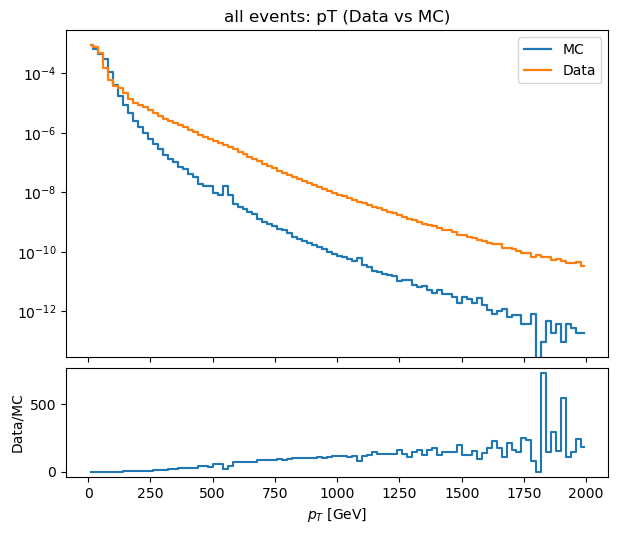

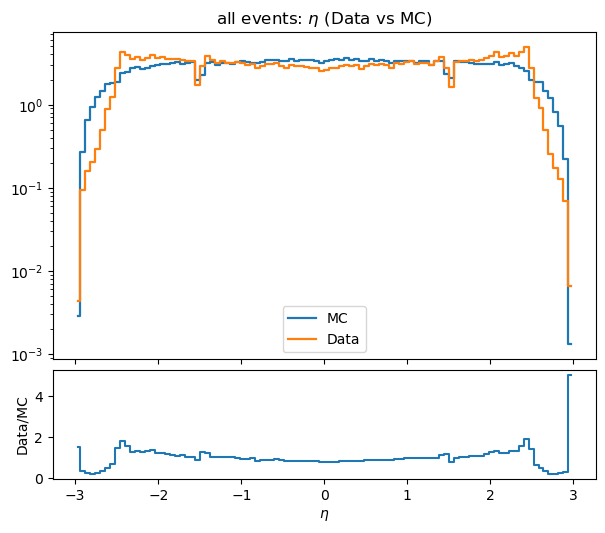

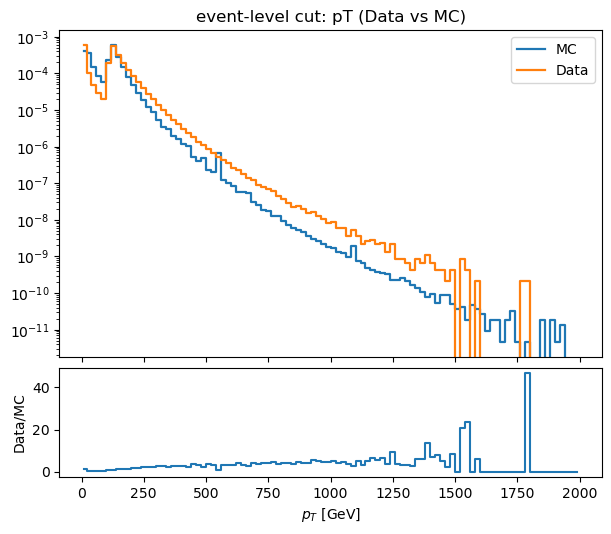

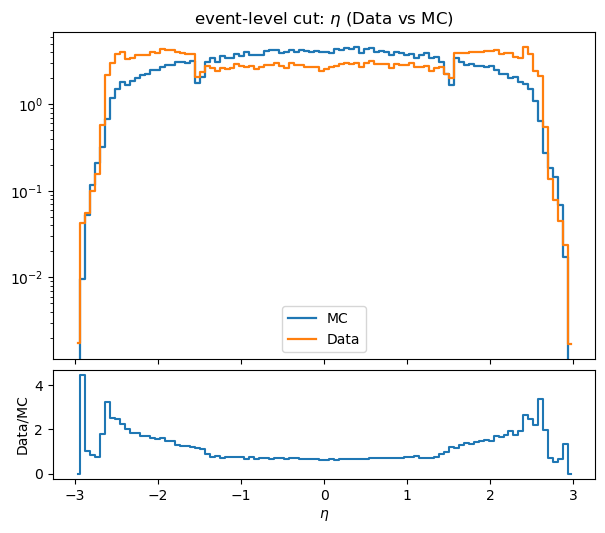

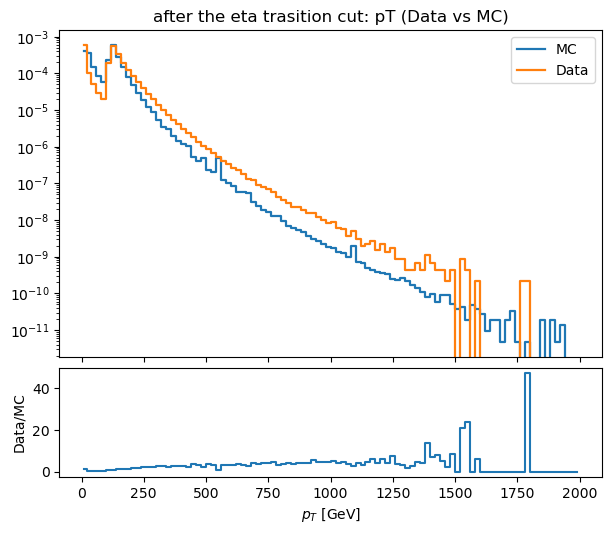

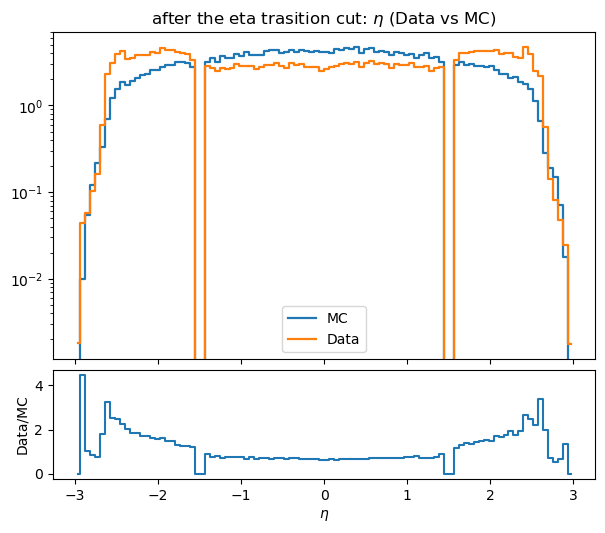

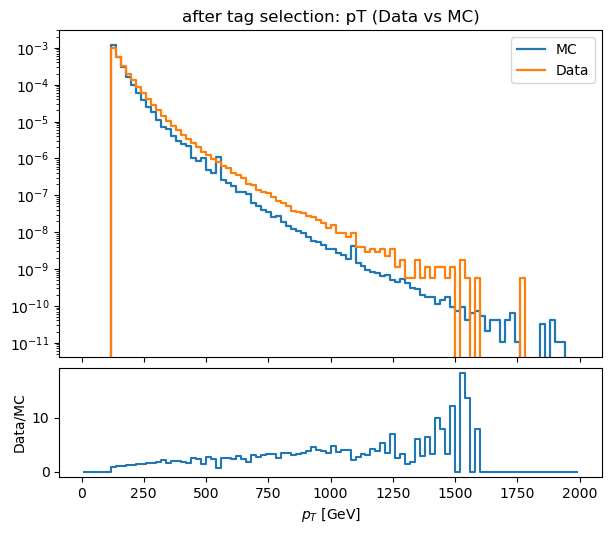

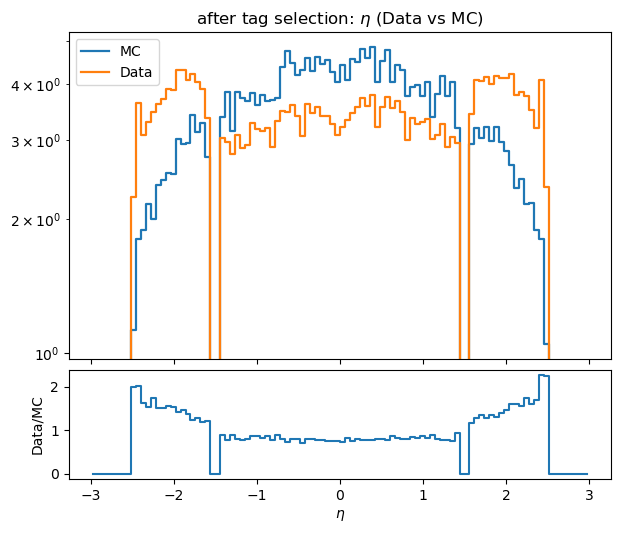

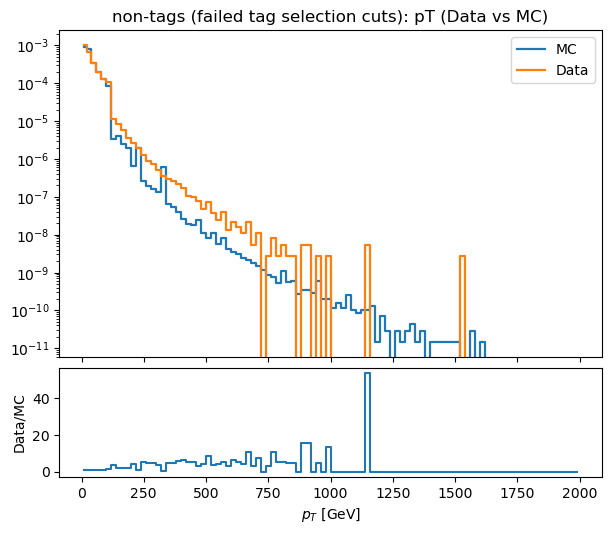

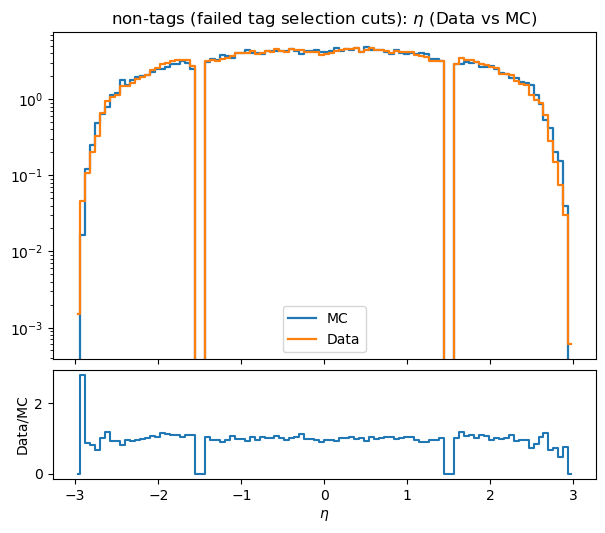

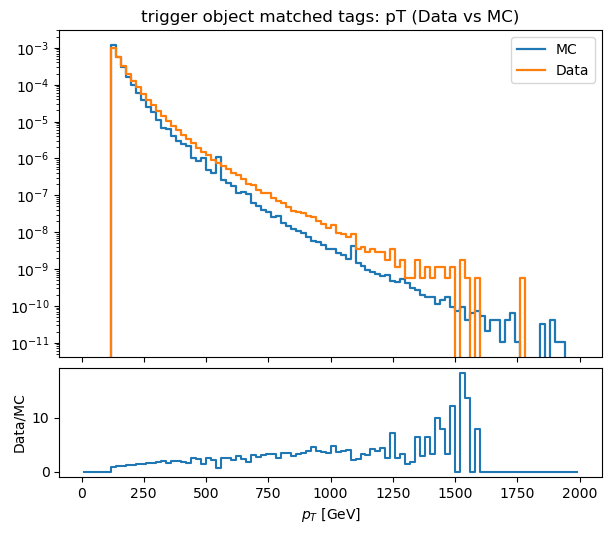

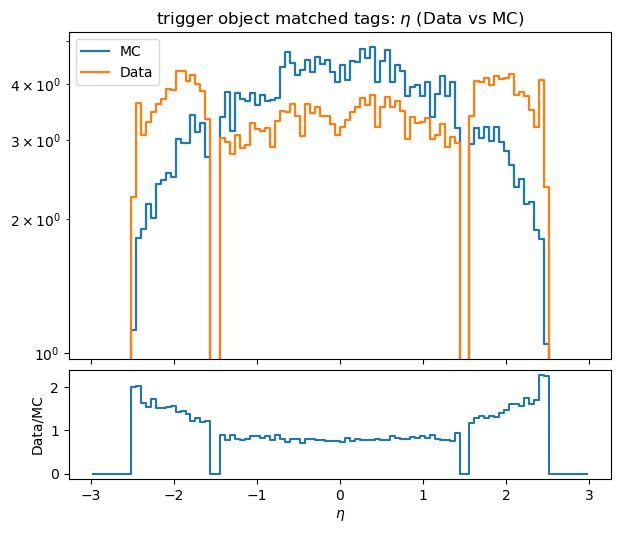

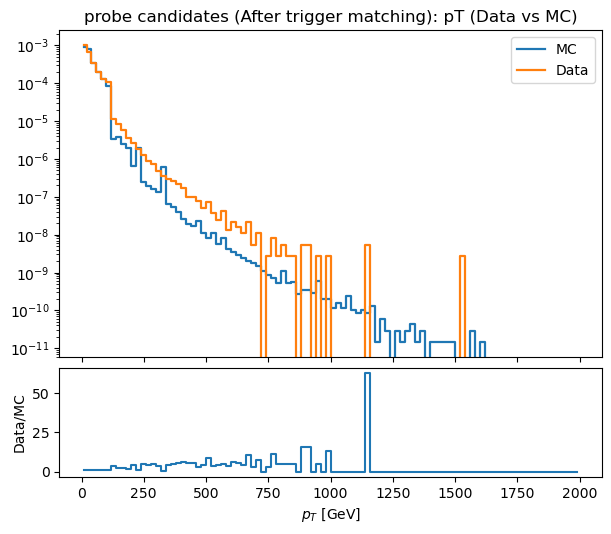

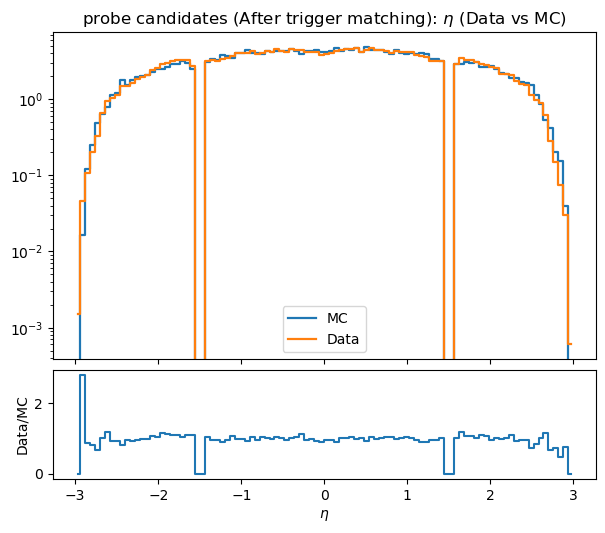

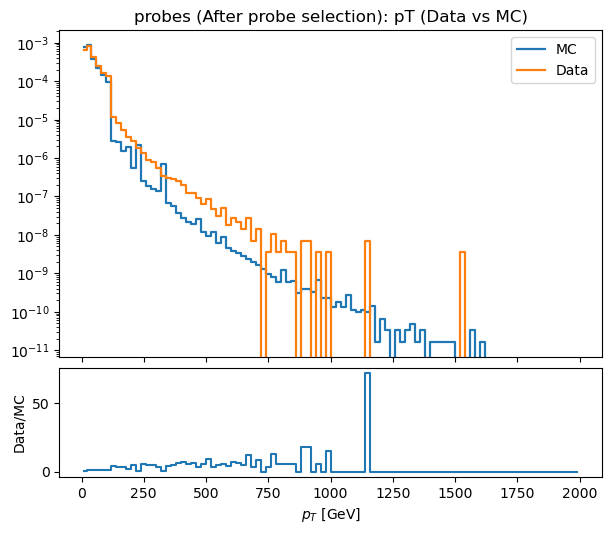

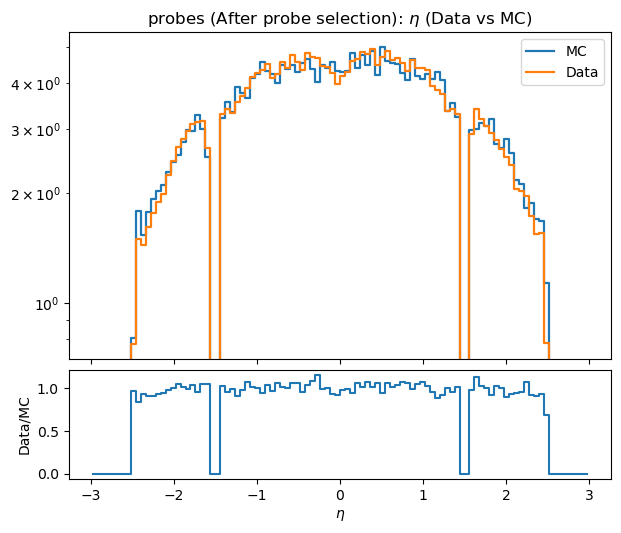

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from hist import Hist

def add_hists(*hs: Hist) -> Hist:
    h = hs[0].copy()
    for x in hs[1:]:
        h += x
    return h

def mc_sum(key: str):
    return add_hists(ds_mc_40_100[key], ds_mc_100_200[key],
                     ds_mc_200_400[key], ds_mc_400_600[key],
                     ds_mc_600[key])

def dt_get(key: str):
    return ds_data[key]

def plot_data_mc_with_ratio(h_data: Hist, h_mc: Hist, xlabel: str, title: str, ylim=None, logy=False, ylabel=None, density=False):
    centers = h_mc.axes[0].centers
    d_vals  = h_data.values()
    m_vals  = h_mc.values()
    edges   = h_mc.axes[0].edges
    widths  = np.diff(edges)


    fig = plt.figure(figsize=(7, 5.8))
    gs  = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.05)
    ax  = fig.add_subplot(gs[0])
    rax = fig.add_subplot(gs[1], sharex=ax)

    if density:
        m_area = np.sum(m_vals * widths)
        d_area = np.sum(d_vals * widths)
        m_vals = m_vals / (m_area * widths)
        d_vals = d_vals / (d_area * widths)

    ratio = np.divide(d_vals, m_vals, out=np.zeros_like(d_vals, dtype=float), where=m_vals>0)
    ax.step(centers, m_vals, where="mid", linewidth=1.6, label="MC")
    ax.step(centers, d_vals, where="mid", linewidth=1.6, label="Data")

    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])
    if logy==True:
        ax.set_yscale("log")
    if ylabel==None:
        ax.set_ylabel("Events")
    else:
        ax.set_ylabel(ylabel)
        
    ax.set_title(title)
    ax.legend()

    rax.step(centers, ratio, where="mid")
    rax.set_ylabel("Data/MC")
    rax.set_xlabel(xlabel)

    plt.setp(ax.get_xticklabels(), visible=False)
    plt.tight_layout()
    plt.show()



stages = {
    "event_check": ("h_event_check_pt", "h_event_check_eta", "all events"),
    "ele2_check": ("h_ele2_check_pt", "h_ele2_check_eta", "event-level cut"),
    "ele2_after_eta_trasition_cut_check": ("h_ele2_after_eta_trasition_cut_check_pt","h_ele2_after_eta_trasition_cut_check_eta","after the eta trasition cut"),
    "e_tag_check": ("h_e_tag_check_pt", "h_e_tag_check_eta", "after tag selection"),
    "not_tag_e_tagcut_check": ("h_not_tag_e_tagcut_check_pt", "h_not_tag_e_tagcut_check_eta", "non-tags (failed tag selection cuts)"),
    "e_tag_matched_check": ("h_e_tag_matched_check_pt", "h_e_tag_matched_check_eta", "trigger object matched tags"),
    "probe_cand_check": ("h_probe_cand_check_pt", "h_probe_cand_check_eta", "probe candidates (After trigger matching)"),
    "probe_check": ("h_probe_check_pt", "h_probe_check_eta", "probes (After probe selection)"),
}

for stg, (kpt, keta, nice) in stages.items():
    h_mc_pt  = mc_sum(kpt)
    h_dt_pt  = dt_get(kpt)
    h_mc_eta = mc_sum(keta)
    h_dt_eta = dt_get(keta)

    plot_data_mc_with_ratio(
        h_dt_pt, h_mc_pt,
        xlabel=r"$p_T$ [GeV]",
        title=f"{nice}: pT (Data vs MC)",
        ylim=None,
        logy=True,
        ylabel= "",
        density=True
        
    )

    plot_data_mc_with_ratio(
        h_dt_eta, h_mc_eta,
        xlabel=r"$\eta$",
        title=f"{nice}: $\eta$ (Data vs MC)",
        ylim=None,
        logy=True,
        ylabel= "",
        density=True
    )



'''
1st plot:
After event level cut: apply trigger selection: `HLT_Ele115_CaloIdVT_GsfTrkIdT` OR `HLT_Photon200`
Electron.mvaNoIso_WP90 > 0 AND nElectron >= 2
ele2_check 

2nd plot:
After the transition religion cut
ECAL transition region: 1.44 < |η| < 1.57 that should be vetoed
ele2_after_eta_trasition_cut_check

3rd/4th plot:
After general tag selection: pt > 120 GeV AND ak.abs(eta) < 2.5  AND Electron.dz < 0.1 (0.2) cm for Barrel (endcap).
        # barrel ( |eta supercluster| <= 1.479)
        # endcap ( |eta supercluster| > 1.479)
        # Tight MVA ID: Electron.mvaNoIso_WP80 > 0
e_tag_check
not_tag_e_tagcut_check

5th/6th plot
After trigger matching 
#(events.TrigObj.id == 11) & ((events.TrigObj.filterBits & (1 << 12)) != 0 OR (events.TrigObj.filterBits & (1 << 14)) != 0) dr<0.1
e_tag_matched_check
probe_cand_check

7th plot
After probe selection:
probe e: pt > 10 GeV AND ak.abs(eta) < 2.5
probe_check
'''


/tmp/ipykernel_26600/3551329922.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


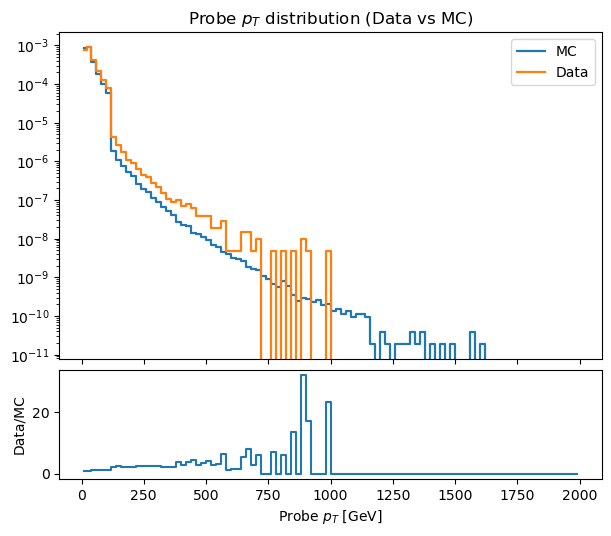

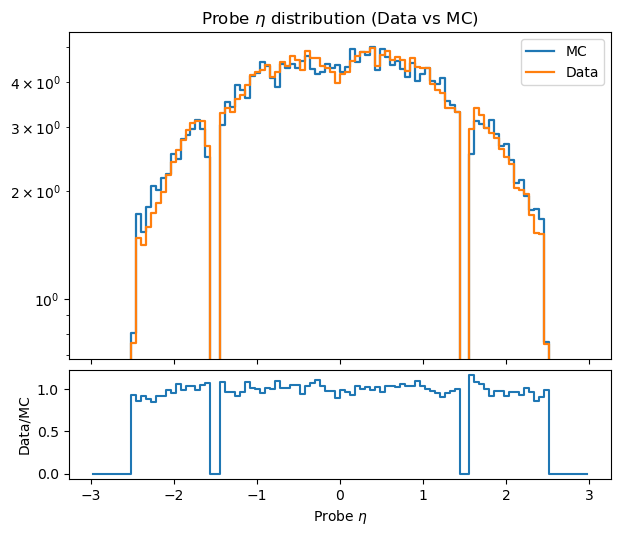

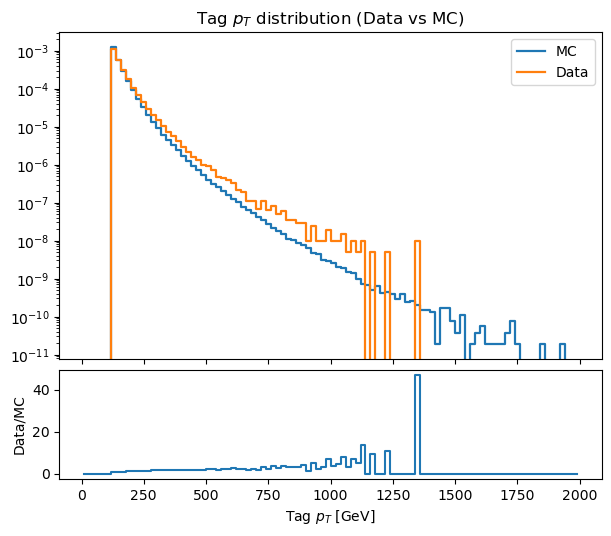

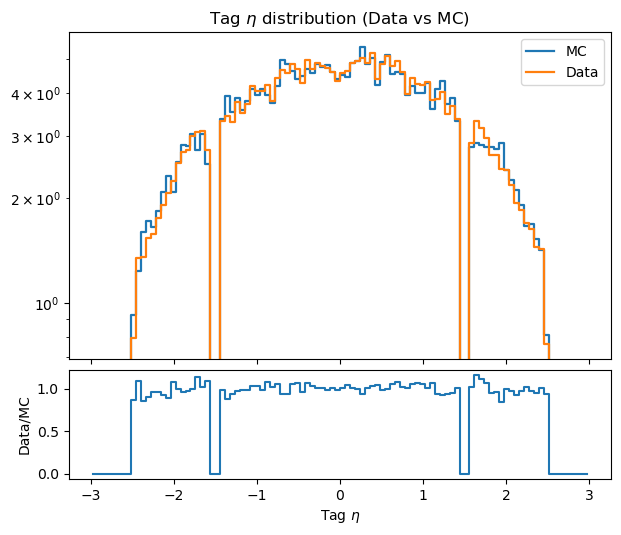

In [9]:
mc_probe_pt  = add_hists(ds_mc_40_100["h_probe_pt"],  ds_mc_100_200["h_probe_pt"],
                         ds_mc_200_400["h_probe_pt"], ds_mc_400_600["h_probe_pt"],
                         ds_mc_600["h_probe_pt"])
mc_probe_eta = add_hists(ds_mc_40_100["h_probe_eta"], ds_mc_100_200["h_probe_eta"],
                         ds_mc_200_400["h_probe_eta"],ds_mc_400_600["h_probe_eta"],
                         ds_mc_600["h_probe_eta"])

data_probe_pt  = ds_data["h_probe_pt"]
data_probe_eta = ds_data["h_probe_eta"]


mc_tag_pt  = add_hists(ds_mc_40_100["h_tag_pt"],  ds_mc_100_200["h_tag_pt"],
                        ds_mc_200_400["h_tag_pt"], ds_mc_400_600["h_tag_pt"],
                        ds_mc_600["h_tag_pt"])
mc_tag_eta = add_hists(ds_mc_40_100["h_tag_eta"], ds_mc_100_200["h_tag_eta"],
                        ds_mc_200_400["h_tag_eta"],ds_mc_400_600["h_tag_eta"],
                        ds_mc_600["h_tag_eta"])
data_tag_pt  = ds_data["h_tag_pt"]
data_tag_eta = ds_data["h_tag_eta"]




plot_data_mc_with_ratio(
    data_probe_pt, mc_probe_pt,
    xlabel=r"Probe $p_T$ [GeV]",
    title=r"Probe $p_T$ distribution (Data vs MC)",
    ylim=None,
    logy=True,
    ylabel= "",
    density=True
)

plot_data_mc_with_ratio(
    data_probe_eta, mc_probe_eta,
    xlabel=r"Probe $\eta$",
    title=r"Probe $\eta$ distribution (Data vs MC)",
    ylim=None,
    logy=True,
    ylabel= "",
    density=True
)


plot_data_mc_with_ratio(
    data_tag_pt, mc_tag_pt,
    xlabel=r"Tag $p_T$ [GeV]",
    title=r"Tag $p_T$ distribution (Data vs MC)",
    ylim=None,
    logy=True,
    ylabel= "",
    density=True
)
plot_data_mc_with_ratio(
    data_tag_eta, mc_tag_eta,
    xlabel=r"Tag $\eta$",
    title=r"Tag $\eta$ distribution (Data vs MC)",
    ylim=None,
    logy=True,
    ylabel= "",
    density=True
)


/tmp/ipykernel_26600/3551329922.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


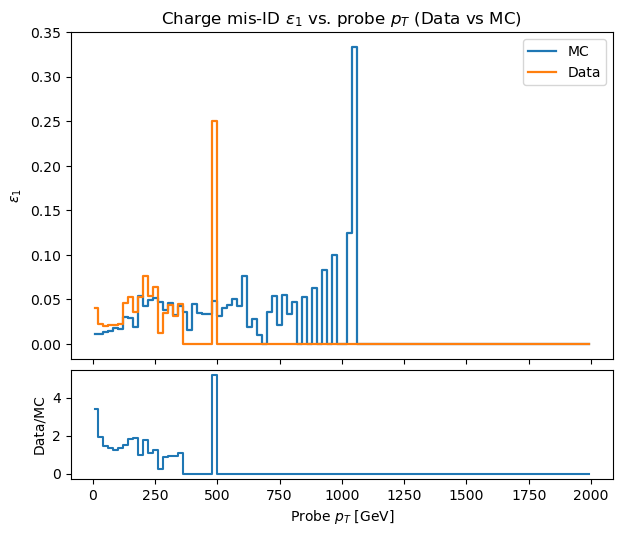

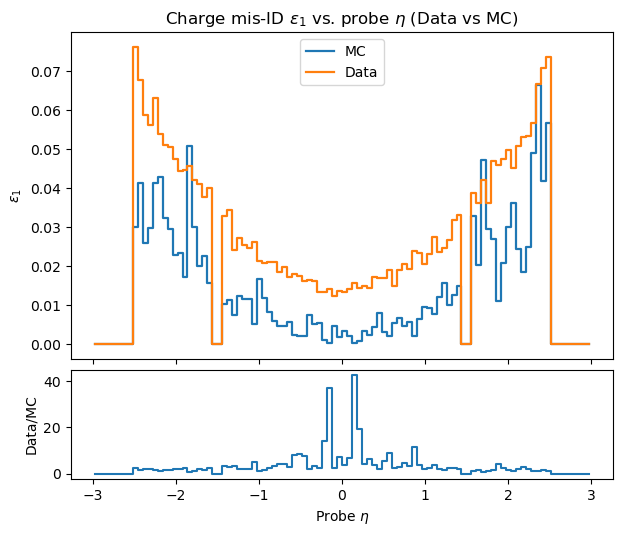

In [10]:
# epsilon 1 vs. pT/eta
mc_same_pt = add_hists(ds_mc_40_100["h_same_pt"],  ds_mc_100_200["h_same_pt"],
                         ds_mc_200_400["h_same_pt"], ds_mc_400_600["h_same_pt"],
                         ds_mc_600["h_same_pt"])
mc_tot_pt  = add_hists(ds_mc_40_100["h_probe_pt"],  ds_mc_100_200["h_probe_pt"],
                         ds_mc_200_400["h_probe_pt"], ds_mc_400_600["h_probe_pt"],
                         ds_mc_600["h_probe_pt"])
data_same_pt = ds_data["h_same_pt"]
data_tot_pt  = ds_data["h_probe_pt"]

mc_same_vals_pt = mc_same_pt.values()
mc_tot_vals_pt  = mc_tot_pt.values()
eps1_mc_pt_vals = np.divide(mc_same_vals_pt, mc_tot_vals_pt,
                            out=np.zeros_like(mc_same_vals_pt, float),
                            where=mc_tot_vals_pt > 0)

data_same_vals_pt = data_same_pt.values()
data_tot_vals_pt  = data_tot_pt.values()
eps1_data_pt_vals = np.divide(data_same_vals_pt, data_tot_vals_pt,
                              out=np.zeros_like(data_same_vals_pt, float),
                              where=data_tot_vals_pt > 0)

ax_pt = mc_same_pt.axes[0]
eps1_mc_pt_hist   = Hist(ax_pt, storage=storage.Weight())
eps1_data_pt_hist = Hist(ax_pt, storage=storage.Weight())

v_mc_pt = eps1_mc_pt_hist.view()
v_mc_pt.value[...]    = eps1_mc_pt_vals
v_mc_pt.variance[...] = 0.0

v_data_pt = eps1_data_pt_hist.view()
v_data_pt.value[...]    = eps1_data_pt_vals
v_data_pt.variance[...] = 0.0

plot_data_mc_with_ratio(
    eps1_data_pt_hist, eps1_mc_pt_hist,
    xlabel=r"Probe $p_T$ [GeV]",
    title=r"Charge mis-ID $\epsilon_1$ vs. probe $p_T$ (Data vs MC)",
    ylim=None,
    ylabel=r"$\epsilon_1$"
)



mc_same_eta = add_hists(ds_mc_40_100["h_same_eta"],  ds_mc_100_200["h_same_eta"],
                         ds_mc_200_400["h_same_eta"], ds_mc_400_600["h_same_eta"],
                         ds_mc_600["h_same_eta"])
mc_tot_eta = add_hists(ds_mc_40_100["h_probe_eta"],  ds_mc_100_200["h_probe_eta"],
                         ds_mc_200_400["h_probe_eta"], ds_mc_400_600["h_probe_eta"],
                         ds_mc_600["h_probe_eta"])
data_same_eta = ds_data["h_same_eta"]
data_tot_eta  = ds_data["h_probe_eta"]

mc_same_vals_eta = mc_same_eta.values()
mc_tot_vals_eta  = mc_tot_eta.values()
eps1_mc_eta_vals = np.divide(mc_same_vals_eta, mc_tot_vals_eta,
                             out=np.zeros_like(mc_same_vals_eta, float),
                             where=mc_tot_vals_eta > 0)

data_same_vals_eta = data_same_eta.values()
data_tot_vals_eta  = data_tot_eta.values()
eps1_data_eta_vals = np.divide(data_same_vals_eta, data_tot_vals_eta,
                               out=np.zeros_like(data_same_vals_eta, float),
                               where=data_tot_vals_eta > 0)

ax_eta = mc_same_eta.axes[0]
eps1_mc_eta_hist   = Hist(ax_eta, storage=storage.Weight())
eps1_data_eta_hist = Hist(ax_eta, storage=storage.Weight())

v_mc_eta = eps1_mc_eta_hist.view()
v_mc_eta.value[...]    = eps1_mc_eta_vals
v_mc_eta.variance[...] = 0.0

v_data_eta = eps1_data_eta_hist.view()
v_data_eta.value[...]    = eps1_data_eta_vals
v_data_eta.variance[...] = 0.0

plot_data_mc_with_ratio(
    eps1_data_eta_hist, eps1_mc_eta_hist,
    xlabel=r"Probe $\eta$",
    title=r"Charge mis-ID $\epsilon_1$ vs. probe $\eta$ (Data vs MC)",
    ylim=None,
    ylabel=r"$\epsilon_1$"
)



/tmp/ipykernel_26600/3551329922.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


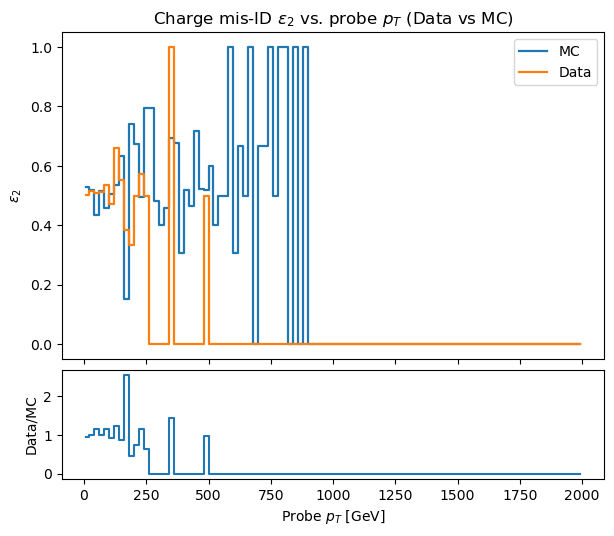

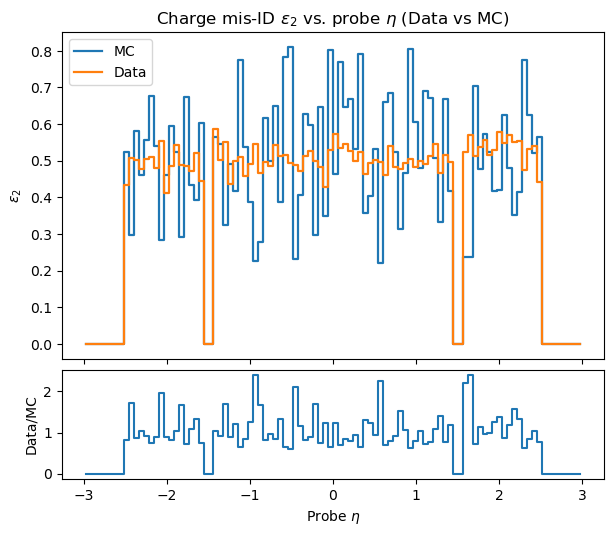

In [11]:
# epsilon 2 vs. pT/eta
mc_pp_pt   = add_hists(ds_mc_40_100["h_pp_pt"],   ds_mc_100_200["h_pp_pt"],
                       ds_mc_200_400["h_pp_pt"],  ds_mc_400_600["h_pp_pt"],
                       ds_mc_600["h_pp_pt"])


data_pp_pt   = ds_data["h_pp_pt"]

mc_eps2_pt   = np.divide(mc_pp_pt.values(),   mc_same_pt.values(),
                         out=np.zeros_like(mc_pp_pt.values(), dtype=float),
                         where=mc_same_pt.values() > 0)
data_eps2_pt = np.divide(data_pp_pt.values(), data_same_pt.values(),
                         out=np.zeros_like(data_pp_pt.values(), dtype=float),
                         where=data_same_pt.values() > 0)

ax_pt = mc_pp_pt.axes[0]
h_eps2_mc_pt   = Hist(ax_pt, storage=storage.Weight())
h_eps2_data_pt = Hist(ax_pt, storage=storage.Weight())
v_mc_pt = h_eps2_mc_pt.view()
v_mc_pt.value[:] = mc_eps2_pt
v_mc_pt.variance[:] = 0.0
v_dt_pt = h_eps2_data_pt.view()
v_dt_pt.value[:] = data_eps2_pt
v_dt_pt.variance[:] = 0.0

plot_data_mc_with_ratio(
    h_eps2_data_pt, h_eps2_mc_pt,
    xlabel=r"Probe $p_T$ [GeV]",
    title=r"Charge mis-ID $\epsilon_2$ vs. probe $p_T$ (Data vs MC)",
    ylim=None,
    ylabel=r"$\epsilon_2$"
)


mc_pp_eta   = add_hists(ds_mc_40_100["h_pp_eta"],   ds_mc_100_200["h_pp_eta"],
                        ds_mc_200_400["h_pp_eta"],  ds_mc_400_600["h_pp_eta"],
                        ds_mc_600["h_pp_eta"])

data_pp_eta   = ds_data["h_pp_eta"]

mc_eps2_eta   = np.divide(mc_pp_eta.values(),   mc_same_eta.values(),
                          out=np.zeros_like(mc_pp_eta.values(), dtype=float),
                          where=mc_same_eta.values() > 0)
data_eps2_eta = np.divide(data_pp_eta.values(), data_same_eta.values(),
                          out=np.zeros_like(data_pp_eta.values(), dtype=float),
                          where=data_same_eta.values() > 0)

ax_eta = mc_pp_eta.axes[0]
h_eps2_mc_eta   = Hist(ax_eta, storage=storage.Weight())
h_eps2_data_eta = Hist(ax_eta, storage=storage.Weight())
v_mc_eta = h_eps2_mc_eta.view()
v_mc_eta.value[:] = mc_eps2_eta
v_mc_eta.variance[:] = 0.0
v_dt_eta = h_eps2_data_eta.view()
v_dt_eta.value[:] = data_eps2_eta
v_dt_eta.variance[:] = 0.0

plot_data_mc_with_ratio(
    h_eps2_data_eta, h_eps2_mc_eta,
    xlabel=r"Probe $\eta$",
    title=r"Charge mis-ID $\epsilon_2$ vs. probe $\eta$ (Data vs MC)",
    ylim=None,
    ylabel=r"$\epsilon_2$"
)


/tmp/ipykernel_26600/3551329922.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


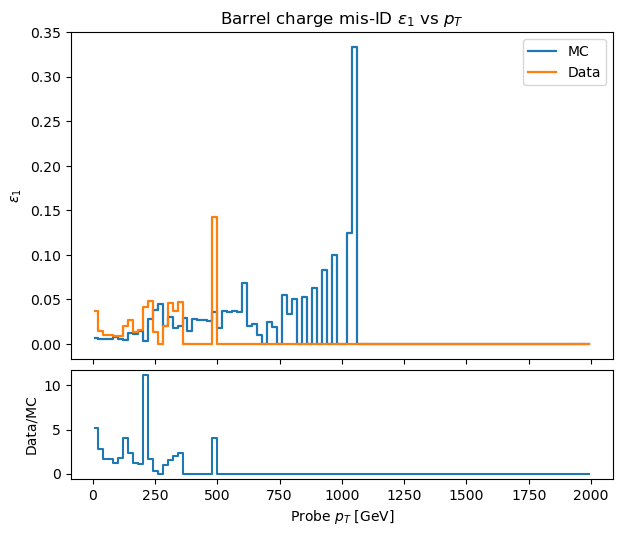

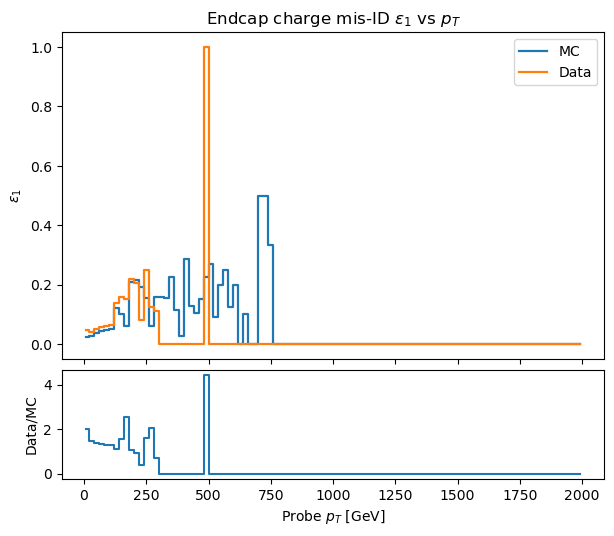

In [12]:
#separate barrel and end cap 
#epsion 1
mc_same_pt_barrel = add_hists(ds_mc_40_100["h_same_pt_barrel"],  ds_mc_100_200["h_same_pt_barrel"],
                              ds_mc_200_400["h_same_pt_barrel"], ds_mc_400_600["h_same_pt_barrel"],
                              ds_mc_600["h_same_pt_barrel"])
mc_tot_pt_barrel  = add_hists(ds_mc_40_100["h_tot_pt_barrel"],   ds_mc_100_200["h_tot_pt_barrel"],
                              ds_mc_200_400["h_tot_pt_barrel"],  ds_mc_400_600["h_tot_pt_barrel"],
                              ds_mc_600["h_tot_pt_barrel"])

mc_same_pt_endcap = add_hists(ds_mc_40_100["h_same_pt_endcap"],  ds_mc_100_200["h_same_pt_endcap"],
                              ds_mc_200_400["h_same_pt_endcap"], ds_mc_400_600["h_same_pt_endcap"],
                              ds_mc_600["h_same_pt_endcap"])
mc_tot_pt_endcap  = add_hists(ds_mc_40_100["h_tot_pt_endcap"],   ds_mc_100_200["h_tot_pt_endcap"],
                              ds_mc_200_400["h_tot_pt_endcap"],  ds_mc_400_600["h_tot_pt_endcap"],
                              ds_mc_600["h_tot_pt_endcap"])

data_same_pt_barrel = ds_data["h_same_pt_barrel"]
data_tot_pt_barrel  = ds_data["h_tot_pt_barrel"]

data_same_pt_endcap = ds_data["h_same_pt_endcap"]
data_tot_pt_endcap  = ds_data["h_tot_pt_endcap"]

# epsilon 1 barrel
mc_eps1_barrel = np.divide(mc_same_pt_barrel.values(), mc_tot_pt_barrel.values(),
                           out=np.zeros_like(mc_same_pt_barrel.values(), dtype=float),
                           where=mc_tot_pt_barrel.values() > 0)
dt_eps1_barrel = np.divide(data_same_pt_barrel.values(), data_tot_pt_barrel.values(),
                           out=np.zeros_like(data_same_pt_barrel.values(), dtype=float),
                           where=data_tot_pt_barrel.values() > 0)

ax_pt_barrel = mc_same_pt_barrel.axes[0]
h_eps1_mc_barrel   = Hist(ax_pt_barrel, storage=storage.Weight())
h_eps1_data_barrel = Hist(ax_pt_barrel, storage=storage.Weight())
v_mc_b = h_eps1_mc_barrel.view()
v_mc_b.value[:] = mc_eps1_barrel
v_mc_b.variance[:] = 0.0
v_dt_b = h_eps1_data_barrel.view()
v_dt_b.value[:] = dt_eps1_barrel
v_dt_b.variance[:] = 0.0

plot_data_mc_with_ratio(
    h_eps1_data_barrel, h_eps1_mc_barrel,
    xlabel=r"Probe $p_T$ [GeV]",
    title=r"Barrel charge mis-ID $\epsilon_1$ vs $p_T$",
    ylim=None,
    ylabel=r"$\epsilon_1$"
)

# epsilon 1 endcap 
mc_eps1_endcap = np.divide(mc_same_pt_endcap.values(), mc_tot_pt_endcap.values(),
                           out=np.zeros_like(mc_same_pt_endcap.values(), dtype=float),
                           where=mc_tot_pt_endcap.values() > 0)
dt_eps1_endcap = np.divide(data_same_pt_endcap.values(), data_tot_pt_endcap.values(),
                           out=np.zeros_like(data_same_pt_endcap.values(), dtype=float),
                           where=data_tot_pt_endcap.values() > 0)

ax_pt_endcap = mc_same_pt_endcap.axes[0]
h_eps1_mc_endcap   = Hist(ax_pt_endcap, storage=storage.Weight())
h_eps1_data_endcap = Hist(ax_pt_endcap, storage=storage.Weight())
v_mc_e = h_eps1_mc_endcap.view()
v_mc_e.value[:] = mc_eps1_endcap
v_mc_e.variance[:] = 0.0
v_dt_e = h_eps1_data_endcap.view()
v_dt_e.value[:] = dt_eps1_endcap
v_dt_e.variance[:] = 0.0

plot_data_mc_with_ratio(
    h_eps1_data_endcap, h_eps1_mc_endcap,
    xlabel=r"Probe $p_T$ [GeV]",
    title=r"Endcap charge mis-ID $\epsilon_1$ vs $p_T$",
    ylim=None,
    ylabel=r"$\epsilon_1$"
)


/tmp/ipykernel_26600/3551329922.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


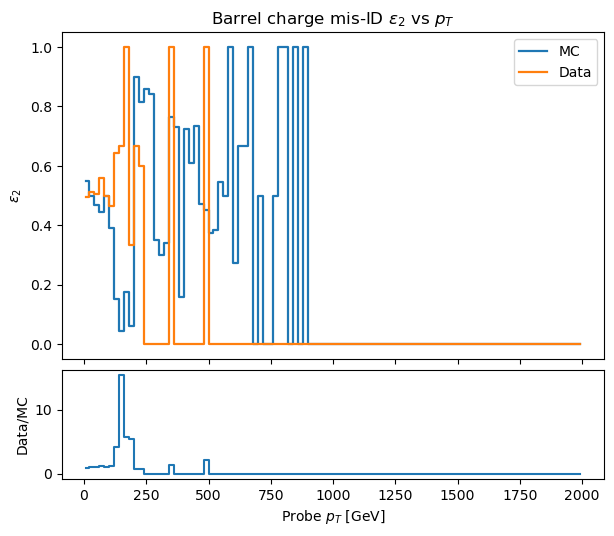

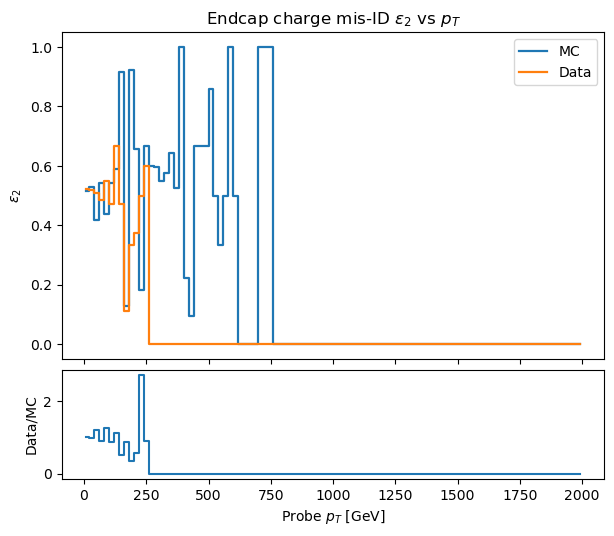

In [13]:
#separate barrel and end cap 
#epsion 2

mc_pp_pt_barrel   = add_hists(ds_mc_40_100["h_pp_pt_barrel"],   ds_mc_100_200["h_pp_pt_barrel"],
                              ds_mc_200_400["h_pp_pt_barrel"],  ds_mc_400_600["h_pp_pt_barrel"],
                              ds_mc_600["h_pp_pt_barrel"])

mc_pp_pt_endcap   = add_hists(ds_mc_40_100["h_pp_pt_endcap"],   ds_mc_100_200["h_pp_pt_endcap"],
                              ds_mc_200_400["h_pp_pt_endcap"],  ds_mc_400_600["h_pp_pt_endcap"],
                              ds_mc_600["h_pp_pt_endcap"])


data_pp_pt_barrel   = ds_data["h_pp_pt_barrel"]
data_pp_pt_endcap   = ds_data["h_pp_pt_endcap"]


# epsilon 2 barrel
mc_eps2_barrel = np.divide(
    mc_pp_pt_barrel.values(), mc_same_pt_barrel.values(),
    out=np.zeros_like(mc_pp_pt_barrel.values(), dtype=float),
    where=mc_same_pt_barrel.values() > 0
)
dt_eps2_barrel = np.divide(
    data_pp_pt_barrel.values(), data_same_pt_barrel.values(),
    out=np.zeros_like(data_pp_pt_barrel.values(), dtype=float),
    where=data_same_pt_barrel.values() > 0
)

ax_b = mc_same_pt_barrel.axes[0]
h_eps2_mc_barrel   = Hist(ax_b, storage=storage.Weight())
h_eps2_data_barrel = Hist(ax_b, storage=storage.Weight())
vb_mc = h_eps2_mc_barrel.view()
vb_mc.value[:] = mc_eps2_barrel
vb_mc.variance[:] = 0.0
vb_dt = h_eps2_data_barrel.view()
vb_dt.value[:] = dt_eps2_barrel
vb_dt.variance[:] = 0.0

plot_data_mc_with_ratio(
    h_eps2_data_barrel, h_eps2_mc_barrel,
    xlabel=r"Probe $p_T$ [GeV]",
    title=r"Barrel charge mis-ID $\epsilon_2$ vs $p_T$",
    ylim=None,
    ylabel=r"$\epsilon_2$"
)

# epsilon 2 endcap
mc_eps2_endcap = np.divide(
    mc_pp_pt_endcap.values(), mc_same_pt_endcap.values(),
    out=np.zeros_like(mc_pp_pt_endcap.values(), dtype=float),
    where=mc_same_pt_endcap.values() > 0
)
dt_eps2_endcap = np.divide(
    data_pp_pt_endcap.values(), data_same_pt_endcap.values(),
    out=np.zeros_like(data_pp_pt_endcap.values(), dtype=float),
    where=data_same_pt_endcap.values() > 0
)

ax_e = mc_same_pt_endcap.axes[0]
h_eps2_mc_endcap   = Hist(ax_e, storage=storage.Weight())
h_eps2_data_endcap = Hist(ax_e, storage=storage.Weight())
ve_mc = h_eps2_mc_endcap.view()
ve_mc.value[:] = mc_eps2_endcap
ve_mc.variance[:] = 0.0
ve_dt = h_eps2_data_endcap.view()
ve_dt.value[:] = dt_eps2_endcap
ve_dt.variance[:] = 0.0

plot_data_mc_with_ratio(
    h_eps2_data_endcap, h_eps2_mc_endcap,
    xlabel=r"Probe $p_T$ [GeV]",
    title=r"Endcap charge mis-ID $\epsilon_2$ vs $p_T$",
    ylim=None,
    ylabel=r"$\epsilon_2$"
)


In [14]:
#n0_mc = ds_mc["n0"]
#n_keep_mc = int(ak.to_numpy(ds_mc["n_keep"]).item())
#print(f"MC kept {n_keep_mc}/{n0_mc} events")

n0_data = ds_data["n0"]
print(n0_data)
n_keep_data = int(ak.to_numpy(ds_data["n_keep"]).item())
print(f"data lumimask kept {n_keep_data}/{n0_data} events")

data_n_pp = int(ds_data["num_pp"])
data_n_mm = int(ds_data["num_mm"])
data_n_pm = int(ds_data["num_pm"])

print("for data")
print("++ rows:", data_n_pp)
print("-- rows:", data_n_mm)
print("+- rows:", data_n_pm)


mc_keys = ["DY_40_100","DY_100_200","DY_200_400","DY_400_600","DY_600"]

mc_pp_total = 0
mc_mm_total = 0
mc_pm_total = 0

print("for MC (unweighted)")
for k in mc_keys:
    ds = out[k]
    n_pp = int(ds["num_pp"])
    n_mm = int(ds["num_mm"])
    n_pm = int(ds["num_pm"])
    mc_pp_total += n_pp
    mc_mm_total += n_mm
    mc_pm_total += n_pm
    print(f"[{k}] ++: {n_pp:>1}  --: {n_mm:>1}  +- : {n_pm:>1}")

print("MC total")
print("++ rows:", mc_pp_total)
print("-- rows:", mc_mm_total)
print("+- rows:", mc_pm_total)


5027394563
data lumimask kept 4893556155/5027394563 events
for data
++ rows: 7089
-- rows: 6859
+- rows: 499100
for MC (unweighted)
[DY_40_100] ++: 1  --: 1  +- : 78
[DY_100_200] ++: 195  --: 193  +- : 33674
[DY_200_400] ++: 894  --: 859  +- : 112924
[DY_400_600] ++: 1071  --: 990  +- : 101415
[DY_600] ++: 881  --: 762  +- : 75281
MC total
++ rows: 3042
-- rows: 2805
+- rows: 323372
